In [2]:
import pandas as pd
import numpy as np

import jd 
from optbinning import MulticlassOptimalBinning

import plotly.express as px
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 6]  # Width, Height

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,TargetEncoder,LabelEncoder,StandardScaler
from category_encoders import WOEEncoder, CountEncoder,HelmertEncoder, PolynomialEncoder

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.compose import ColumnTransformer


from feature_engine.encoding import OrdinalEncoder as feat_eng_OrdinalCategoricalEncoder

(CVXPY) Apr 21 12:41:55 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 21 12:41:55 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [3]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")
df = pd.merge(X,y,on="id")
"""
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.status_group = le.fit_transform(df.status_group)
"""

'\nfrom sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\ndf.status_group = le.fit_transform(df.status_group)\n'

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


0    32259
2    22824
1     4317
Name: status_group, dtype: int64

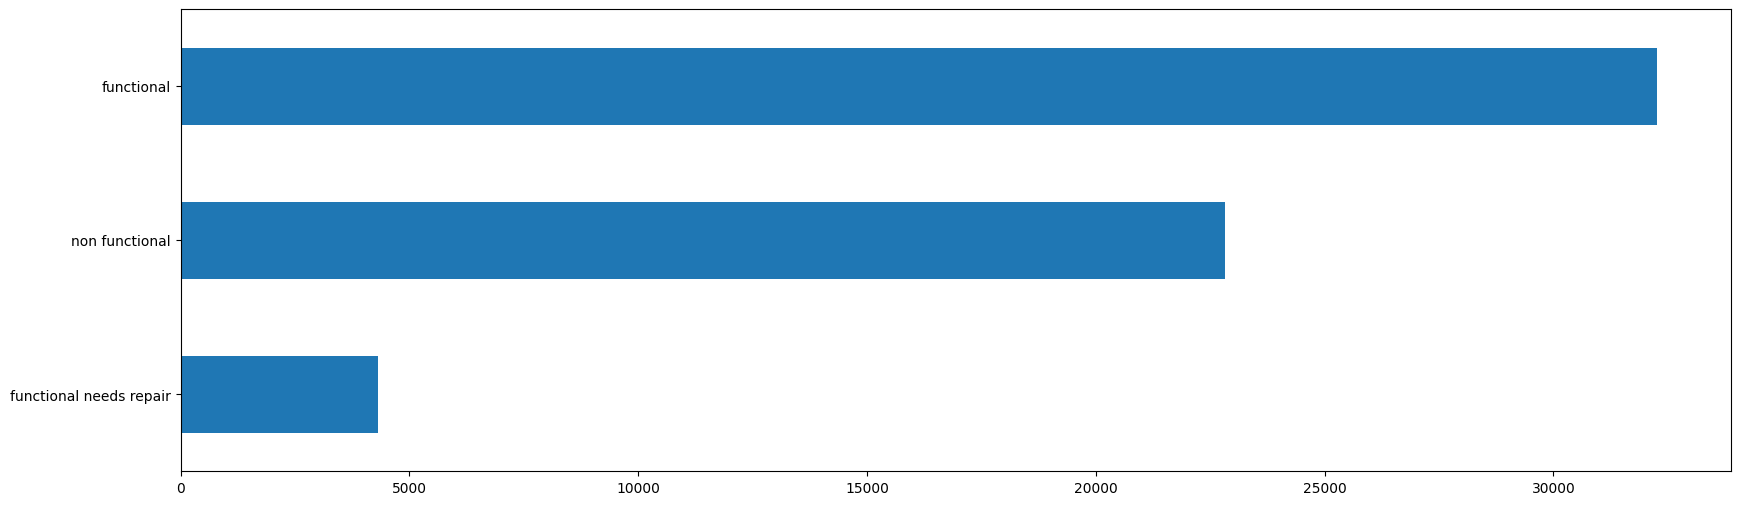

In [3]:
df.status_group.value_counts().sort_values().plot(kind="barh")
print(df.status_group.value_counts())
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.status_group = le.fit_transform(df.status_group)
df.status_group.value_counts()

### Label encoder me dejó labels fáciles de entender, 0 es lo mejor (funcional), luego nees repair (1), y como peor 2, non functional

In [4]:
for i in df.select_dtypes(include = "O").columns:
    df[i] = df[i].astype("category")

In [5]:
df.funder.dtype.name

'category'

## Uso la información del siguiente gráfico para hacer mis primeras entregas, baja V de Cramer = drop

In [6]:
df["random"] = np.random.uniform(0,1, size=df.shape[0])
df["random2"] = np.random.uniform(0,1, size=df.shape[0])
a_sacar = ["date_recorded","funder"]
tablaCramer = pd.DataFrame(df.drop(a_sacar,axis=1).apply(lambda x: jd.cramers_v(x, df.status_group)),columns=['VCramer'])

px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente al Beneficio').update_yaxes(categoryorder="total ascending")

# Tenemos unas categóricas con mucha asociación cramer con la objetivo, pero que tienen una cantidad bárbara de categorías

In [7]:
tablaCramer["tipo"] = [df[x].dtype.name for x in tablaCramer.index.tolist()]
tablaCramer["Cant_valores_unicos"] = [df[x].nunique() for x in tablaCramer.index.tolist()]
tablaCramer.sort_values(ascending=False,by="VCramer")



VCramer      tipo  Cant_valores_unicos
status_group           1.000000     int64                    3
wpt_name               0.809527  category                37400
subvillage             0.682880  category                19287
scheme_name            0.588342  category                 2696
ward                   0.469122  category                 2092
installer              0.363391  category                 2145
lga                    0.311533  category                  125
quantity_group         0.309240  category                    5
quantity               0.309240  category                    5
waterpoint_type        0.250426  category                    7
extraction_type        0.248999  category                   18
extraction_type_group  0.247306  category                   13
extraction_type_class  0.241544  category                    7
waterpoint_type_group  0.226873  category                    6
region                 0.200895  category                   21
payment_type           0.182704  category                    7
payment                0.182704  category                    7
source                 0.148619  category                   10
water_quality          0.138455  category                    8
quality_group          0.132958  category                    6
management             0.132355  category                   12
scheme_management      0.130359  category                   12
basin                  0.127163  category                    9
source_type            0.126691  category                    7
gps_height             0.096562     int64                 2428
longitude              0.095487   float64                57516
latitude               0.086034   float64                57517
region_code            0.084304     int64                   27
district_code          0.076123     int64                   20
public_meeting         0.073415  category                    2
source_class           0.070488  category                    3
construction_year      0.054989     int64                   55
management_group       0.049207  category                    5
permit                 0.034686  category                    2
population             0.015280     int64                 1049
id                     0.009194     int64                59400
random                 0.009130   float64                59400
amount_tsh             0.008245   float64                   98
num_private            0.007482     int64                   65
random2                0.007043   float64                59400
recorded_by                 NaN  category                    1

In [8]:
#Al graficarlo me di cuenta
df.num_private = df.num_private.astype("category")

In [9]:
tablaCramer.loc["region_code"]

VCramer                0.084304
tipo                      int64
Cant_valores_unicos          27
Name: region_code, dtype: object

In [10]:
#mat = jd.get_cat_corr_mat(df.drop(a_sacar,axis=1))
#sns.heatmap(annot=True,cmap="coolwarm")

In [11]:
tablaCramer.index

Index(['id', 'amount_tsh', 'gps_height', 'installer', 'longitude', 'latitude',
       'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'random', 'random2'],
      dtype='object')

In [12]:
def histogram_boxplot(data, xlabel = None, title = None, font_scale=2, figsize=(20,12), bins = None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel 
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)

    example use: histogram_boxplot(np.random.rand(100), bins = 20, title="Fancy plot")
    """
    # Definir tamaño letra
    sns.set(font_scale=font_scale)
    # Crear ventana para los subgráficos
    f2, (ax_box2, ax_hist2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)
    # Crear boxplot
    sns.boxplot(x=data, ax=ax_box2)
    # Crear histograma
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    # Pintar una línea con la media
    ax_hist2.axvline(np.mean(data),color='red',linestyle='--')
    # Pintar una línea con la mediana
    ax_hist2.axvline(np.median(data.dropna()),color='blue',linestyle='-')
    # Asignar título y nombre de eje si tal
    if xlabel: ax_hist2.set(xlabel=xlabel)
    #if title: ax_box2.set(title=title, xlabel="")
    ax_box2.set(title=data.name, xlabel="")
    #leyenda
    plt.legend(handles=[
    plt.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Mean'),
    plt.Line2D([], [], color='blue', linestyle='-', linewidth=2, label='Median')
    ], labels=['Mean (-)', 'Median (--)'])

    # Mostrar gráfico
    plt.show()

In [13]:
df.dtypes

id                          int64
amount_tsh                float64
date_recorded            category
funder                   category
gps_height                  int64
installer                category
longitude                 float64
latitude                  float64
wpt_name                 category
num_private              category
basin                    category
subvillage               category
region                   category
region_code                 int64
district_code               int64
lga                      category
ward                     category
population                  int64
public_meeting           category
recorded_by              category
scheme_management        category
scheme_name              category
permit                   category
construction_year           int64
extraction_type          category
extraction_type_group    category
extraction_type_class    category
management               category
management_group         category
payment       

# Empiezo mi EDA de variables numéricas

## amount_tsh: complicada, muchos valores centrados en el cero, muchos outliers

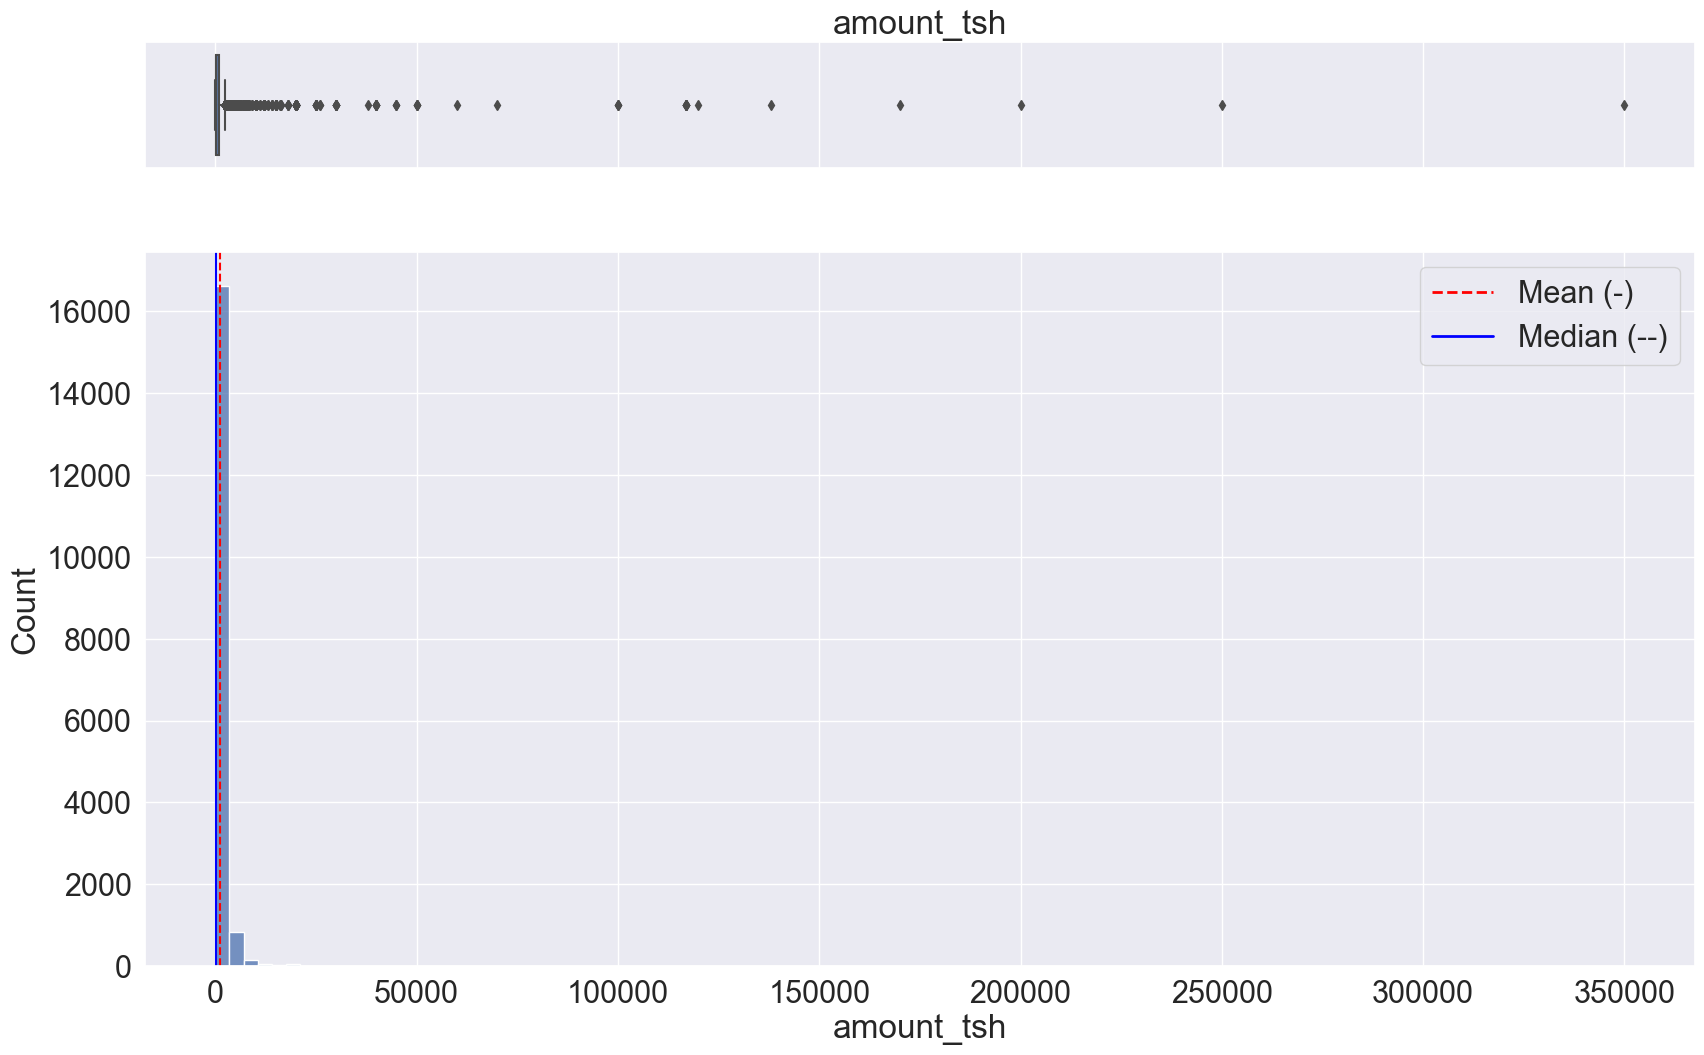

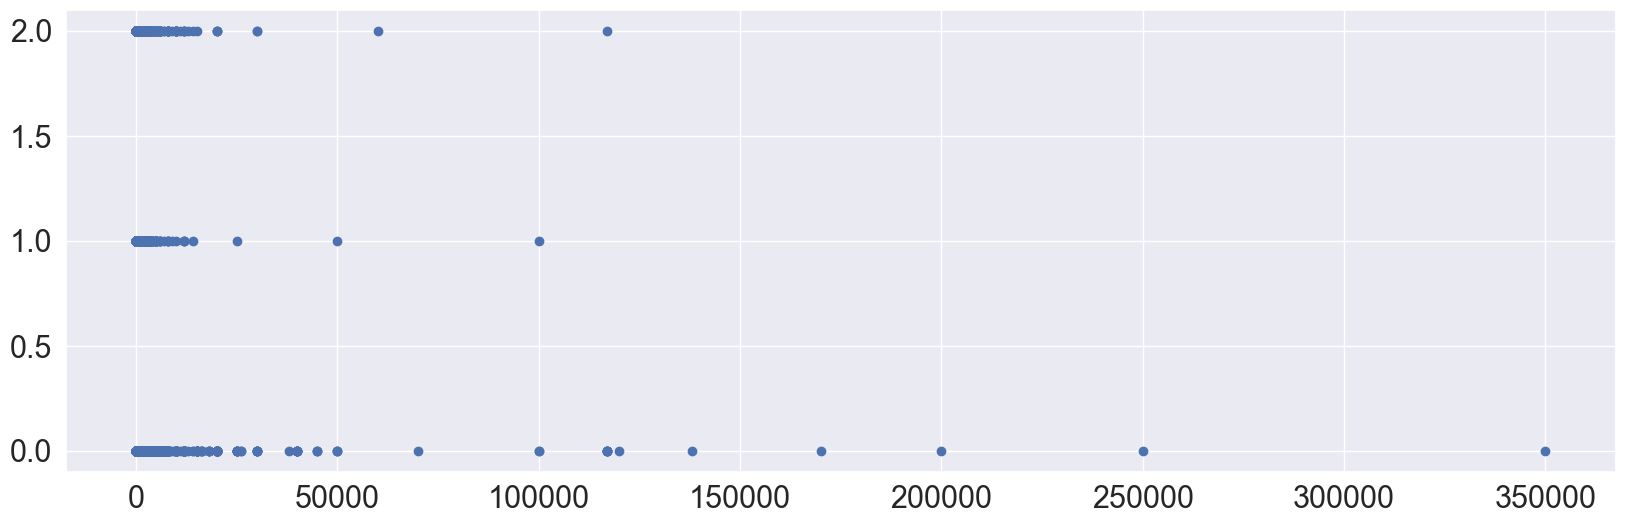

In [14]:
histogram_boxplot(df[df["amount_tsh"]!=0]["amount_tsh"],bins=100)
plt.show()
df[df["amount_tsh"]!=0]["amount_tsh"].value_counts().sort_index()
plt.scatter(x=df.amount_tsh,y=df.status_group)
plt.show()

Text(0.5, 1.0, 'Distribución tal cual')

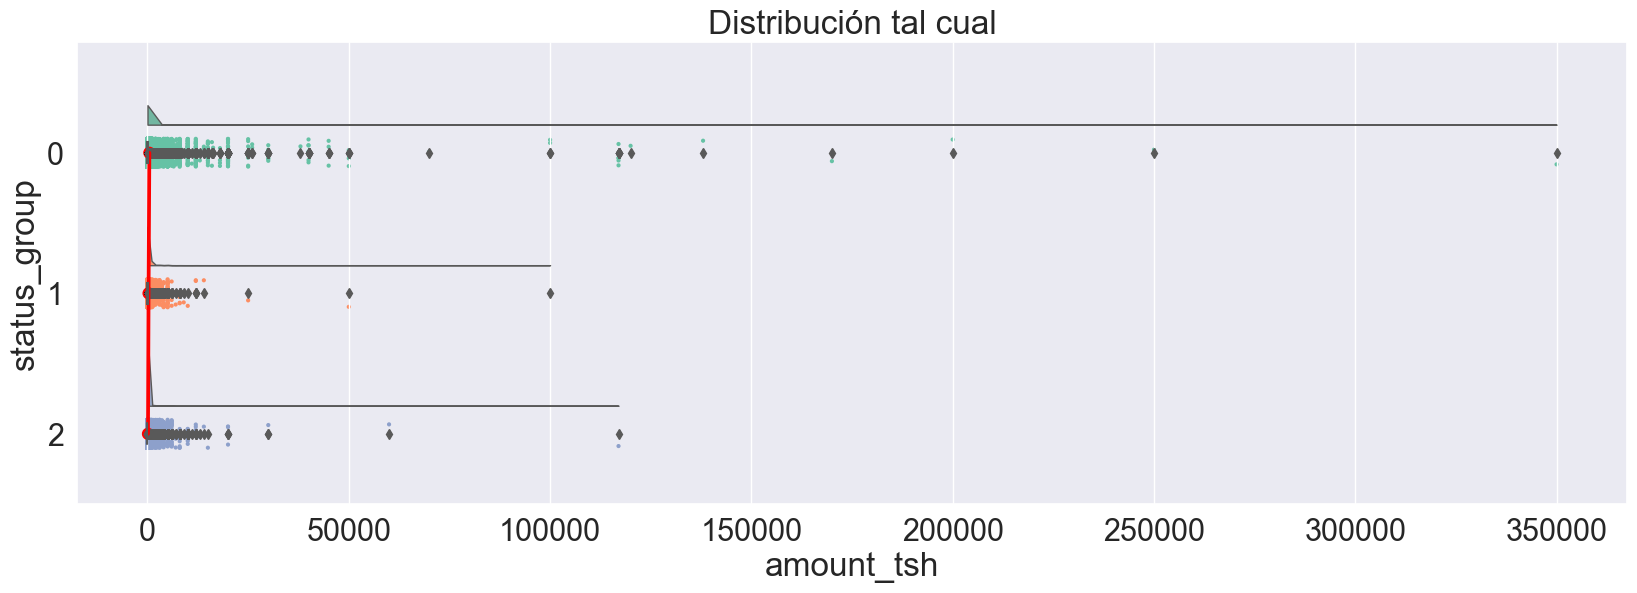

In [15]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

Text(0.5, 1.0, 'Sacando outliers >50000')

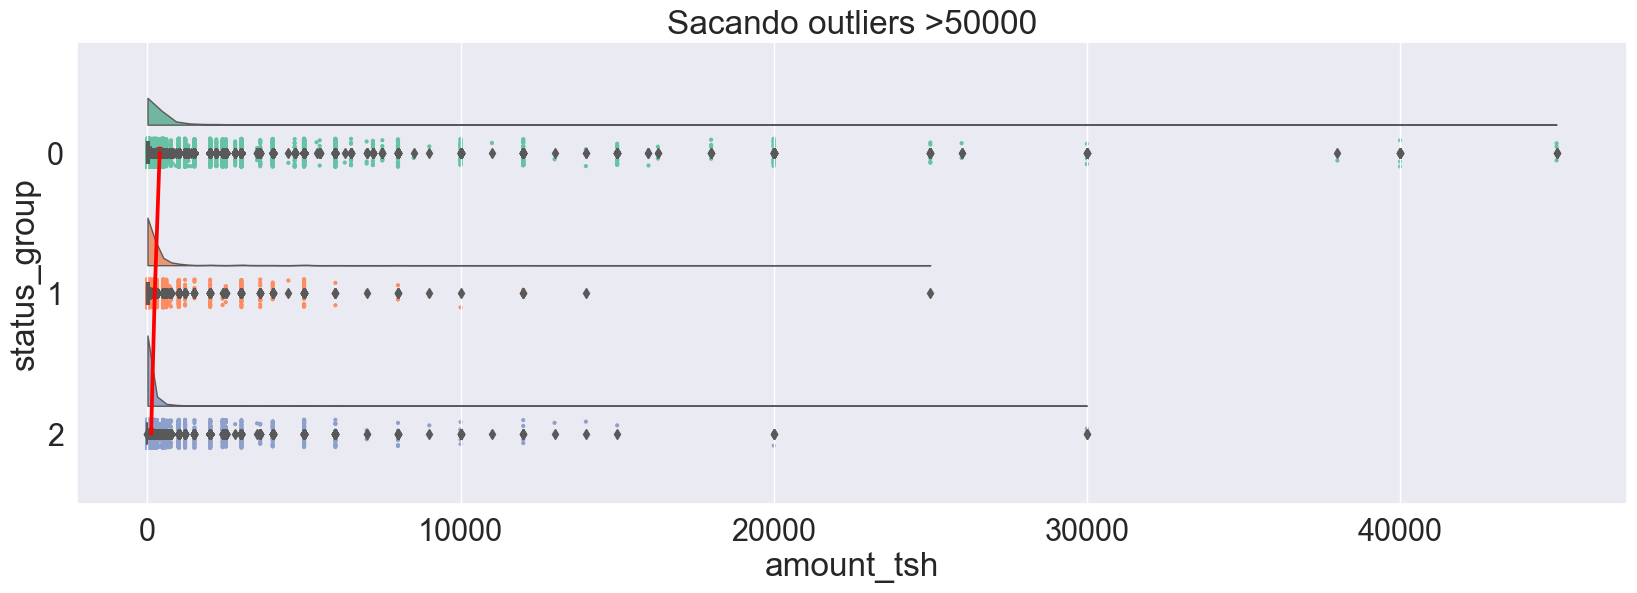

In [16]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[df["amount_tsh"]<50000],width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando outliers >50000")

0    19706
2    18885
1     3048
Name: status_group, dtype: int64

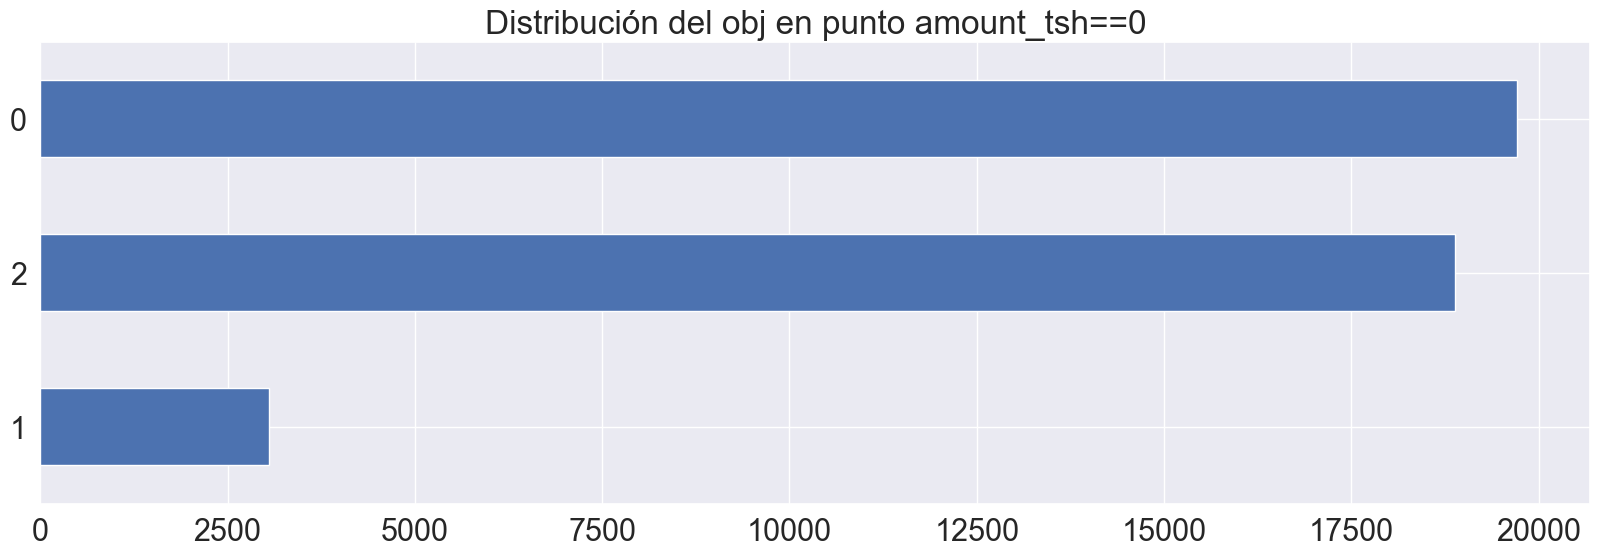

In [17]:
df[df["amount_tsh"]==0]["status_group"].value_counts().sort_values().plot(kind="barh",title="Distribución del obj en punto amount_tsh==0")
df[df["amount_tsh"]==0]["status_group"].value_counts()

Text(0.5, 1.0, 'Sacando outliers >50000 y valores 0')

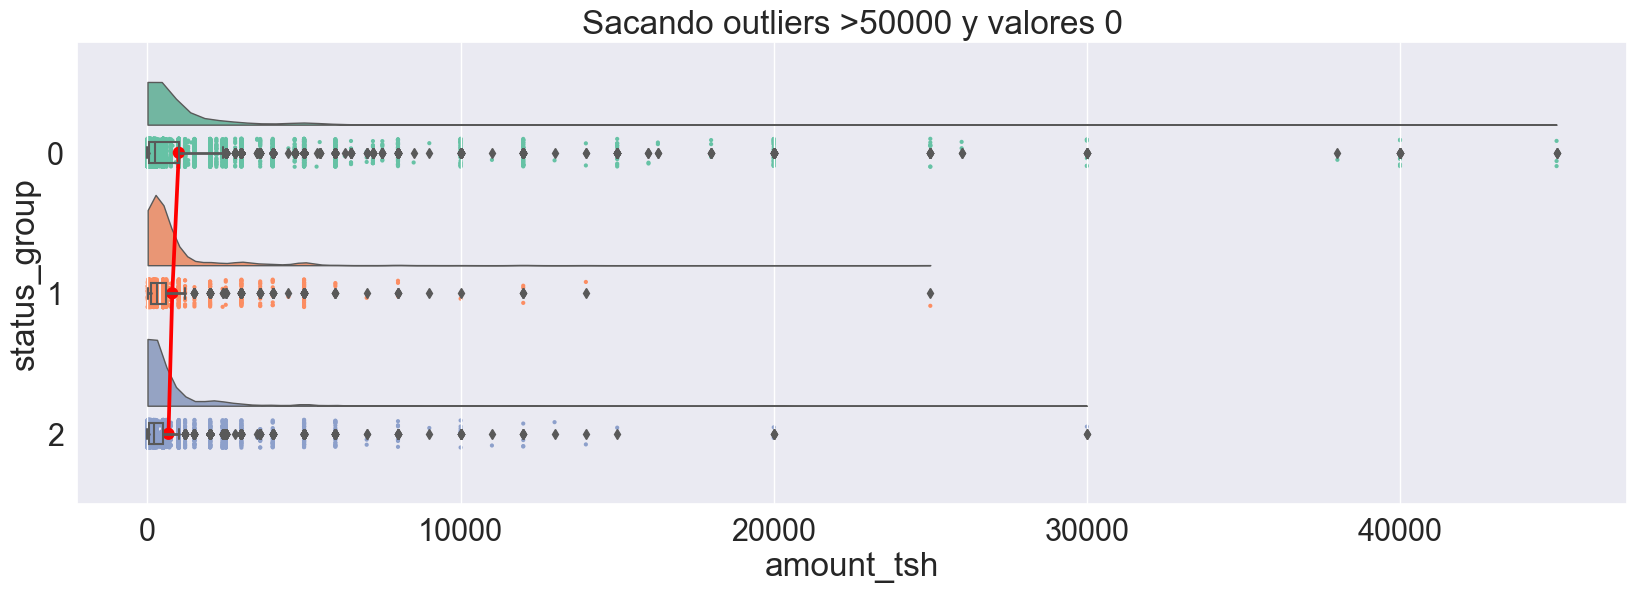

In [18]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[(df["amount_tsh"]<50000) & (df["amount_tsh"]!=0)],
             width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando outliers >50000 y valores 0")

Text(0.5, 1.0, 'Sacando outliers >10000 y valores 0')

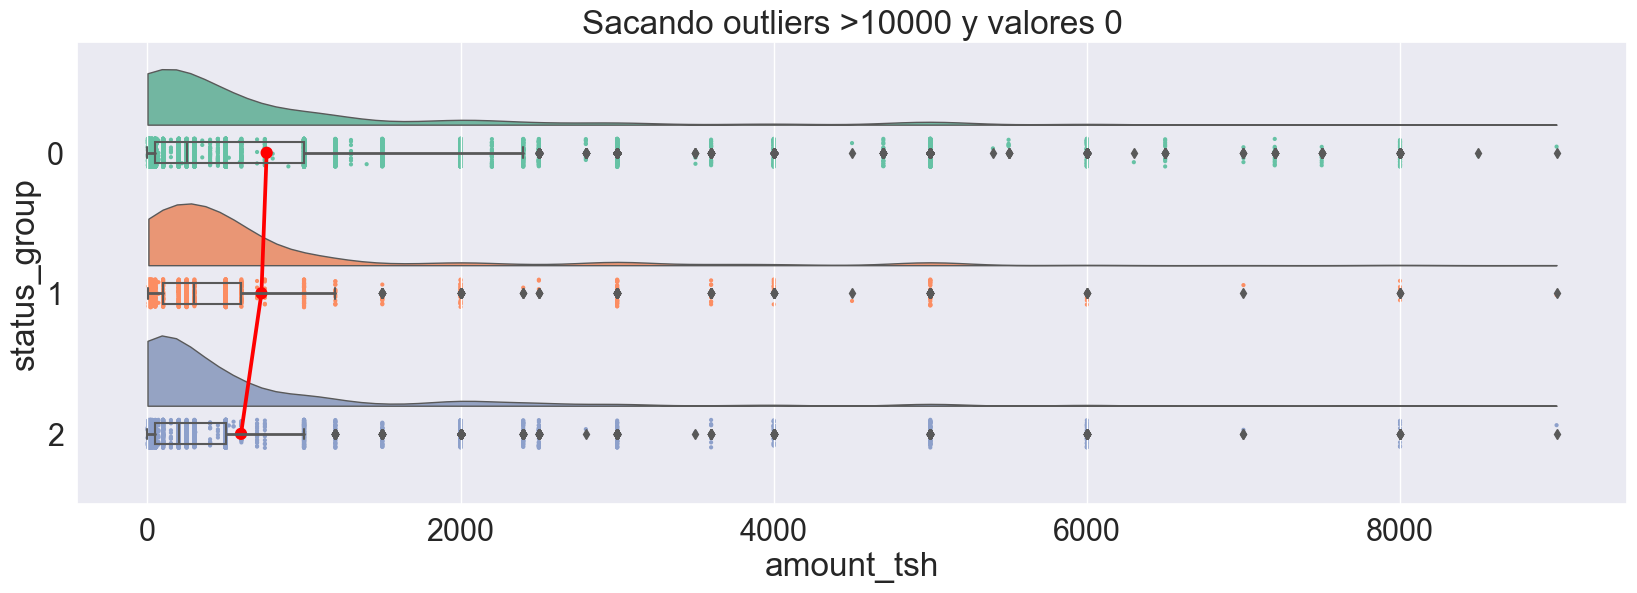

In [19]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[(df["amount_tsh"]<10000) & (df["amount_tsh"]!=0)],
             width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando outliers >10000 y valores 0")

Text(0.5, 1.0, 'Sacando valores >2000 y valores 0')

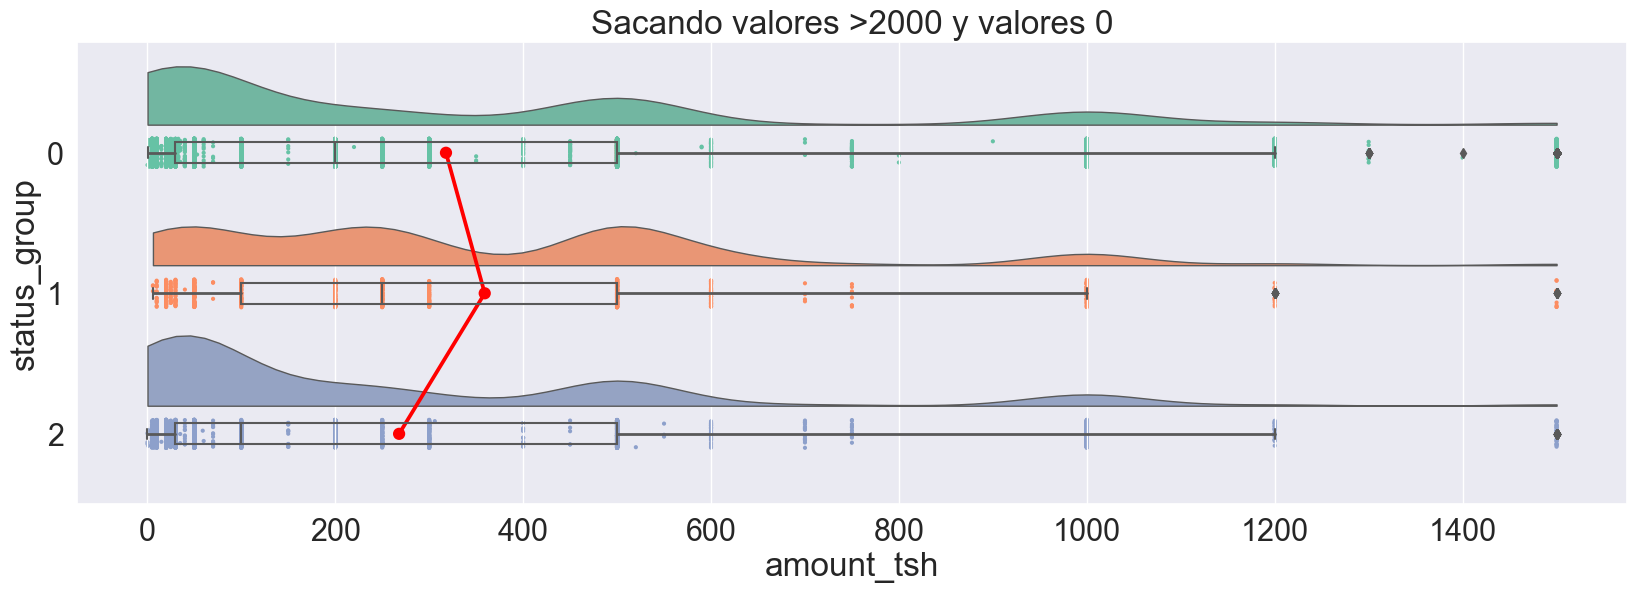

In [20]:
pt.RainCloud(x = "status_group", y = "amount_tsh", data = df[(df["amount_tsh"]<2000) & (df["amount_tsh"]!=0)],width_viol = 1,orient = "h",pointplot=True)
plt.title("Sacando valores >2000 y valores 0")

### Amount_tsh es una variable con una relación algo extraña con la objetivo, más adelante utilizaré el paquete de Python OptBinning para conseguir la forma de tramearla que maximice su Information Value

# gps_height

Text(0.5, 1.0, 'Distribución tal cual')

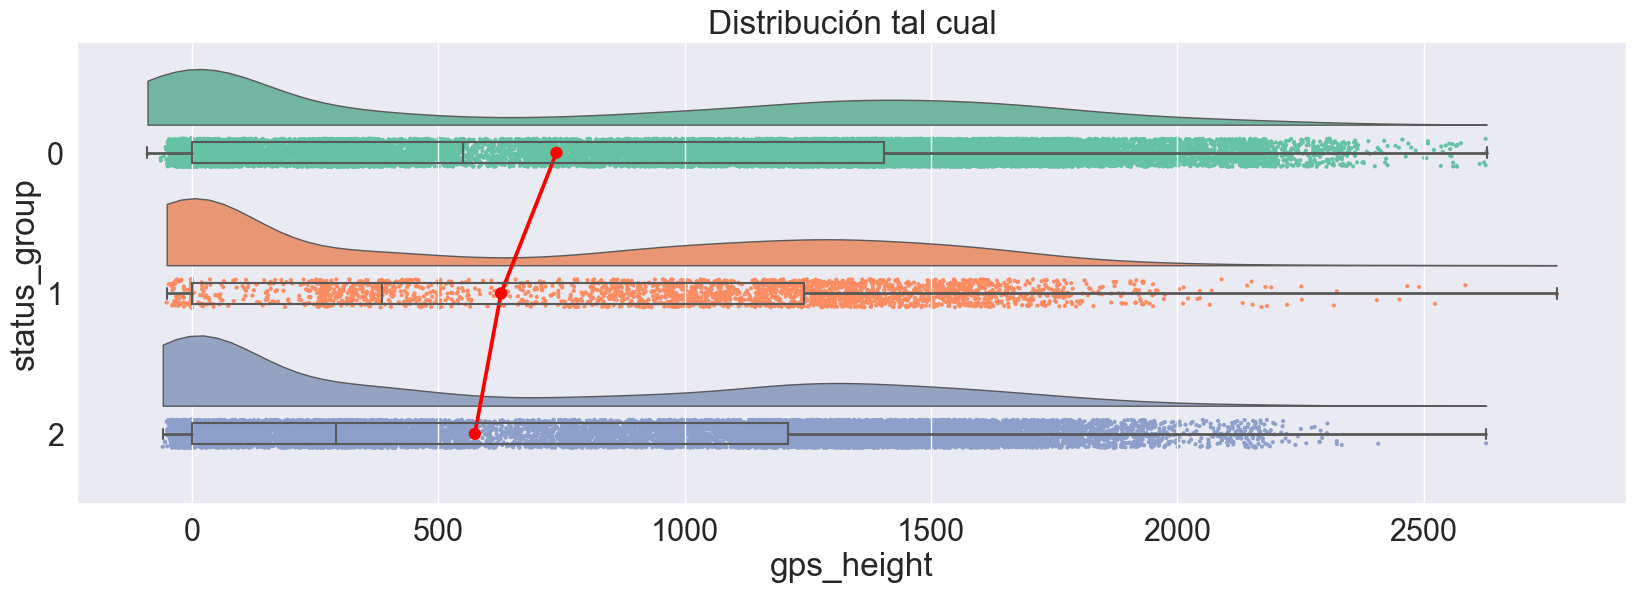

In [21]:
pt.RainCloud(x = "status_group", y = "gps_height", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

#### GPS_height sí parece ser una variable con capaciadad de aportarle poder predictivo al modelo sin necesidad de tramearla a mano. Igualmente se probará tramear con OptBinning a ver qué pasa


## Las variables latitud y longitud no sé qué tan bien se manejen dentro del modelo, las graficaré para ver qué pudiese hacer

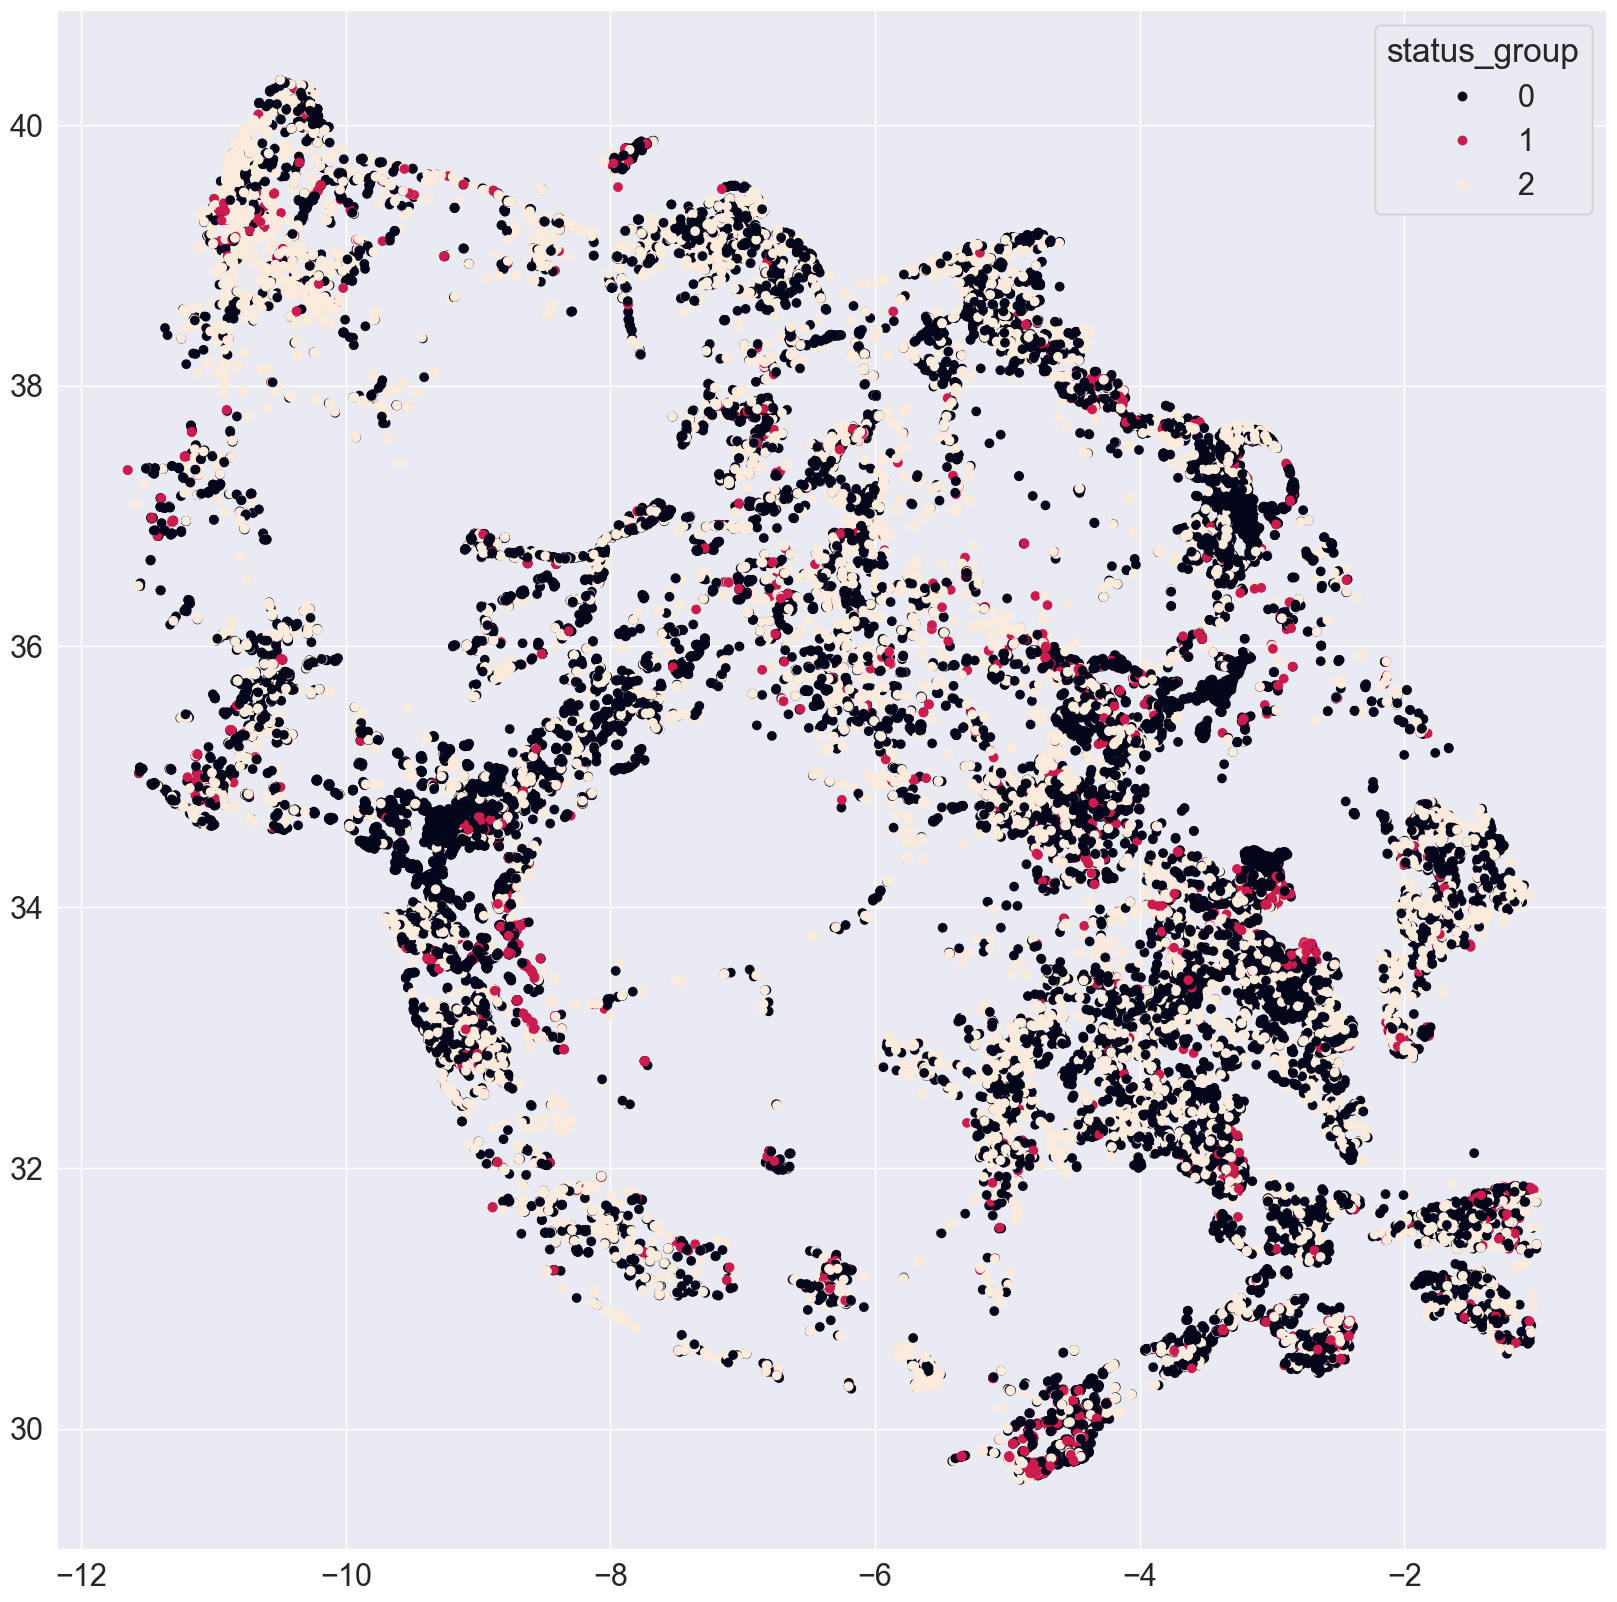

In [22]:
df_geo = df[["latitude","longitude","status_group"]].copy()
df_geo = df_geo[(df_geo["latitude"]!=0)&(df_geo["longitude"]!=0)]

fig,ax = plt.subplots(figsize=(20,20))
scatter = ax.scatter(x=df_geo.latitude,y=df_geo.longitude,c=df_geo.status_group)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="status_group")
ax.add_artist(legend1)
plt.savefig('Graphs/Latitudlongitud.pdf')  


### Después de mucha investigación, me llamó la atención la posibilidad de hacer clusters de localización con estas dos variables, así en vez de coordenadas latitud y longitud puedo haver n clusters que le proporcionen al modelo en teoría la misma información.

In [23]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [24]:
import joblib

In [25]:
df_geo.drop("status_group",axis=1,inplace=True)

### Lo que viene a continuación tarda demasiado tiempo y la primera vez lo hice (Jueves Santo) incluyendo status_group en el algoritmo, lo cual es por su puesto erróneo porque así no se pude transformar X_test

In [26]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

#Scaler = MinMaxScaler()
#df_geo.latitude = Scaler.fit_transform(df_geo.latitude.values.reshape(-1,1))
#df_geo.longitude = Scaler.fit_transform(df_geo.longitude.values.reshape(-1,1))

clustering = AgglomerativeClustering(linkage="ward", n_clusters=None,
                            distance_threshold = 0)
#clustering.fit(df_geo.to_numpy())

#joblib.dump(clustering, 'Models/LocationClustering.joblib')
clustering = joblib.load('Models/LocationClustering.joblib')

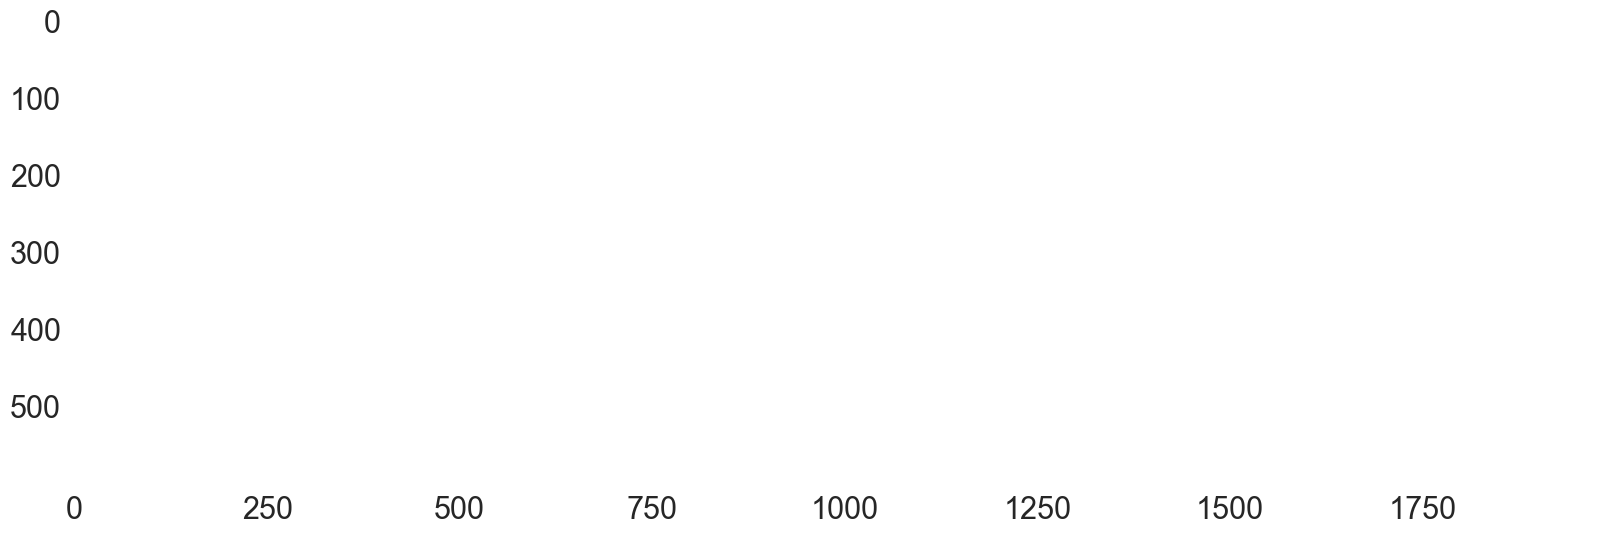

In [27]:
#jd.plot_dendogram(clustering)
#plt.savefig('Graphs/Dendograma_location.png')

Dendograma_location = plt.imread('Graphs/Dendograma_location.png')
plt.imshow(Dendograma_location)
plt.show()


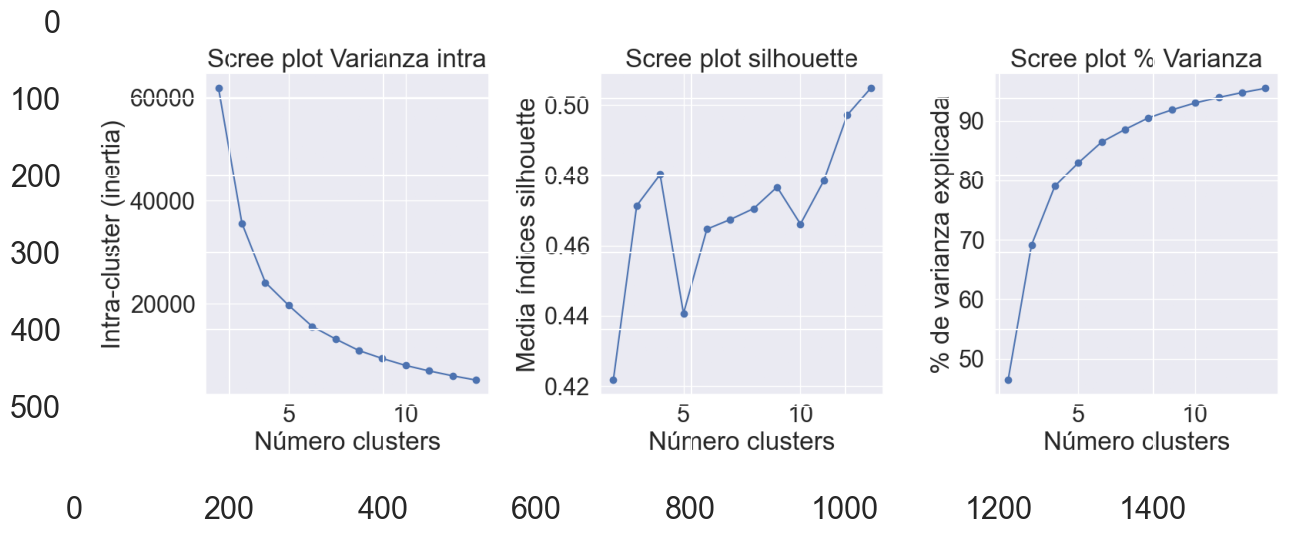

In [28]:
#jd.scree_plot_kmeans(df_geo,14)
#plt.savefig('Graphs/SkreePlot_location.png')
SkreePlot_location = plt.imread('Graphs/SkreePlot_location.png')
plt.imshow(SkreePlot_location)
plt.show()

In [29]:
#6-7 clusters parece ser la solución

In [30]:
from sklearn.cluster import KMeans

clustering = KMeans(n_clusters=7)
df_geo["location_cluster"] = clustering.fit_predict(df_geo)

In [31]:
X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())
X_test["location_cluster"] = clustering.predict(X_test[["latitude","longitude"]].to_numpy())

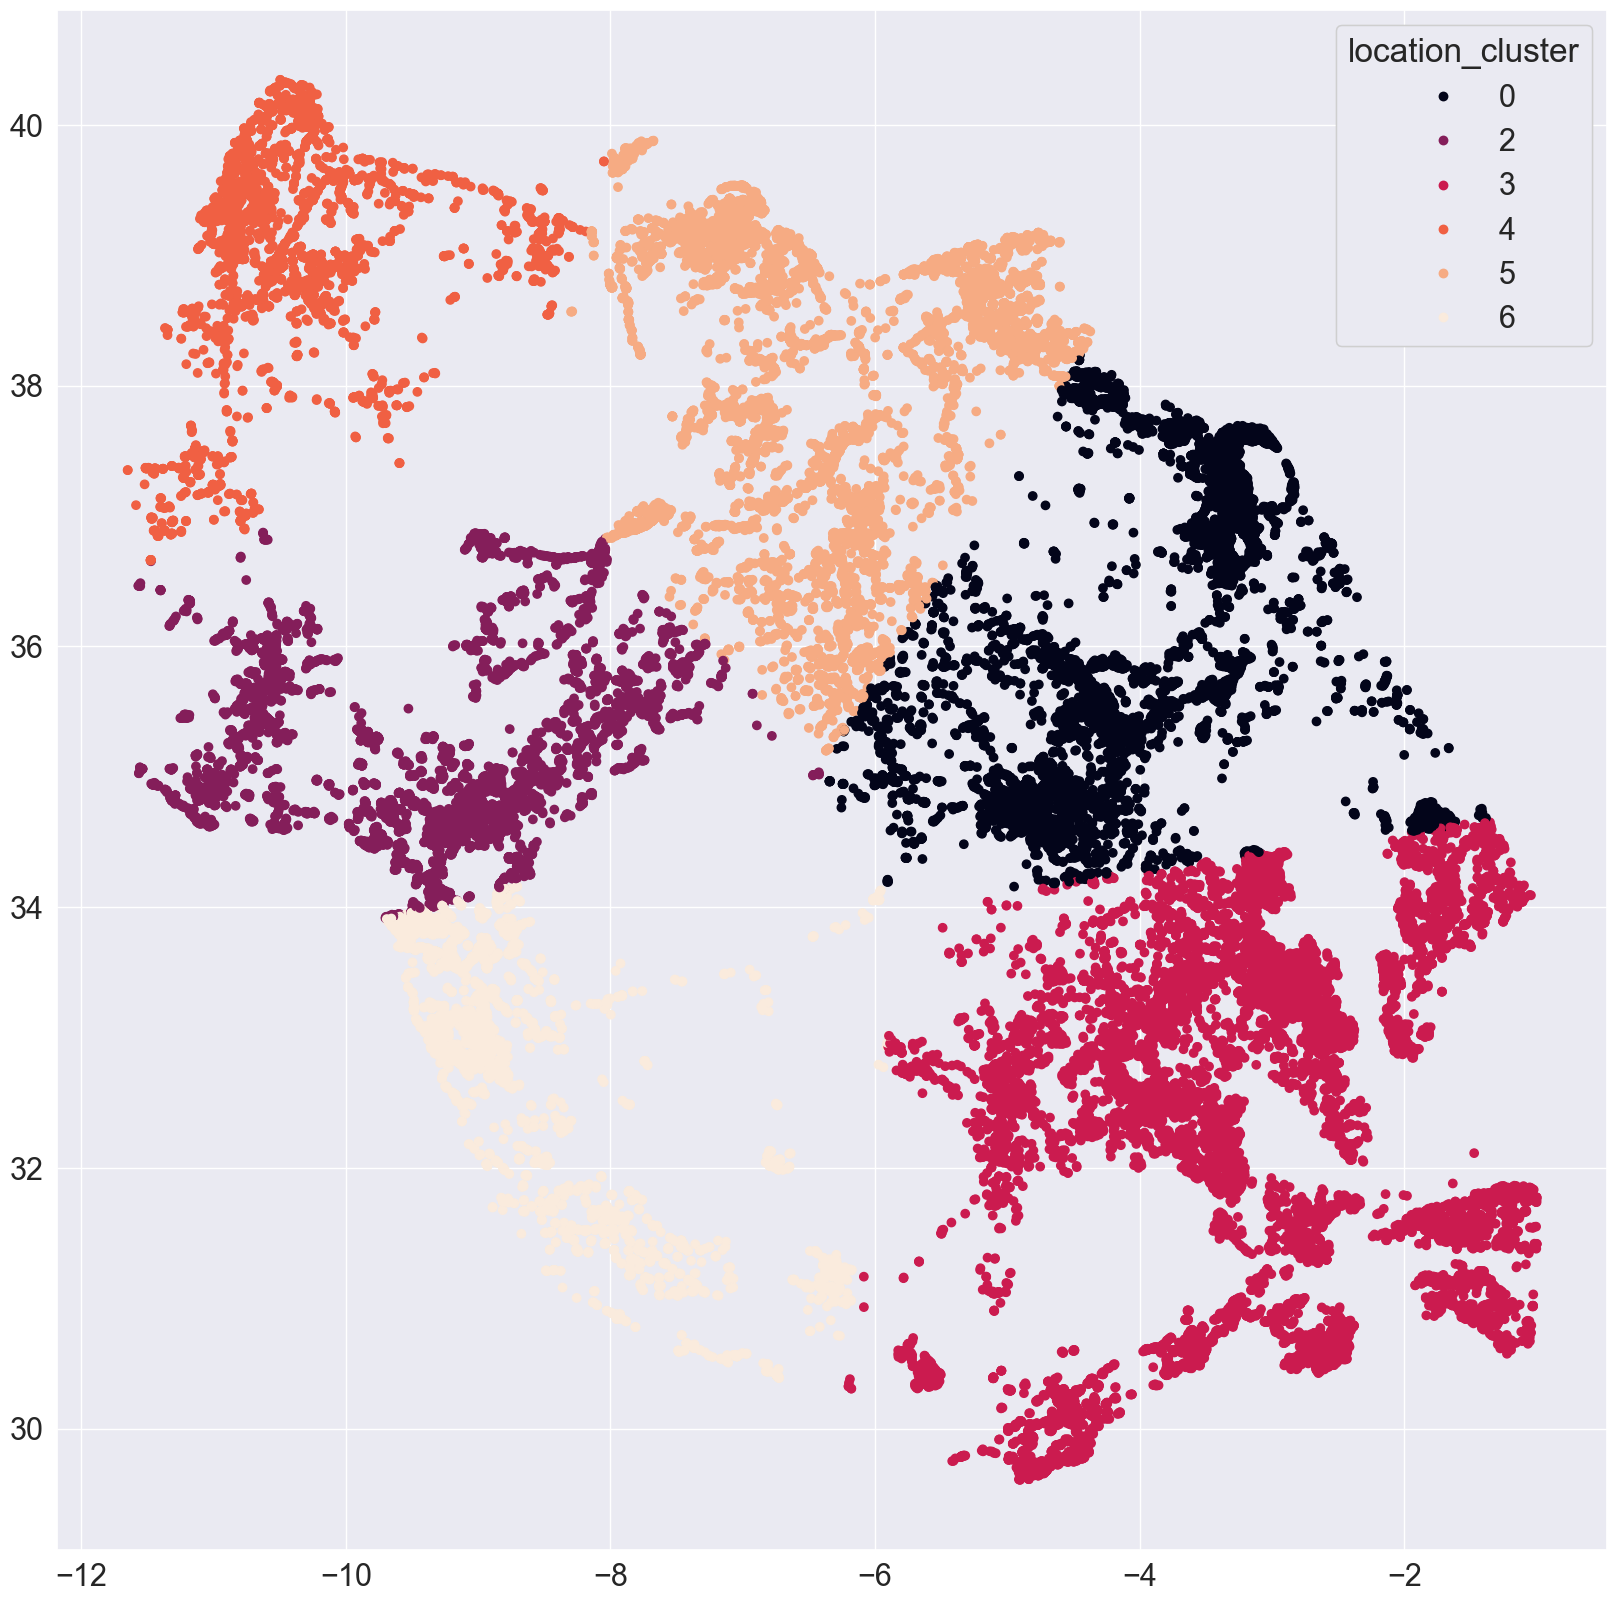

In [32]:
X_geo = X[["latitude","longitude","location_cluster"]].copy()
X_geo = X_geo[(X_geo["latitude"]!=0)&(X_geo["longitude"]!=0)]

fig,ax = plt.subplots(figsize=(20,20))
scatter = ax.scatter(x=X_geo.latitude,y=X_geo.longitude,c=X_geo.location_cluster)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="location_cluster")
ax.add_artist(legend1)
plt.savefig('Graphs/Latitudlongitud7Clusters.pdf')  


In [33]:
X_geo.isna().sum()

latitude            0
longitude           0
location_cluster    0
dtype: int64

In [34]:
X.drop(["longitude","latitude"],axis=1,inplace=True)
X_test.drop(["longitude","latitude"],axis=1,inplace=True)

In [35]:
X.to_csv("Out/XReemplazoLongitudeLatitudeConClusters.csv")
X_test.to_csv("Out/X_testReemplazoLongitudeLatitudeConClusters.csv")

In [36]:
X.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity

In [37]:
df_geo["location_cluster"]

0        1
1        6
2        0
3        5
4        2
        ..
59395    0
59396    1
59397    1
59398    3
59399    3
Name: location_cluster, Length: 57588, dtype: int32

In [38]:
#joblib.dump(clustering, 'Models/LocationClustering.joblib')
#LoadedClusterin = joblib.load('Models/LocationClustering.joblib')

### Num_private aunque es numérico parece que se comporta como una categórica, sólo tiene 65 valores únicos

una asociación con la objetiva de 0.007482267572645992, verdaderamente mísera


Text(0.5, 1.0, 'Distribución tal cual')

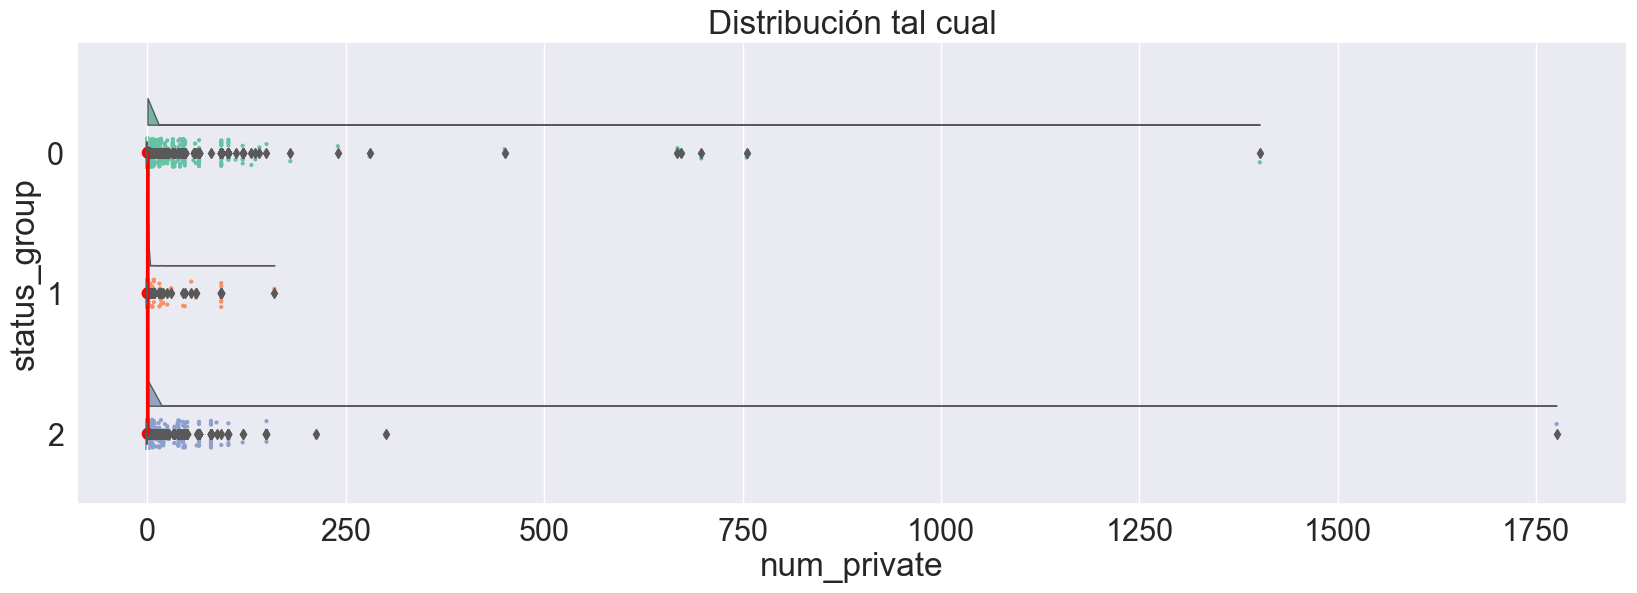

In [39]:
df.num_private = df.num_private.astype(int)
cramer = jd.cramers_v(df.num_private,df.status_group)
print(f"una asociación con la objetiva de {cramer}, verdaderamente mísera")
pt.RainCloud(x = "status_group", y = "num_private", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución tal cual")

# REGION CODE CATEGÓRICA O NUMÉRICA?: PROBABLEMENTE AMBOS REGION Y DISTRICT CODE SE COMPORTEN COMO VARIABLES CATEGÓRICAS

Text(0.5, 1.0, 'regioncode - status_group')

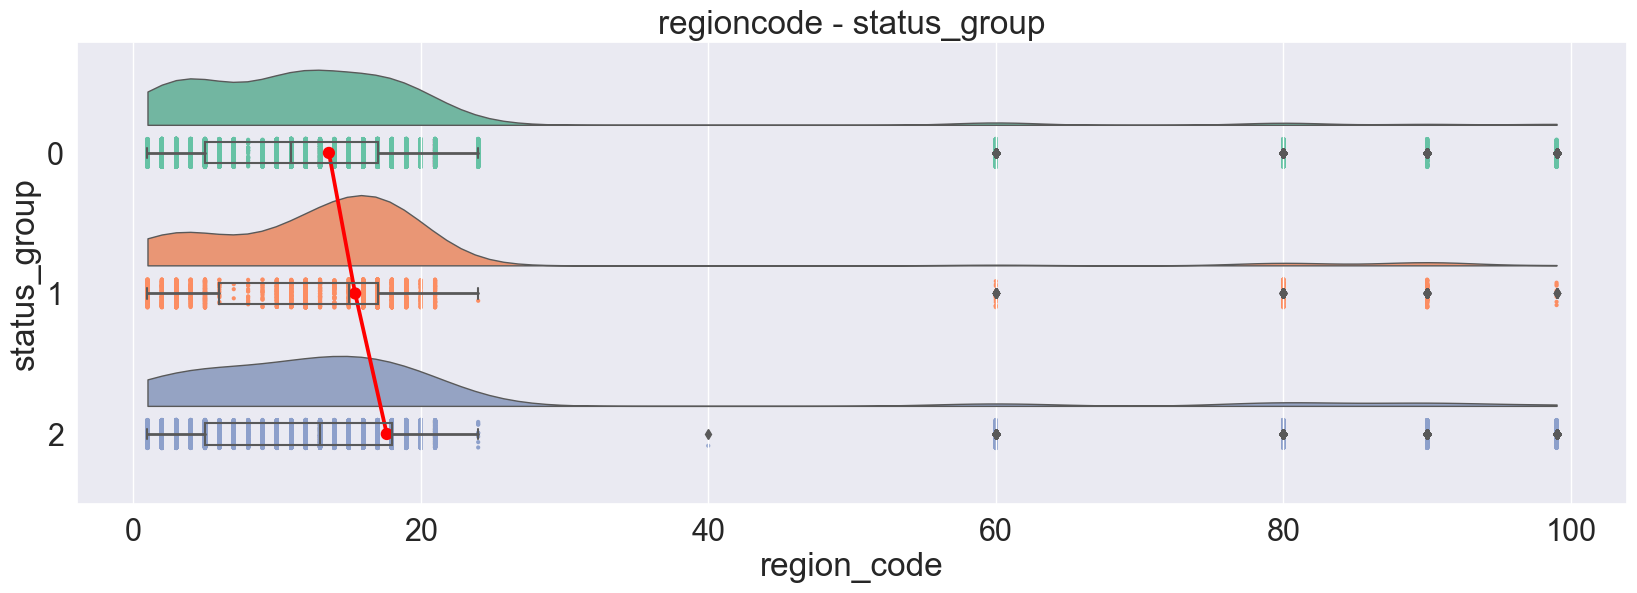

In [40]:
pt.RainCloud(x = "status_group", y = "region_code", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("regioncode - status_group")

Text(0.5, 1.0, 'district_code - status_group')

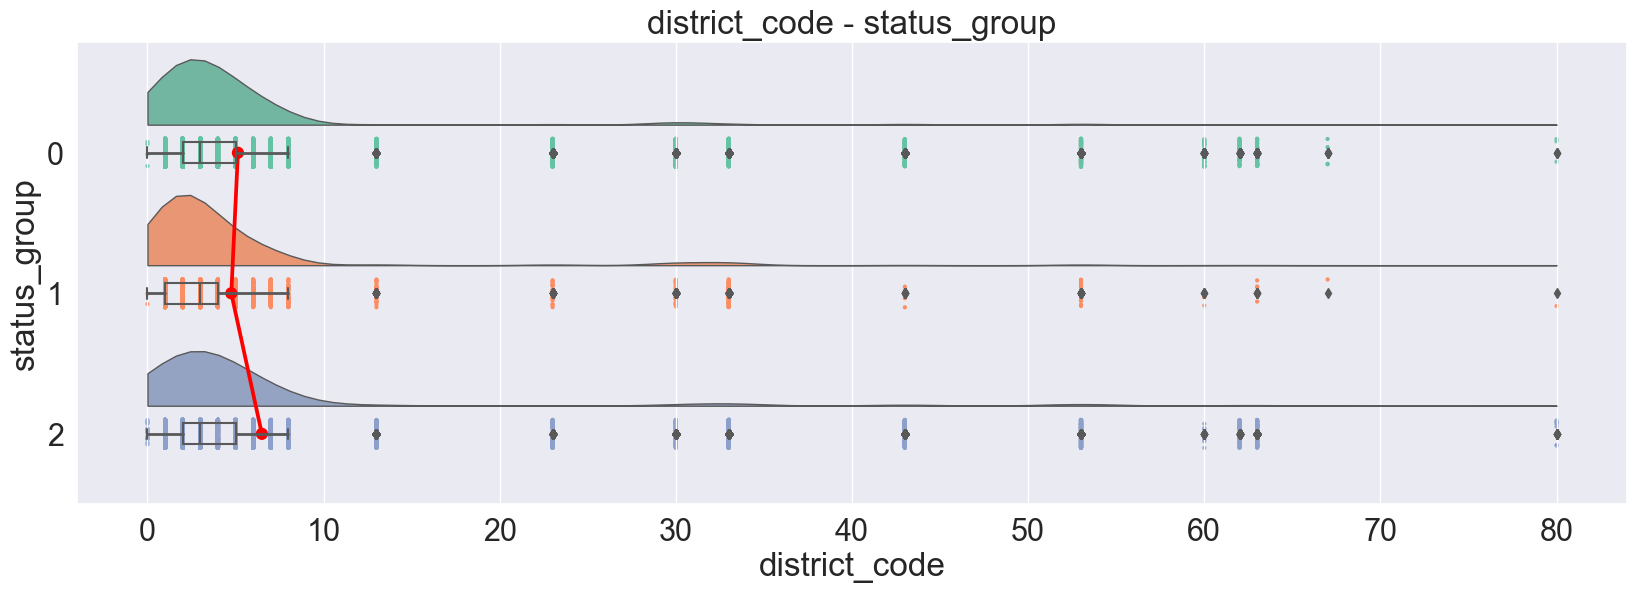

In [41]:
pt.RainCloud(x = "status_group", y = "district_code", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("district_code - status_group")

### Region y district code, dos variables que con todo el sentido del mundo deben de ser categóricas

no parece ser excesivamente buena esta variable, veamos su V de Cramer con la objetivo e investiguemos algo más

Con una relación cramer de {cramer}, esta variable no es nada impresionante, igual más adelante le haré binning para ver qué tal le va.


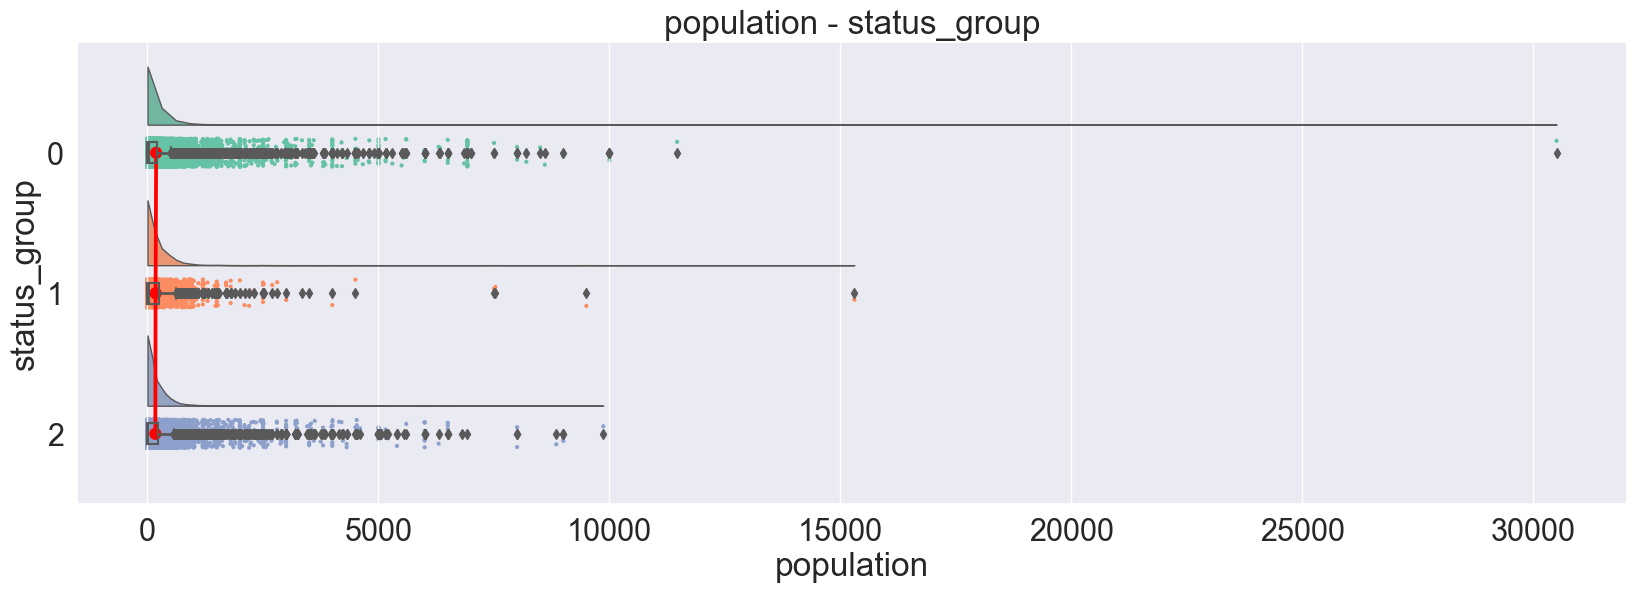

In [42]:
pt.RainCloud(x = "status_group", y = "population", data = df,width_viol = 1,orient = "h",pointplot=True)
plt.title("population - status_group")
print("no parece ser excesivamente buena esta variable, veamos su V de Cramer con la objetivo e investiguemos algo más")
cramer = jd.cramers_v(df.population,df.status_group)
print()
print("Con una relación cramer de {cramer}, esta variable no es nada impresionante, igual más adelante le haré binning para ver qué tal le va.")

Text(0.5, 1.0, 'Distribución con valores menores a 5mil')

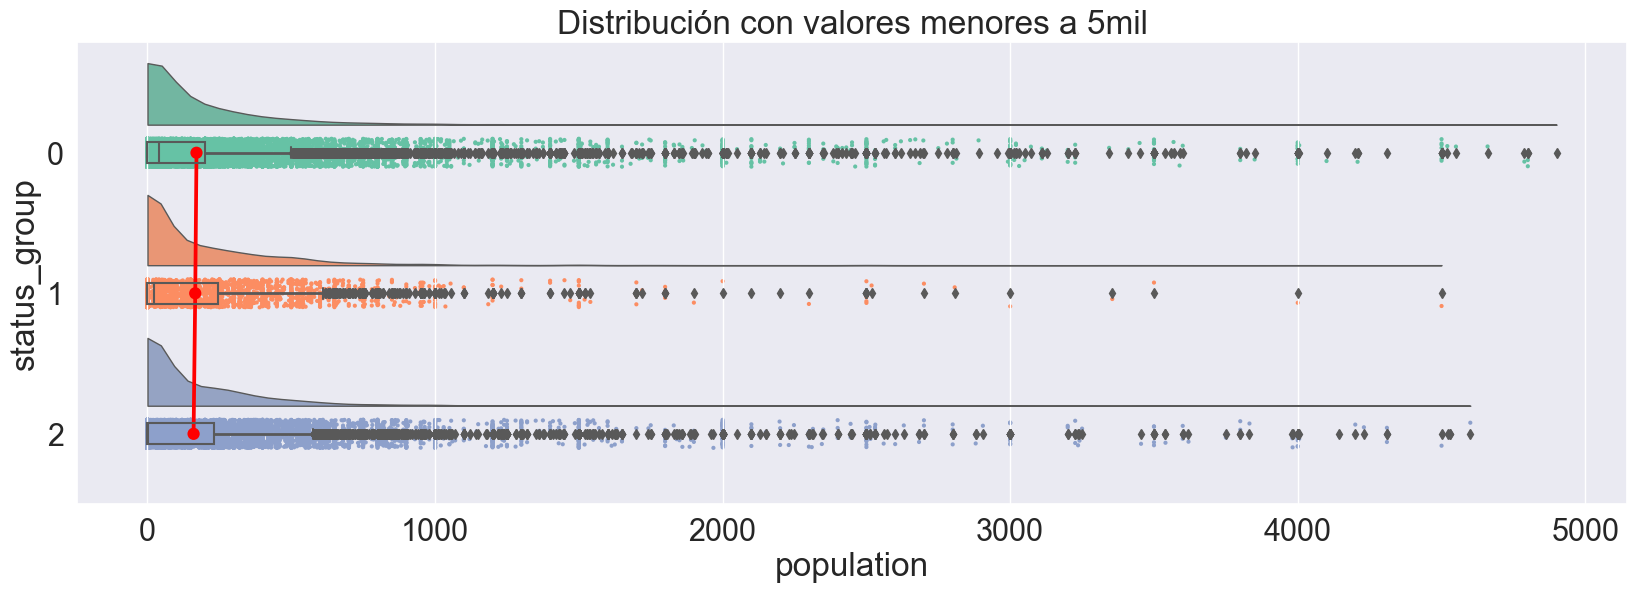

In [43]:
pt.RainCloud(x = "status_group", y = "population", data = df[df["population"]<5000],width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución con valores menores a 5mil")

Text(0.5, 1.0, 'Distribución con valores menores a mil')

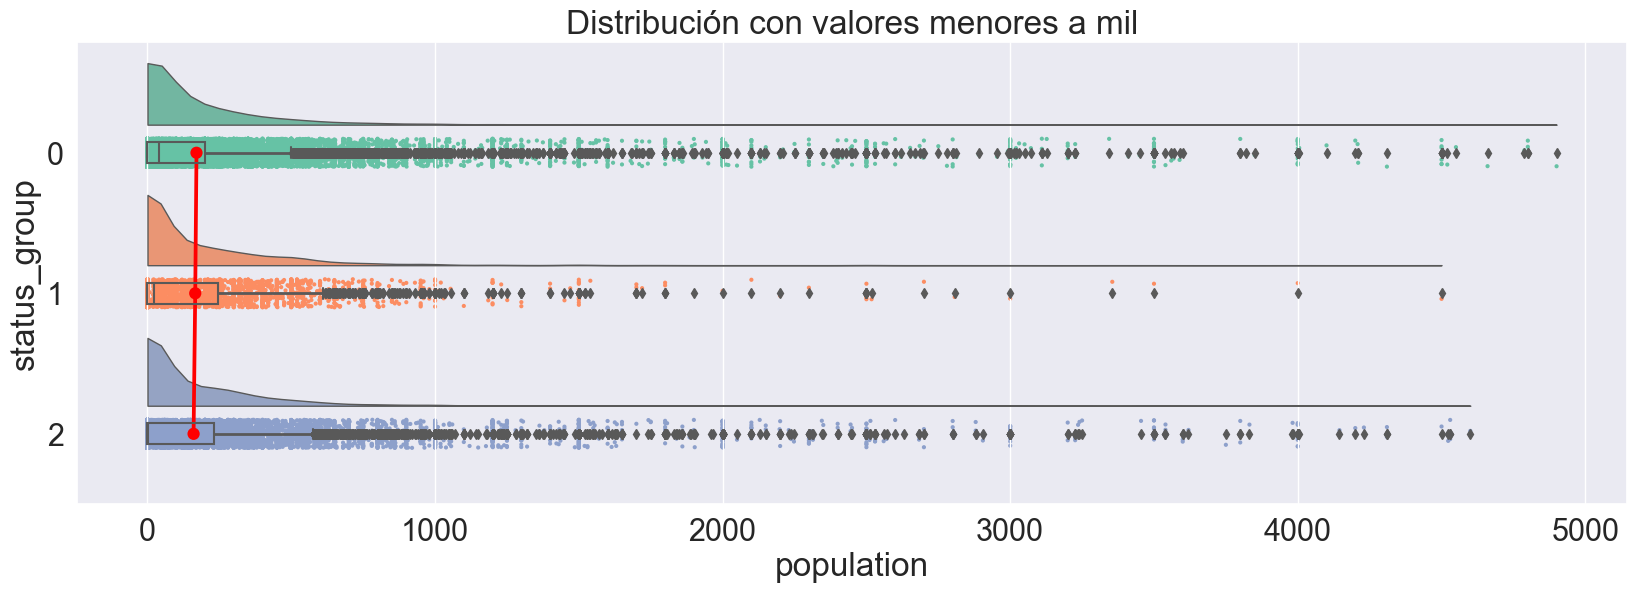

In [44]:
pt.RainCloud(x = "status_group", y = "population", data = df[df["population"]<5000],width_viol = 1,orient = "h",pointplot=True)
plt.title("Distribución con valores menores a mil")

### Variable temporal construction_year, por supuesto será posteriormente pasado a continua en días y posiblemente trameada

<AxesSubplot: xlabel='construction_year'>

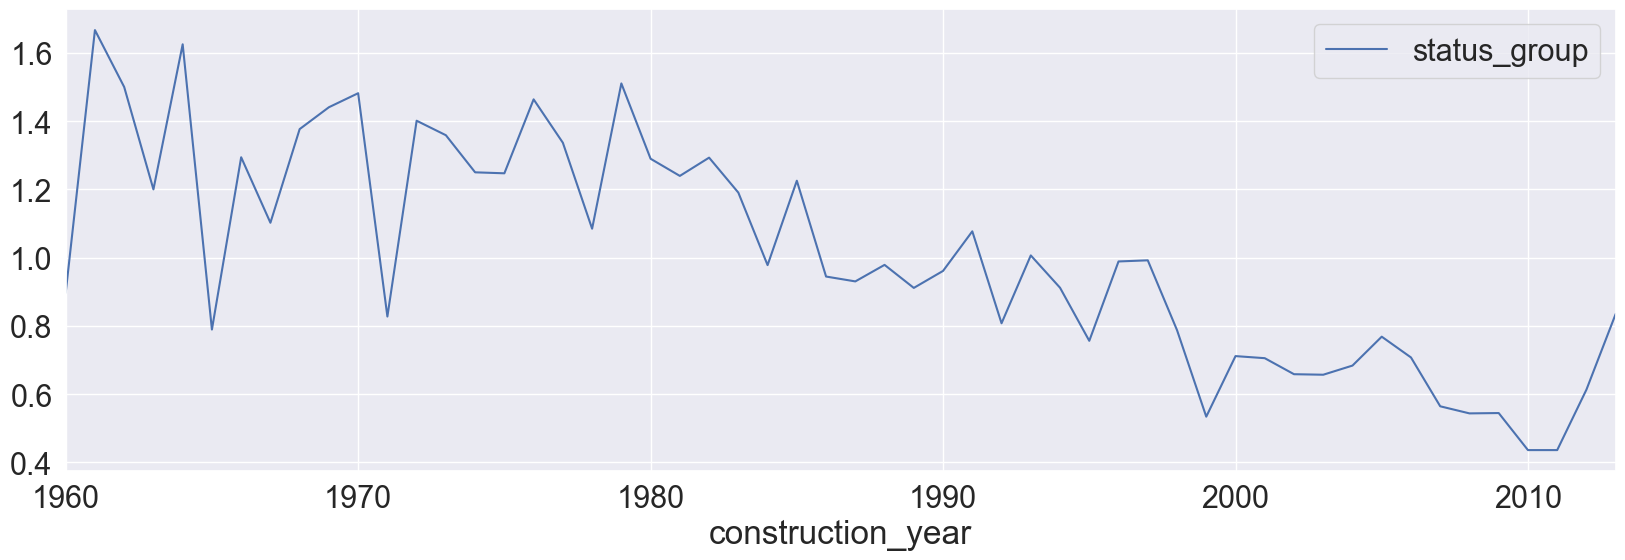

In [45]:
df_temp = df[["construction_year","status_group"]]

df_temp.construction_year = df_temp.construction_year.apply(lambda x: x if x!= 0 else 1960)
df_temp.construction_year = pd.to_datetime(df_temp.construction_year, format='%Y')#.dt.year
df_temp.groupby("construction_year").mean().plot()

In [46]:
df.construction_year # Construido en year 0?

0        1999
1        2010
2        2009
3        1986
4           0
         ... 
59395    1999
59396    1996
59397       0
59398       0
59399    2002
Name: construction_year, Length: 59400, dtype: int64

In [47]:
df.select_dtypes(include=np.number).columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year', 'status_group', 'random', 'random2'],
      dtype='object')

In [48]:
df.select_dtypes(exclude=np.number).columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

# AHORA LAS VARIABLES CATEGÓRICAS: empezaré usando optbinning


In [49]:
#optb = MulticlassOptimalBinning(max_n_bins=None,max_pvalue=0.10).fit(df.funder,df.status_group)
#ValueError: x array after removing special codes and missing values must be numerical.


## Al parecer OptBinning sólo tiene implementación para hacer agrupaciones de variables categóricas cuando el target es binario :(

In [50]:
df.select_dtypes(include=np.number).columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year', 'status_group', 'random', 'random2'],
      dtype='object')

In [51]:
df.select_dtypes(exclude=np.number).columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

## pruebo un flujo de datos para ver qué problemas encuentro

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [53]:
y
y = le.fit_transform(y.status_group)

In [54]:
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()
num_cols.remove("id")
preprocessing = ColumnTransformer([
    ('target_enc', TargetEncoder(), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)
X_transformed = preprocessing.fit_transform(X,y=y)
transformed_columns = preprocessing.get_feature_names_out()

# Create DataFrame from transformed data
X_transformed = pd.DataFrame(data=X_transformed, columns=transformed_columns)
X_transformed

target_enc__date_recorded  target_enc__funder  target_enc__installer  \
0                       0.665385            0.323636               0.712844   
1                       0.681820            0.393857               0.377101   
2                       0.790614            0.646454               0.558824   
3                       1.162234            0.771050               0.887387   
4                       0.991667            0.731719               0.844444   
...                          ...                 ...                    ...   
59395                   0.821622            0.234426               0.234426   
59396                   0.687712            0.357963               0.523589   
59397                   1.025478            0.789821               0.785226   
59398                   0.759146            0.711231               0.833653   
59399                   0.870504            1.120089               0.892560   

       target_enc__wpt_name  target_enc__basin  target_enc__subvillage  \
0                  0.502386           0.643461                0.740705   
1                  0.869880           0.908177                0.687712   
2                  0.711231           0.744855                0.996016   
3                  0.991936           1.184064                0.933789   
4                  0.935355           0.908177                0.721842   
...                     ...                ...                     ...   
59395              0.731719           0.744855                0.699862   
59396              0.731719           0.674398                0.543101   
59397              0.926299           0.674398                0.721842   
59398              0.731719           0.674398                1.011092   
59399              0.731719           0.907466                0.731719   

       target_enc__region  target_enc__lga  target_enc__ward  \
0                0.412354         0.430851          0.765313   
1                1.069578         0.777933          0.747053   
2                0.692356         0.821429          0.668727   
3                1.321387         1.468354          1.443561   
4                0.866707         0.880674          0.664150   
...                   ...              ...               ...   
59395            0.720712         0.252800          0.051778   
59396            0.412354         0.358769          0.612218   
59397            0.891571         0.792332          1.079280   
59398            0.988187         1.086455          0.964930   
59399            0.867199         0.932821          0.997143   

       target_enc__public_meeting  ...  target_enc__waterpoint_type_group  \
0                        0.813295  ...                           0.763032   
1                        0.946611  ...                           0.763032   
2                        0.813295  ...                           0.763032   
3                        0.813295  ...                           0.763032   
4                        0.813295  ...                           0.763032   
...                           ...  ...                                ...   
59395                    0.813295  ...                           0.763032   
59396                    0.813295  ...                           0.763032   
59397                    0.813295  ...                           0.705455   
59398                    0.813295  ...                           0.705455   
59399                    0.813295  ...                           0.705455   

       scaler__amount_tsh  scaler__gps_height  scaler__num_private  \
0                1.895665            1.041252            -0.038749   
1               -0.105970            1.054237            -0.038749   
2               -0.097630            0.025541            -0.038749   
3               -0.105970           -0.584751            -0.038749   
4               -0.105970           -0.964200            -0.038749   
...                   ...                 ...          

In [55]:
X_transformed

target_enc__date_recorded  target_enc__funder  target_enc__installer  \
0                       0.665385            0.323636               0.712844   
1                       0.681820            0.393857               0.377101   
2                       0.790614            0.646454               0.558824   
3                       1.162234            0.771050               0.887387   
4                       0.991667            0.731719               0.844444   
...                          ...                 ...                    ...   
59395                   0.821622            0.234426               0.234426   
59396                   0.687712            0.357963               0.523589   
59397                   1.025478            0.789821               0.785226   
59398                   0.759146            0.711231               0.833653   
59399                   0.870504            1.120089               0.892560   

       target_enc__wpt_name  target_enc__basin  target_enc__subvillage  \
0                  0.502386           0.643461                0.740705   
1                  0.869880           0.908177                0.687712   
2                  0.711231           0.744855                0.996016   
3                  0.991936           1.184064                0.933789   
4                  0.935355           0.908177                0.721842   
...                     ...                ...                     ...   
59395              0.731719           0.744855                0.699862   
59396              0.731719           0.674398                0.543101   
59397              0.926299           0.674398                0.721842   
59398              0.731719           0.674398                1.011092   
59399              0.731719           0.907466                0.731719   

       target_enc__region  target_enc__lga  target_enc__ward  \
0                0.412354         0.430851          0.765313   
1                1.069578         0.777933          0.747053   
2                0.692356         0.821429          0.668727   
3                1.321387         1.468354          1.443561   
4                0.866707         0.880674          0.664150   
...                   ...              ...               ...   
59395            0.720712         0.252800          0.051778   
59396            0.412354         0.358769          0.612218   
59397            0.891571         0.792332          1.079280   
59398            0.988187         1.086455          0.964930   
59399            0.867199         0.932821          0.997143   

       target_enc__public_meeting  ...  target_enc__waterpoint_type_group  \
0                        0.813295  ...                           0.763032   
1                        0.946611  ...                           0.763032   
2                        0.813295  ...                           0.763032   
3                        0.813295  ...                           0.763032   
4                        0.813295  ...                           0.763032   
...                           ...  ...                                ...   
59395                    0.813295  ...                           0.763032   
59396                    0.813295  ...                           0.763032   
59397                    0.813295  ...                           0.705455   
59398                    0.813295  ...                           0.705455   
59399                    0.813295  ...                           0.705455   

       scaler__amount_tsh  scaler__gps_height  scaler__num_private  \
0                1.895665            1.041252            -0.038749   
1               -0.105970            1.054237            -0.038749   
2               -0.097630            0.025541            -0.038749   
3               -0.105970           -0.584751            -0.038749   
4               -0.105970           -0.964200            -0.038749   
...                   ...                 ...          

In [56]:
rf = RandomForestClassifier()
rf.fit(X_transformed,y)

RandomForestClassifier()

In [57]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train, y_test = train_test_split(X_transformed,y)

In [58]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


## Batería de modelos a ver cuál me da el mejor accuracy (métrica usada por la competencia)

In [59]:
r = 23 #Fijamos la aleatoriedad

#Diccionario con todos los modelos
Modelos = {
    'Reg_Log': LogisticRegression(random_state=r),
    'SGD': SGDClassifier(random_state=r),
    'Perceptron': Perceptron(random_state=r),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM_rbf': SVC(random_state=r),
    #'SVM_poly': SVC(kernel='poly', random_state=r),
    #'SVM_sigmoid': SVC(kernel='sigmoid', random_state=r),
    'SVM_linear': LinearSVC(random_state=r),
    'KNeighbors': KNeighborsClassifier(),
    'Gauss_Naive': GaussianNB(),
    'Tree': DecisionTreeClassifier(random_state=r),
    'RF': RandomForestClassifier(random_state=r),
    'Extra_Tree': ExtraTreesClassifier(random_state=r),
    'AdaBoost': AdaBoostClassifier(random_state=r),
    'GradBoost': GradientBoostingClassifier(random_state=r),
    'GradBoost_NB': GradientBoostingClassifier(random_state=r,init=GaussianNB()),
    'GradBoost_LogReg': GradientBoostingClassifier(random_state=r,init=LogisticRegression()),
    'MLP': MLPClassifier(random_state=r),
}

#Dataframe de métricas
metrics2 = pd.DataFrame(columns=['Modelo','Accuracy','Balanced_Accuracy'])

#Entrenamos y evaluamos cada modelo mediante validación cruzada estratificada (por defecto) con 10 divisiones
"""
for nom, mod in Modelos.items():
    print(nom)
    results = cross_validate(mod, X_transformed, y, cv=5, scoring=(['accuracy','balanced_accuracy']))
   
    #Añadimos al dataframe de métricas el nombre y la media de cada métrica en las 10 evaluaciones para cada modelo
    metrics2 = pd.concat([metrics2, pd.DataFrame([{
        'Modelo': nom,
        'Accuracy': results['test_accuracy'].mean(),
        'Balanced_Accuracy': results['test_balanced_accuracy'].mean()
    }])], ignore_index=True)
"""


"\nfor nom, mod in Modelos.items():\n    print(nom)\n    results = cross_validate(mod, X_transformed, y, cv=5, scoring=(['accuracy','balanced_accuracy']))\n   \n    #Añadimos al dataframe de métricas el nombre y la media de cada métrica en las 10 evaluaciones para cada modelo\n    metrics2 = pd.concat([metrics2, pd.DataFrame([{\n        'Modelo': nom,\n        'Accuracy': results['test_accuracy'].mean(),\n        'Balanced_Accuracy': results['test_balanced_accuracy'].mean()\n    }])], ignore_index=True)\n"

## Vemos muchas métricas, pero a efectos de la competencia sólo nos interesa el accuracy

In [60]:
#metrics2 = metrics2[["Modelo","Accuracy","Balanced_Accuracy"]].sort_values(by="Accuracy",ascending=False)
#metrics2.to_pickle('DataFrames/1eraBateriaModelos.pkl')
metrics2 = pd.read_pickle('DataFrames/1eraBateriaModelos.pkl')
metrics2

Modelo  Accuracy  Balanced_Accuracy
13         GradBoost  0.929192           0.855513
15  GradBoost_LogReg  0.927374           0.849963
10                RF  0.925522           0.850585
12          AdaBoost  0.912088           0.812595
11        Extra_Tree  0.899343           0.788877
9               Tree  0.895337           0.840311
3                LDA  0.839714           0.660664
8        Gauss_Naive  0.701448           0.481003
4                QDA  0.684714           0.669010
6         SVM_linear  0.620101           0.461617
0            Reg_Log  0.543098           0.333348
5            SVM_rbf  0.543081           0.333333
14      GradBoost_NB  0.529882           0.436809
2         Perceptron  0.511279           0.333328
1                SGD  0.511195           0.334218
7         KNeighbors  0.503889           0.341937
16               MLP  0.488822           0.395268

### RF da un accuracy de 0.92, pero en el test oficial el score es menor, eso se debe probablemente a que el target está desbalanceado y en el test aparece frecuentemente una de las etiquetas desbalanceadas.

### Después de hacer tres submissions de prueba utilizando en cada uno, una sola categoría me di cuenta que el balanceo de los targets del test es exactamente igual al que recibimos en las training labels.

In [61]:
drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]
le = LabelEncoder()
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
y = le.fit_transform(y.status_group)
X_test = pd.read_csv("In/Test_set_values.csv")

X.drop(drop_list,axis=1,inplace=True)
X_test.drop(drop_list,axis=1,inplace=True)


for i in X.select_dtypes(include = "O").columns:
    X[i] = df[i].astype("category")

## Pruebo con un cross_validate de SKLearn el número óptimo de clusters de localizaión, gana latitud y longitud completa y de segundo 20 clusters, en la mayoría de las submissions dejo tanto los 20 clusters como las variables continuas porque al tratarse de un random forest esto no debe traer problemas.

In [62]:
metrics = pd.DataFrame(columns=['Clusters','Accuracy','Balanced_Accuracy'])
for num_clusts in ["cont",7,9,10,16,20]:
    print(num_clusts)

    if num_clusts != "cont":
        clustering = KMeans(n_clusters=num_clusts)
        X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())

    cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    num_cols.remove("id")
    if num_clusts != "cont":
        num_cols.remove("latitude")
        num_cols.remove("longitude")
    preprocessing = ColumnTransformer([
        ('target_enc', OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=10000000,
                                  encoded_missing_value =10000000), cat_cols),  
        ('scaler', StandardScaler(), num_cols),  
    ],
    remainder = "passthrough",
    )
    if num_clusts != "cont":
        
        X_transformed = preprocessing.fit_transform(X.drop(["latitude","longitude"],axis=1,inplace=False),y=y)
    else:
        X_transformed = preprocessing.fit_transform(X,y=y)


    transformed_columns = preprocessing.get_feature_names_out()

    # Create DataFrame from transformed data
    X_transformed = pd.DataFrame(data=X_transformed, columns=transformed_columns)
    gradBoost = GradientBoostingClassifier(random_state=23)

    """
    results = cross_validate(gradBoost, X_transformed, y, cv=4, scoring=(['accuracy','balanced_accuracy']),n_jobs=-1)
    metrics = pd.concat([metrics, pd.DataFrame([{
        'Clusters': f"Con {str(num_clusts)} clusters",
        'Accuracy': results['test_accuracy'].mean(),
        'Balanced_Accuracy': results['test_balanced_accuracy'].mean()
    }])], ignore_index=True)
    """

cont
7
9
10
16
20


In [63]:
#metrics = metrics.sort_values(by="Accuracy",ascending=False)
#metrics.to_pickle('DataFrames/Num_ClustsGradBoost_BateriaModelos.pkl')
metrics = pd.read_pickle('DataFrames/Num_ClustsGradBoost_BateriaModelos.pkl')
metrics

Clusters  Accuracy  Balanced_Accuracy
0  Con cont clusters  0.753384           0.560199
5    Con 20 clusters  0.752710           0.553575
4    Con 16 clusters  0.752559           0.554882
3    Con 10 clusters  0.752475           0.555604
2     Con 9 clusters  0.752374           0.557475
1     Con 7 clusters  0.751667           0.553283

## EL trabajo de limpieza y análisis de categóricas que había hecho se me borró por un error de subir a github sin haber guardado correctamente este archivo, al hacer git pull se fue toda la limpieza.

# :(

## Por su puesto lo vuelvo a hacer, esta vez algo mejor.


In [64]:
# El resultado de la limpieza, el "drop_list", igualmente quedó guardado en el otro archivo en esta lista.


## La limpieza comienza con un campo de valor único.

In [65]:
#drop recorded_by
[(x,y) for (x,y) in df.nunique().items() if y==1]

[('recorded_by', 1)]

### Limpio el campo en formato fecha

In [66]:
df.date_recorded = df.date_recorded.astype("O")
df.date_recorded = pd.to_datetime(df.date_recorded)
df.date_recorded.max()
df['date_recorded'] = (df.date_recorded.max() -df.date_recorded).dt.days
df['date_recorded']

0         995
1         272
2         281
3         309
4         874
         ... 
59395     214
59396     941
59397     967
59398    1001
59399     986
Name: date_recorded, Length: 59400, dtype: int64

# Tiene unos cuantos aparentes outliers, pruebo sacarlos mucho más adelante

Asociación con la objetivo: 0.03466752163433419


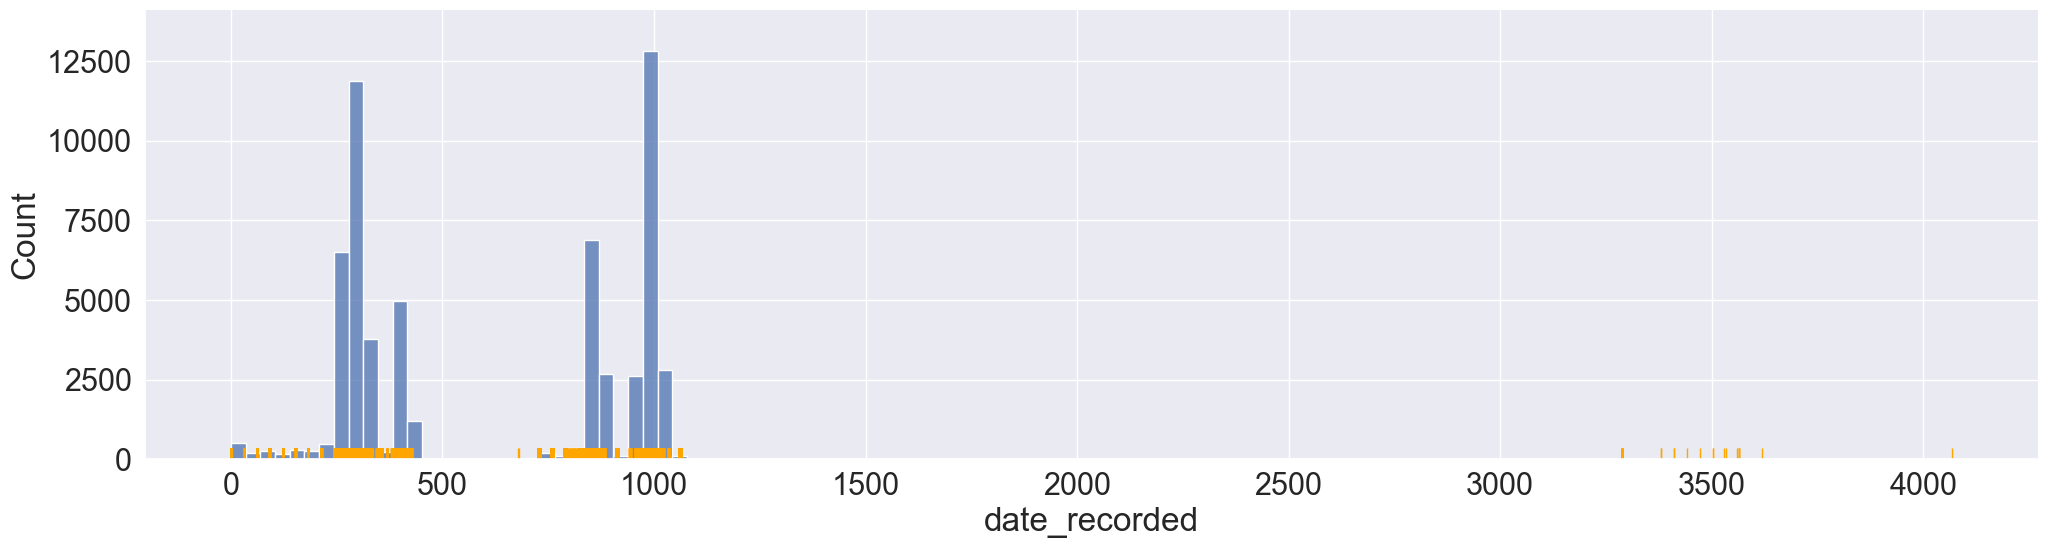

<AxesSubplot: xlabel='date_recorded'>

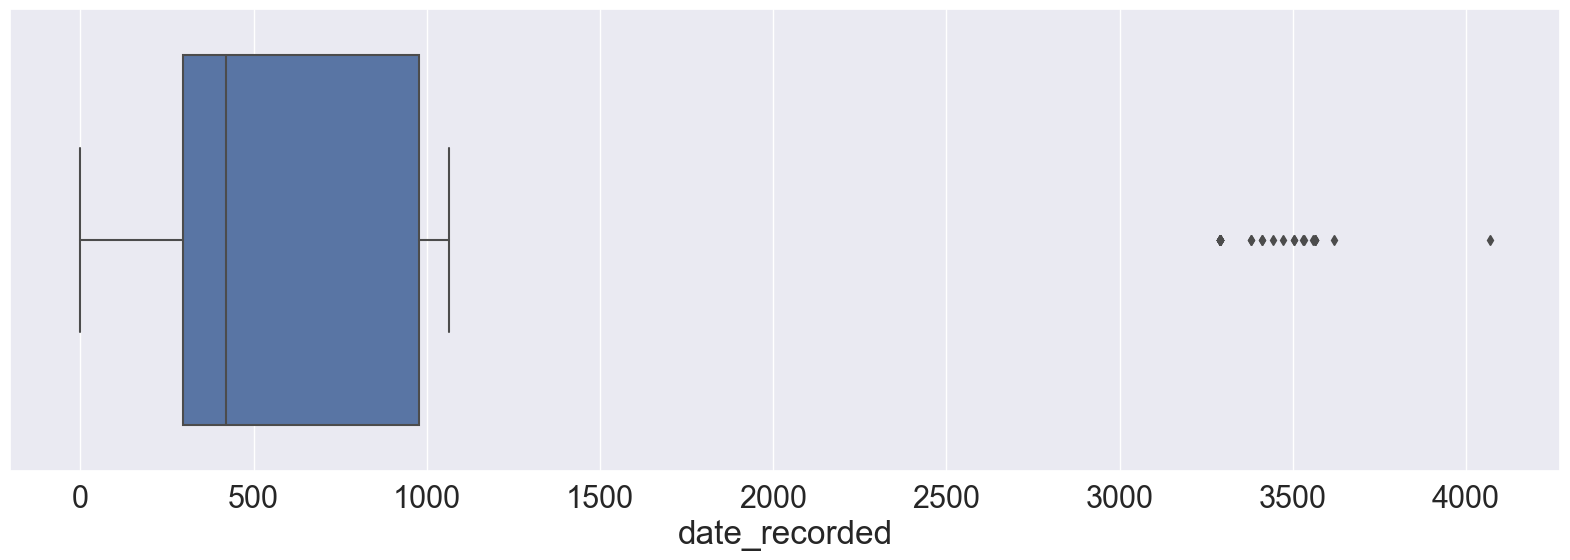

In [67]:
cramer = jd.cramers_v(df['date_recorded'],df["status_group"])
print(f"Asociación con la objetivo: {cramer}")
sns.displot(df['date_recorded'], height=6, aspect=3.5,kind='hist',rug=True, rug_kws={"color": "orange"})
plt.show()
sns.boxplot(df['date_recorded'])


# La limpieza sigue buscando las características con datos missing


In [68]:
[(x,y) for (x,y) in df.isna().sum().items() if y>0]

[('funder', 3635),
 ('installer', 3655),
 ('subvillage', 371),
 ('public_meeting', 3334),
 ('scheme_management', 3877),
 ('scheme_name', 28166),
 ('permit', 3056)]

## Funder e Installer

In [184]:
df.funder.unique()# categoría 0??
df.installer.unique()# categoría '-', '0'??

[(idx,val) for (idx,val) in enumerate(df.installer) if str(val).isdigit()]
[(idx,val) for (idx,val) in enumerate(df.funder) if str(val).isdigit()]

[(idx,val) for (idx,val) in enumerate(df.installer) if str(val).isdigit() and str(val)!="0"]# SOLO 0, NO HAY OTROS NÚMEROS
[(idx,val) for (idx,val) in enumerate(df.funder) if str(val).isdigit() and str(val)!="0"]# SOLO 0, NO HAY OTROS NÚMEROS


[]

### Son muy parecidos entre ellos, en lo que se borró había decidido hacerle drop al que tenía menor asociación cramer con la objetivo, pero en verdad, sabiendo que lo que mejor predice X_test es un random forest y que el 
### random forest no tiene problemas con la multicolinearidad, no hay necesidad de hacerle drop a ninguno.

### Justifico mi uso del IterativeImputer con la fuerte asociación de ambos con el resto del DataFrame

In [70]:
df[["funder","installer"]]
jd.cramers_v(df.funder,df.installer)

cramer_dict = {}
for i in df.columns:
    cramer= jd.cramers_v(df.funder,df[i])
    cramer_dict[i] = cramer
print("Top asociaciones del df con funder:")
print(pd.Series(cramer_dict).sort_values(ascending=False).head(10))
print()
cramer_dict = {}
for i in df.columns:
    cramer= jd.cramers_v(df.installer,df[i])
    cramer_dict[i] = cramer
print("Top asociaciones del df con installer:")
print(pd.Series(cramer_dict).sort_values(ascending=False).head(10))


Top asociaciones del df con funder:
funder               1.000000
wpt_name             0.802056
installer            0.765529
region               0.725681
construction_year    0.710562
latitude             0.702648
region_code          0.696729
basin                0.677196
scheme_name          0.669329
district_code        0.660757
dtype: float64

Top asociaciones del df con installer:
installer        1.000000
wpt_name         0.805723
region_code      0.779618
funder           0.765529
region           0.733605
district_code    0.732219
latitude         0.683255
lga              0.681476
basin            0.676127
scheme_name      0.668383
dtype: float64


## Función que usaré para ver qué tanta asociación tiene una variable con el resto del df, lo analizo para determinar si puedo imputar con técnicas complejas. (Sin nada de asociación con el resto de columnas no tiene sentido imputar con modelo de machine learning)

In [71]:
def asociaciones_df_var(data,var,n=10,remove= ["id","num_private","recorded_by","random","random2"]):
    cramer_dict = {}
    columnas = data.columns.tolist()
    columnas.remove(var)
    for i in remove:
        columnas.remove(i)
    for col in columnas:
        cramer= jd.cramers_v(data[var],df[col])
        cramer_dict[col] = cramer
    print(f"Top {n} asociaciones del df con {var}:")
    print(pd.Series(cramer_dict).sort_values(ascending=False).head(n))


In [72]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'random', 'random2'],
      dtype='object')

## El probelma con git lo tuve con este archivo, no con el que voy haciendo las entregas, este drop list quedó guardado en el otro archivo, sus resultados fueron mucho peores que el drop list corto que tenía antes por V de Cramer, veamos cómo puedo mejorarlo:

In [73]:
drop_list  = ["scheme_name","management_group","num_private","recorded_by",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]#saco funder de la lista que no me funcnó tan mal y rectifico mi desciciçon de imputa con el immputador iterativo.

## wpt_name tiene dos missings, no tendrá mucho efecto en el resultado la técnica que utilice

In [74]:
"a".isdigit()

False

In [75]:
# Igualmente busco valores raros
[(idx,val) for (idx,val) in enumerate(df.wpt_name) if val.isdigit()]


[(48919, '24')]

## subvillage

### Tiene muchísimos números y muchísimas categorías

In [76]:
[(idx,val) for (idx,val) in enumerate(df.subvillage) if str(val).isdigit()]
#df.subvillage.unique()

[(1317, '1'),
 (1944, '1'),
 (2034, '1'),
 (2093, '1'),
 (2165, '19'),
 (2401, '1'),
 (2457, '1'),
 (2797, '54'),
 (3422, '1'),
 (3481, '19'),
 (3637, '19'),
 (4038, '45'),
 (4125, '1'),
 (4346, '1'),
 (4488, '1'),
 (4498, '1'),
 (4715, '1'),
 (4813, '1'),
 (4914, '1'),
 (5585, '1'),
 (6986, '1'),
 (7054, '1'),
 (7711, '1'),
 (7789, '1'),
 (7804, '63'),
 (7947, '1'),
 (8039, '1'),
 (8057, '1'),
 (8521, '1'),
 (8626, '1'),
 (8725, '18'),
 (9097, '1'),
 (9129, '1'),
 (9273, '1'),
 (9283, '1'),
 (9507, '1'),
 (10089, '1'),
 (11063, '62'),
 (11400, '1'),
 (11430, '60'),
 (11895, '1'),
 (11902, '1'),
 (12084, '1'),
 (12348, '49'),
 (13122, '43'),
 (14072, '1'),
 (14697, '1'),
 (15756, '1'),
 (16676, '1'),
 (17029, '1'),
 (17199, '1'),
 (17556, '1'),
 (18131, '1'),
 (18892, '1'),
 (19322, '1'),
 (19485, '1'),
 (20579, '1'),
 (21736, '1'),
 (22297, '1'),
 (22300, '1'),
 (22501, '1'),
 (22725, '1'),
 (23856, '1'),
 (24445, '1'),
 (24996, '54'),
 (25587, '1'),
 (26388, '1'),
 (26572, '1'),
 (26

### Aquí veo un poco lo que le ocurriría a subvillage con distintos límites inferiores de frecuencia para meterse en categoría "missing" al final eso no lo haré a mano sino con los encoders de manera automática

Value counts:
[('Mwadudu', 1), ('Mwamagangati', 1), ('Mwaya B', 1), ('Mwandenga', 1), ('Mwadugulu', 1), ('Wimbwa', 1), ('Mwaduguru', 1), ('Zege', 1), ('Mwandunguku', 1), ('Mwabuliochi', 1), ('Mwandera', 1), ('Viwanjastini', 1), ('Mwanduu', 1), ('Mwadanga', 1), ('Mwasiti', 1), ('Mwabulandi', 1), ('Mwandutu', 1), ('Mwabukwimba', 1), ('Mwaya A', 1), ('Uwiga', 1), ('Mwanduominzi', 1), ('Mwadele', 1), ('Walisa', 1), ('Mwadole', 1), ('Wni Kati', 1), ('Mwamashele', 1), ('Zimbabwe', 1), ('Mzinga B', 1), ('Mwanza Ya Madaso', 1), ('Mwanya Shuleni', 1), ('Uwinwi', 1), ('Mwadegeleki', 1), ('Wingi', 1), ('Mwanyachiza', 1), ('Mwamagarani', 1), ('Mwasuta', 1), ('Mwabulilo', 1), ('Mwamasha', 1), ('Mwabunuri', 1), ('Mwanza Mangombe', 1), ('Mwandili A', 1), ('Mwandomo', 1), ('Mwasomi', 1), ('Mwandito', 1), ('Vikuruti', 1), ('Mzizini', 1), ('Mwamadilana', 1), ('Mwamasele', 1), ('Mwamachibya', 1), ('Mzungu B', 1), ('Mwamabulo', 1), ('Uwaya', 1), ('Mzungu Wa Sala', 1), ('Zelui', 1), ('Mwayole', 1), ('Viweg

Madukani          508
Shuleni           506
Majengo           502
Kati              373
Mtakuja           262
                 ... 
Gwashyi             2
Kilaweni Chini      2
Kisangari           2
Nyawami             2
Kiloa               2
Name: subvillage, Length: 9863, dtype: int64

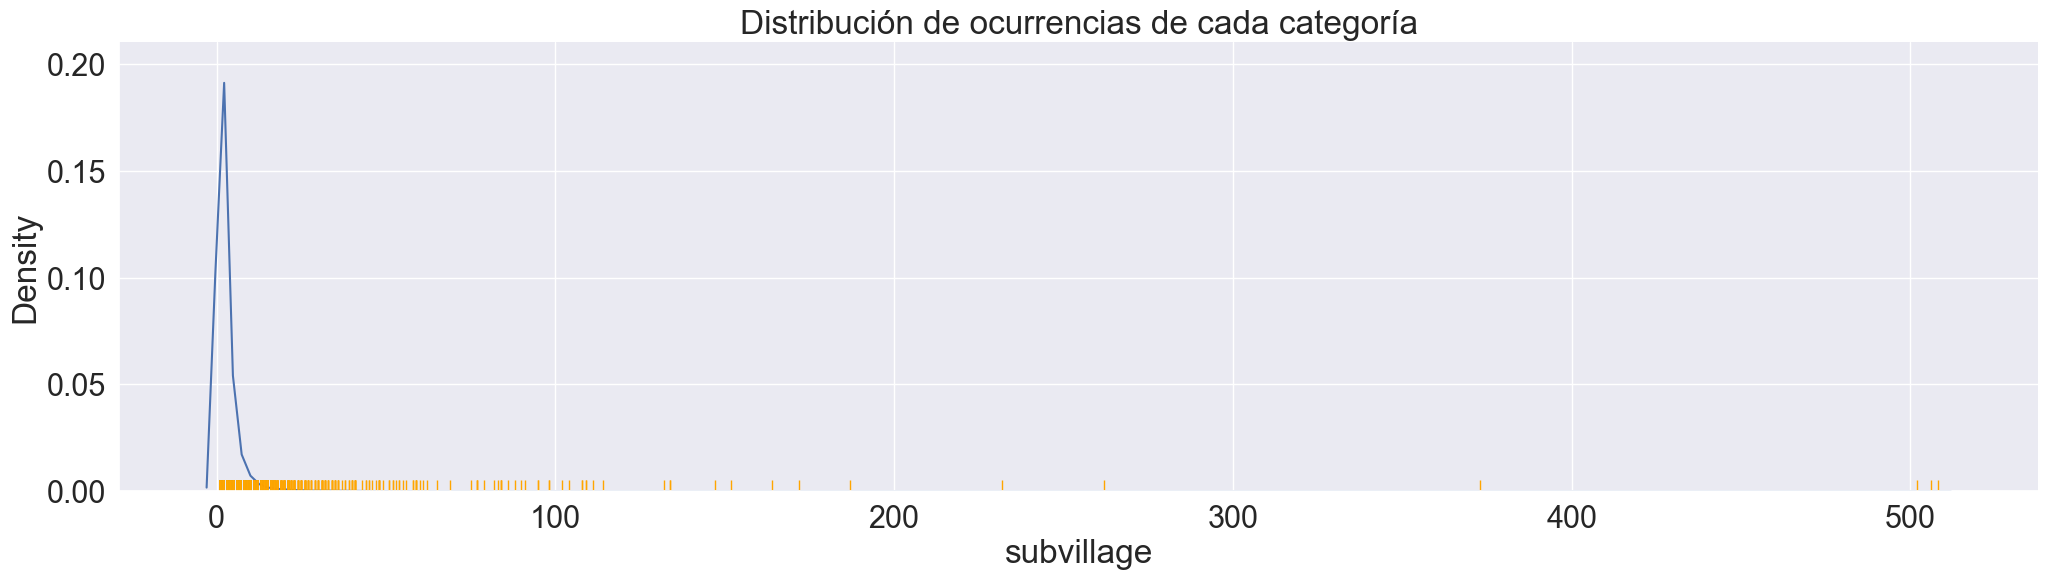

In [77]:
print("Value counts:")
print([(x,y) for (x,y) in df.subvillage.value_counts().items() if y==1])
# Demasiadas categorías de una sola aparición, crearé categoría de "poco frecuente" como recomendó el profesor y de la primera manera descrita en "Python Feature Engineering Cookbook"


freqs = df["subvillage"].value_counts(normalize=False)
freqs.sort_values(ascending=False)
# la categoría que más aparece, aparece sólo en el 0.8606% de los rows
sns.displot(freqs, height=6, aspect=3.5,kind='kde',rug=True, rug_kws={"color": "orange"})
plt.title("Distribución de ocurrencias de cada categoría")
freqs.loc[freqs!=1]


In [78]:
# En el libro se hace con frecuencias porcentuales, lo hago con números para ajustarlo de manera más fácil
frequent_cat = [
 x for x in freqs.loc[freqs > 3].index.values]

cramer = jd.cramers_v(df.subvillage,df.status_group)
print(f"Aosicación con la objetivo antes de agrupar categorías poco frecuentes: {cramer}")

# Agrupo las poco frecuentes
df["subvillage_agrupado"] = np.where(
 df["subvillage"].isin(frequent_cat),
 df["subvillage"], "Rare"
)
df.subvillage_agrupado = df.subvillage_agrupado.astype("category")
cramer = jd.cramers_v(df.subvillage_agrupado,df.status_group)
print(f"Aosicación con la objetivo después de agrupar categorías poco frecuentes: {cramer}")
"""
frequent_cat = [
 x for x in freqs.loc[freqs > 0.001].index.values]
Aosicación con la objetivo antes de agrupar categorías poco frecuentes: 0.6828801853777041
Aosicación con la objetivo después de agrupar categorías poco frecuentes: 0.0585490865296918

Así como esta hice muchas iteraciones, lo que maximiza la asociación cramer es no agrupar, me quedo con la sin agrupar y con 3 porque el random forest no debería tener problemas con esto
"""

Aosicación con la objetivo antes de agrupar categorías poco frecuentes: 0.6828801853777041
Aosicación con la objetivo después de agrupar categorías poco frecuentes: 0.4030543983122225


'\nfrequent_cat = [\n x for x in freqs.loc[freqs > 0.001].index.values]\nAosicación con la objetivo antes de agrupar categorías poco frecuentes: 0.6828801853777041\nAosicación con la objetivo después de agrupar categorías poco frecuentes: 0.0585490865296918\n\nAsí como esta hice muchas iteraciones, lo que maximiza la asociación cramer es no agrupar, me quedo con la sin agrupar y con 3 porque el random forest no debería tener problemas con esto\n'

In [79]:
#asociaciones_df_var(df,"subvillage")
# en esta computadora recibo MemoryError: Unable to allocate 10.7 GiB for an array with shape (2, 721314513) and data type uint64, lo intentaré en la otra. Pero recuerdo que tenía fuerte asociación con las demás, por eso el IterativeImputer

## public_meeting

In [80]:
[(idx,val) for (idx,val) in enumerate(df.public_meeting) if str(val).isdigit()]

[]

In [81]:
print(df.public_meeting.unique())
asociaciones_df_var(df,"public_meeting") # Fuerte asociación: IterativeImputer

[True, NaN, False]
Categories (2, bool): [False, True]
Top 10 asociaciones del df con public_meeting:
wpt_name               0.835721
scheme_name            0.801184
subvillage             0.792004
ward                   0.761752
lga                    0.518875
subvillage_agrupado    0.493667
installer              0.476018
funder                 0.460193
management             0.292456
scheme_management      0.268320
dtype: float64


## "scheme_management","scheme_name"

In [82]:
[(idx,val) for (idx,val) in enumerate(df.scheme_management) if str(val).isdigit()]
[(idx,val) for (idx,val) in enumerate(df.scheme_name) if str(val).isdigit()]

[]

In [83]:
print(f"Cantidad de valores únicos en management: {df.scheme_management.nunique()},Cantidad de valores únicos en name: {df.scheme_name.nunique()}")
print(f"Asociaicón entre ambas;:{jd.cramers_v(df.scheme_management,df.scheme_name)}")
print("No parece que cada valor de name tenga un solo valor en management, no le haré drop a ninguno")

df[["scheme_management","scheme_name"]].loc[df["scheme_name"]=="Roman"].scheme_management.unique()
#df[["scheme_management","scheme_name"]] 



Cantidad de valores únicos en management: 12,Cantidad de valores únicos en name: 2696
Asociaicón entre ambas;:0.8393079825818669
No parece que cada valor de name tenga un solo valor en management, no le haré drop a ninguno


['VWC', 'Water Board']
Categories (12, object): ['Company', 'None', 'Other', 'Parastatal', ..., 'WUA', 'WUG', 'Water Board', 'Water authority']

In [84]:
#cómo voy modificando drop list viejo
drop_list  = ["management_group","num_private","recorded_by",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]

In [85]:
asociaciones_df_var(df,"scheme_name")# Fuerte asociación: IterativeImputer
print("---------------------------------")
asociaciones_df_var(df,"scheme_management")# Fuerte asociación: IterativeImputer

Top 10 asociaciones del df con scheme_name:
region_code          0.998184
district_code        0.993104
permit               0.953053
latitude             0.948803
basin                0.947012
construction_year    0.944865
region               0.942548
lga                  0.940041
gps_height           0.915532
longitude            0.905798
dtype: float64
---------------------------------
Top 10 asociaciones del df con scheme_management:
wpt_name               0.851814
scheme_name            0.839308
subvillage             0.770190
management             0.757020
ward                   0.728288
management_group       0.700172
installer              0.614885
lga                    0.595438
funder                 0.589592
subvillage_agrupado    0.557180
dtype: float64


##  permit

In [86]:
df.permit.value_counts(dropna=False)

cramer = jd.cramers_v(df.permit,df.status_group) # Asociación muy baja con la objetivo, pero no es razón para descartarla
print(f"Aosicación con la Objetivo: {cramer}")

asociaciones_df_var(df,"permit")# Fuerte asociación: IterativeImputer

Aosicación con la Objetivo: 0.034686416172701455
Top 10 asociaciones del df con permit:
scheme_name            0.953053
ward                   0.892290
subvillage             0.834607
wpt_name               0.827080
lga                    0.822143
installer              0.642906
funder                 0.620624
subvillage_agrupado    0.555618
region                 0.408145
scheme_management      0.292946
dtype: float64


# Reviso ahora las categorías que en la descipción parecen significar lo mismo

basin - Geographic water basin
subvillage - Geographic location

In [87]:
print(f"Cantidad de valores únicos en basin: {df.basin.nunique()},Cantidad de valores únicos en subvillage: {df.subvillage.nunique()}")

df[["basin","subvillage"]].loc[df["subvillage"]=="Majengo"].basin.unique()

#No parece que se cumpla que cada valor de subvillage se corresponde a uno solo de basin, dejo ambas

#df[["basin","subvillage"]]

Cantidad de valores únicos en basin: 9,Cantidad de valores únicos en subvillage: 19287


['Pangani', 'Lake Nyasa', 'Lake Rukwa', 'Rufiji', 'Ruvuma / Southern Coast', 'Lake Tanganyika', 'Internal', 'Lake Victoria', 'Wami / Ruvu']
Categories (9, object): ['Internal', 'Lake Nyasa', 'Lake Rukwa', 'Lake Tanganyika', ..., 'Pangani', 'Rufiji', 'Ruvuma / Southern Coast', 'Wami / Ruvu']

region - Geographic location
region_code - Geographic location (coded)
district_code - Geographic location (coded)

In [88]:
print(f"Cantidad de valores únicos en region: {df.region.nunique()},Cantidad de valores únicos en region_code: {df.region_code.nunique()},Cantidad de valores únicos en district_code: {df.district_code.nunique()}")
df[["region","region_code","district_code"]]

df[["region_code","district_code"]].loc[df["region_code"]==20].district_code.unique() #No parece que se cumpla que cada valor de district_code se corresponde a uno solo de region_code, dejo ambas

Cantidad de valores únicos en region: 21,Cantidad de valores únicos en region_code: 27,Cantidad de valores únicos en district_code: 20


array([2, 3, 4, 1, 6])

In [89]:
df[["region","region_code"]].loc[df["region_code"]==20].region.unique() 
# Para regiuon y region code sí parece que cada region code se corresponde a una sola region
df[["region","region_code"]].loc[df["region_code"]==21].region.unique() 

for i in df["region_code"].unique():
    if df[["region","region_code"]].loc[df["region_code"]==i].region.nunique() !=1:
        print(f"el code {i} se corresponde a más de una región")

df[["region_code","district_code"]].loc[df["region_code"]==11]#.district_code.unique() No le hago drop a ninguno de los tres con descripción "Geographic location"--> ojo: sólo aplica porque uso random forest

el code 11 se corresponde a más de una región
el code 18 se corresponde a más de una región
el code 17 se corresponde a más de una región
el code 14 se corresponde a más de una región
el code 5 se corresponde a más de una región


region_code  district_code
0               11              5
16              11              4
17              11              4
19              11              5
20              11              4
...            ...            ...
59365           11              4
59367           11              3
59378           11              4
59380           11              5
59396           11              4

[5300 rows x 2 columns]

lga - Geographic location
ward - Geographic location

In [90]:
print(f"Cantidad de valores únicos en lga: {df.lga.nunique()},Cantidad de valores únicos en region_code: {df.region_code.nunique()},Cantidad de valores únicos en ward: {df.ward.nunique()}")

df[["lga","ward"]]

Cantidad de valores únicos en lga: 125,Cantidad de valores únicos en region_code: 27,Cantidad de valores únicos en ward: 2092


lga              ward
0              Ludewa          Mundindi
1           Serengeti             Natta
2           Simanjiro           Ngorika
3            Nanyumbu          Nanyumbu
4             Karagwe        Nyakasimbi
...               ...               ...
59395             Hai  Masama Magharibi
59396          Njombe            Ikondo
59397         Mbarali           Chimala
59398        Chamwino      Mvumi Makulu
59399  Morogoro Rural        Ngerengere

[59400 rows x 2 columns]

## Hay 7 medidas de region y las he estado investigando por partes, la verdad es que para buscar si alguna es completamente redundante he de investigarla por sí sola frente al resto entero

In [91]:
for i in df["lga"].unique():
    if df[["lga","region"]].loc[df["lga"]==i].region.nunique() !=1:
        print(f"el lga {i} se corresponde a más de una región")
        
for i in df["region"].unique():
    if df[["lga","region"]].loc[df["region"]==i].lga.nunique() !=1:
        print(f"la región {i} se corresponde a más de un lga")


print(jd.theils_u(df.lga,df.region_code))
print(jd.theils_u(df.region_code,df.lga))
# La U de Theil habla de probabiliad condicional, donde el resultado de P(x|y) != P(y|x)
# El 0.99 nos indica que con el valor de lga podemos predecir el valor de region con seguridad plena, por lo que de todas las medidas de geolocalización sólo es region completamente redundante

la región Iringa se corresponde a más de un lga
la región Mara se corresponde a más de un lga
la región Manyara se corresponde a más de un lga
la región Mtwara se corresponde a más de un lga
la región Kagera se corresponde a más de un lga
la región Tanga se corresponde a más de un lga
la región Shinyanga se corresponde a más de un lga
la región Tabora se corresponde a más de un lga
la región Pwani se corresponde a más de un lga
la región Ruvuma se corresponde a más de un lga
la región Kilimanjaro se corresponde a más de un lga
la región Rukwa se corresponde a más de un lga
la región Mwanza se corresponde a más de un lga
la región Kigoma se corresponde a más de un lga
la región Lindi se corresponde a más de un lga
la región Dodoma se corresponde a más de un lga
la región Arusha se corresponde a más de un lga
la región Mbeya se corresponde a más de un lga
la región Singida se corresponde a más de un lga
la región Morogoro se corresponde a más de un lga
la región Dar es Salaam se correspo

# Uso de la U de Theil: muestra la seguridad de encontrar un valor en una columna sabiendo el de otra, es decir, el valor de U de Theil de Ciudad frente a Comunidad autónoma será de 1

In [92]:
from itertools import combinations
columnas_geoloc = ["lga","ward","region","region_code","district_code","basin","subvillage"]


for var1, var2 in combinations(columnas_geoloc, 2):
    #var1 --> var2
    count = 0
    meta = df[var1].nunique()

    theil1 = jd.theils_u(df[var1],df[var2])
    if theil1>0.95:
        print(f"Qué tan seguro puedo estar del valor de {var1} cuando conozco {var2}: {theil1}")
        print("------------------------------")

    for i in df[var1].unique():
        if df[[var1, var2]].loc[df[var1]==i][var2].nunique() ==1:#if this valor de var1 siempre se corresponde al mismo valor de var2
            count+=1
        if count == meta:
            print("IMPORTANTE:")
            print(f"{var1} hace redundante a {var2}")

    #var2 --> var1
    count = 0
    meta = df[var2].nunique()

    theil2 = jd.theils_u(df[var2],df[var1])
    if theil2 > 0.95:
        print("------------------------------")
        print(f"Qué tan seguro puedo estar del valor de {var2} cuando conozco {var1}: {theil2}")

    for i in df[var2].unique():
        if df[[var2, var1]].loc[df[var2]==i][var1].nunique() ==1: 
            count+=1
        if count == meta:
            print(f"{var2} hace redundante a {var1}")
    print("")
    
            

Qué tan seguro puedo estar del valor de lga cuando conozco ward: 0.989549423173715
------------------------------

IMPORTANTE:
lga hace redundante a region
------------------------------
Qué tan seguro puedo estar del valor de region cuando conozco lga: 1.0

------------------------------
Qué tan seguro puedo estar del valor de region_code cuando conozco lga: 0.9941497519520324

------------------------------
Qué tan seguro puedo estar del valor de district_code cuando conozco lga: 0.9666097795302878



------------------------------
Qué tan seguro puedo estar del valor de region cuando conozco ward: 0.9858180047039892

------------------------------
Qué tan seguro puedo estar del valor de region_code cuando conozco ward: 0.9847275058133742

------------------------------
Qué tan seguro puedo estar del valor de district_code cuando conozco ward: 0.9710885613768153

------------------------------
Qué tan seguro puedo estar del valor de basin cuando conozco ward: 0.965489695588419


Qué 

In [93]:
#cómo voy modificando drop list viejo: región y region_code entran

#region siendo completamente redundante frente a lga, la cual muestra una versión más disgregada, granular de los datos de region.
#region_code es casi casi completamente redundante frente a lga también por la misma razón.

drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]#basin??

In [94]:
# Convierto la celda anterior en función reutilizable:

def check_redundancy(columnas, verbose = 0):
    """
    verbose controla la cantiadad de prints,
    0 muestra sólo cuando una columna es completamente redundate.
    1 te da el resultado de la U de Theil de las variables si este valor es mayor a 0.95
    2 te muestra cada categoría que siempre se corresponde al mismo valor en otra columna
    """
    from itertools import combinations
    for var1, var2 in combinations(columnas, 2):
        #var1 --> var2
        count = 0
        meta = df[var1].nunique()
        
        theil1 = jd.theils_u(df[var1],df[var2])
        if theil1>0.95:
            if verbose > 0:
                print(f"Qué tan seguro puedo estar del valor de {var1} cuando conozco {var2}: {theil1}")
            
        lista1 = []
        for i in df[var1].unique():
            if df[[var1, var2]].loc[df[var1]==i][var2].nunique() ==1:#if this valor de var1 siempre se corresponde al mismo valor de var2
                lista1.append(i)
                count+=1
            if count == meta:
                print("------------------------------")
                print("IMPORTANTE:")
                print(f"{var1} hace redundante a {var2}")
                print("------------------------------")
        if verbose > 1:
            print(f"los siguientes valores de {var1} tienen asociados siempre el mismo valor en {var2}")
            print(lista1)



        #var2 --> var1
        count = 0
        meta = df[var2].nunique()
        
        theil2 = jd.theils_u(df[var2],df[var1])
        if theil2 > 0.95:
            if verbose > 0:
                print(f"Qué tan seguro puedo estar del valor de {var2} cuando conozco {var1}: {theil2}")

        lista2 = []
        for i in df[var2].unique():
            if df[[var2, var1]].loc[df[var2]==i][var1].nunique() ==1: 
                count+=1
                lista2.append(i)
            if count == meta:
                print("------------------------------")
                print("IMPORTANTE:")
                print(f"{var2} hace redundante a {var1}")
                print("------------------------------")
        if verbose > 1:
            print(f"los siguientes valores de {var2} tienen asociados siempre el mismo valor en {var1}")
            print(lista1)
    
         

## "scheme_management","scheme_name" tienen la misma descripción

In [95]:
check_redundancy(["scheme_management","scheme_name"],verbose=2) #no prints

los siguientes valores de scheme_management tienen asociados siempre el mismo valor en scheme_name
[]
los siguientes valores de scheme_name tienen asociados siempre el mismo valor en scheme_management
[]


In [96]:
check_redundancy(["lga","ward","region","region_code","district_code","basin","subvillage"],verbose=0)

------------------------------
IMPORTANTE:
lga hace redundante a region
------------------------------


In [97]:
#drop_list 0.8170
drops0ochounosetenta = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]

#drop_list que voy creando a base de la creada en el tabajo borrado
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio

## "extraction_type","extraction_type_group","extraction_type_class" tienen la misma descripción

In [98]:
check_redundancy(["extraction_type","extraction_type_group","extraction_type_class"],verbose=2) 

Qué tan seguro puedo estar del valor de extraction_type cuando conozco extraction_type_group: 0.9656098168177001
------------------------------
IMPORTANTE:
extraction_type hace redundante a extraction_type_group
------------------------------
los siguientes valores de extraction_type tienen asociados siempre el mismo valor en extraction_type_group
['gravity', 'submersible', 'swn 80', 'nira/tanira', 'india mark ii', 'other', 'ksb', 'mono', 'windmill', 'afridev', 'other - rope pump', 'india mark iii', 'other - swn 81', 'other - play pump', 'cemo', 'climax', 'walimi', 'other - mkulima/shinyanga']
Qué tan seguro puedo estar del valor de extraction_type_group cuando conozco extraction_type: 1.0
los siguientes valores de extraction_type_group tienen asociados siempre el mismo valor en extraction_type
['gravity', 'submersible', 'swn 80', 'nira/tanira', 'india mark ii', 'other', 'ksb', 'mono', 'windmill', 'afridev', 'other - rope pump', 'india mark iii', 'other - swn 81', 'other - play pump', 

In [99]:
#extraction_type group y class se quedan en la lista!!!!

drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio


## "management","management_group"tienen la misma descripción

In [100]:
check_redundancy(["management","management_group"],verbose=2) 

------------------------------
IMPORTANTE:
management hace redundante a management_group
------------------------------
los siguientes valores de management tienen asociados siempre el mismo valor en management_group
['vwc', 'wug', 'other', 'private operator', 'water board', 'wua', 'company', 'water authority', 'parastatal', 'unknown', 'other - school', 'trust']
Qué tan seguro puedo estar del valor de management_group cuando conozco management: 1.0
los siguientes valores de management_group tienen asociados siempre el mismo valor en management
['vwc', 'wug', 'other', 'private operator', 'water board', 'wua', 'company', 'water authority', 'parastatal', 'unknown', 'other - school', 'trust']


In [101]:
# management_group se queda
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio




## "payment","payment_type" tienen la misma descripción

In [102]:
check_redundancy(["payment","payment_type"],verbose=2) 


Qué tan seguro puedo estar del valor de payment cuando conozco payment_type: 1.0
------------------------------
IMPORTANTE:
payment hace redundante a payment_type
------------------------------
los siguientes valores de payment tienen asociados siempre el mismo valor en payment_type
['pay annually', 'never pay', 'pay per bucket', 'unknown', 'pay when scheme fails', 'other', 'pay monthly']
Qué tan seguro puedo estar del valor de payment_type cuando conozco payment: 1.0
------------------------------
IMPORTANTE:
payment_type hace redundante a payment
------------------------------
los siguientes valores de payment_type tienen asociados siempre el mismo valor en payment
['pay annually', 'never pay', 'pay per bucket', 'unknown', 'pay when scheme fails', 'other', 'pay monthly']


In [103]:
print(df.payment.nunique())
df.payment_type.nunique()

7


7

In [104]:
# Payment SE QUEDA
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio





## "water_quality","quality_group", tienen la misma descripción

In [105]:
check_redundancy(["water_quality","quality_group"],verbose=2) 

Qué tan seguro puedo estar del valor de water_quality cuando conozco quality_group: 0.9629320818479418
------------------------------
IMPORTANTE:
water_quality hace redundante a quality_group
------------------------------
los siguientes valores de water_quality tienen asociados siempre el mismo valor en quality_group
['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured', 'salty abandoned', 'fluoride abandoned']
Qué tan seguro puedo estar del valor de quality_group cuando conozco water_quality: 1.0
los siguientes valores de quality_group tienen asociados siempre el mismo valor en water_quality
['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured', 'salty abandoned', 'fluoride abandoned']


In [106]:
# quality_group se queda en la lista.
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio





## "quantity","quantity_group"tienen la misma descripción

In [107]:
check_redundancy(["quantity","quantity_group"],verbose=2) 

Qué tan seguro puedo estar del valor de quantity cuando conozco quantity_group: 1.0
------------------------------
IMPORTANTE:
quantity hace redundante a quantity_group
------------------------------
los siguientes valores de quantity tienen asociados siempre el mismo valor en quantity_group
['enough', 'insufficient', 'dry', 'seasonal', 'unknown']
Qué tan seguro puedo estar del valor de quantity_group cuando conozco quantity: 1.0
------------------------------
IMPORTANTE:
quantity_group hace redundante a quantity
------------------------------
los siguientes valores de quantity_group tienen asociados siempre el mismo valor en quantity
['enough', 'insufficient', 'dry', 'seasonal', 'unknown']


In [108]:
# quality_group se queda en la lista.
drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio

## "source","source_type", "source_class" tienen la misma descripción

In [109]:
check_redundancy(["source","source_type", "source_class"],verbose=2) 

------------------------------
IMPORTANTE:
source hace redundante a source_type
------------------------------
los siguientes valores de source tienen asociados siempre el mismo valor en source_type
['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other', 'shallow well', 'river', 'hand dtw', 'lake', 'unknown']
Qué tan seguro puedo estar del valor de source_type cuando conozco source: 1.0
los siguientes valores de source_type tienen asociados siempre el mismo valor en source
['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other', 'shallow well', 'river', 'hand dtw', 'lake', 'unknown']
------------------------------
IMPORTANTE:
source hace redundante a source_class
------------------------------
los siguientes valores de source tienen asociados siempre el mismo valor en source_class
['spring', 'rainwater harvesting', 'dam', 'machine dbh', 'other', 'shallow well', 'river', 'hand dtw', 'lake', 'unknown']
Qué tan seguro puedo estar del valor de source_class cuando conozco

------------------------------
IMPORTANTE:
source_type hace redundante a source_class
------------------------------
los siguientes valores de source_type tienen asociados siempre el mismo valor en source_class
['spring', 'rainwater harvesting', 'dam', 'borehole', 'other', 'shallow well', 'river/lake']
Qué tan seguro puedo estar del valor de source_class cuando conozco source_type: 1.0
los siguientes valores de source_class tienen asociados siempre el mismo valor en source_type
['spring', 'rainwater harvesting', 'dam', 'borehole', 'other', 'shallow well', 'river/lake']


In [110]:
# ,"source_class","source_type" se quedan

drop_list  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio

## "waterpoint_type","waterpoint_type_group" tienen la misma descripción

In [111]:
check_redundancy(["waterpoint_type","waterpoint_type_group"],verbose=2) 

------------------------------
IMPORTANTE:
waterpoint_type hace redundante a waterpoint_type_group
------------------------------
los siguientes valores de waterpoint_type tienen asociados siempre el mismo valor en waterpoint_type_group
['communal standpipe', 'communal standpipe multiple', 'hand pump', 'other', 'improved spring', 'cattle trough', 'dam']
Qué tan seguro puedo estar del valor de waterpoint_type_group cuando conozco waterpoint_type: 1.0
los siguientes valores de waterpoint_type_group tienen asociados siempre el mismo valor en waterpoint_type
['communal standpipe', 'communal standpipe multiple', 'hand pump', 'other', 'improved spring', 'cattle trough', 'dam']


In [112]:
#waterpoint_type_group se queda
drop_list_no_sirven  = ["management_group","num_private","recorded_by","region","region_code"
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              ]#"permit","population","amount_tsh" eran drops que funcionaban bien al principio



# a los drops les sumé "permit","population","amount_tsh" porque fueron drops que dieron buenos resultados al principio 
#0.8150
drop_modelo_ceroochounocinco  = ["management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"] #permit","population","amount_tsh" eran drops que funcionaban bien al principio

In [113]:
mejor_drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]

drop_modelo_ceroochounocinco  = ["management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]

en_mejor_pero_no_en_mio = [x for x in mejor_drop_list if x not in drop_modelo_ceroochounocinco]
en_mio_pero_no_en_mejor = [x for x in drop_modelo_ceroochounocinco if x not in mejor_drop_list]

print("Variables en el drop list de los mejores resultados 0.8170, que no están en mi preferido 0.8150")
print(en_mejor_pero_no_en_mio)
print("----------------------")
print("Variables en mi drop list preferido 0.8150 que no están en el de los mejores resultados 0.8170")
print(en_mio_pero_no_en_mejor)

Variables en el drop list de los mejores resultados 0.8170, que no están en mi preferido 0.8150
[]
----------------------
Variables en mi drop list preferido 0.8150 que no están en el de los mejores resultados 0.8170
['region', 'region_code', 'extraction_type_group', 'extraction_type_class', 'payment', 'quality_group', 'quantity_group', 'source_class', 'source_type', 'waterpoint_type_group']


## El drop_list no me dio los resultados que esperaba, quiesiera mejorar mi función para que me analice cuál de las características redundantes tiene mayor asociación cramer con la objetivo. 

## Pero no quiero perder demasiado tiempo evaluando qué variables obviar, antes que eso desarrollaré una función que pruebe los distintos tipos de encoding para cada variable y así quedarme con el mejor para cada quien en vez de usa el ordinal encoder para todas.

In [114]:
#drop_modelo_ceroochounocincodos porque con mis features da ese score.

drop_modelo_ceroochounocincodos  = ["management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]



# ESTE ES EL DROP LIST QUE SEGUIRÉ USANDO POR AHORA, ES EL QUE MÁS SENTIDO SU ACCURACY AUNQUE SEA 0.02 MENOR QUE EL MEJOR

# Tengo muchísimas variables categóricas y hasta ahora sólo les he hecho OrdinalEncoding, haré una función que con validación cruzada determine la mejor técnica de encoding para cada categoría.

## Par de notas de compatibilidad del ColumnTransformer con category_encoders
(*) For full compatibility with Pipelines and ColumnTransformers, and consistent behaviour of get_feature_names_out, it’s recommended to upgrade sklearn to a version at least ‘1.2.0’ and to set output as pandas:

import sklearn
sklearn.set_config(transform_output="pandas")

Name: scikit-learn
Version: 1.2.2 Dios mediante me funciona

import pandas as pd
import numpy as np

import jd 
from optbinning import MulticlassOptimalBinning

import plotly.express as px
import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 6]  # Width, Height

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score

#import warnings
#warnings.filterwarnings("ignore")

In [119]:
import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,TargetEncoder,LabelEncoder,StandardScaler
from category_encoders import WOEEncoder, CountEncoder
from sklearn.cluster import KMeans

### La función prueba ser un desafío muy grande, pero en verdad entretenido, me ha dado problemas con básicamente todo lo posible. Sé que dijeron que dejásemos todo lo hecho escrito, dejar todos los borraodres de esto dejaría un caos terrorífico.

# Investigué bastante de distintas técnicas de encoding.

## Encoders usados en esta función:

### - Por mucho tiempo no entendí la diferencia entre lo que hacen el ordinal y el target encoder:
#### Este foro parece tener la respuesta: https://datascience.stackexchange.com/questions/39317/difference-between-ordinalencoder-and-labelencoder.
#### Dan el mismo resultado, pero el ordinalencoder está hecho para datos 2D, mientras que label encoder, al estar hecho para los labels a ser predichos (una sola columna) funciona en datos 1D.

### - Parecen haber dos maneras de hacer ordinal encoding "Replacing categories with ordinal numbers" y "Encoding with integers in an ordered manner" - Python Feature Engineering Cookbook: 
#### Ambos encoders reemplazan cada categoría por un integer, la implementación de sklearn además me permite crear un número ordinal sólo para categorías poco frecuentes (definición que establecí como 1% de los datos). La diferencia radica en que la primera asigna numeros ordinales arbitrarios y la segunda permite ordenarlos por su relación al target, lastimosamente Sklearn no tiene la segunda alternativa implementada, la conseguí en feature_engine, el paquete utilizado por el libro previamente mencionado.

### - "Performing one-hot encoding of frequent categories" - Python Feature Engineering Cookbook: 
#### El one-hot encoding en su forma más pura creará una columna binaria para todas las categorías de una columna menos una de referencia (esa columna de referencia es el one hot), el problema que comunente ocurre con esta técnica es que nos encontramos con columnas de demasiadas categorías, muchas veces poco frecuentes, si el onehot encoder se consigue una categoría que aparece una sola vez en un dataset de 1 millón de filas, este creará una columna de 999999 ceros y 1 uno. El "Performing one-hot encoding of frequent categories" soluciona este problema creando columnas sólo para una cierta cantidad de categorías, puede ser set-up diciendo la frecuencia mínima de las categorías o diciendo el número máximo de categorías a crear, esta técnica luego agrupará estas categorías menos frecuentes en su propia columna.


### - "Encoding with the mean of the target" - Python Feature Engineering Cookbook: 
#### Para cada columna se agrega cada categoría y se calcula la media del target para cada una, luego se reemplaza cada ocurrencia de la categoría por esta media.

### - "Replacing categories with counts or frequency of observations" - Python Feature Engineering Cookbook: 
#### Para este ejercicio uso el countencoder de category-encoders en vez del frequency. Este encoder simplemente reemplaza cada categoría por el númeroo de ocurrencias que esta presenta en el dataset.

## Encodings que no aparecen en Python Feature Engineering Cookbook, salen de category_encoders:https://contrib.scikit-learn.org/category_encoders/index.html

### - HelmertEncoder: 
#### ordena las categorías acorde con el objetivo y para cada categoría calcula la relación con su valor subsecuente y reemplaza cada ocurrencia de la categoría con esa relación.

### - PolynomialEncoder: 
#### Busca caputarar tendencias de relaciones lineares, cuadráticas y cúbicas con la variable objetivo.


# Encodings añadidos a la función después de hacer los primeros dos submissions de los resultados de la función

#### HelmertEncoder: https://stats.oarc.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/

#### PolynomialEncoder: https://stats.oarc.ucla.edu/r/library/r-library-contrast-coding-systems-for-categorical-variables/

#### ordinal_ordered: https://feature-engine.trainindata.com/en/latest/user_guide/encoding/OrdinalEncoder.html

In [229]:

# primera versión, sin los últimos 3 encoders
def encode(X,y,column,tipo,OrdinalEncoder_cols,OnehotEnc_cols,TargetEnc_cols,FrequencyEnc_cols,num_cols):
    X_copy = X.copy()
    y_copy = y.copy()

    preprocessing = ColumnTransformer([
        ('ordinal', OrdinalEncoder(handle_unknown="use_encoded_value",
                                    unknown_value=10000000,
                                    encoded_missing_value =10000001,
                                    min_frequency = 0.01), OrdinalEncoder_cols),
        
        ('onehot', OneHotEncoder(max_categories=7,# Si existen más de 6 valores únicos crea categoría "infrequent"
                                    handle_unknown ="infrequent_if_exist",
                                    drop="first",sparse_output=False), OnehotEnc_cols),

        ('target', TargetEncoder(target_type="multiclass",
                                    cv=2,), TargetEnc_cols),  # default cv 5 me tardaría una eternidad
                                    
        ('Frequency', CountEncoder(handle_unknown="value",
                                    handle_missing="value"), FrequencyEnc_cols),                             
        ('scaler', StandardScaler(), num_cols),  
    ],
    remainder = "passthrough",
    )

    #X_copy = pd.DataFrame(data=preprocessing.fit_transform(X_copy,y=y_copy.status_group.values), columns=preprocessing.get_feature_names_out())
    X_copy = pd.DataFrame(data=preprocessing.fit_transform(X_copy,y=y_copy), columns=preprocessing.get_feature_names_out())
    
    
    if tipo == "train_test":
        X_train, X_test, y_train, y_test = train_test_split(X_copy, y_copy, test_size=0.2, random_state=23)
        rf = RandomForestClassifier(n_jobs=-1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_test)
        score = accuracy_score(y_test,y_pred)

    elif tipo == "KFold":
        rf = RandomForestClassifier(n_jobs=-1)
        score = cross_validate(rf, X_copy, y_copy, cv=4,scoring = "accuracy",n_jobs=-1)["test_score"].mean()

    return score

In [121]:
def preprocess(X):
    for i in X.select_dtypes(include = "O").columns:
        X[i] = X[i].astype("category")

    #Fechas------------------------------------------------------------------------ 
    X.date_recorded = X.date_recorded.astype("O")
    X.date_recorded = pd.to_datetime(X.date_recorded)
    X['date_recorded'] = (X.date_recorded.max() - X.date_recorded).dt.days
    X.district_code = X.district_code.astype("category")
    #X.region_code = X.region_code.astype("category")
    #Drop list ------------------------------------------------------------------------ 
    drop_list  = ["id","management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population"]
    #Clusters de latitud y longitud------------------------------------------------------------------------   
    X.drop(drop_list,axis=1,inplace=True)
    clustering = KMeans(n_clusters=20)
    X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())
    
    #Marcar 0 en amount como dijo optbinning------------------------------------------------------------------------   
    X["amount_tsh_binned"] = X["amount_tsh"].copy()
    X.loc[X["amount_tsh_binned"].between(-np.inf,1.5),"amount_tsh_binned"] = 0
    X.loc[X["amount_tsh_binned"].between(1.5,np.inf),"amount_tsh_binned"] = 1
    X["amount_tsh_binned"] = X["amount_tsh_binned"].astype("category")
    return X

In [122]:
def best_encoding_technique(tipo = "train_test",cols = "all"):
    """
    Función que eliminará subjetividad de la elección de técnica de encoding.
    Probará las siguientes técnicas con validación cruzada repetida o con un X_test

    se hace sin previamente imputar porque para imputar por un imputador no simple deja error:
    ValueError: Cannot cast object dtype to float64.
    Se imputará con el propio encoder usando una de las técnicas de imputación que viene con ellos por defecto
    """
    
    X = pd.read_csv("In/Training_set_values.csv")#uso X y Y frescas 
    y = pd.read_csv("In/Training_set_labels.csv")

    le= LabelEncoder()
    #y["status_group"] = le.fit_transform(y.status_group)
    y = le.fit_transform(y.status_group)
    
    X = preprocess(X)
    
    if cols == "all":
        cols_to_test = X.select_dtypes(exclude=np.number).columns.tolist()
    else:
        cols_to_test = cols


    num_cols = X.select_dtypes(include=np.number).columns.tolist()

    OrdinalEncoder_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    OnehotEnc_cols = []
    TargetEnc_cols = []
    #WOEENC_cols = []# no creo que sus resultados varíen mucho del TargetEnc_cols. No funciona para objetivos multiclass
    FrequencyEnc_cols = [] #busca category encoders
    
    my_dict = {
    "OrdinalEncoder_cols": OrdinalEncoder_cols,
    "OnehotEnc_cols": OnehotEnc_cols,
    "TargetEnc_cols": TargetEnc_cols,
    "FrequencyEnc_cols": FrequencyEnc_cols
    }
    encoder_list = [OrdinalEncoder_cols,OnehotEnc_cols,TargetEnc_cols,FrequencyEnc_cols]

    for column in cols_to_test:
        list_to_keep_track_of_score = []

        for encoder in my_dict.values():
            #remove if exists from all lists
            if column in OrdinalEncoder_cols:
                OrdinalEncoder_cols.remove(column)

            elif column in OnehotEnc_cols:
                OnehotEnc_cols.remove(column)

            elif column in TargetEnc_cols:
                TargetEnc_cols.remove(column)

            elif column in FrequencyEnc_cols:
                FrequencyEnc_cols.remove(column)

            #appendo a lista respectiva y le saco el socore
            encoder.append(column)
            score = encode(X,y,column,tipo,OrdinalEncoder_cols,OnehotEnc_cols,TargetEnc_cols,FrequencyEnc_cols,num_cols)
            list_to_keep_track_of_score.append(score)
            #Lo saco de la columna testeada
            encoder.remove(column)

        
        # Lo apendo 
        encoder_list[np.argmax(list_to_keep_track_of_score)].append(column)

        
    return my_dict

In [123]:
dict = best_encoding_technique(tipo="train_test")
# solo 3 minutos



In [124]:

for key,val in zip(dict.keys(),dict.values()):
    print("---------------------------------------------------------------")
    print(f"variables en {key.upper()}")
    print(val)



"""  
---------------------------------------------------------------
variables en ORDINALENCODER_COLS
['installer', 'basin', 'ward', 'quantity', 'source', 'amount_tsh_binned']
---------------------------------------------------------------
variables en ONEHOTENC_COLS
['wpt_name', 'subvillage', 'public_meeting', 'scheme_name', 'extraction_type', 'management']
---------------------------------------------------------------
variables en TARGETENC_COLS
['water_quality']
---------------------------------------------------------------
variables en FREQUENCYENC_COLS
['funder', 'district_code', 'lga', 'scheme_management', 'payment_type', 'waterpoint_type']
"""


---------------------------------------------------------------
variables en ORDINALENCODER_COLS
['installer', 'wpt_name', 'basin', 'district_code', 'lga', 'public_meeting', 'scheme_management', 'scheme_name', 'payment_type', 'water_quality', 'quantity', 'amount_tsh_binned']
---------------------------------------------------------------
variables en ONEHOTENC_COLS
['ward', 'extraction_type', 'management', 'waterpoint_type']
---------------------------------------------------------------
variables en TARGETENC_COLS
[]
---------------------------------------------------------------
variables en FREQUENCYENC_COLS
['funder', 'subvillage', 'source']


"  \n---------------------------------------------------------------\nvariables en ORDINALENCODER_COLS\n['installer', 'basin', 'ward', 'quantity', 'source', 'amount_tsh_binned']\n---------------------------------------------------------------\nvariables en ONEHOTENC_COLS\n['wpt_name', 'subvillage', 'public_meeting', 'scheme_name', 'extraction_type', 'management']\n---------------------------------------------------------------\nvariables en TARGETENC_COLS\n['water_quality']\n---------------------------------------------------------------\nvariables en FREQUENCYENC_COLS\n['funder', 'district_code', 'lga', 'scheme_management', 'payment_type', 'waterpoint_type']\n"

In [125]:
dict = best_encoding_technique(tipo="KFold")


In [126]:

for key,val in zip(dict.keys(),dict.values()):
    print("---------------------------------------------------------------")
    print(f"variables en {key.upper()}")
    print(val)


"""
---------------------------------------------------------------
---------------------------------------------------------------
variables en ORDINALENCODER_COLS
['funder', 'quantity', 'source', 'waterpoint_type']
---------------------------------------------------------------
variables en ONEHOTENC_COLS
['basin', 'district_code', 'ward', 'scheme_management', 'scheme_name', 'extraction_type',
 'management', 'payment_type', 'water_quality', 'amount_tsh_binned']
---------------------------------------------------------------
variables en TARGETENC_COLS
[]
---------------------------------------------------------------
variables en FREQUENCYENC_COLS
['installer', 'wpt_name', 'subvillage', 'lga', 'public_meeting']
"""

---------------------------------------------------------------
variables en ORDINALENCODER_COLS
['funder', 'ward', 'management', 'water_quality', 'quantity', 'amount_tsh_binned']
---------------------------------------------------------------
variables en ONEHOTENC_COLS
['basin', 'scheme_management', 'scheme_name', 'payment_type', 'source']
---------------------------------------------------------------
variables en TARGETENC_COLS
[]
---------------------------------------------------------------
variables en FREQUENCYENC_COLS
['installer', 'wpt_name', 'subvillage', 'district_code', 'lga', 'public_meeting', 'extraction_type', 'waterpoint_type']


"\n---------------------------------------------------------------\n---------------------------------------------------------------\nvariables en ORDINALENCODER_COLS\n['funder', 'quantity', 'source', 'waterpoint_type']\n---------------------------------------------------------------\nvariables en ONEHOTENC_COLS\n['basin', 'district_code', 'ward', 'scheme_management', 'scheme_name', 'extraction_type',\n 'management', 'payment_type', 'water_quality', 'amount_tsh_binned']\n---------------------------------------------------------------\nvariables en TARGETENC_COLS\n[]\n---------------------------------------------------------------\nvariables en FREQUENCYENC_COLS\n['installer', 'wpt_name', 'subvillage', 'lga', 'public_meeting']\n"

## Resultados de la función no fueron como esperaba, empeoraron el accuarcy del random forest con todas las categóricas en OrdinalEncoder

# Intento por última vez optimizar la lista a la que hacerle drop

## La última vez me quedé con la columna más granular de las que se hacen redundantes entre ellas, esta vez me quedaré con la que tenga mayor asociación de Cramer

### - mejor hasta ahora, elimina por V de Cramer, hace incapié en los drops de las features que parecen ser redundantes
drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]

### - mi favorito, el que elimina los que funcionan bien por drop inicial por V de Cramer. Más los exactamente(y region_code) redundantes menos granulares:
drop_list  = ["id","management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population"]
### - próximo, elimina los drops que funcionan bien por V de Cramer y de los redundantes el que tenga menor V de Cramer 

In [127]:
def check_redundancy(columnas,target, verbose = 0):
    """
    verbose controla la cantiadad de prints,
    0 muestra sólo cuando una columna es completamente redundate.
    1 te da el resultado de la U de Theil de las variables si este valor es mayor a 0.95
    2 te muestra cada categoría que siempre se corresponde al mismo valor en otra columna
    """
    from itertools import combinations
    for var1, var2 in combinations(columnas,2):
        """
        verbose 0 imprime los completamente redundantes y me dice cuál es más granular y cuál tiene mayor v de Cramer.
        verbose 1 además me dice el valor de U de Theil de los features con U de Theil >0.95.
        verbose 2 además me dice que categorías dentro de cada feature se corresponden siempre a la misma categoría de otra feature.
        """
        #var1 --> var2
        count = 0
        meta = df[var1].nunique()   
        lista1 = []

        #verbose 1-------------------------------------------------------------------------------------------
        theil1 = jd.theils_u(df[var1],df[var2])
        if theil1>0.95:
            if verbose > 0:
                print(f"Qué tan seguro puedo estar del valor de {var1} cuando conozco {var2}: {theil1}")
                cramer1 = jd.cramers_v(df[var1],df[target])
                cramer2 = jd.cramers_v(df[var2],df[target])
                if cramer1 >= cramer2:
                    print(f"{var1} tiene mayor asociación con la objetivo")
                elif cramer1 <= cramer2:
                        print(f"{var2} tiene mayor asociación con la objetivo")
        #Siempre----------------------------------------------------------

        for i in df[var1].unique():
            if df[[var1, var2]].loc[df[var1]==i][var2].nunique() ==1:#if this valor de var1 siempre se corresponde al mismo valor de var2
                lista1.append(i)
                count+=1
            if count == meta:
                print("------------------------------")
                print("IMPORTANTE:")
                print(f"{var1} y {var2} son redundantes")
                print(f"{var1} es más granular")
                if verbose == 0:
                    cramer1 = jd.cramers_v(df[var1],df[target])
                    cramer2 = jd.cramers_v(df[var2],df[target])
                    if cramer1 >= cramer2:
                        print(f"{var1} tiene mayor asociación con la objetivo")
                    elif cramer1 <= cramer2:
                        print(f"{var2} tiene mayor asociación con la objetivo")
                
                print("------------------------------")
                 #verbose >= 2-------------------------------------------------------------------------------------------
        if verbose >= 2:
            print(f"los siguientes valores de {var1} tienen asociados siempre el mismo valor en {var2}")
            print(lista1)


        #var2 --> var1
        #verbose >= 2-------------------------------------------------------------------------------------------


        #verbose 1-------------------------------------------------------------------------------------------
        theil2 = jd.theils_u(df[var2],df[var1])
        if theil2 > 0.95:
            if verbose > 0:
                print(f"Qué tan seguro puedo estar del valor de {var2} cuando conozco {var1}: {theil2}")
                cramer1 = jd.cramers_v(df[var1],df[target])
                cramer2 = jd.cramers_v(df[var2],df[target])
                if cramer1 >= cramer2:
                    print(f"{var1} tiene mayor asociación con la objetivo")
                elif cramer1 <= cramer2:
                        print(f"{var2} tiene mayor asociación con la objetivo")
        #Siempre----------------------------------------------------------
        count = 0
        meta = df[var2].nunique()
        lista2 = []
        for i in df[var2].unique():
            if df[[var2, var1]].loc[df[var2]==i][var1].nunique() ==1: 
                count+=1
                lista2.append(i)
            if count == meta:
                print("------------------------------")
                print("IMPORTANTE:")
                print(f"{var1} y {var2} son redundantes")
                print(f"{var2} es más granular")
                
                if verbose == 0:
                    cramer1 = jd.cramers_v(df[var1],df[target])
                    cramer2 = jd.cramers_v(df[var2],df[target])
                    if cramer1 >= cramer2:
                        print(f"{var1} tiene mayor asociación con la objetivo")
                    elif cramer1 <= cramer2:
                            print(f"{var2} tiene mayor asociación con la objetivo") 
                print("------------------------------")
        if verbose > 1:
            print(f"los siguientes valores de {var2} tienen asociados siempre el mismo valor en {var1}")
            print(lista2)  

In [128]:
check_redundancy(["lga","ward","region","region_code","district_code","basin","subvillage"],"status_group",verbose=0)
# La más granular es también la que tiene mayor asociación con la objetivo

------------------------------
IMPORTANTE:
lga y region son redundantes
lga es más granular
lga tiene mayor asociación con la objetivo
------------------------------


In [129]:
check_redundancy(["extraction_type","extraction_type_group","extraction_type_class"],"status_group",verbose=0) 
# La más granular es también la que tiene mayor asociación con la objetivo

------------------------------
IMPORTANTE:
extraction_type y extraction_type_group son redundantes
extraction_type es más granular
extraction_type tiene mayor asociación con la objetivo
------------------------------
------------------------------
IMPORTANTE:
extraction_type y extraction_type_class son redundantes
extraction_type es más granular
extraction_type tiene mayor asociación con la objetivo
------------------------------
------------------------------
IMPORTANTE:
extraction_type_group y extraction_type_class son redundantes
extraction_type_group es más granular
extraction_type_group tiene mayor asociación con la objetivo
------------------------------


In [130]:
check_redundancy(["management","management_group"],"status_group",verbose=0) 
# La más granular es también la que tiene mayor asociación con la objetivo

------------------------------
IMPORTANTE:
management y management_group son redundantes
management es más granular
management tiene mayor asociación con la objetivo
------------------------------


In [131]:
check_redundancy(["payment","payment_type"],"status_group",verbose=0) 
# ambos dicen que tienen mayor asociación porque en la comparativa tengo >=, son iguales

------------------------------
IMPORTANTE:
payment y payment_type son redundantes
payment es más granular
payment_type tiene mayor asociación con la objetivo
------------------------------
------------------------------
IMPORTANTE:
payment y payment_type son redundantes
payment_type es más granular
payment_type tiene mayor asociación con la objetivo
------------------------------


In [132]:
check_redundancy(["water_quality","quality_group"],"status_group",verbose=0) 
# La más granular es también la que tiene mayor asociación con la objetivo

------------------------------
IMPORTANTE:
water_quality y quality_group son redundantes
water_quality es más granular
water_quality tiene mayor asociación con la objetivo
------------------------------


In [133]:
check_redundancy(["quantity","quantity_group"],"status_group",verbose=0) 
# parece que siempre que aparece una, también aparece la otra. oTRA VEZ POR EL >= los resultados de cramer aparecen extraños

------------------------------
IMPORTANTE:
quantity y quantity_group son redundantes
quantity es más granular
quantity tiene mayor asociación con la objetivo
------------------------------
------------------------------
IMPORTANTE:
quantity y quantity_group son redundantes
quantity_group es más granular
quantity tiene mayor asociación con la objetivo
------------------------------


In [134]:
check_redundancy(["source","source_type", "source_class"],"status_group",verbose=0) 
# De nuevo, la más granular es también la que tiene mayor asociación con la objetivo

------------------------------
IMPORTANTE:
source y source_type son redundantes
source es más granular
source tiene mayor asociación con la objetivo
------------------------------
------------------------------
IMPORTANTE:
source y source_class son redundantes
source es más granular
source tiene mayor asociación con la objetivo
------------------------------
------------------------------
IMPORTANTE:
source_type y source_class son redundantes
source_type es más granular
source_type tiene mayor asociación con la objetivo
------------------------------


In [135]:
check_redundancy(["waterpoint_type","waterpoint_type_group"],"status_group",verbose=0) 
# De nuevo, la más granular es también la que tiene mayor asociación con la objetivo

------------------------------
IMPORTANTE:
waterpoint_type y waterpoint_type_group son redundantes
waterpoint_type es más granular
waterpoint_type tiene mayor asociación con la objetivo
------------------------------


# Mi verificación por V de Cramer no modifica los resultados de mi drop list, probablemente por definición o puede ser comprobado matemáticamente o algo así, la V de Cramer siempre será mayor con una variable más disgregada.

### Después de revisar mis propias anotaciones en el EDA me doy cuenta que queda mucho por agregarle al preprocesado

Falta probar trameo de:
height
population 
días de la variable de fecha.

----------------------
Hacer algo con los 0s en Fecha 

df.funder.unique()# categoría 0??
df.installer.unique()# categoría '-', '0'??
----------------------


Saca todos los outliers
Variable {variable}+"missing"

wpt_name en index 24
[(48919, '24')]

from optbinning import MulticlassOptimalBinning

In [136]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'random', 'random2',
       'subvillage_agrupado'],
      dtype='object')

## gps_height

Bin  Count  Count (%)  Event_0  Event_1  Event_2  \
0           (-inf, 508.50)  31787   0.535135    15936     2295    13556   
1         [508.50, 860.50)   3056   0.051448     1544      221     1291   
2        [860.50, 1359.50)  11008   0.185320     5889     1040     4079   
3       [1359.50, 1567.50)   5704   0.096027     3422      393     1889   
4       [1567.50, 1688.50)   2972   0.050034     1894      193      885   
5           [1688.50, inf)   4873   0.082037     3574      175     1124   
6                  Special      0   0.000000        0        0        0   
7                  Missing      0   0.000000        0        0        0   
Totals                      59400   1.000000    32259     4317    22824   

        Event_rate_0  Event_rate_1  Event_rate_2  
0           0.501337      0.072199      0.426464  
1           0.505236      0.072317      0.422448  
2           0.534975      0.094477      0.370549  
3           0.599930      0.068899      0.331171  
4           0.637281      0.064939      0.297779  
5           0.733429      0.035912      0.230659  
6           0.000000      0.000000      0.000000  
7           0.000000      0.000000      0.000000  
Totals      0.543081      0.072677      0.384242

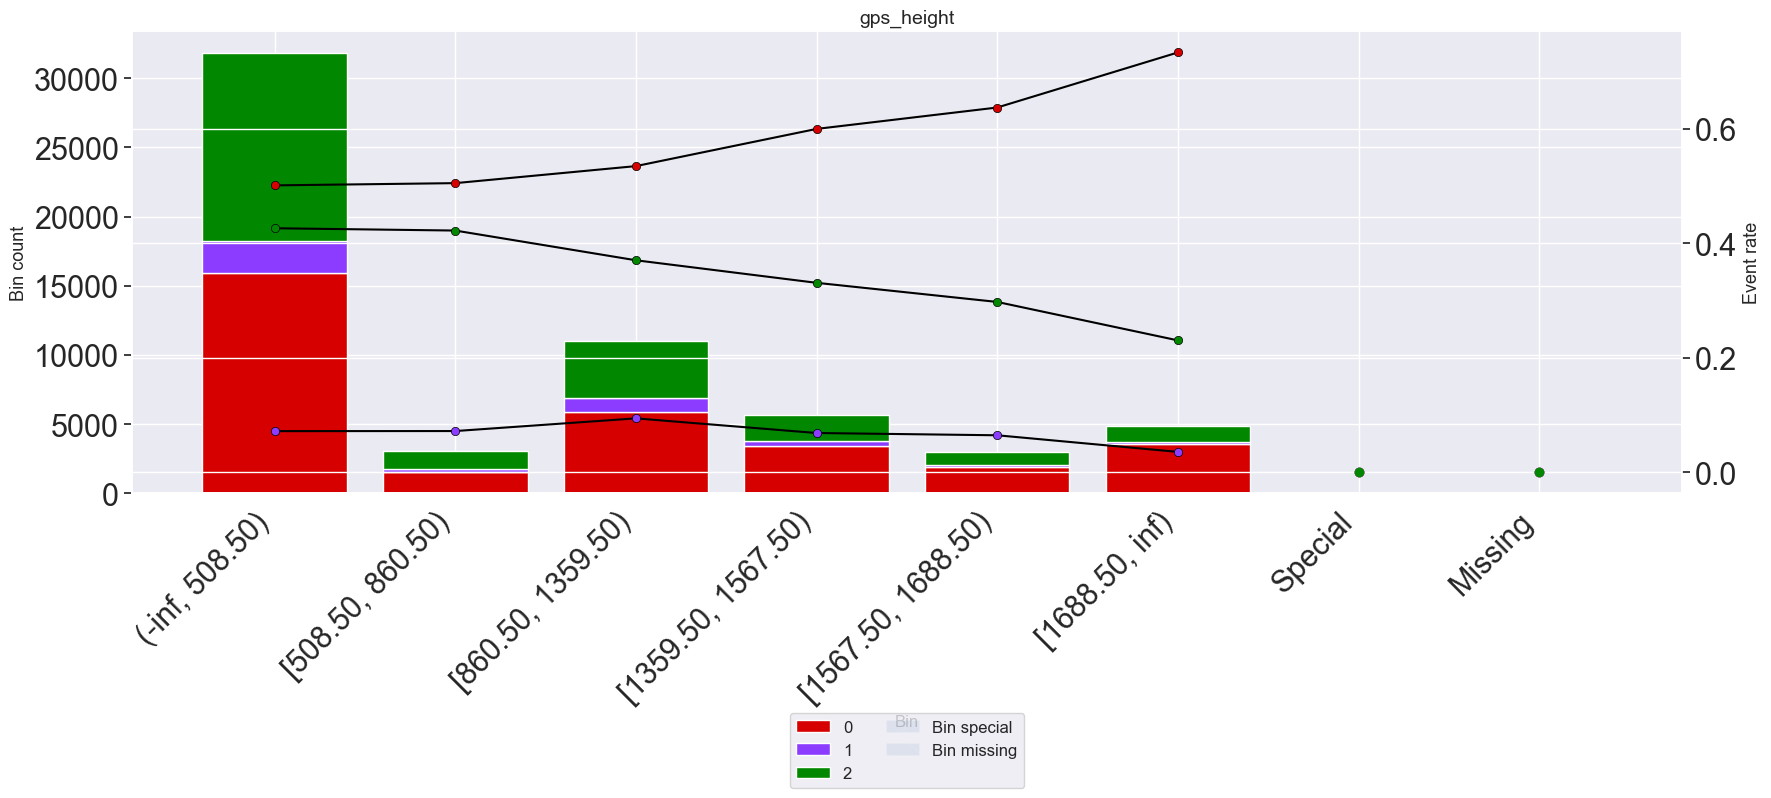

-------------------------------------------------
OptimalBinning: Multiclass Binning Table Analysis
-------------------------------------------------

  General metrics

    JS (Jensen-Shannon)      0.01173689
    HHI                      0.34181407
    HHI (normalized)         0.24778751
    Cramer's V               0.10251524
    Quality score            0.00303235

  Monotonic trend

    Class  0                  ascending
    Class  1                       peak
    Class  2                 descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value
        0      1     0.190521 9.091360e-01
        1      2    33.976583 4.188695e-08
        2      3    73.432314 1.133380e-16
        3      4    11.716510 2.856224e-03
        4      5    90.121388 2.693949e-20



In [137]:
variable = "gps_height"
x = df[variable].values
y = df.status_group

optb = MulticlassOptimalBinning(name=variable, solver="cp")

optb.fit(x, y)
binning_table = optb.binning_table
display(binning_table.build())

binning_table.plot(show_bin_labels=True)

binning_table.analysis()

#### tiene negativos??

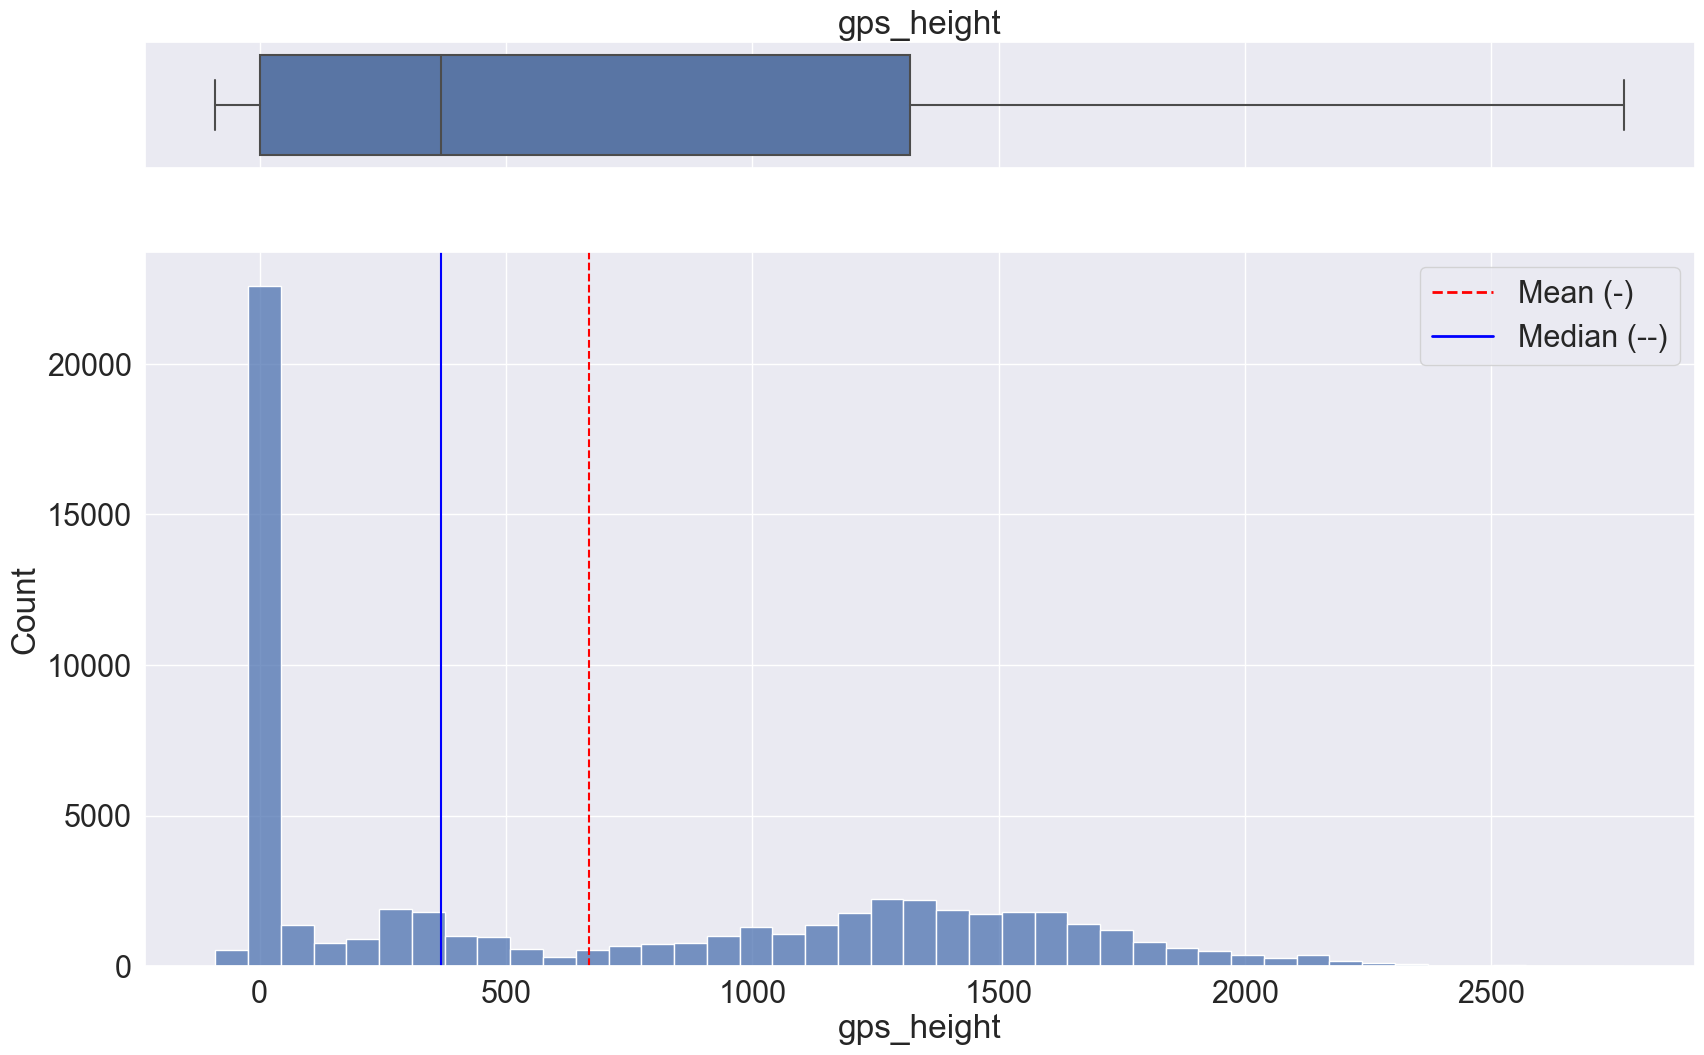

In [138]:
histogram_boxplot(df.gps_height)

In [139]:
df.loc[df["gps_height"]<0,"gps_height"] 
#Tiene negativos, no debería. Además de hacerles binnig se convertirán los negativos en 0

34      -41
152     -15
181     -21
184     -16
249     -19
         ..
59200    -3
59243   -20
59251   -37
59351   -19
59356   -18
Name: gps_height, Length: 1496, dtype: int64

In [140]:
df.loc[df["gps_height"]<0,"gps_height"] = 0

df["gps_height_binned"] = df["gps_height"].copy()

df.loc[df["gps_height"].between(-np.inf,508),"gps_height_binned"] = "bin0"
df.loc[df["gps_height"].between(508,850.5),"gps_height_binned"] = "bin1"

df.loc[df["gps_height"].between(850.5,1359.5),"gps_height_binned"] = "bin2"
df.loc[df["gps_height"].between(1359.5,1567.50),"gps_height_binned"] = "bin3"
df.loc[df["gps_height"].between(1567.50,1688.50),"gps_height_binned"] = "bin4"
df.loc[df["gps_height"].between(1688.50,np.inf),"gps_height_binned"] = "bin5"


df["gps_height_binned"].value_counts()

bin0    31780
bin2    11142
bin3     5704
bin5     4873
bin4     2972
bin1     2929
Name: gps_height_binned, dtype: int64

## population

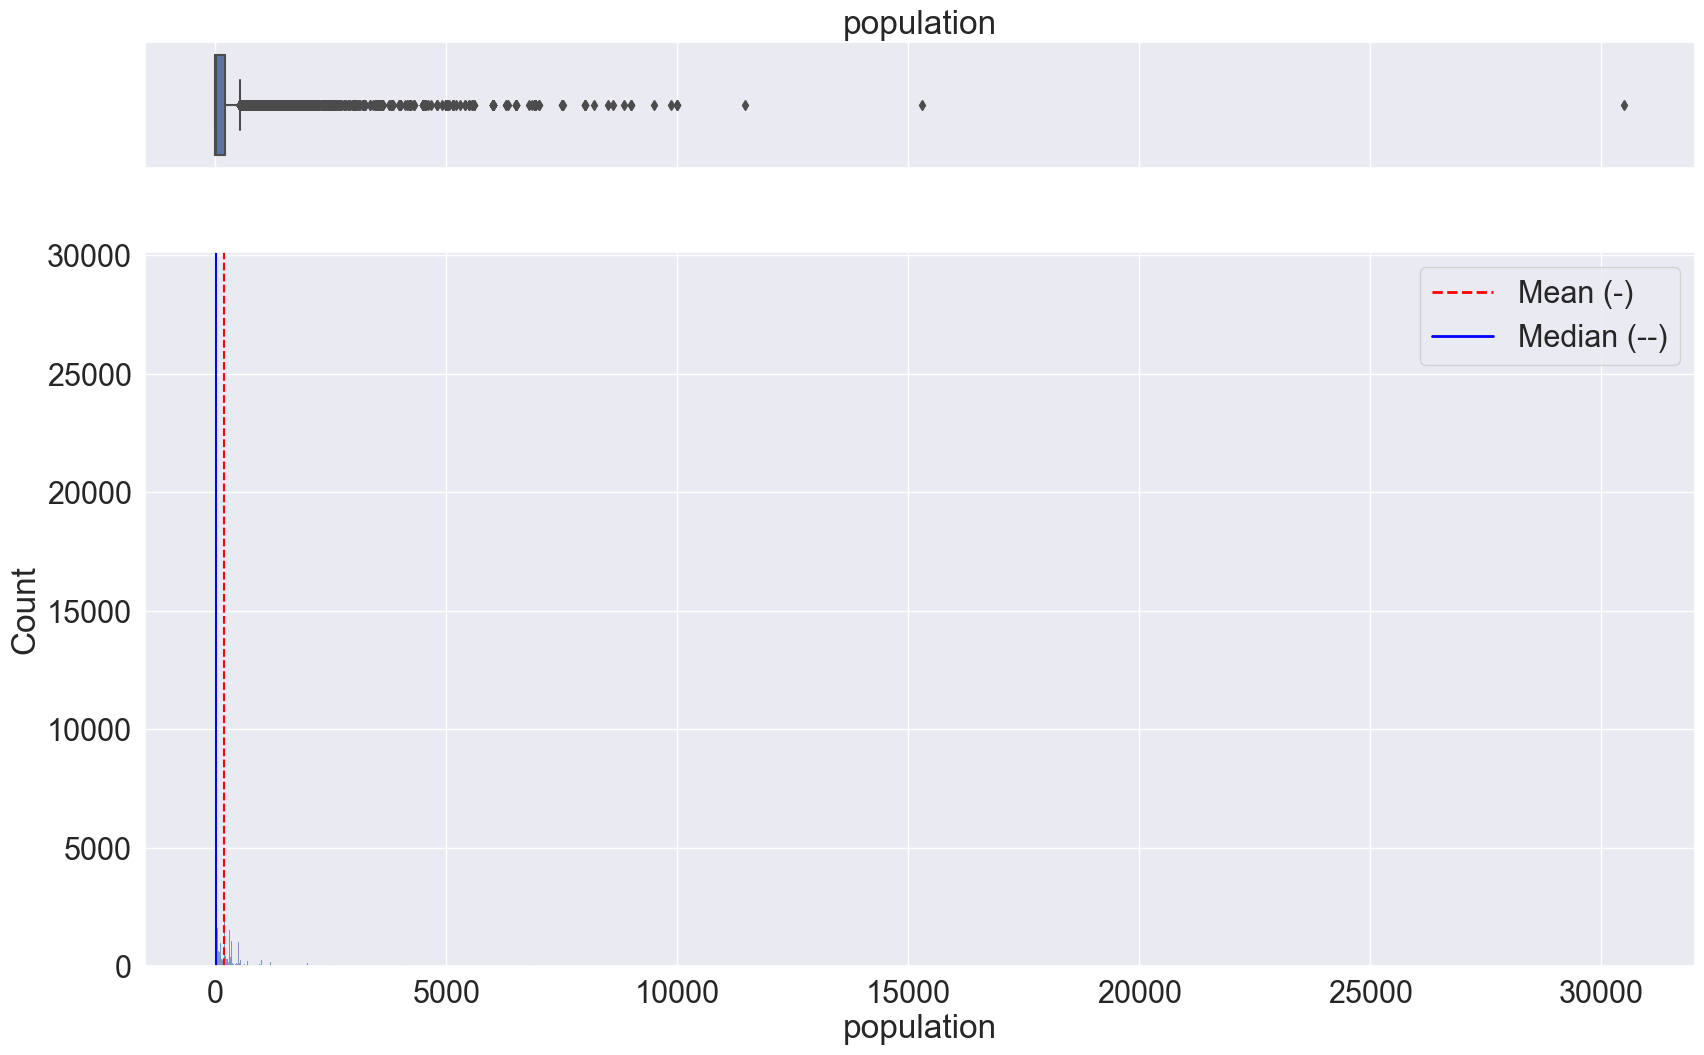

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [141]:
histogram_boxplot(df.population)# centrada al rededor del 0
df.loc[df.population<0,"population"]# sin negativos
df.population.describe()

### el alto std tiene mucho sentido viendo los cuantiles 25 y 75

Bin  Count  Count (%)  Event_0  Event_1  Event_2  \
0       (-inf, 1.50)  28406   0.478215    14185     2129    12092   
1        [1.50, inf)  30994   0.521785    18074     2188    10732   
2            Special      0   0.000000        0        0        0   
3            Missing      0   0.000000        0        0        0   
Totals                59400   1.000000    32259     4317    22824   

        Event_rate_0  Event_rate_1  Event_rate_2  
0           0.499366      0.074949      0.425685  
1           0.583145      0.070594      0.346261  
2           0.000000      0.000000      0.000000  
3           0.000000      0.000000      0.000000  
Totals      0.543081      0.072677      0.384242

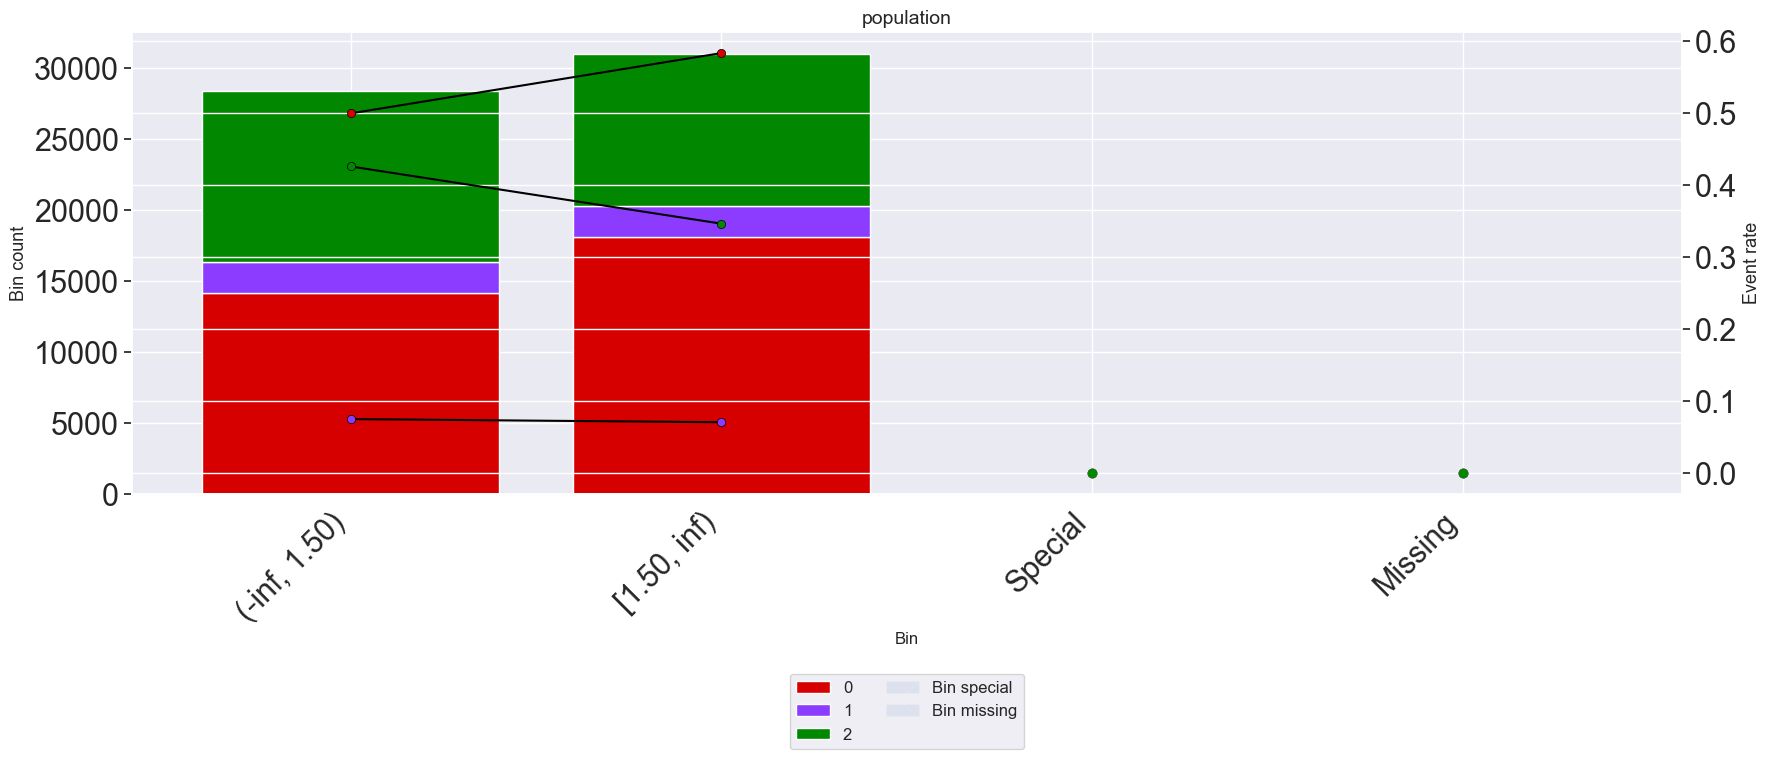

-------------------------------------------------
OptimalBinning: Multiclass Binning Table Analysis
-------------------------------------------------

  General metrics

    JS (Jensen-Shannon)      0.00274191
    HHI                      0.50094913
    HHI (normalized)         0.33459884
    Cramer's V               0.08594498
    Quality score            0.00691865

  Monotonic trend

    Class  0                  ascending
    Class  1                 descending
    Class  2                 descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value
        0      1   438.760454 5.301245e-96



In [142]:
variable = "population"
x = df[variable].values
y = df.status_group

optb = MulticlassOptimalBinning(name=variable, solver="cp")

optb.fit(x, y)
binning_table = optb.binning_table
display(binning_table.build())

binning_table.plot(show_bin_labels=True)

binning_table.analysis()

# Básicamente diferencian nada más entre bins de 1 persona o menos y el resto

In [143]:
df["population_binned"] = df["population"].copy()

df.loc[df["population"].between(-np.inf,1.5),"population_binned"] = "bin0"
df.loc[df["population"].between(1.5,np.inf),"population_binned"] = "bin1"


df["population_binned"].value_counts()

bin1    30994
bin0    28406
Name: population_binned, dtype: int64

## Date recorded, ya está transformado a int

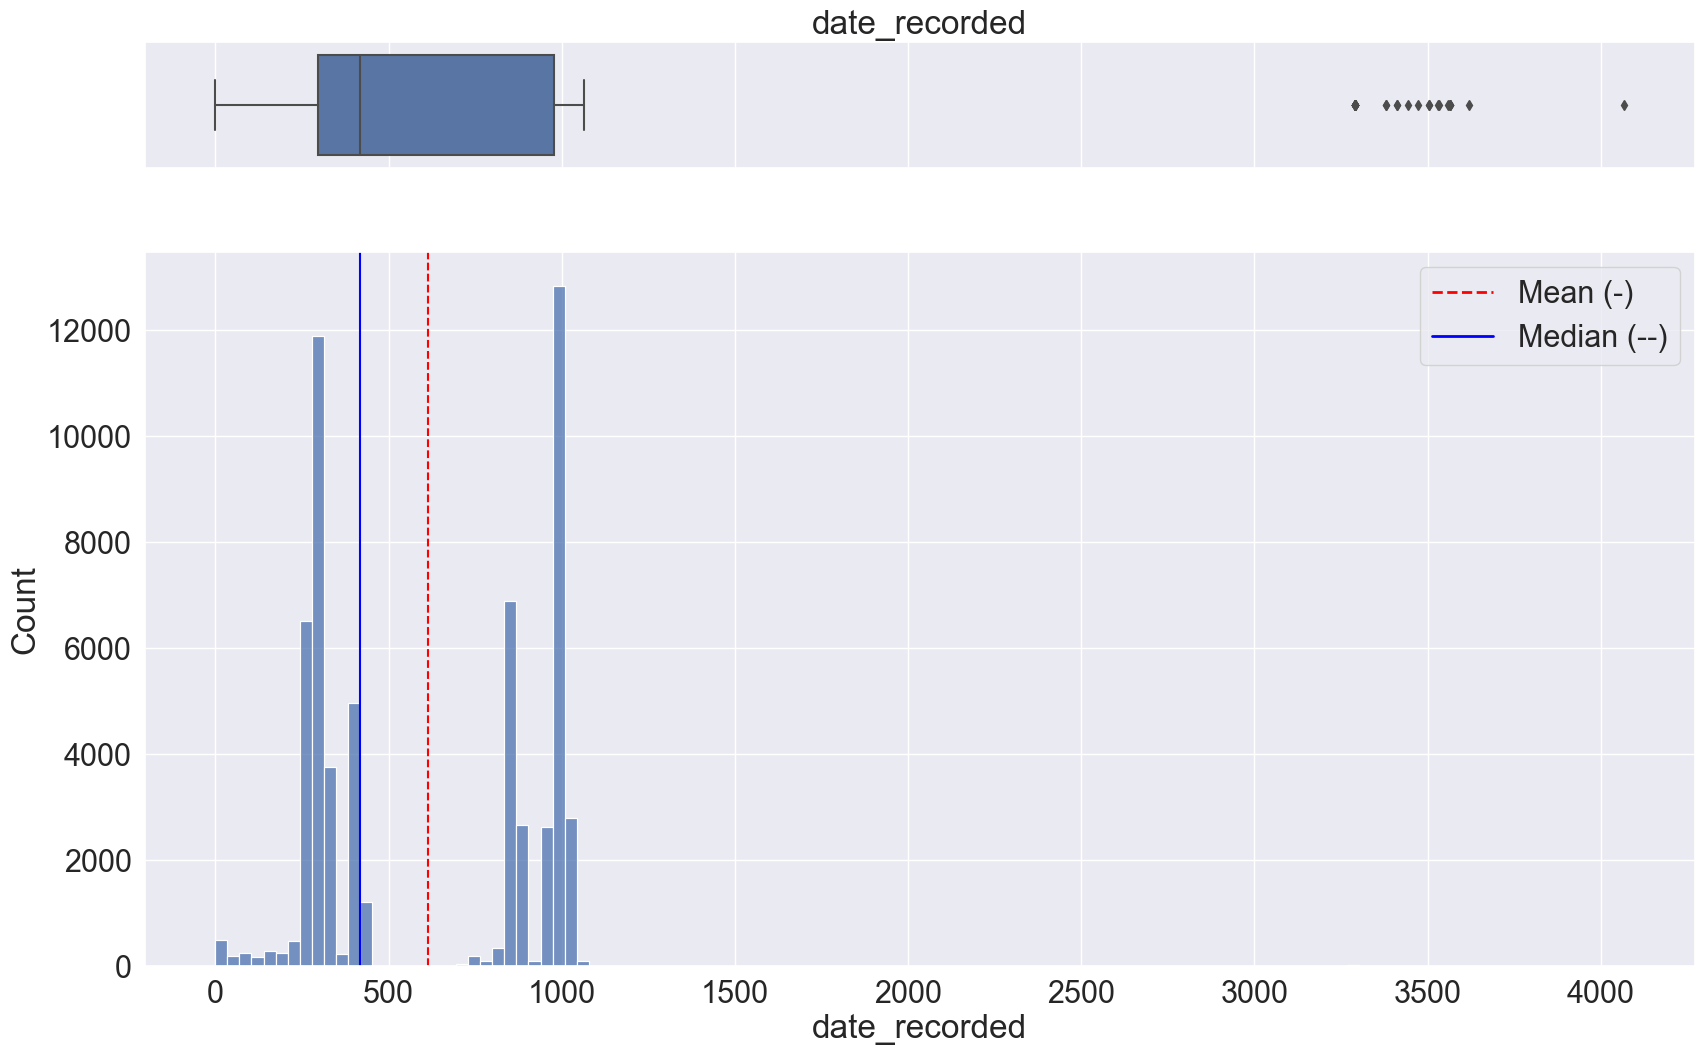

In [151]:
histogram_boxplot(df.date_recorded)# centrada al rededor del 0


Bin  Count  Count (%)  Event_0  Event_1  Event_2  \
0          (-inf, 874.50)  39467   0.664428    20251     3183    16033   
1        [874.50, 981.50)   6453   0.108636     3443      719     2291   
2       [981.50, 1006.50)  10051   0.169209     6310      330     3411   
3          [1006.50, inf)   3429   0.057727     2255       85     1089   
4                 Special      0   0.000000        0        0        0   
5                 Missing      0   0.000000        0        0        0   
Totals                     59400   1.000000    32259     4317    22824   

        Event_rate_0  Event_rate_1  Event_rate_2  
0           0.513112      0.080650      0.406238  
1           0.533550      0.111421      0.355029  
2           0.627798      0.032833      0.339369  
3           0.657626      0.024789      0.317585  
4           0.000000      0.000000      0.000000  
5           0.000000      0.000000      0.000000  
Totals      0.543081      0.072677      0.384242

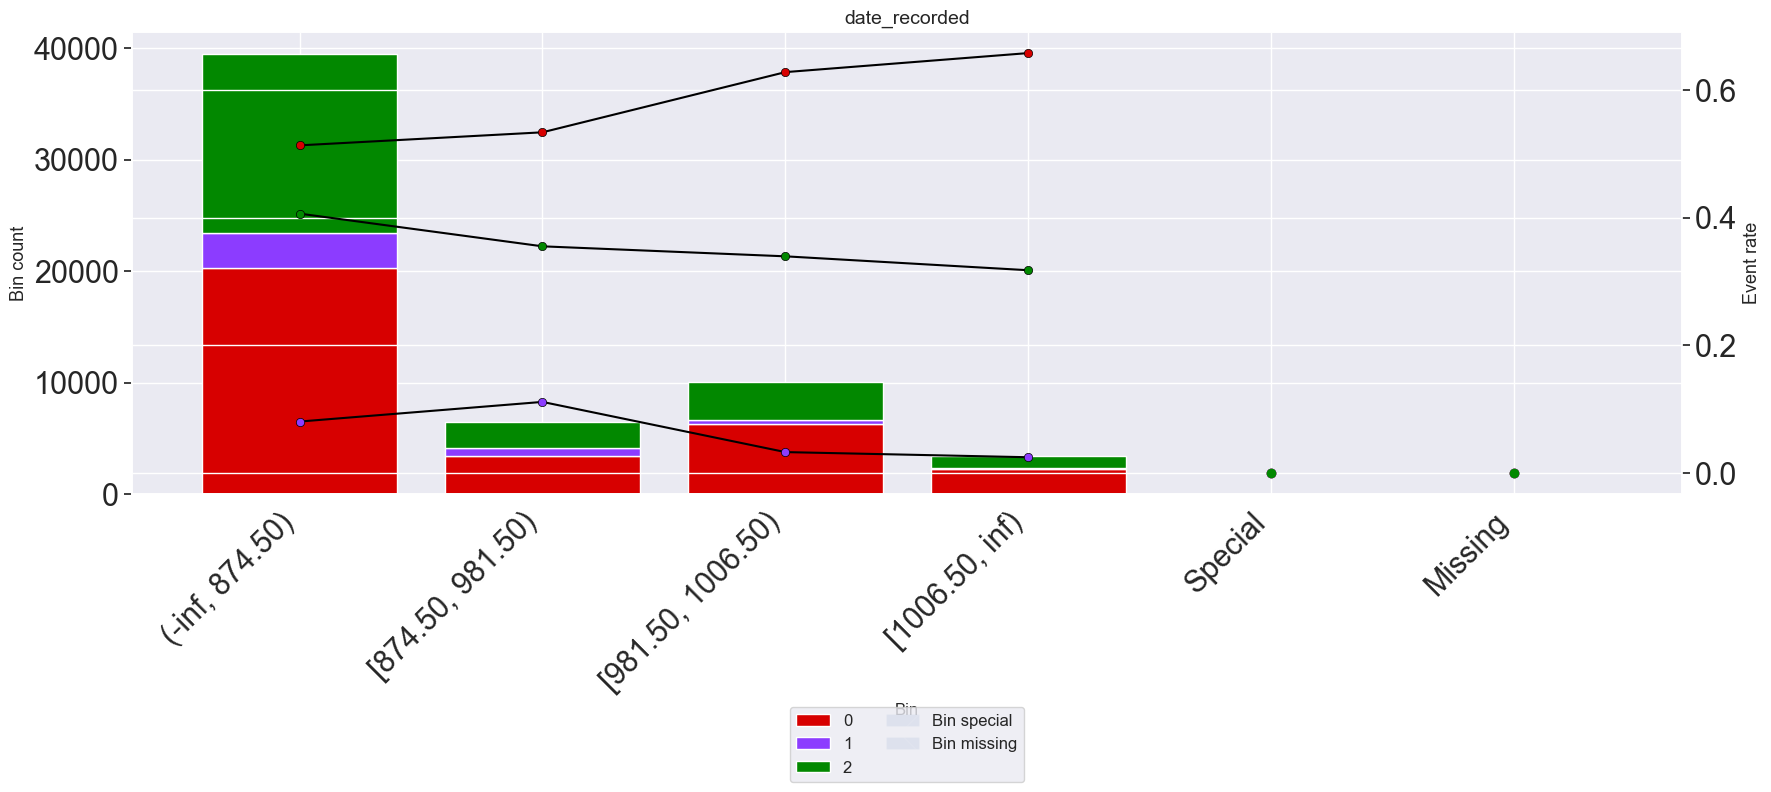

-------------------------------------------------
OptimalBinning: Multiclass Binning Table Analysis
-------------------------------------------------

  General metrics

    JS (Jensen-Shannon)      0.01908450
    HHI                      0.48522995
    HHI (normalized)         0.38227594
    Cramer's V               0.08866431
    Quality score            0.04458081

  Monotonic trend

    Class  0                  ascending
    Class  1                       peak
    Class  2                 descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value
        0      1   102.740101 4.900841e-23
        1      2   443.728670 4.421234e-97
        2      3    12.588199 1.847172e-03



In [152]:
variable = "date_recorded"
x = df[variable].values
y = df.status_group

optb = MulticlassOptimalBinning(name=variable, solver="cp")

optb.fit(x, y)
binning_table = optb.binning_table
display(binning_table.build())

binning_table.plot(show_bin_labels=True)

binning_table.analysis()

In [154]:
df["date_recorded_binned"] = df["date_recorded"].copy()

df.loc[df["date_recorded"].between(-np.inf,874.50),"date_recorded_binned"] = "bin0"
df.loc[df["date_recorded"].between(874.50,981.50),"date_recorded_binned"] = "bin1"

df.loc[df["date_recorded"].between(981.50,1006.50),"date_recorded_binned"] = "bin2"
df.loc[df["date_recorded"].between(1006.50,np.inf),"date_recorded_binned"] = "bin3"


df["date_recorded_binned"].value_counts()

bin0    39467
bin2    10051
bin1     6453
bin3     3429
Name: date_recorded_binned, dtype: int64

## Construction_year: drop

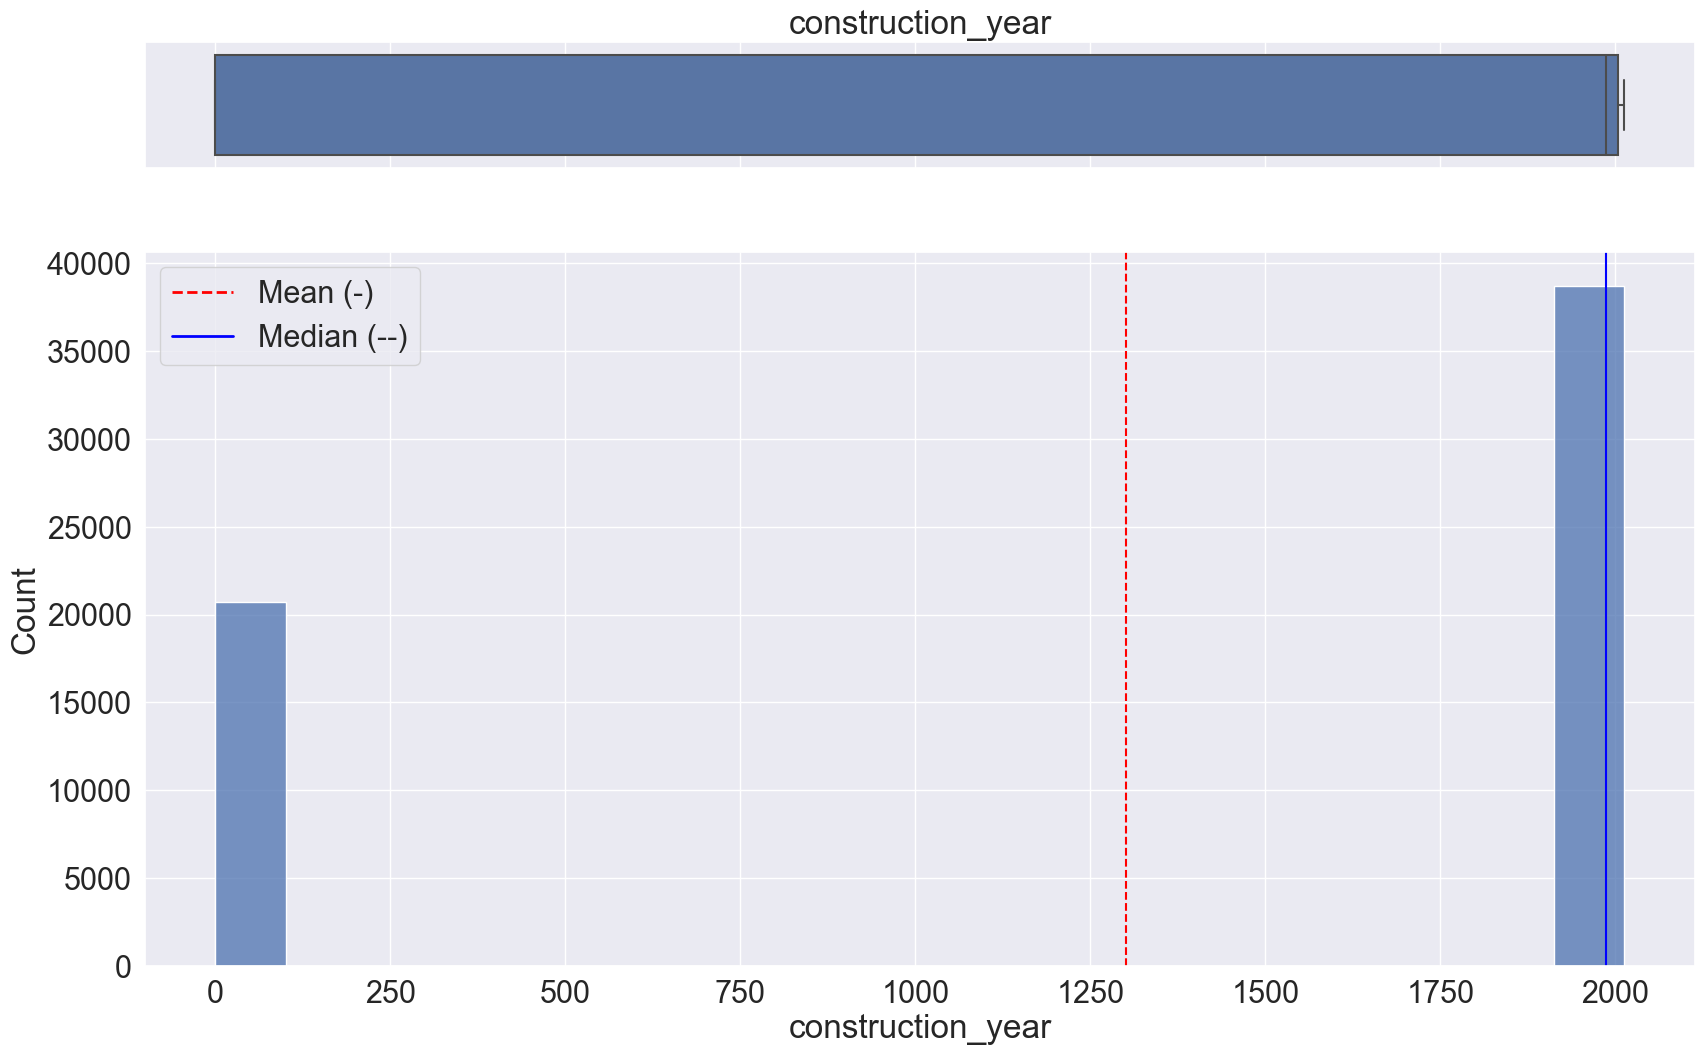

la variable construction_year tiene una mísera asociaciónde cramer de 0.055 y tan solo el 65% tienen un valor con sentido


In [170]:
histogram_boxplot(df.construction_year)
df.construction_year.min()#año 0
df.loc[df.construction_year==0]# 20709 rows!!!
df.shape[0]-df.loc[df.construction_year==0].shape[0]
rows_no_cero = df.loc[df.construction_year!=0].shape[0]
porcentaje_rows_no_creo = rows_no_cero/df.shape[0]
porcentaje_rows_no_creo = str(porcentaje_rows_no_creo)[2:4]+"%"
cramer = jd.cramers_v(df.construction_year,df.status_group)

print(f"la variable construction_year tiene una mísera asociaciónde cramer de {round(cramer,4)} y tan solo el {porcentaje_rows_no_creo} tienen un valor con sentido")

### Lo que mejor resultados dio fue reemplazar el año 0 por NAs e imputar.

### Así es su distribución:

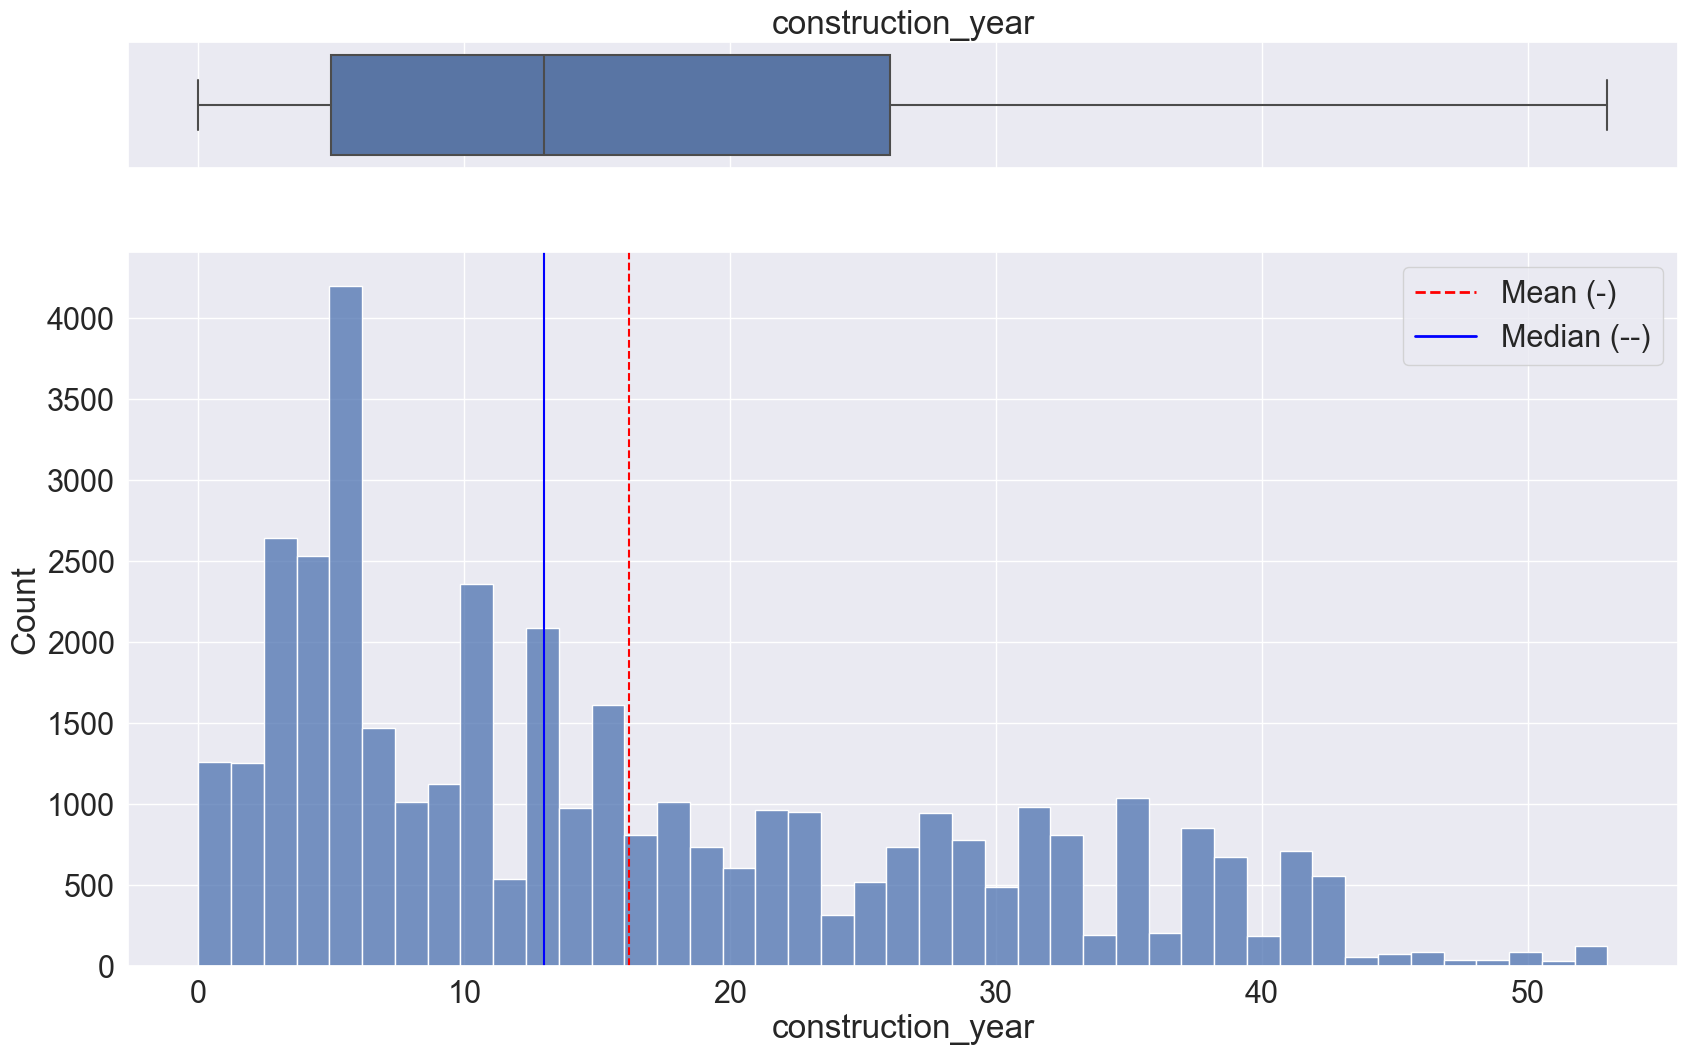

In [223]:
para_plot = df[df.construction_year != 0].construction_year.apply(lambda x: df.construction_year.max()-x)

histogram_boxplot(para_plot)

# Muestro el Binnning para ilustrar la relación de construction_year con el target, pero me parece que pueda aportar mucho haciendo trameo de una variable con casi la mitad de los datos como NAs.

### Viendo el gráfico podemos darnos cuenta de por qué aportó la inclusión de la variable algo positivo a nuestro modelo, conforme aumenta tiempo desde construction year disminuye event0 y aumenta event dos de manera muy muy clara.

Bin  Count  Count (%)  Event_0  Event_1  Event_2  \
0         (-inf, 3.50)   5161   0.133390     3794      220     1147   
1         [3.50, 4.50)   2533   0.065467     1774      138      621   
2         [4.50, 6.50)   4200   0.108552     2920      243     1037   
3        [6.50, 15.50)  10542   0.272466     6531      730     3281   
4       [15.50, 27.50)   7306   0.188829     3668      511     3127   
5         [27.50, inf)   8949   0.231294     3017      686     5246   
6              Special      0   0.000000        0        0        0   
7              Missing      0   0.000000        0        0        0   
Totals                  38691   1.000000    21704     2528    14459   

        Event_rate_0  Event_rate_1  Event_rate_2  
0           0.735129      0.042627      0.222244  
1           0.700355      0.054481      0.245164  
2           0.695238      0.057857      0.246905  
3           0.619522      0.069247      0.311231  
4           0.502053      0.069943      0.428004  
5           0.337133      0.076657      0.586211  
6           0.000000      0.000000      0.000000  
7           0.000000      0.000000      0.000000  
Totals      0.560957      0.065338      0.373704

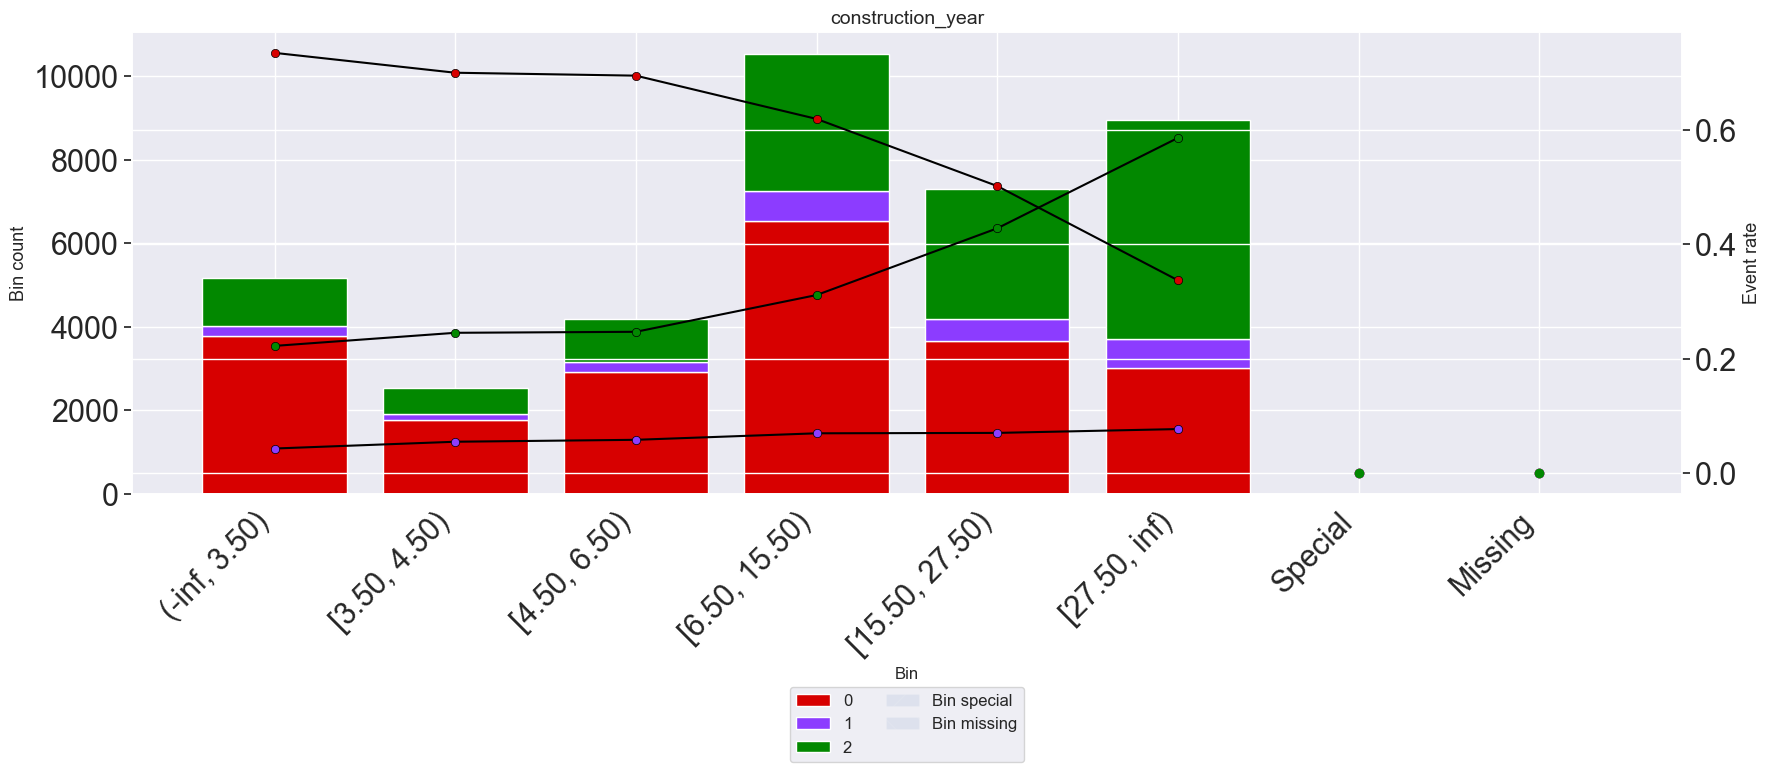

In [225]:
variable = "construction_year"
x = para_plot.values
y = df[df.construction_year != 0].status_group

optb = MulticlassOptimalBinning(name=variable, solver="cp")

optb.fit(x, y)
binning_table = optb.binning_table
display(binning_table.build())

binning_table.plot(show_bin_labels=True)

In [146]:
"""
df.loc[df.date_recorded ==0,"date_recorded"] = np.nan
df.date_recorded = df.date_recorded.astype("O")
df.date_recorded = pd.to_datetime(df.date_recorded)
df['date_recorded'] = (df.date_recorded.max() - df.date_recorded).dt.days
df.date_recorded
"""

'\ndf.loc[df.date_recorded ==0,"date_recorded"] = np.nan\ndf.date_recorded = df.date_recorded.astype("O")\ndf.date_recorded = pd.to_datetime(df.date_recorded)\ndf[\'date_recorded\'] = (df.date_recorded.max() - df.date_recorded).dt.days\ndf.date_recorded\n'

### Funder e installer tienen unos valores extraños, wpt_name tiene uno solo, este solo en el encoder se va a ir en la categoría de no frecuentes, no me preocupa

In [203]:
[(idx,val) for (idx,val) in enumerate(df.installer) if str(val).isdigit()]# el único dígito es cero
[(idx,val) for (idx,val) in enumerate(df.funder) if str(val).isdigit()]# el único dígito es cero


[(idx,val) for (idx,val) in enumerate(df.installer) if str(val).isdigit()and val !="0"]# el único dígito es cero
[(idx,val) for (idx,val) in enumerate(df.funder) if str(val).isdigit()and val !="0"]# el único dígito es cero




[]

In [ ]:
df.loc[df.funder=="0","funder"] = np.nan
df.loc[df.installer=="0","installer"] = np.nan
df.loc[df.installer=="-","installer"] = np.nan

In [172]:
[(x,y) for (x,y) in df.isna().sum().items() if y!=0]

[('funder', 3635),
 ('installer', 3655),
 ('subvillage', 371),
 ('public_meeting', 3334),
 ('scheme_management', 3877),
 ('scheme_name', 28166),
 ('permit', 3056)]

In [216]:
columnas_NA = ["funder","installer","subvillage","public_meeting","scheme_management","scheme_name","permit"]
for i in columnas_NA: 
    df[i+"isNA"] = df[i].copy()
    df[i+"isNA"] = df[i+"isNA"].isna().astype(int)


In [237]:
df.public_meetingisNA.value_counts(dropna=False)

0    56066
1     3334
Name: public_meetingisNA, dtype: int64

# Volveré a usar la mejor lista para ver qué tal le va con las nuevas partes del procesamiento

In [4]:
def preprocess(X):
    X = X.copy()
    for i in X.select_dtypes(include = "O").columns:
        X[i] = X[i].astype("category")

    #Fechas------------------------------------------------------------------------ 
    X.date_recorded = X.date_recorded.astype("O")
    X.date_recorded = pd.to_datetime(X.date_recorded)
    X['date_recorded'] = (X.date_recorded.max() - X.date_recorded).dt.days
    X.district_code = X.district_code.astype("category")
    X.region_code = X.region_code.astype("category")
    #Marcar 0 en amount como dijo optbinning------------------------------------------------------------------------   
    X["amount_tsh_binned"] = X["amount_tsh"].copy()
    X.loc[X["amount_tsh_binned"].between(-np.inf,1.5),"amount_tsh_binned"] = 0
    X.loc[X["amount_tsh_binned"].between(1.5,np.inf),"amount_tsh_binned"] = 1
    X["amount_tsh_binned"] = X["amount_tsh_binned"].astype("category")
    #gps_heightoptbinning------------------------------------------------------------------------  
    X.loc[X["gps_height"]<0,"gps_height"] = 0
    X["gps_height_binned"] = X["gps_height"].copy()
    X.loc[X["gps_height"].between(-np.inf,508),"gps_height_binned"] = "bin0"
    X.loc[X["gps_height"].between(508,850.5),"gps_height_binned"] = "bin1"
    X.loc[X["gps_height"].between(850.5,1359.5),"gps_height_binned"] = "bin2"
    X.loc[X["gps_height"].between(1359.5,1567.50),"gps_height_binned"] = "bin3"
    X.loc[X["gps_height"].between(1567.50,1688.50),"gps_height_binned"] = "bin4"
    X.loc[X["gps_height"].between(1688.50,np.inf),"gps_height_binned"] = "bin5"
    X["gps_height_binned"] = X["gps_height_binned"].astype("category")
    #population_binned optbinning------------------------------------------------------------------------ 
    X["population_binned"] = X["population"].copy()
    X.loc[X["population"].between(-np.inf,1.5),"population_binned"] = "bin0"
    X.loc[X["population"].between(1.5,np.inf),"population_binned"] = "bin1"
    X["population_binned"] = X["population_binned"].astype("category")
    #Marcar 0 en amount como dijo optbinning------------------------------------------------------------------------  
    X["date_recorded_binned"] = X["date_recorded"].copy()
    X.loc[X["date_recorded"].between(-np.inf,874.50),"date_recorded_binned"] = "bin0"
    X.loc[X["date_recorded"].between(874.50,981.50),"date_recorded_binned"] = "bin1"
    X.loc[X["date_recorded"].between(981.50,1006.50),"date_recorded_binned"] = "bin2"
    X.loc[X["date_recorded"].between(1006.50,np.inf),"date_recorded_binned"] = "bin3"
    X["date_recorded_binned"] = X["date_recorded_binned"].astype("category")
    #Marcar VALORES sin sentido como nan para ser imputados------------------------------------------------------------------------  
    X["construction_year"] = X.construction_year.max()-X.construction_year
    X.loc[X["construction_year"] ==2013,"construction_year"] = np.nan # si da 2013 la resta fue max - cero
    
    X.loc[X.funder=="0","funder"] = np.nan
    X.loc[X.installer=="0","installer"] = np.nan
    X.loc[X.installer=="-","installer"] = np.nan
    #Drop list ------------------------------------------------------------------------ 
   
    drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]

    #el drop list 0.8170 más "construction_year"

    #Clusters de latitud y longitud------------------------------------------------------------------------   
    X.drop(drop_list,axis=1,inplace=True)
    #clustering = KMeans(n_clusters=20)
    #X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())
    columnas_NA = ["funder","installer","subvillage","public_meeting","scheme_management","scheme_name","construction_year"]#permit
    for i in columnas_NA: 
        X[i+"isNA"] = X[i].copy()
        X[i+"isNA"]= X[i+"isNA"].isna().astype(int)
        X[i+"isNA"] = X[i+"isNA"].astype("category")
    return X

In [5]:
def encode(X,y,column,tipo,OrdinalEncoder_cols,OnehotEnc_cols,TargetEnc_cols,FrequencyEnc_cols,
           Ordinal_ordered_Encoder_cols,polinomial_cols,helmert_cols, num_cols):
    X_copy = X.copy()
    y_copy = y.copy()

    preprocessing = ColumnTransformer([
        ('ordinal', OrdinalEncoder(handle_unknown="use_encoded_value",
                                    unknown_value=10000000,
                                    encoded_missing_value =10000001,
                                    min_frequency = 0.01), OrdinalEncoder_cols),
        ("ordinal_ordered", feat_eng_OrdinalCategoricalEncoder(encoding_method='ordered',
                                                               variables=None,
                                                               missing_values='ignore'),Ordinal_ordered_Encoder_cols),
        ("polinomial",PolynomialEncoder(),polinomial_cols),
        ("helmert",HelmertEncoder(),helmert_cols),
        ('onehot', OneHotEncoder(max_categories=7,# Si existen más de 6 valores únicos crea categoría "infrequent"
                                    handle_unknown ="infrequent_if_exist",
                                    drop="first",sparse_output=False), OnehotEnc_cols),

        ('target', TargetEncoder(target_type="multiclass",
                                    cv=2,), TargetEnc_cols),  # default cv 5 me tardaría una eternidad
                                    
        ('Frequency', CountEncoder(handle_unknown="value",
                                    handle_missing="value"), FrequencyEnc_cols),                             
        ('scaler', StandardScaler(), num_cols),  
    ],
    remainder = "passthrough",
    )

    #X_copy = pd.DataFrame(data=preprocessing.fit_transform(X_copy,y=y_copy.status_group.values), columns=preprocessing.get_feature_names_out())
    X_copy = pd.DataFrame(data=preprocessing.fit_transform(X_copy,y=y_copy), columns=preprocessing.get_feature_names_out())
    
    
    if tipo == "train_test":
        X_train, X_test, y_train, y_test = train_test_split(X_copy, y_copy, test_size=0.2, random_state=23)
        rf = RandomForestClassifier(n_jobs=-1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_test)
        score = accuracy_score(y_test,y_pred)

    elif tipo == "KFold":
        rf = RandomForestClassifier(n_jobs=-1)
        score = cross_validate(rf, X_copy, y_copy, cv=4,scoring = "accuracy",n_jobs=-1)["test_score"].mean()

    return score

In [6]:
def best_encoding_technique(tipo = "train_test",cols = "all"):
    """
    Función que eliminará subjetividad de la elección de técnica de encoding.
    Probará las siguientes técnicas con validación cruzada repetida o con un X_test

    se hace sin previamente imputar porque para imputar por un imputador no simple deja error:
    ValueError: Cannot cast object dtype to float64.
    Se imputará con el propio encoder usando una de las técnicas de imputación que viene con ellos por defecto
    """
    
    X = pd.read_csv("In/Training_set_values.csv")#uso X y Y frescas 
    y = pd.read_csv("In/Training_set_labels.csv")

    le= LabelEncoder()
    #y["status_group"] = le.fit_transform(y.status_group)
    y = le.fit_transform(y.status_group)
    
    X = preprocess(X)
    
    if cols == "all":
        cols_to_test = X.select_dtypes(exclude=np.number).columns.tolist()
    else:
        cols_to_test = cols


    num_cols = X.select_dtypes(include=np.number).columns.tolist()

    OrdinalEncoder_cols = X.select_dtypes(exclude=np.number).columns.tolist()
    OnehotEnc_cols = []
    TargetEnc_cols = []
    FrequencyEnc_cols = [] 
    Ordinal_ordered_Encoder_cols = []
    polinomial_cols = []
    helmert_cols = []
    
    #Lstimosamente polinomial_cols y helmert_cols se tardan demasiado,la función se hubiese tardado unas dos horas
    #en completar al ritmo que iba (aún usando n_jobs =-1 siempre que se podía)
    my_dict = {
    "OrdinalEncoder_cols": OrdinalEncoder_cols,
    "OnehotEnc_cols": OnehotEnc_cols,
    "TargetEnc_cols": TargetEnc_cols,
    "FrequencyEnc_cols": FrequencyEnc_cols,
    "ordinal_ordered":Ordinal_ordered_Encoder_cols,
    #"polinomiales":polinomial_cols,
   # "helmert":helmert_cols
    }
    encoder_list = [OrdinalEncoder_cols,OnehotEnc_cols,TargetEnc_cols,FrequencyEnc_cols,
                    Ordinal_ordered_Encoder_cols,polinomial_cols,helmert_cols]

    for column in cols_to_test:
        list_to_keep_track_of_score = []

        for encoder,printea in zip(my_dict.values(),my_dict.keys()):
            #remove if exists from all lists
            if column in OrdinalEncoder_cols:
                OrdinalEncoder_cols.remove(column)

            elif column in OnehotEnc_cols:
                OnehotEnc_cols.remove(column)

            elif column in TargetEnc_cols:
                TargetEnc_cols.remove(column)

            elif column in FrequencyEnc_cols:
                FrequencyEnc_cols.remove(column)
            #
            elif column in Ordinal_ordered_Encoder_cols:
                Ordinal_ordered_Encoder_cols.remove(column)
            elif column in polinomial_cols:
                FrequencyEnc_cols.remove(column)
            elif column in helmert_cols:
                FrequencyEnc_cols.remove(column)

            #appendo a lista respectiva y le saco el socore
            encoder.append(column)
            #print(printea)
            score = encode(X,y,column,tipo,OrdinalEncoder_cols,OnehotEnc_cols,TargetEnc_cols,FrequencyEnc_cols,
                           Ordinal_ordered_Encoder_cols,polinomial_cols,helmert_cols, num_cols)
            list_to_keep_track_of_score.append(score)
            #Lo saco de la columna testeada
            encoder.remove(column)

        print(f"{column}: listo")
        # Lo apendo 
        encoder_list[np.argmax(list_to_keep_track_of_score)].append(column)        
    return my_dict

drop_modelo_ceroochounocinco  = ["management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]

In [7]:
# dont_test son las que ya sabemos son muy muy poco importantes y este programa es costoso y lento, las asigno todas a OrdinalEnc
dont_test = ["id","management_group","num_private","recorded_by","region","region_code",
              "extraction_type_group","extraction_type_class","payment","quality_group",
              "quantity_group","source_class","source_type","waterpoint_type_group",
              "permit","population","amount_tsh"]

columnas = [x for x in X.select_dtypes(exclude=np.number).columns.tolist() if x not in dont_test]
columnas.remove("date_recorded")# se pasa a int en preprocess
columnas

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'lga',
 'ward',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'extraction_type',
 'management',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type']

In [40]:
"""
dict = best_encoding_technique(tipo="KFold",cols=columnas)
for key,val in zip(dict.keys(),dict.values()):
    print("---------------------------------------------------------------")
    print(f"variables en {key.upper()}")
    print(val)
"""

"""
---------------------------------------------------------------
variables en ORDINALENCODER_COLS
['region', 'region_code', 'district_code', 'extraction_type_group', 'extraction_type_class', 'payment', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group', 'amount_tsh_binned', 'gps_height_binned', 'population_binned', 'date_recorded_binned', 'funderisNA', 'installerisNA', 'subvillageisNA', 'public_meetingisNA', 'scheme_managementisNA', 'scheme_nameisNA', 'construction_yearisNA', 'public_meeting']
---------------------------------------------------------------
variables en ONEHOTENC_COLS
['basin', 'waterpoint_type']
---------------------------------------------------------------
variables en TARGETENC_COLS
['scheme_management', 'payment_type', 'water_quality']
---------------------------------------------------------------
variables en FREQUENCYENC_COLS
['installer', 'source']
---------------------------------------------------------------
variables en ORDINAL_ORDERED
['funder', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name', 'extraction_type', 'management', 'quantity']

"""

"\n---------------------------------------------------------------\nvariables en ORDINALENCODER_COLS\n['region', 'region_code', 'district_code', 'extraction_type_group', 'extraction_type_class', 'payment', 'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group', 'amount_tsh_binned', 'gps_height_binned', 'population_binned', 'date_recorded_binned', 'funderisNA', 'installerisNA', 'subvillageisNA', 'public_meetingisNA', 'scheme_managementisNA', 'scheme_nameisNA', 'construction_yearisNA', 'public_meeting']\n---------------------------------------------------------------\nvariables en ONEHOTENC_COLS\n['basin', 'waterpoint_type']\n---------------------------------------------------------------\nvariables en TARGETENC_COLS\n['scheme_management', 'payment_type', 'water_quality']\n---------------------------------------------------------------\nvariables en FREQUENCYENC_COLS\n['installer', 'source']\n-------------------------------------------------------------

In [39]:
# no me queda muy claro de la docu qué pasa con los missings en este encoder
prueba_que_hace_con_missings = feat_eng_OrdinalCategoricalEncoder(encoding_method='ordered',
                                                               variables=None,
                                                               missing_values='ignore')
#X.isna().sum()
print(f"cantidad de NAs inicial: {X.funder.isna().sum()}")

despues = prueba_que_hace_con_missings.fit_transform(X[["funder"]],LabelEncoder().fit_transform(y.status_group))
despues.funder.isna().sum()
print(f"cantidad de NAs después de ordinal encoder ordenado: {despues.funder.isna().sum()}")

# Los deja quietos, justo lo que necesitaba (era un poco obvio por missing_values='ignore') pero mejor prevenir que lamentar )

cantidad de NAs inicial: 3635
cantidad de NAs después de ordinal encoder ordenado: 3635


# El mayor reto de este trabajo es que la validación cruzada es muy poco útil, esta función elige el mejor encoding basándose en validación cruzada, pero en el submission real empeora el desempeño.

# Usando los resultados de esta función disminuyó mi score, lo cual no tiene mucho sentido, pues elige el mejor encoder en base a validación cruzada.

# Investigué bastante cómo resolver el problema.

### Usaré "Adversarial Validation" para determinar qué tan distintos son los datos del X_train y el X_test.

### Luego utilizaré un algoritmo de machine learning para crear un X de validación representativo y así poder determinar qué ayudará al poder predictivo de mi modelo.


# Adversserial validation básicamente etiqueta los datos de train y test acorde a su grupo y luego corre un modelo de machine learning en base a esta etiqueta. Si el modelo consigue una buena curva roc_auc los dos datasets son bastante distintos el uno del otro.

https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation

In [42]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv

In [47]:
def preprocess(X):
    X = X.copy()
    for i in X.select_dtypes(include = "O").columns:
        X[i] = X[i].astype("category")

    #Fechas------------------------------------------------------------------------ 
    X.date_recorded = X.date_recorded.astype("O")
    X.date_recorded = pd.to_datetime(X.date_recorded)
    X['date_recorded'] = (X.date_recorded.max() - X.date_recorded).dt.days
    X.district_code = X.district_code.astype("category")
    X.region_code = X.region_code.astype("category")
    #Marcar 0 en amount como dijo optbinning------------------------------------------------------------------------   
    X["amount_tsh_binned"] = X["amount_tsh"].copy()
    X.loc[X["amount_tsh_binned"].between(-np.inf,1.5),"amount_tsh_binned"] = 0
    X.loc[X["amount_tsh_binned"].between(1.5,np.inf),"amount_tsh_binned"] = 1
    X["amount_tsh_binned"] = X["amount_tsh_binned"].astype("category")
    #gps_heightoptbinning------------------------------------------------------------------------  
    X.loc[X["gps_height"]<0,"gps_height"] = 0
    X["gps_height_binned"] = X["gps_height"].copy()
    X.loc[X["gps_height"].between(-np.inf,508),"gps_height_binned"] = "bin0"
    X.loc[X["gps_height"].between(508,850.5),"gps_height_binned"] = "bin1"
    X.loc[X["gps_height"].between(850.5,1359.5),"gps_height_binned"] = "bin2"
    X.loc[X["gps_height"].between(1359.5,1567.50),"gps_height_binned"] = "bin3"
    X.loc[X["gps_height"].between(1567.50,1688.50),"gps_height_binned"] = "bin4"
    X.loc[X["gps_height"].between(1688.50,np.inf),"gps_height_binned"] = "bin5"
    X["gps_height_binned"] = X["gps_height_binned"].astype("category")
    #population_binned optbinning------------------------------------------------------------------------ 
    X["population_binned"] = X["population"].copy()
    X.loc[X["population"].between(-np.inf,1.5),"population_binned"] = "bin0"
    X.loc[X["population"].between(1.5,np.inf),"population_binned"] = "bin1"
    X["population_binned"] = X["population_binned"].astype("category")
    #Marcar 0 en amount como dijo optbinning------------------------------------------------------------------------  
    X["date_recorded_binned"] = X["date_recorded"].copy()
    X.loc[X["date_recorded"].between(-np.inf,874.50),"date_recorded_binned"] = "bin0"
    X.loc[X["date_recorded"].between(874.50,981.50),"date_recorded_binned"] = "bin1"
    X.loc[X["date_recorded"].between(981.50,1006.50),"date_recorded_binned"] = "bin2"
    X.loc[X["date_recorded"].between(1006.50,np.inf),"date_recorded_binned"] = "bin3"
    X["date_recorded_binned"] = X["date_recorded_binned"].astype("category")
    #Marcar VALORES sin sentido como nan para ser imputados------------------------------------------------------------------------  
    X["construction_year"] = X.construction_year.max()-X.construction_year
    X.loc[X["construction_year"] ==2013,"construction_year"] = np.nan # si da 2013 la resta fue max - cero
    
    X.loc[X.funder=="0","funder"] = np.nan
    X.loc[X.installer=="0","installer"] = np.nan
    X.loc[X.installer=="-","installer"] = np.nan
    #Drop list ------------------------------------------------------------------------ 
   
    drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]

    #el drop list 0.8170 más "construction_year"

    #Clusters de latitud y longitud------------------------------------------------------------------------   
    X.drop(drop_list,axis=1,inplace=True)
    #clustering = KMeans(n_clusters=20)
    #X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())
    columnas_NA = ["funder","installer","subvillage","public_meeting","scheme_management","scheme_name","construction_year"]#permit
    for i in columnas_NA: 
        X[i+"isNA"] = X[i].copy()
        X[i+"isNA"]= X[i+"isNA"].isna().astype(int)
        X[i+"isNA"] = X[i+"isNA"].astype("category")
    return X

In [52]:
X_train= pd.read_csv("In/Training_set_values.csv").drop("id",axis=1)
X_test = pd.read_csv("In/Test_set_values.csv").drop("id",axis=1)

for i in X.select_dtypes(include = "O").columns:
    X_train[i] = X_train[i].astype("category")
    X_test[i] = X_test[i].astype("category")

X_train = preprocess(X_train)
X_test = preprocess(X_test)


X_train["AV_label"] = 0
X_test["AV_label"]  = 1
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

num_cols.remove("AV_label")

all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

preprocessing = ColumnTransformer([
    ('ordinal_enc', OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=10000000,
                                  encoded_missing_value =10000001), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)
print(X_train.shape)
print(X_test.shape)
all_data= pd.DataFrame(data=preprocessing.fit_transform(all_data,y=all_data.AV_label), columns=preprocessing.get_feature_names_out())






all_data_shuffled = all_data.sample(frac=1)

# the XGBoost data structure, no sabía que esto existía, pero así lo hacen en la explicación del Adverserial Validation
X = all_data_shuffled.drop(['remainder__AV_label'], axis=1)
y = all_data_shuffled['remainder__AV_label']
XGBdata = xgb.DMatrix(data=X,label=y)


params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

# perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))



(59400, 45)
(14850, 45)
6    0.50641
Name: test-auc-mean, dtype: float64


## Mi idea era errónea, nuestro XGBoost tiene un valor de curva roc de 0.50641. Indicando que los valores que encontramos en ambos datasets es casi idéntica. Es una pena, en la guía se mostraban muchas más cosas interesantes por analizar si es que este test aparecía positivo.

## Existe otra forma de analizar las diferencias en las distribuciones de los datos, esta vez utilizando una métrica de la estadística clásica. El test de bondad de Kolmogorov-Smirnov, un p_valor alto de este test nos indica que los valores provienen de la misma población.

In [60]:
from scipy import stats
X_train= pd.read_csv("In/Training_set_values.csv").drop("id",axis=1)
X_test = pd.read_csv("In/Test_set_values.csv").drop("id",axis=1)

for i in X.select_dtypes(include = "O").columns:
    X_train[i] = X_train[i].astype("category")
    X_test[i] = X_test[i].astype("category")

X_train = preprocess(X_train)
X_test = preprocess(X_test)


X_train["AV_label"] = 0
X_test["AV_label"]  = 1
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

num_cols.remove("AV_label")

all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

preprocessing = ColumnTransformer([
    ('ordinal_enc', OrdinalEncoder(handle_unknown="use_encoded_value",
                                  unknown_value=10000000,
                                  encoded_missing_value =10000001), cat_cols),  
    ('scaler', StandardScaler(), num_cols),  
],
remainder = "passthrough",
)
X_train = xgb.DMatrix(data=X,label=y)
X_train= pd.DataFrame(data=preprocessing.fit_transform(X_train,y=X_train.AV_label), columns=preprocessing.get_feature_names_out())
X_test= pd.DataFrame(data=preprocessing.transform(X_test), columns=preprocessing.get_feature_names_out())

features_list = X_test.columns.values.tolist()
for feature in features_list:
    statistic, p_value = stats.kstest(X_train[feature], X_test[feature])
    if p_value < 0.05:
        print("KS test value: %.3f" %statistic, "with a p-value %.2f" %p_value, "for the feature",feature)

KS test value: 0.019 with a p-value 0.00 for the feature ordinal_enc__funder
KS test value: 0.017 with a p-value 0.00 for the feature ordinal_enc__installer
KS test value: 0.569 with a p-value 0.00 for the feature ordinal_enc__wpt_name
KS test value: 0.162 with a p-value 0.00 for the feature ordinal_enc__subvillage
KS test value: 0.016 with a p-value 0.00 for the feature ordinal_enc__scheme_name
KS test value: 0.015 with a p-value 0.01 for the feature ordinal_enc__extraction_type
KS test value: 0.015 with a p-value 0.01 for the feature ordinal_enc__extraction_type_group
KS test value: 0.014 with a p-value 0.02 for the feature ordinal_enc__extraction_type_class
KS test value: 1.000 with a p-value 0.00 for the feature remainder__AV_label


In [72]:
X_train= pd.read_csv("In/Training_set_values.csv").drop("id",axis=1)
[(x,y) for (x,y) in X_train.isna().sum().items() if y!=0]


[('funder', 3635),
 ('installer', 3655),
 ('subvillage', 371),
 ('public_meeting', 3334),
 ('scheme_management', 3877),
 ('scheme_name', 28166),
 ('permit', 3056)]

('funder', 3635),
 ('installer', 3655),
 ('subvillage', 371),
 ('scheme_name', 28166),

 Estas columnas aparecen como significativamente diferentes entre ambos DFs, probablemente porque el df test no tiene NAs. Para los de extraction type y wpt_name en verdad no tengo justificación inmediata

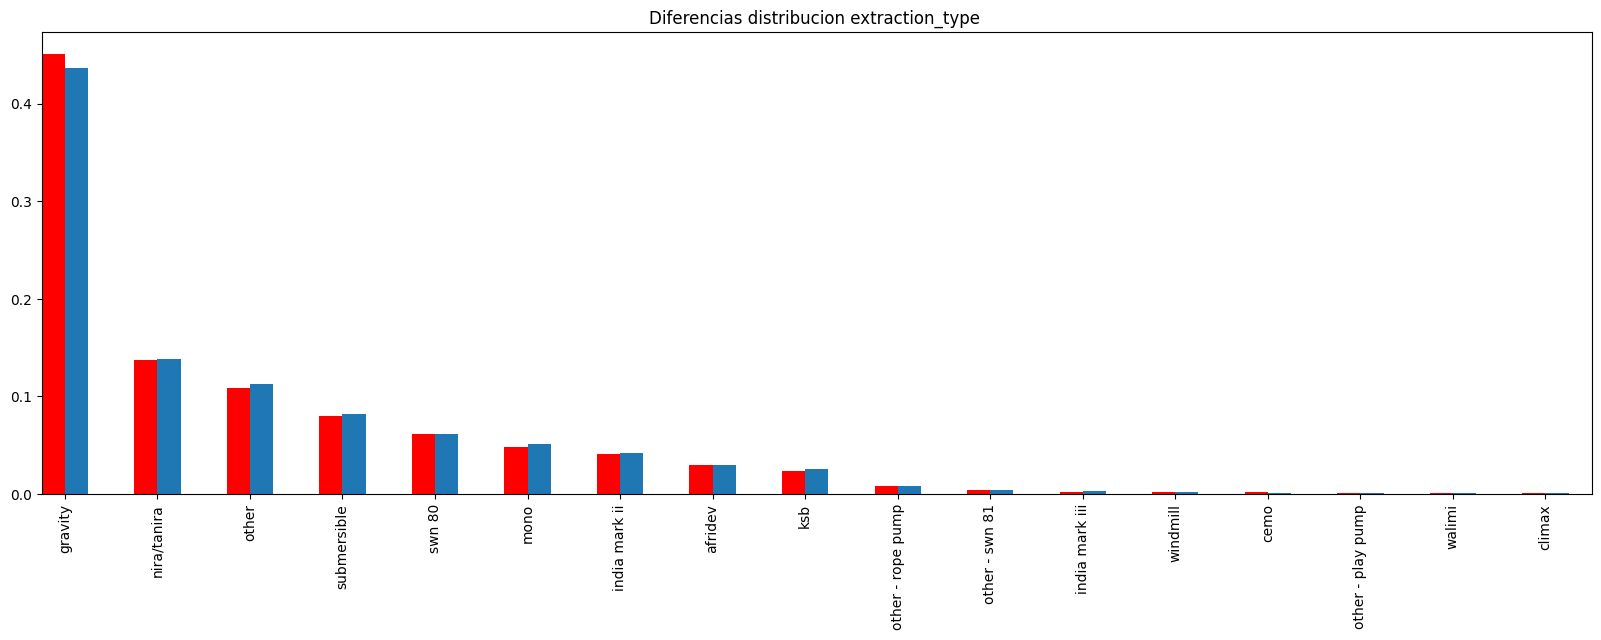

In [80]:
X_train= pd.read_csv("In/Training_set_values.csv").drop("id",axis=1)[["extraction_type","extraction_type_group","extraction_type_class"]]
X_test = pd.read_csv("In/Test_set_values.csv").drop("id",axis=1)[["extraction_type","extraction_type_group","extraction_type_class"]]

width = .25
X_train.extraction_type.value_counts(normalize=1).plot(kind="bar",position=1,color="red",width= width)
X_test.extraction_type.value_counts(normalize=1).plot(kind="bar",position=0,width=width)
plt.title("Diferencias distribucion extraction_type")
plt.show()

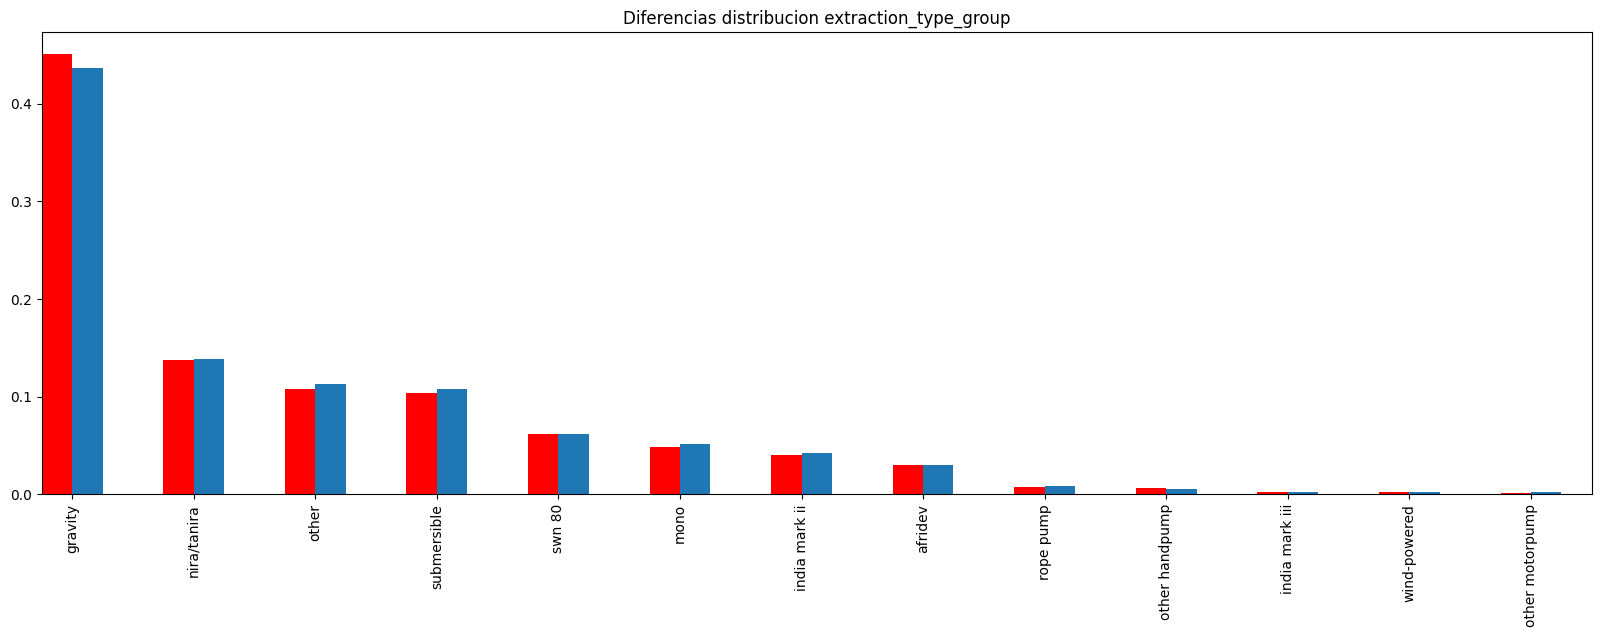

In [81]:
width = .25
X_train.extraction_type_group.value_counts(normalize=1).plot(kind="bar",position=1,color="red",width= width)
X_test.extraction_type_group.value_counts(normalize=1).plot(kind="bar",position=0,width=width)
plt.title("Diferencias distribucion extraction_type_group")
plt.show()

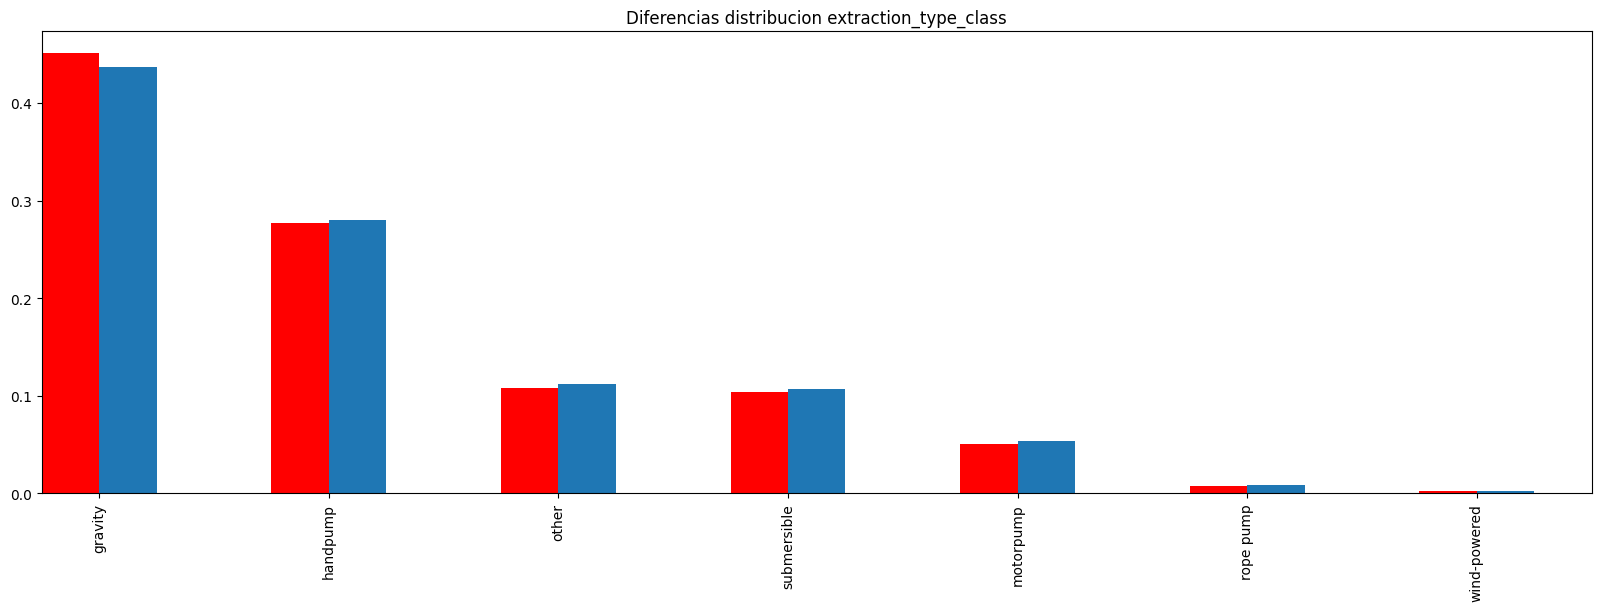

In [82]:
width = .25
X_train.extraction_type_class.value_counts(normalize=1).plot(kind="bar",position=1,color="red",width= width)
X_test.extraction_type_class.value_counts(normalize=1).plot(kind="bar",position=0,width=width)
plt.title("Diferencias distribucion extraction_type_class")
plt.show()


## Pues la distribución de las categorías en ambos dataframes parece ser casi equivalente, hasta aquí llegó mi idea de construir un test set representativo para poder elegir bien qué parámetros usar en mi modelo y qué features de las ingeniadas contribuyen algo bueno.

## Al ver en estos extraction types que "other" se repite tanto, pero de maneras un tanto distinto, veré qué nombres de categorías tiene sentido agrupar para añadírselo a mi pre-proceso

In [105]:
y = pd.read_csv("In/Training_set_labels.csv")
le = LabelEncoder()
y["status_group"]= le.fit_transform(y.status_group)

In [116]:
X= pd.read_csv("In/Training_set_values.csv").drop("id",axis=1)
for i in X.select_dtypes(include = "O").columns:
    X[i] = df[i].astype("category")
for col in X.columns:
    if (X[col].nunique() < 25) and (X[col].nunique() > 3):
        print(col)


basin
region
district_code
scheme_management
extraction_type
extraction_type_group
extraction_type_class
management
management_group
payment
payment_type
water_quality
quality_group
quantity
quantity_group
source
source_type
waterpoint_type
waterpoint_type_group


In [196]:
df.status_group = LabelEncoder().fit_transform(df.status_group)

In [226]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")
df = pd.merge(X,y,on="id")
df.status_group = LabelEncoder().fit_transform(df.status_group)

# Basin, juntar lakes no sé qué tanto sentido tenga 

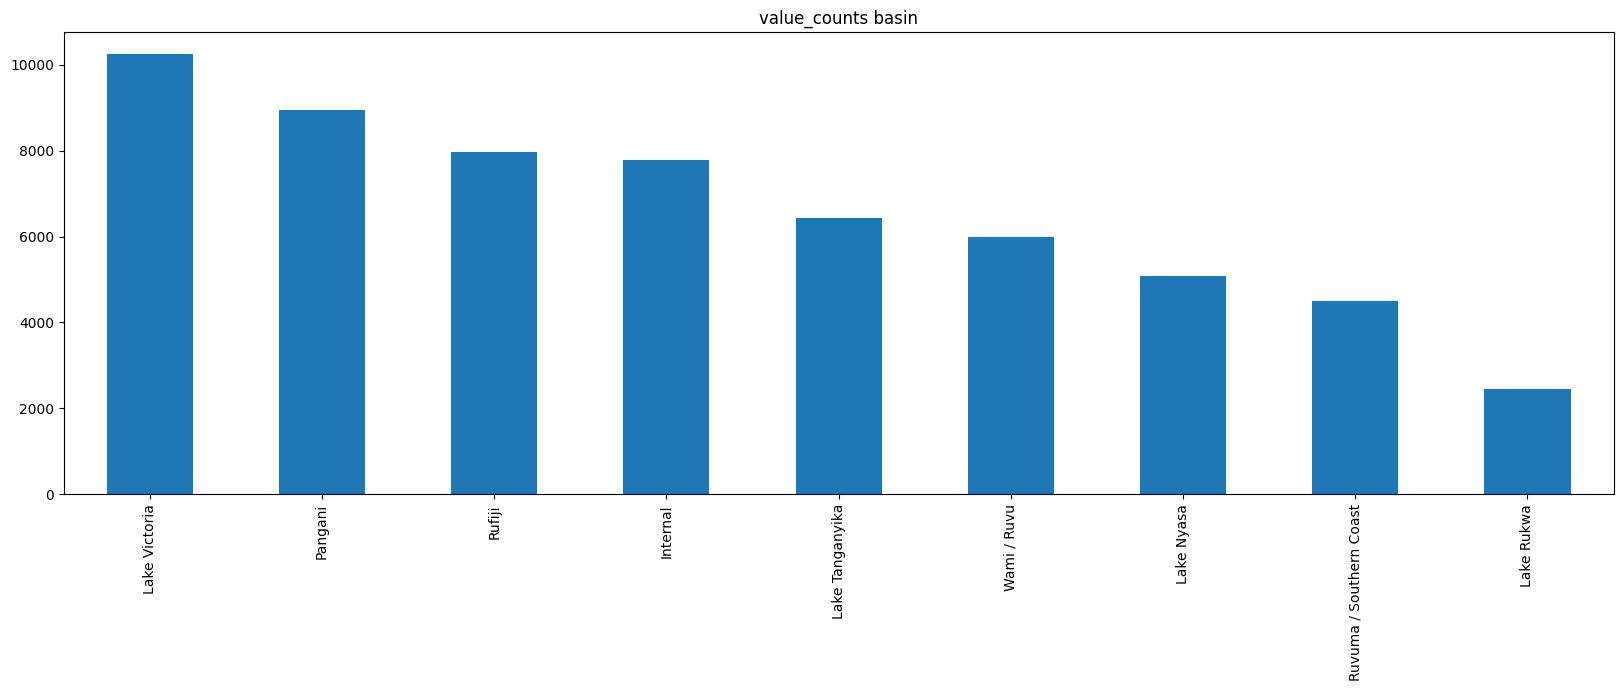

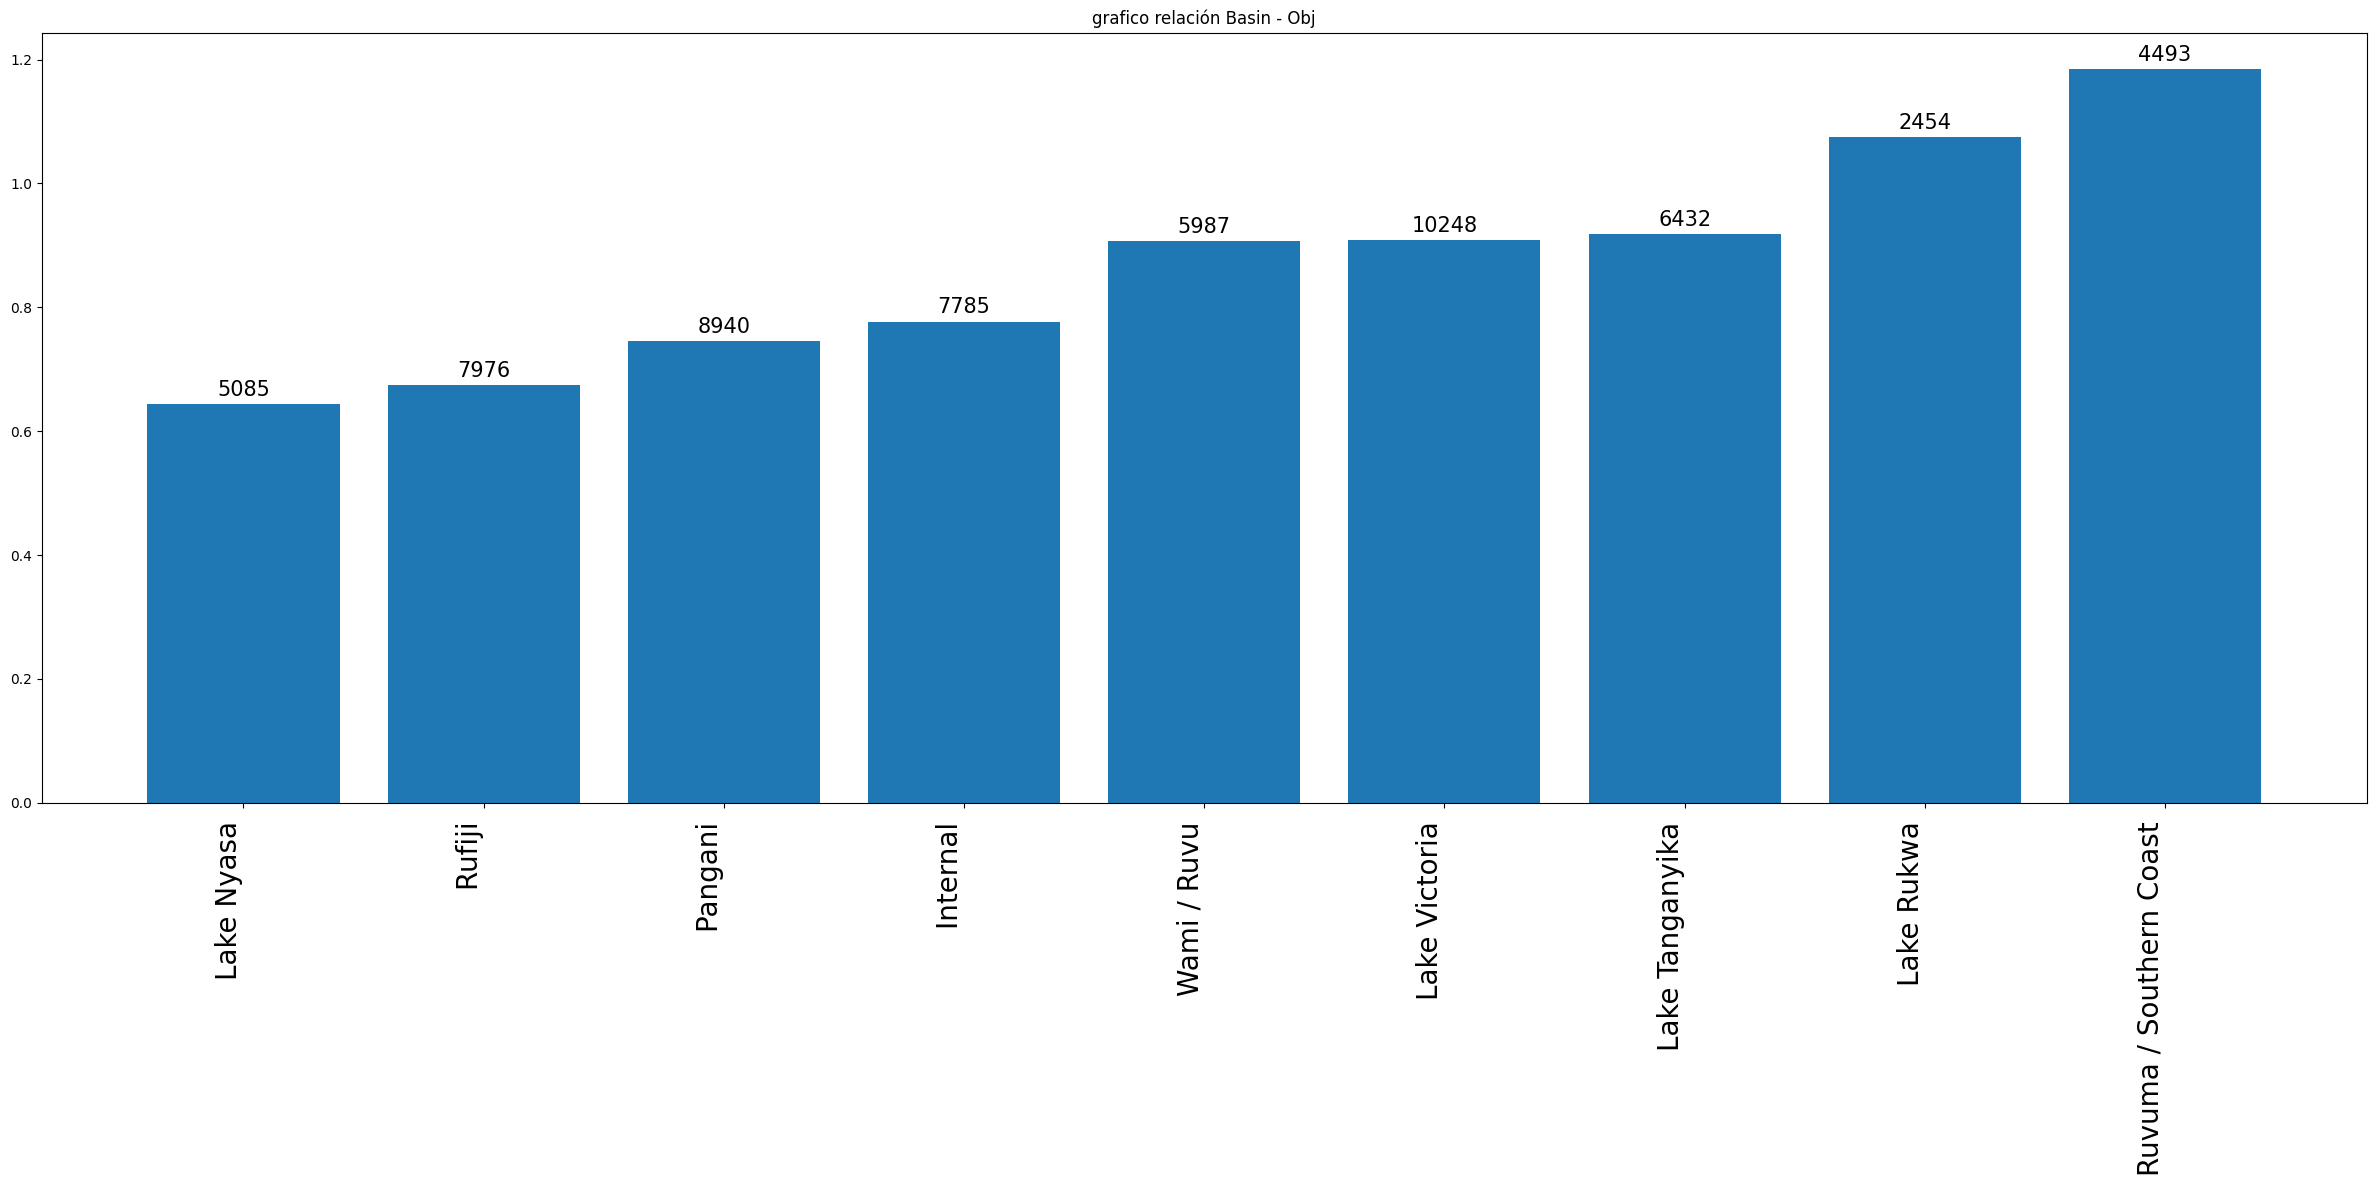

In [227]:
X.basin.value_counts().plot(kind="bar")
plt.title("value_counts basin")
X.basin.unique()
jd.grafica_relacion_cat_obj(df,"basin","status_group",True,titulo="grafico relación Basin - Obj")
# juntar lakes no sé qué tanto sentido tenga 

In [231]:
X.basin = X.basin.astype("category")
prueba_cramer = X.basin.apply(lambda x: x.split(" ")[0] if x.split(" ")[0] == "Lake" else x)
prueba_cramer = prueba_cramer.astype("category")


print(jd.cramers_v(prueba_cramer,df.status_group))
jd.cramers_v(X.basin,df.status_group)

0.10474261118047286


0.12716258006100034

# region, nada que agrupar

array(['Iringa', 'Mara', 'Manyara', 'Mtwara', 'Kagera', 'Tanga',
       'Shinyanga', 'Tabora', 'Pwani', 'Ruvuma', 'Kilimanjaro', 'Rukwa',
       'Mwanza', 'Kigoma', 'Lindi', 'Dodoma', 'Arusha', 'Mbeya',
       'Singida', 'Morogoro', 'Dar es Salaam'], dtype=object)

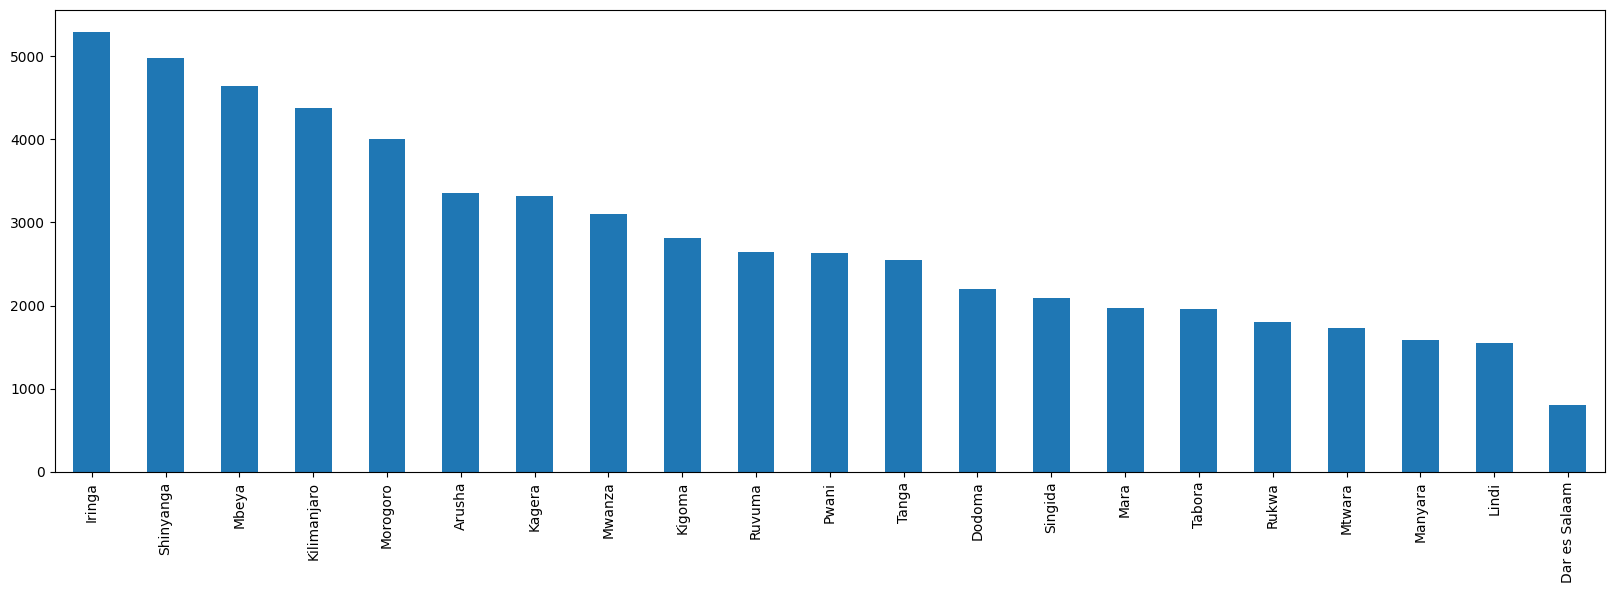

In [232]:
X.region.value_counts().plot(kind="bar")
X.region.unique()

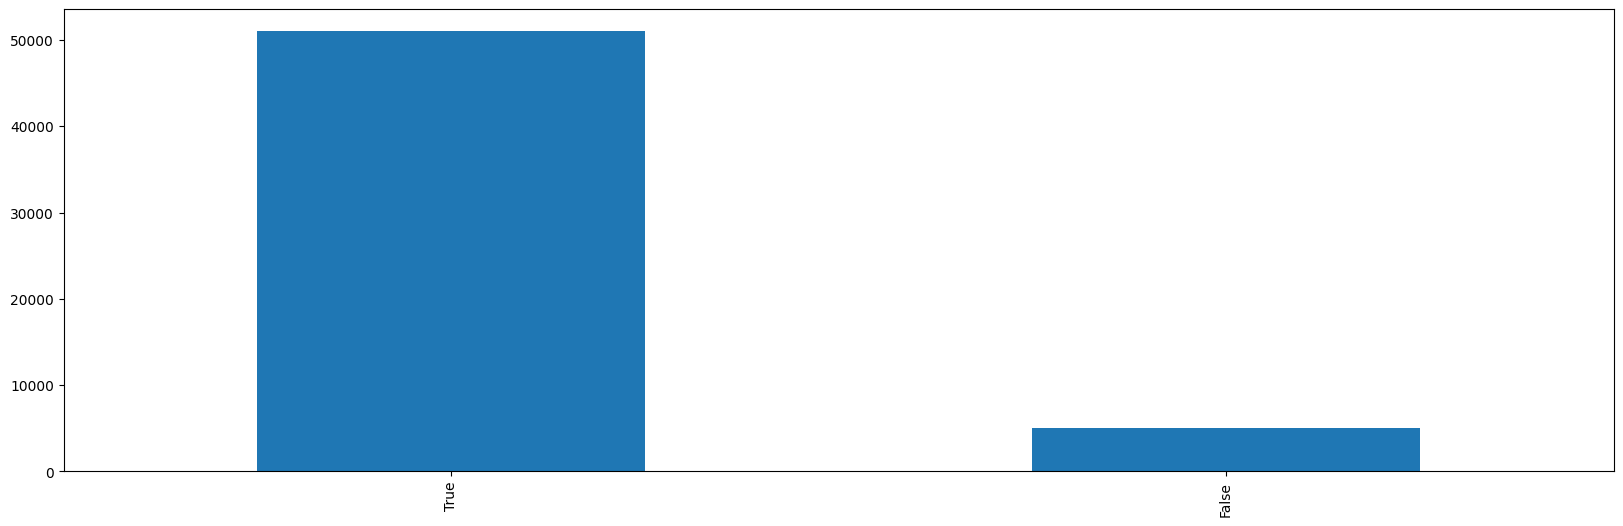

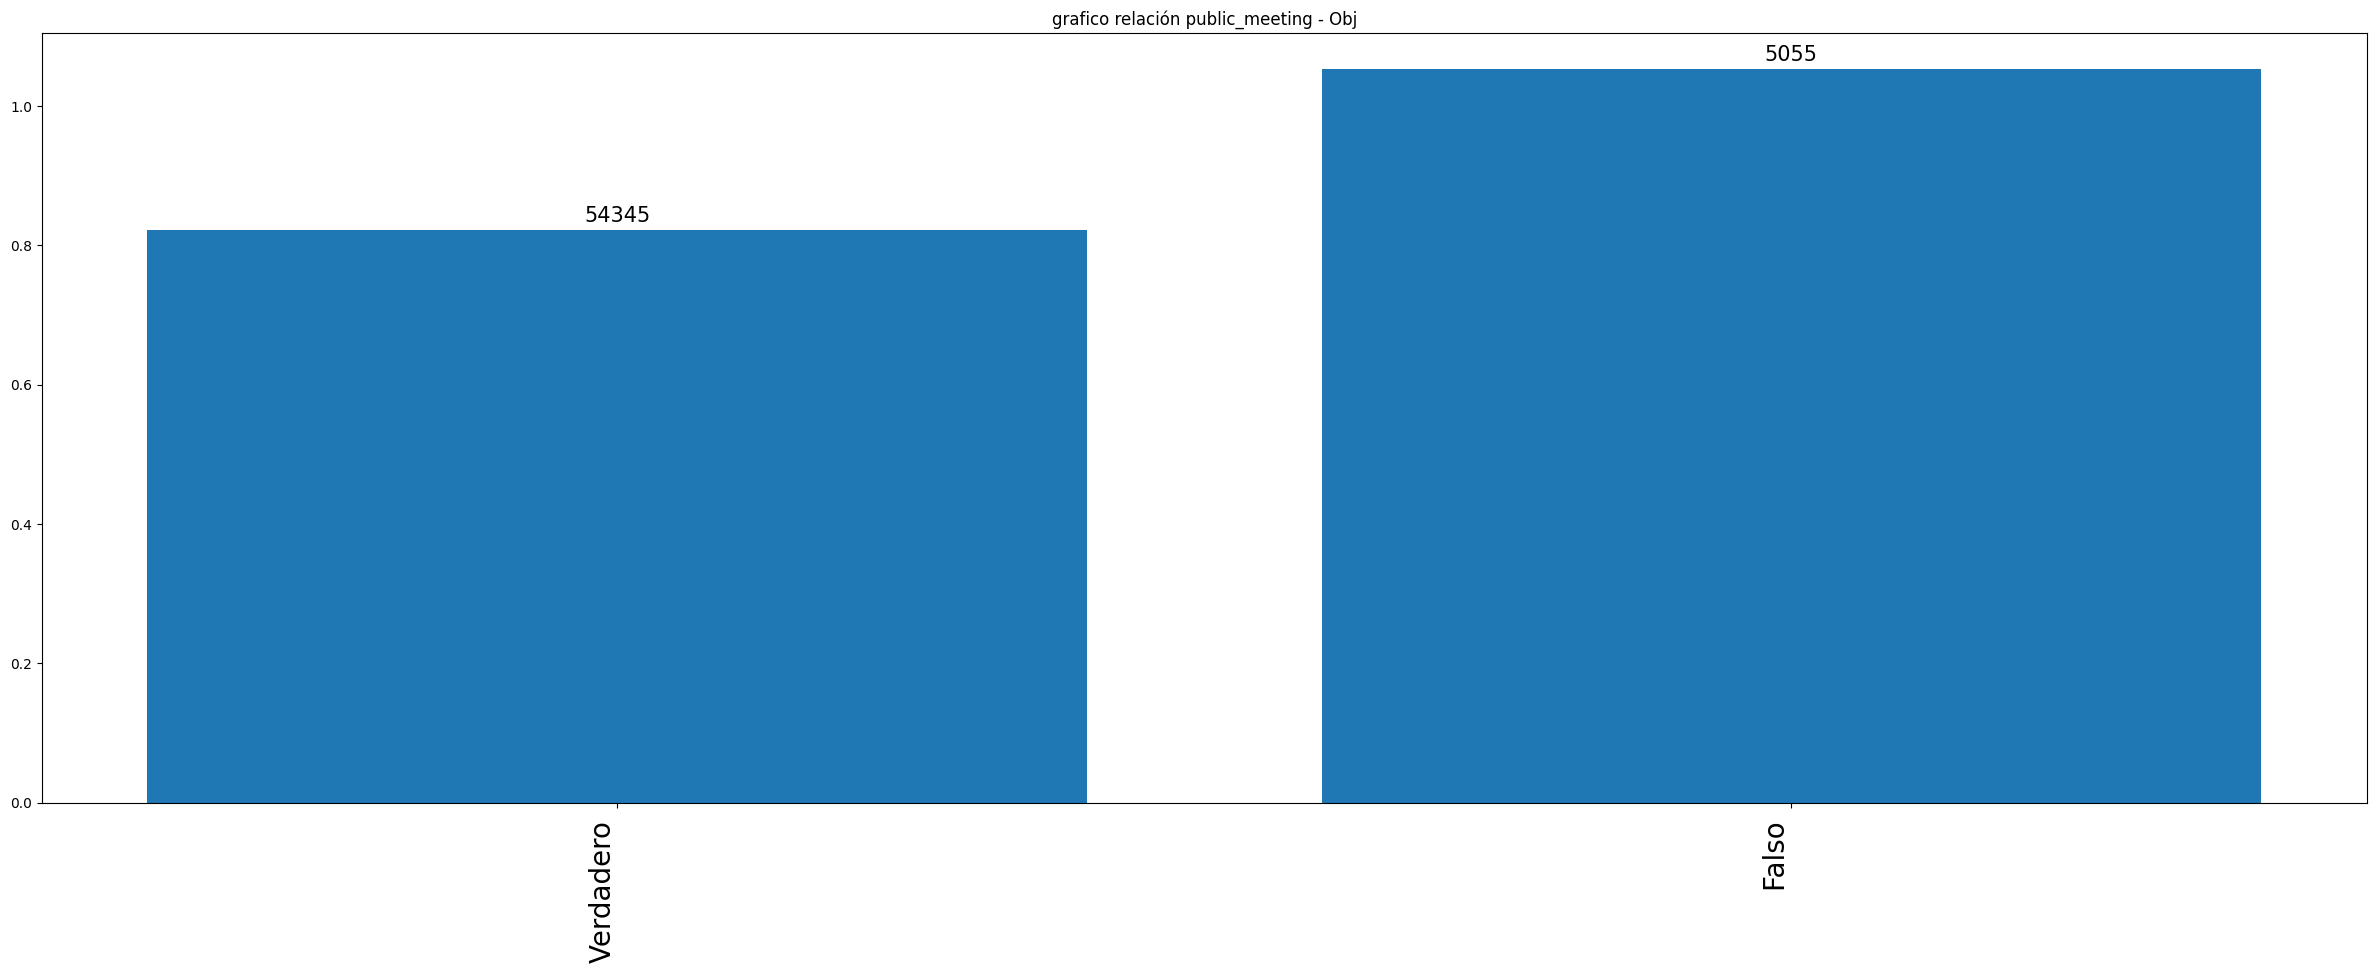

In [233]:
X.public_meeting.value_counts().plot(kind="bar")
jd.grafica_relacion_cat_obj(df,"public_meeting","status_group",True,titulo="grafico relación public_meeting - Obj",bool_fix=True)

# scheme_management, ninguna agrupación con mucho sentido

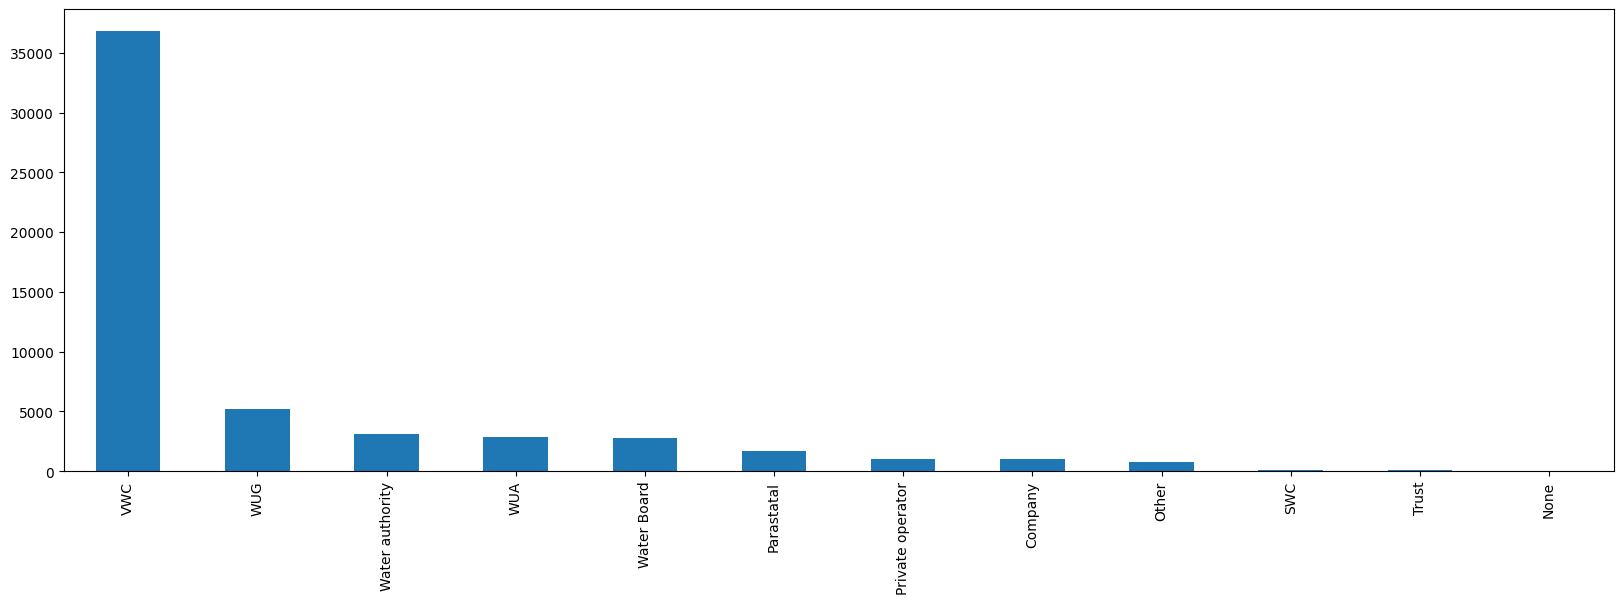

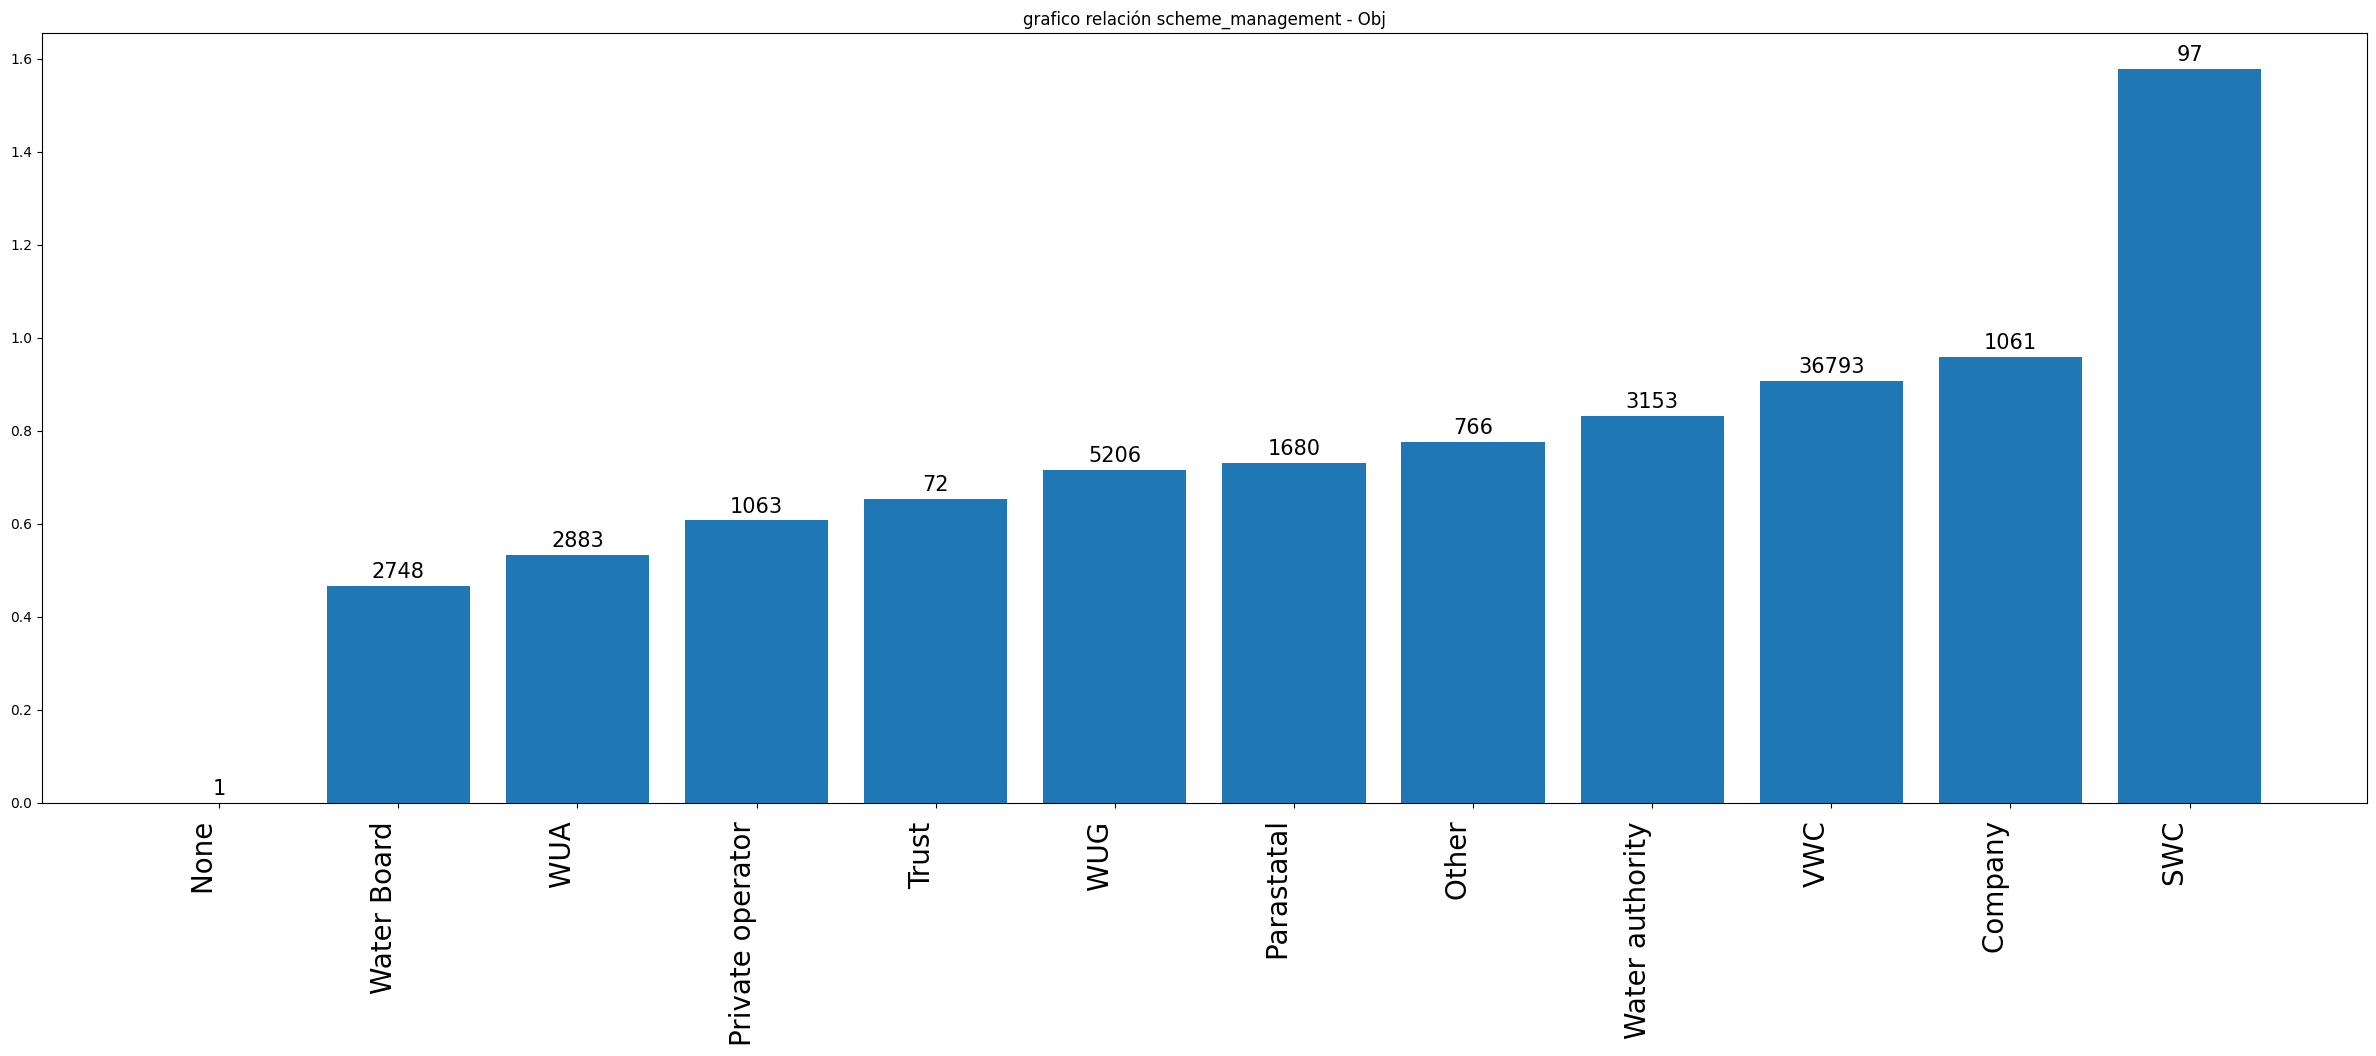

In [234]:
X.scheme_management.value_counts().plot(kind="bar")
jd.grafica_relacion_cat_obj(df,"scheme_management","status_group",True,titulo="grafico relación scheme_management - Obj")
# SWC tiene pocas categorías, pero parece ser muy diferente a las demás.

# permit, ninguna agrupación con mucho sentido

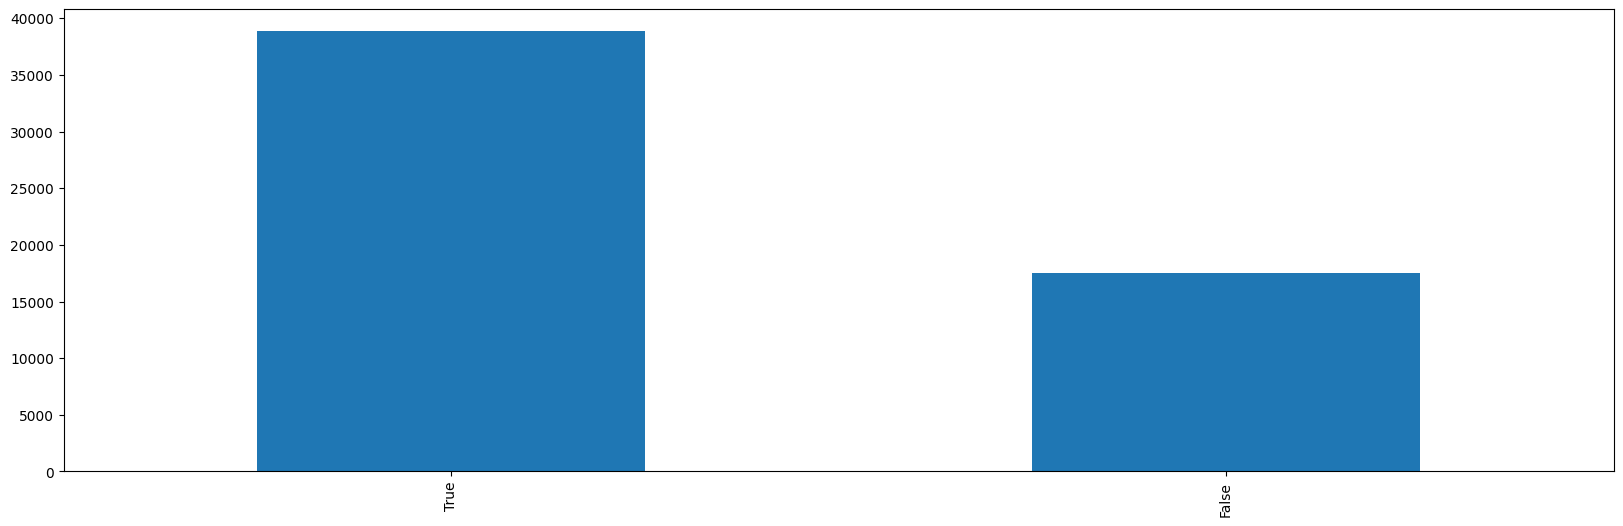

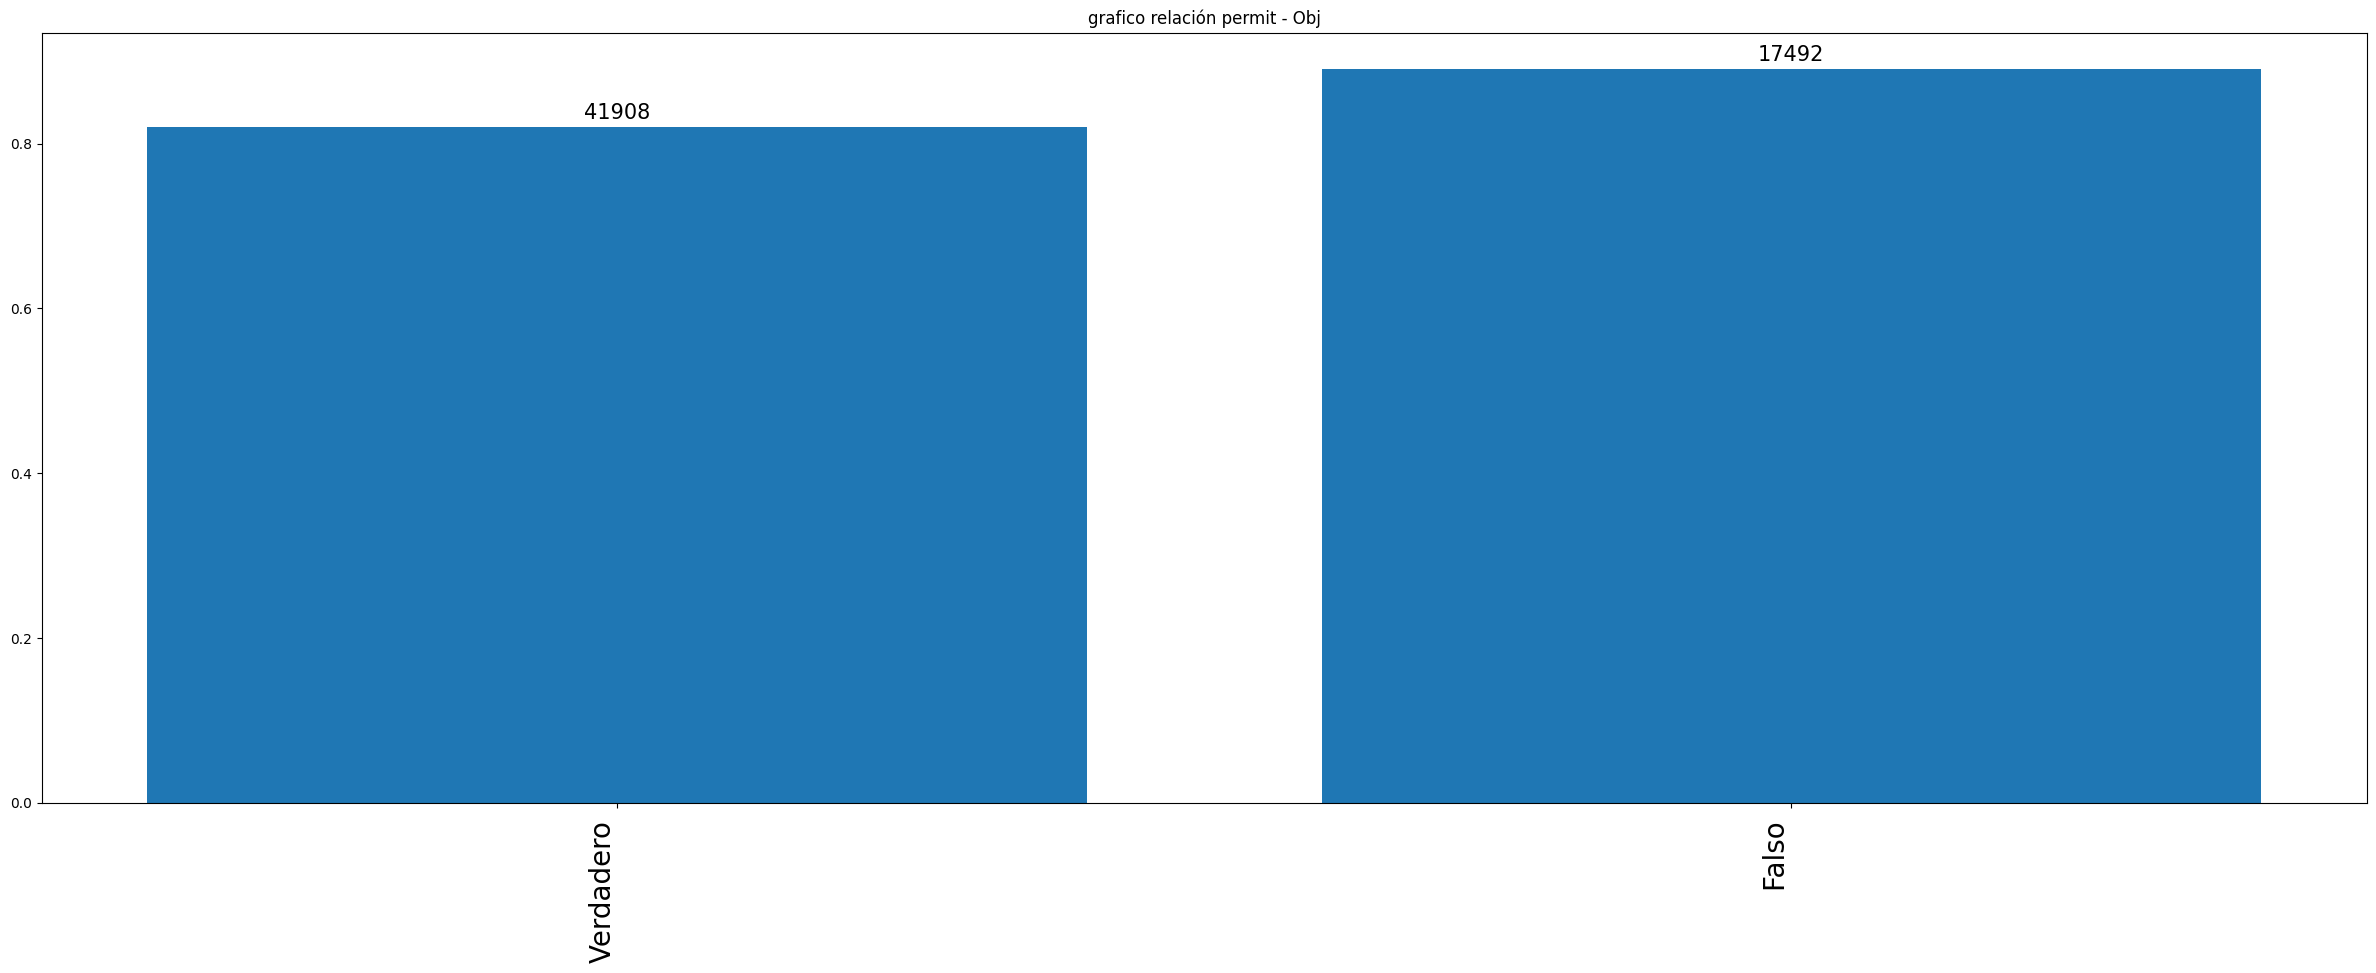

In [235]:
X.permit.value_counts().plot(kind="bar")
jd.grafica_relacion_cat_obj(df,"permit","status_group",True,titulo="grafico relación permit - Obj",bool_fix=True)

## Variables de extracción, se pudisen agrupar "other", parece que terminaría siendo igual a extraction_type_class

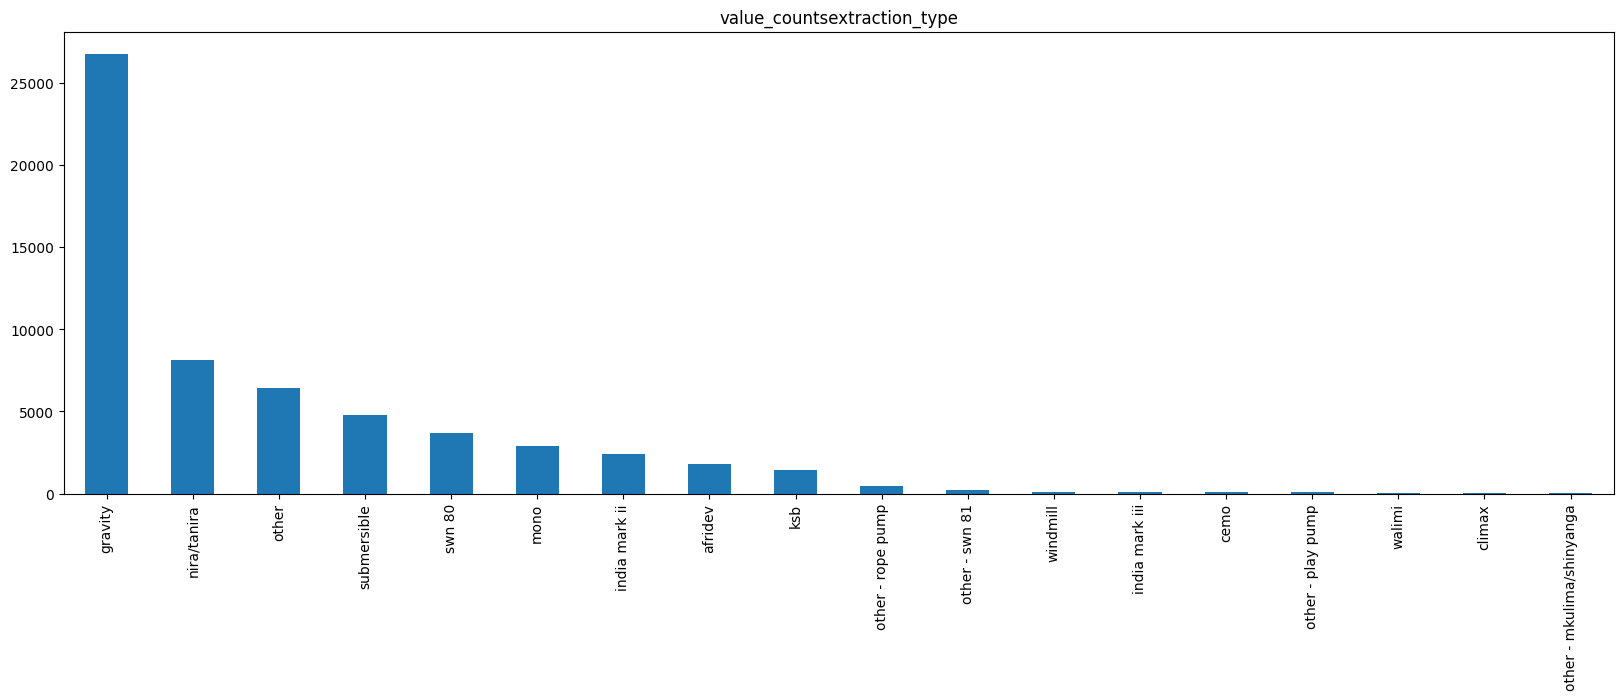

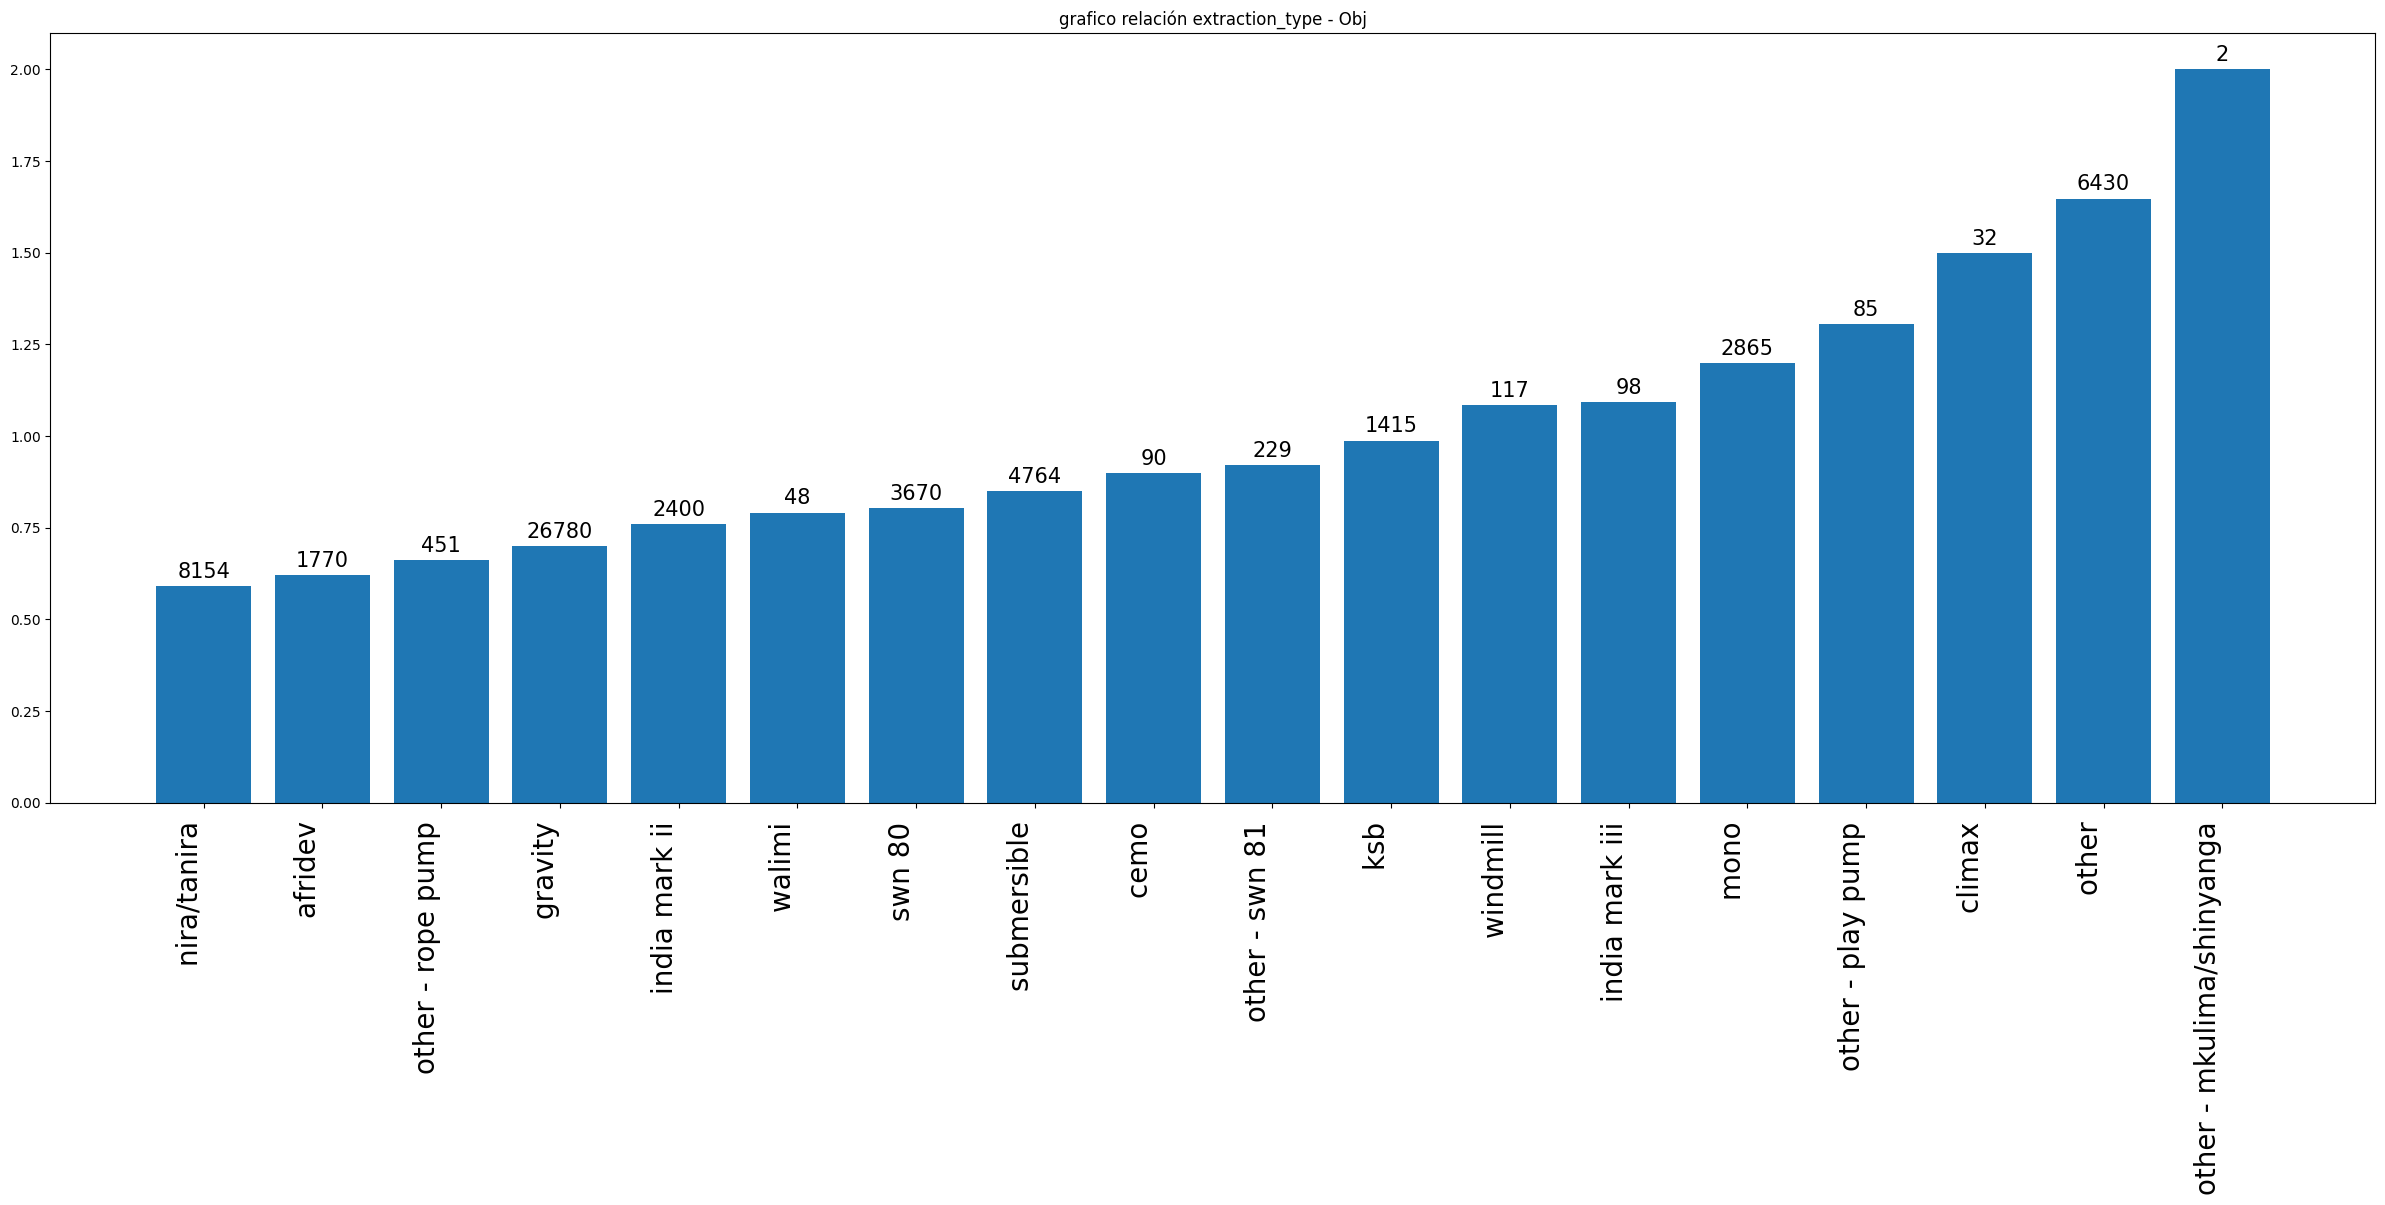

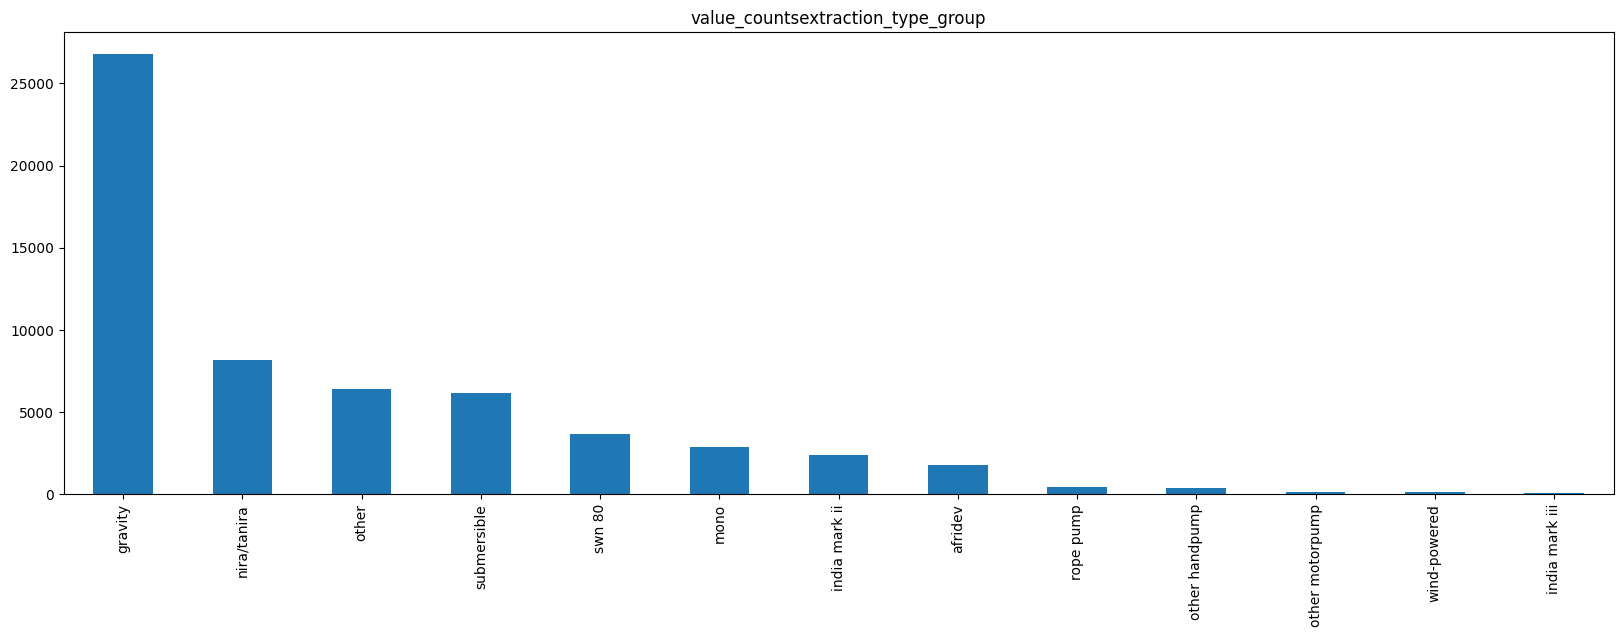

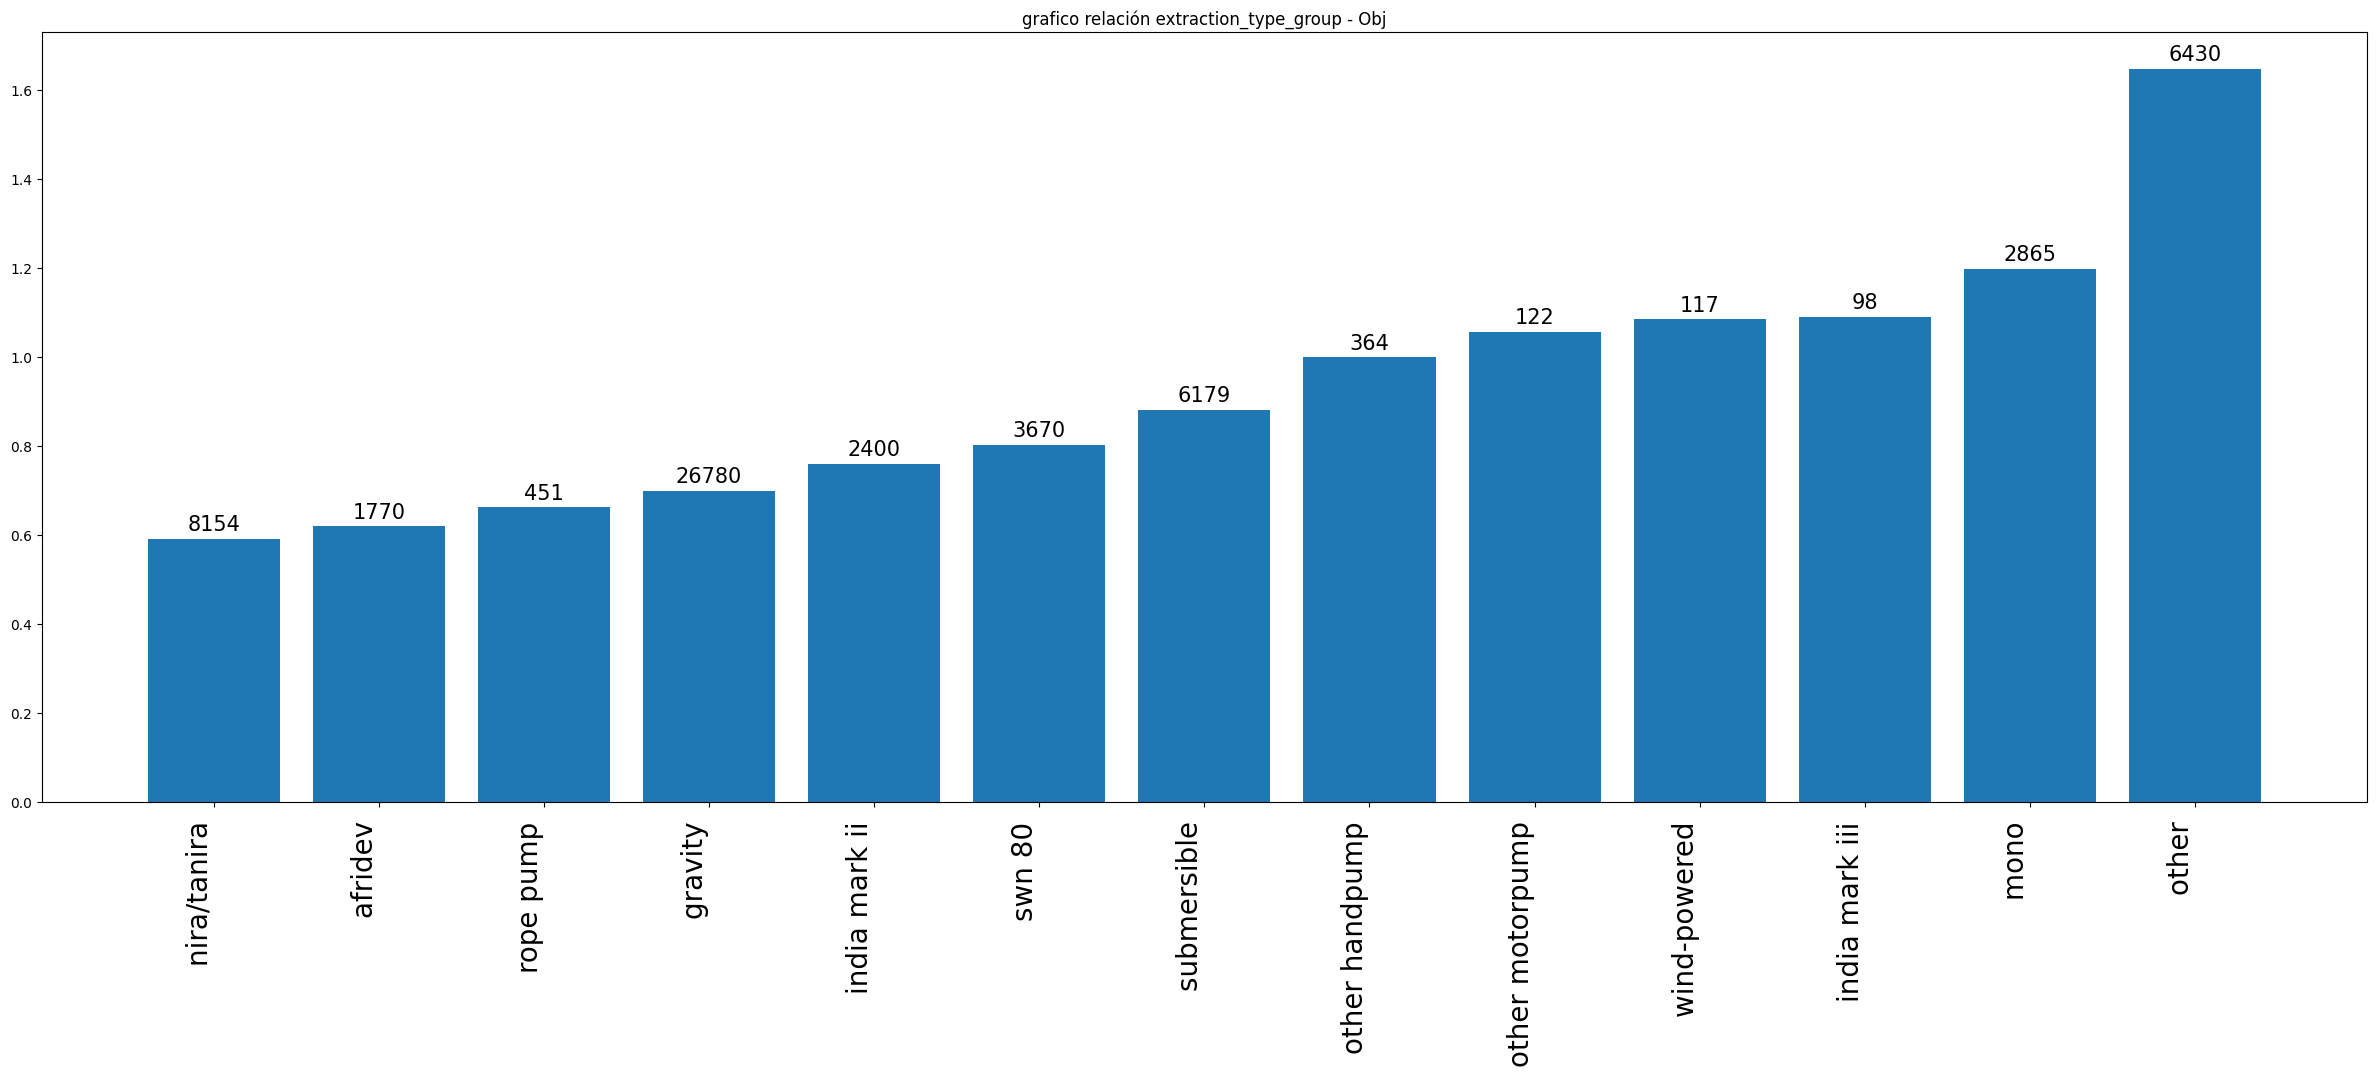

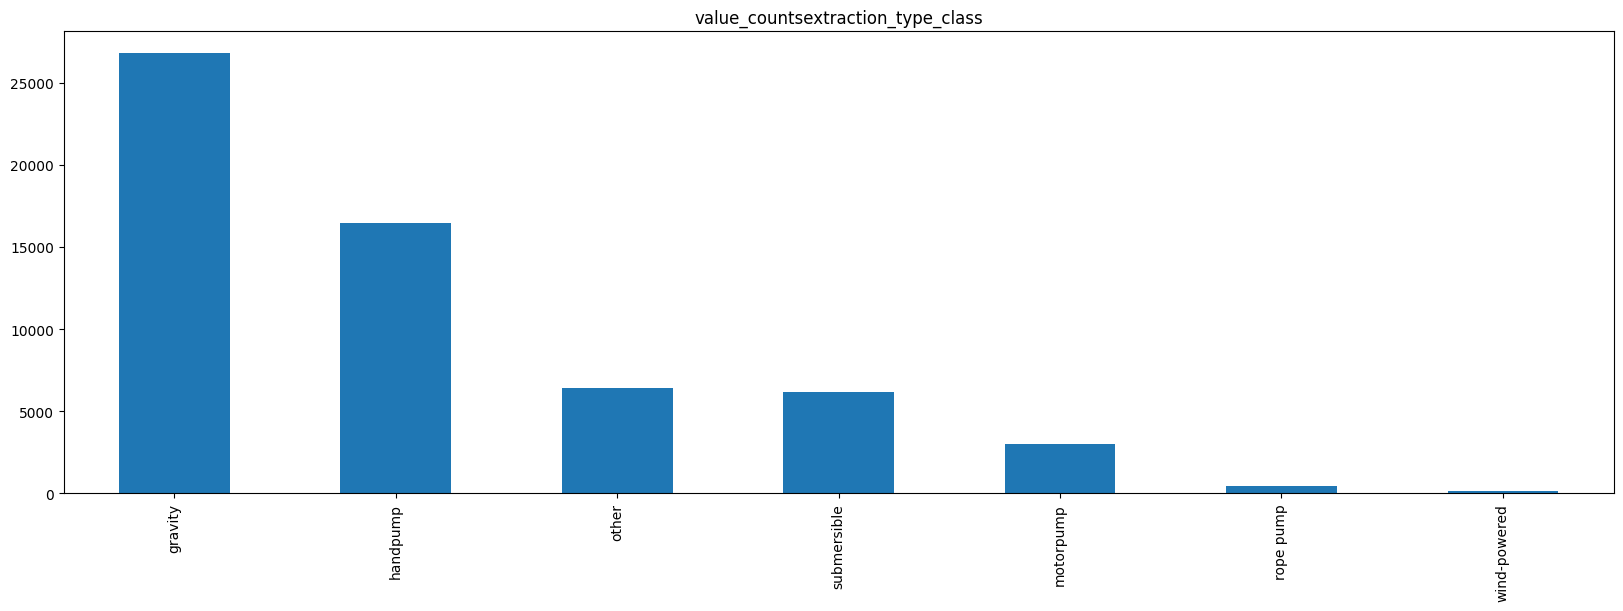

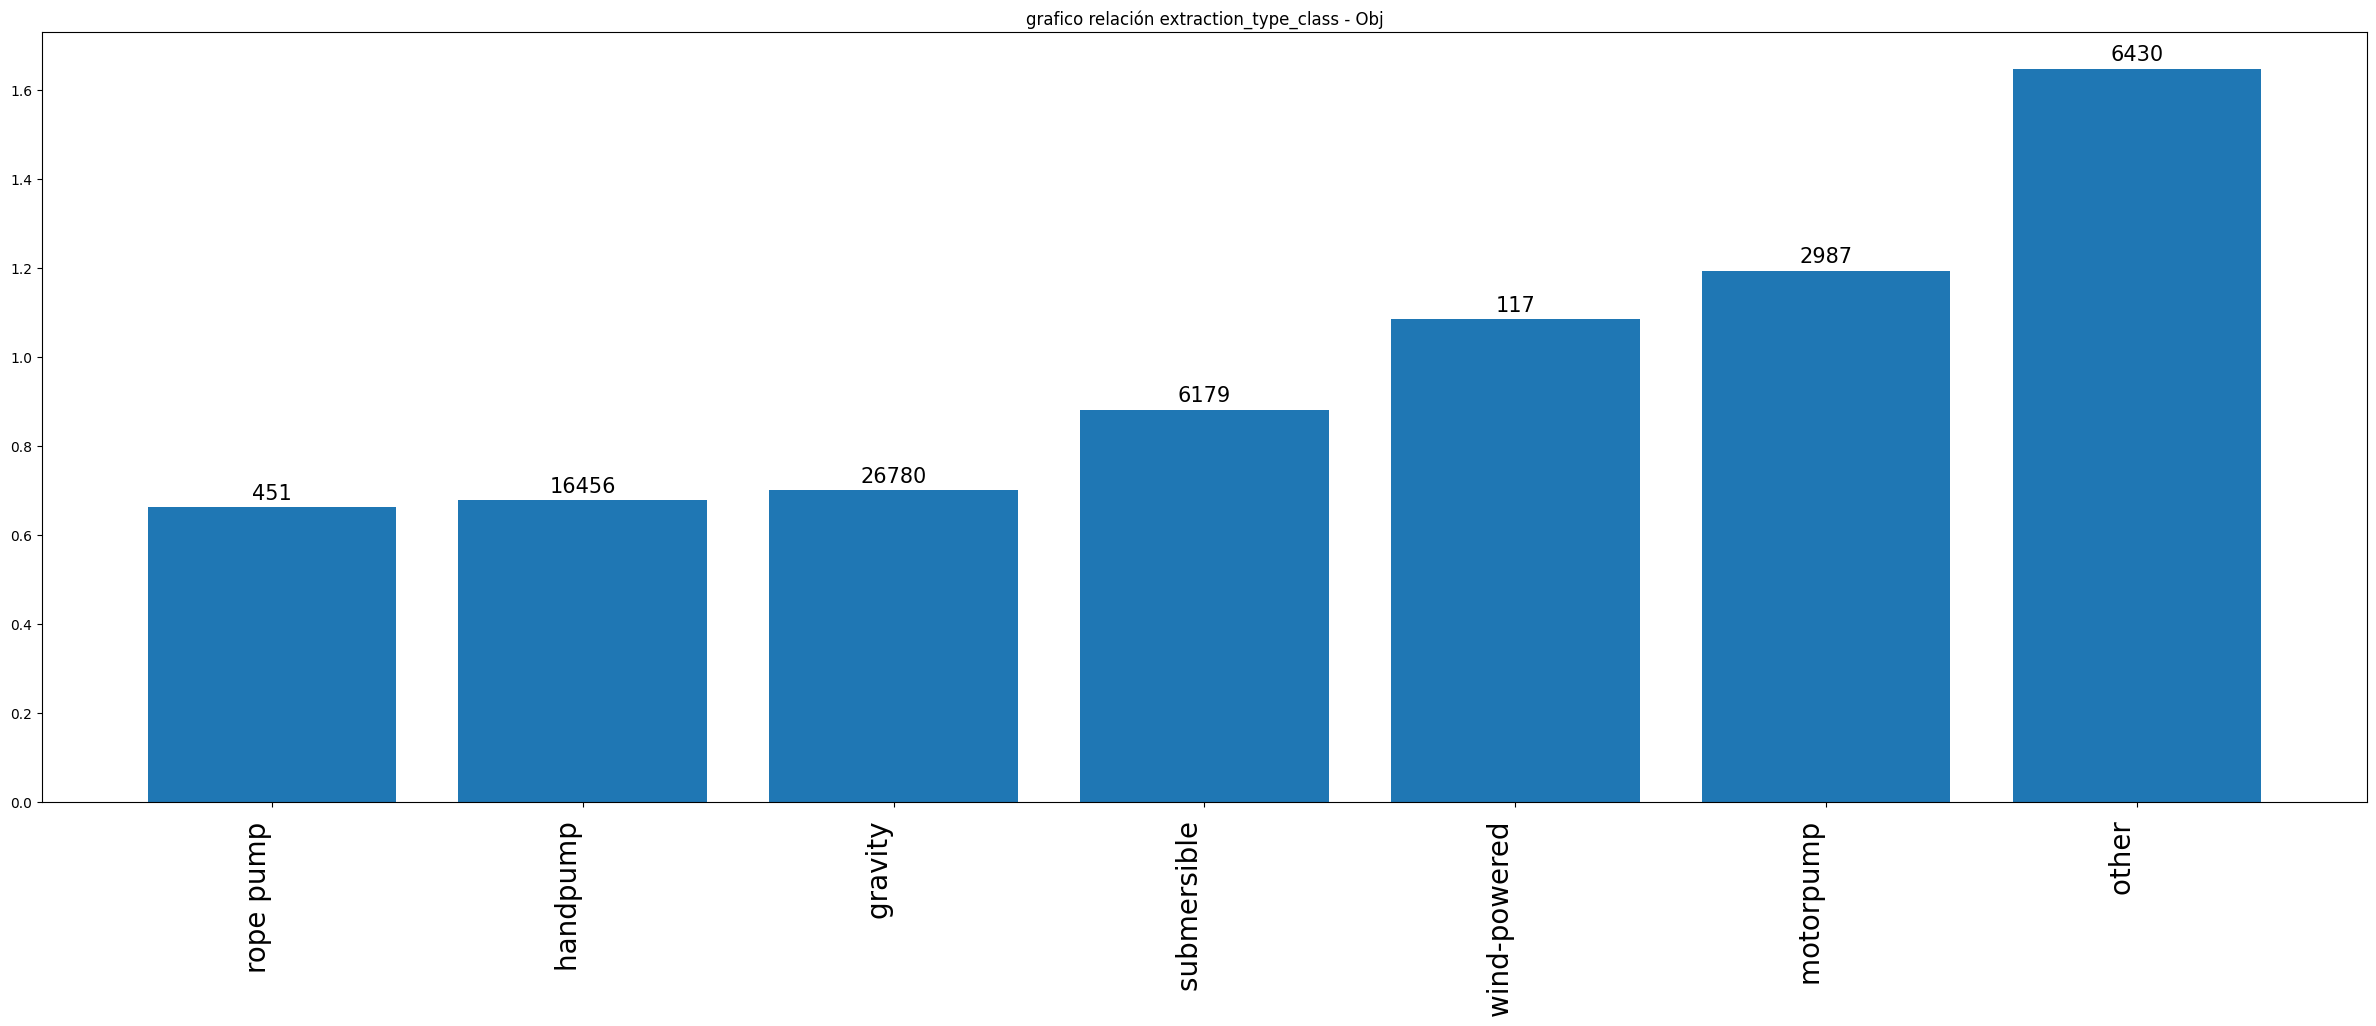

In [236]:
for i in ["extraction_type","extraction_type_group", "extraction_type_class"]:
    X[i].value_counts().plot(kind="bar")
    plt.title(f"value_counts{i}") 
    jd.grafica_relacion_cat_obj(df,f"{i}","status_group",True,titulo=f"grafico relación {i} - Obj")
    plt.show()   

In [237]:
X.loc[(X["extraction_type_group"]=="other motorpump" )].shape[0]
X.shape[0]/100

594.0

In [238]:
X.loc[X["extraction_type_class"]=="other"][["extraction_type","extraction_type_group", "extraction_type_class"]]
X.loc[(X["extraction_type_class"]=="other" )&
       (X["extraction_type_group"] !="other") ][["extraction_type","extraction_type_group", "extraction_type_class"]]

X.loc[(X["extraction_type_class"]=="other" )&
       (X["extraction_type"] !="other") ][["extraction_type","extraction_type_group", "extraction_type_class"]]
X.loc[(X["extraction_type_group"]=="other motorpump" )][["extraction_type","extraction_type_group", "extraction_type_class"]]

extraction_type extraction_type_group extraction_type_class
2269             cemo       other motorpump             motorpump
2416             cemo       other motorpump             motorpump
2610             cemo       other motorpump             motorpump
2802             cemo       other motorpump             motorpump
2806             cemo       other motorpump             motorpump
...               ...                   ...                   ...
55545            cemo       other motorpump             motorpump
56740          climax       other motorpump             motorpump
56852          climax       other motorpump             motorpump
57118            cemo       other motorpump             motorpump
58529          climax       other motorpump             motorpump

[122 rows x 3 columns]

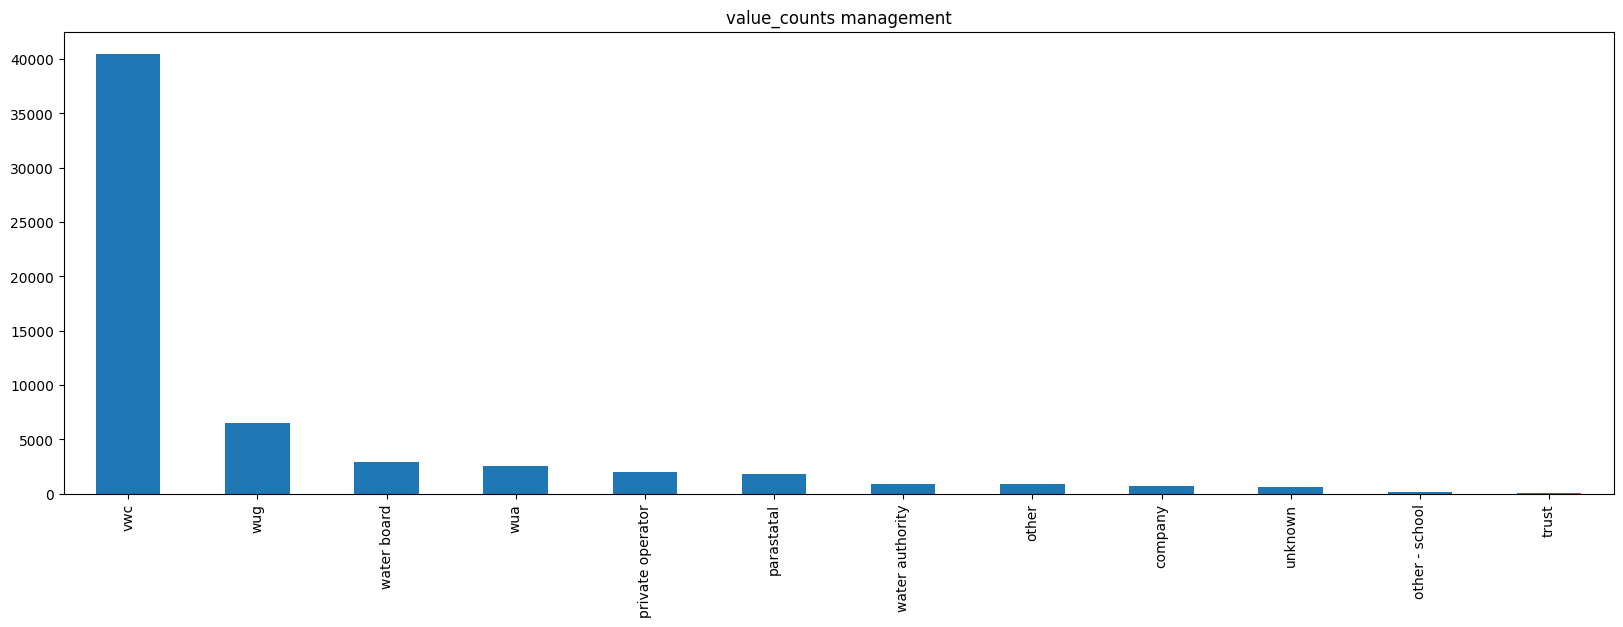

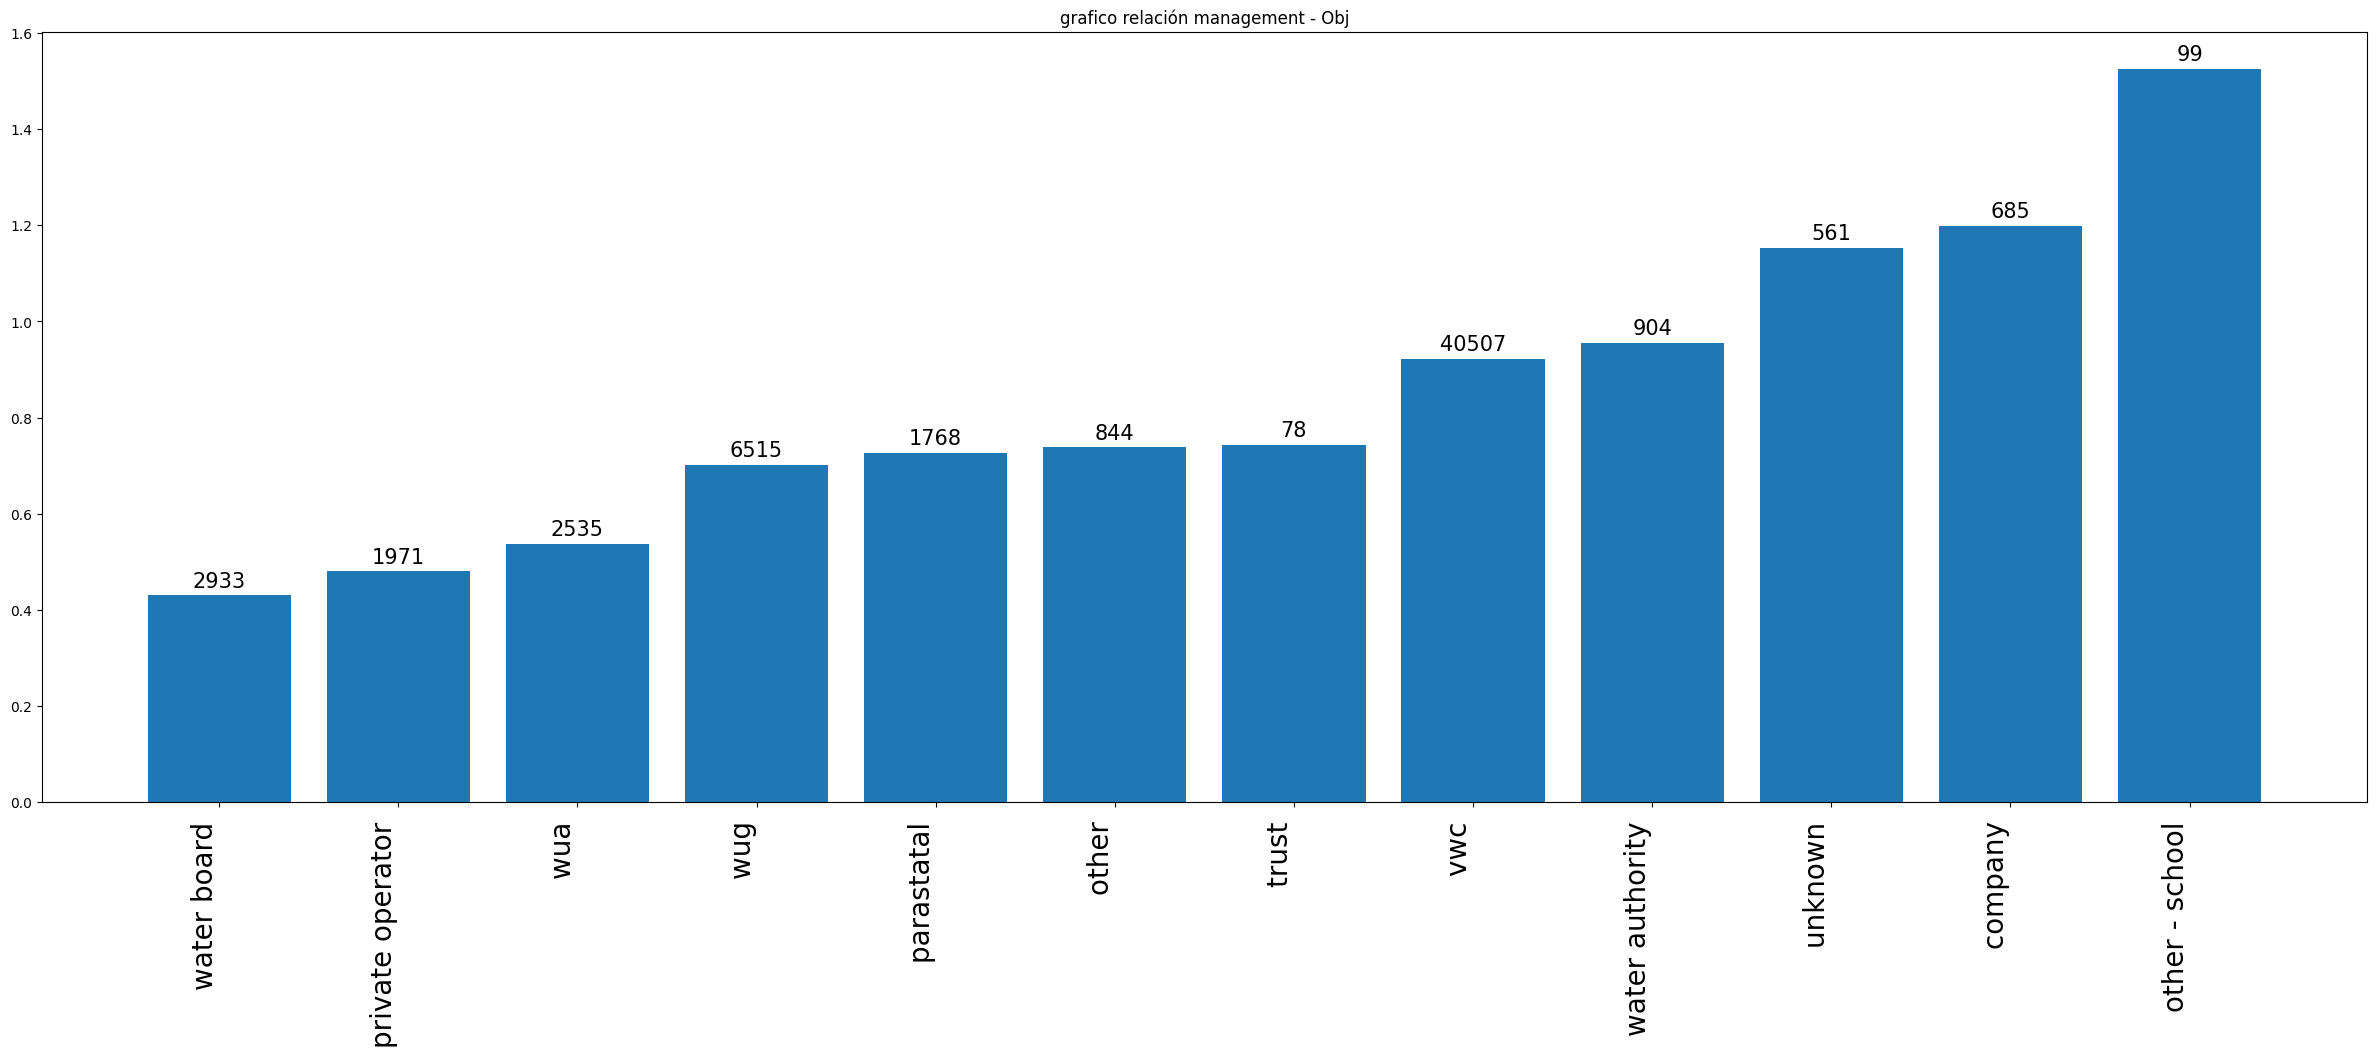

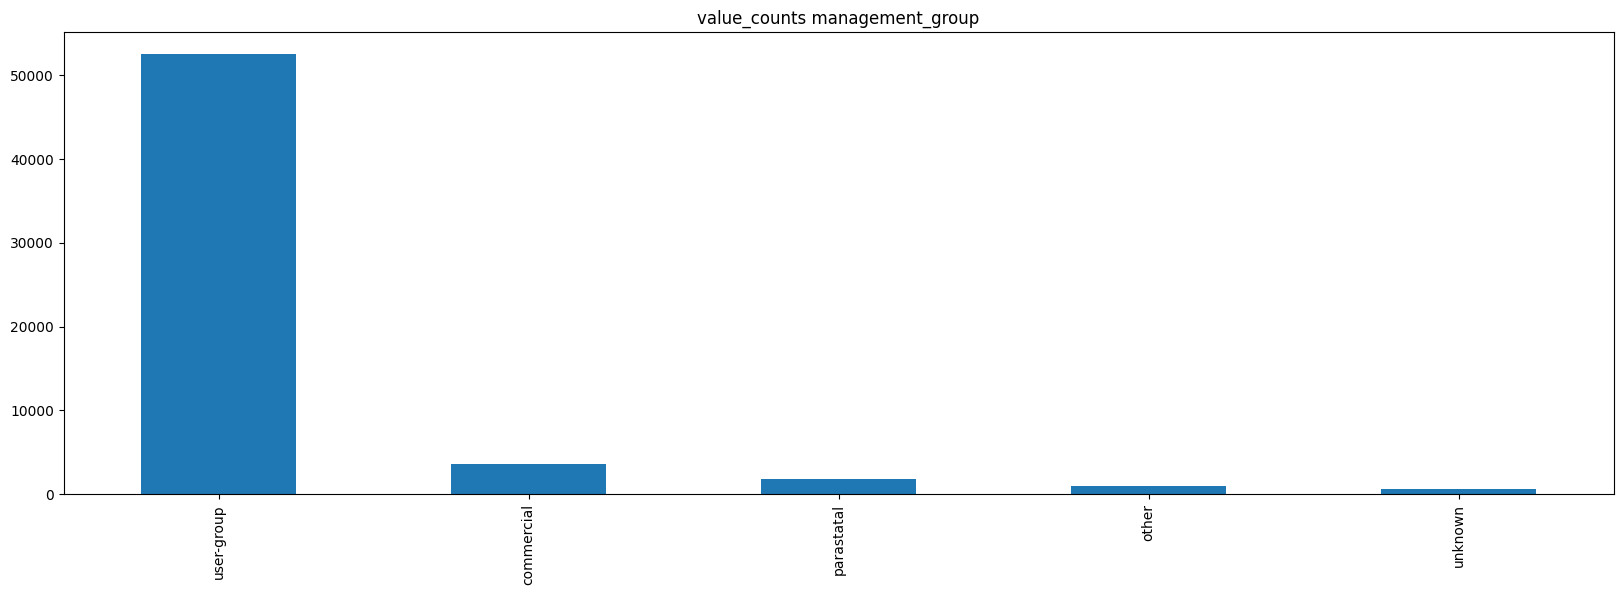

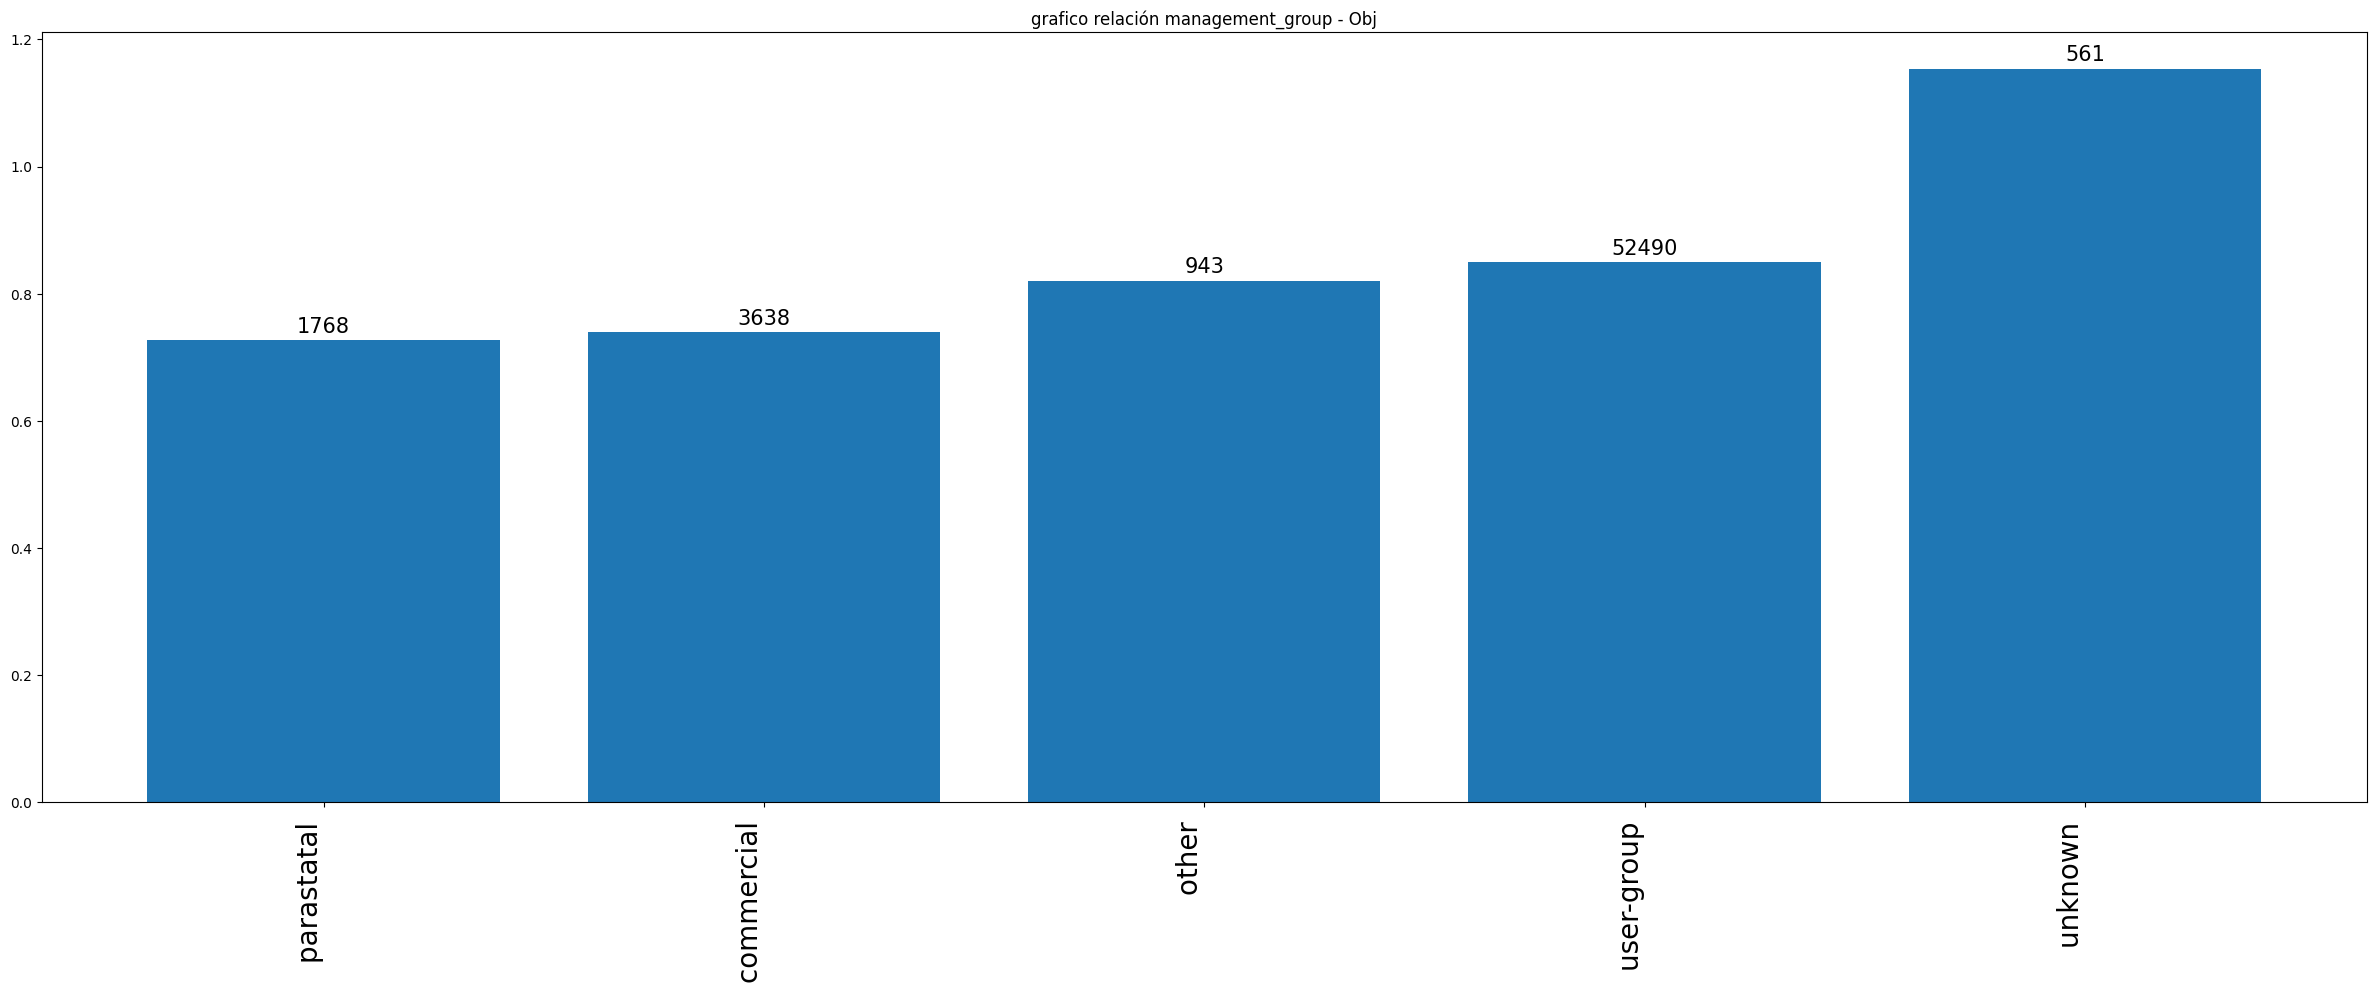

In [239]:
cols = ["management", "management_group"]
for i in cols:
    X[i].value_counts().plot(kind="bar") 
    plt.title(f"value_counts {i}")
    jd.grafica_relacion_cat_obj(df,f"{i}","status_group",True,titulo=f"grafico relación {i} - Obj")
    
    plt.show() 

## Asegúrate de tener payments y management_group en la lista de columnas con NA!!

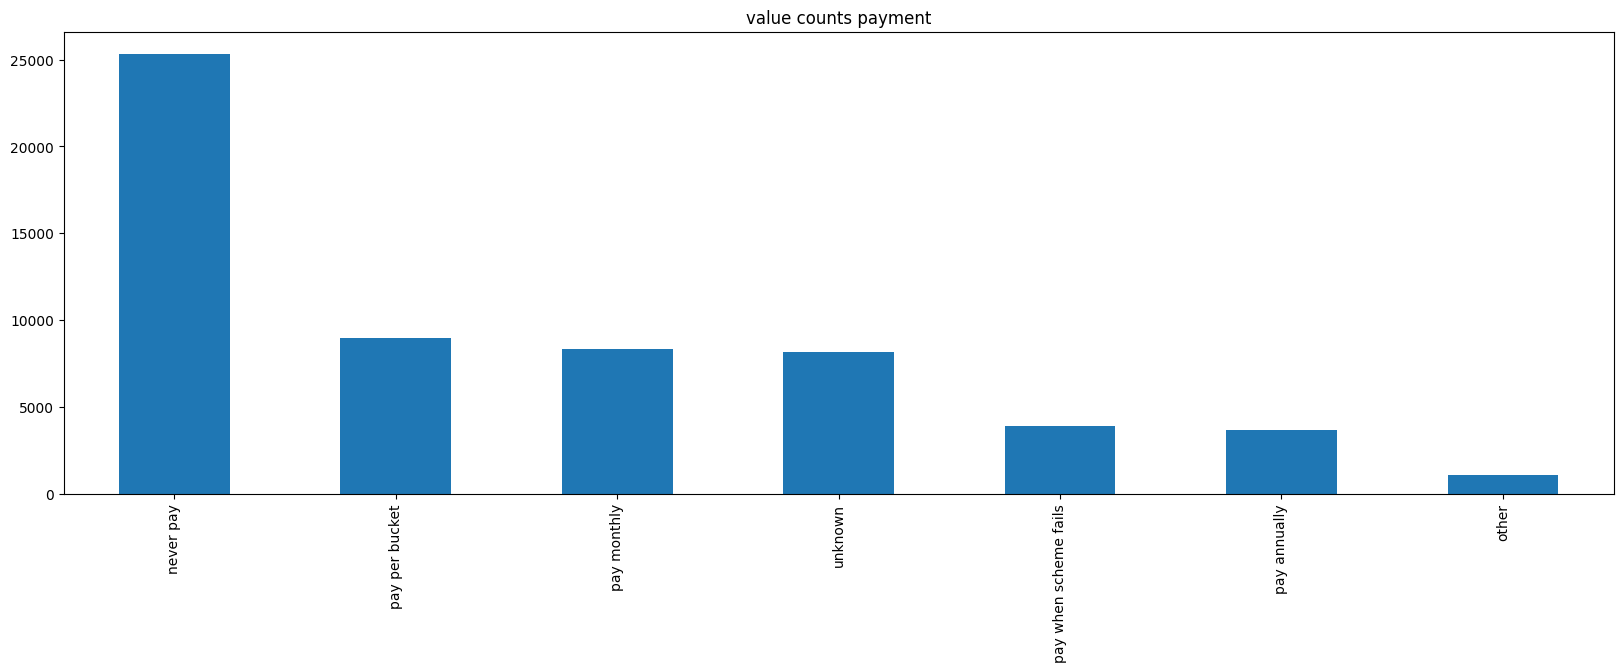

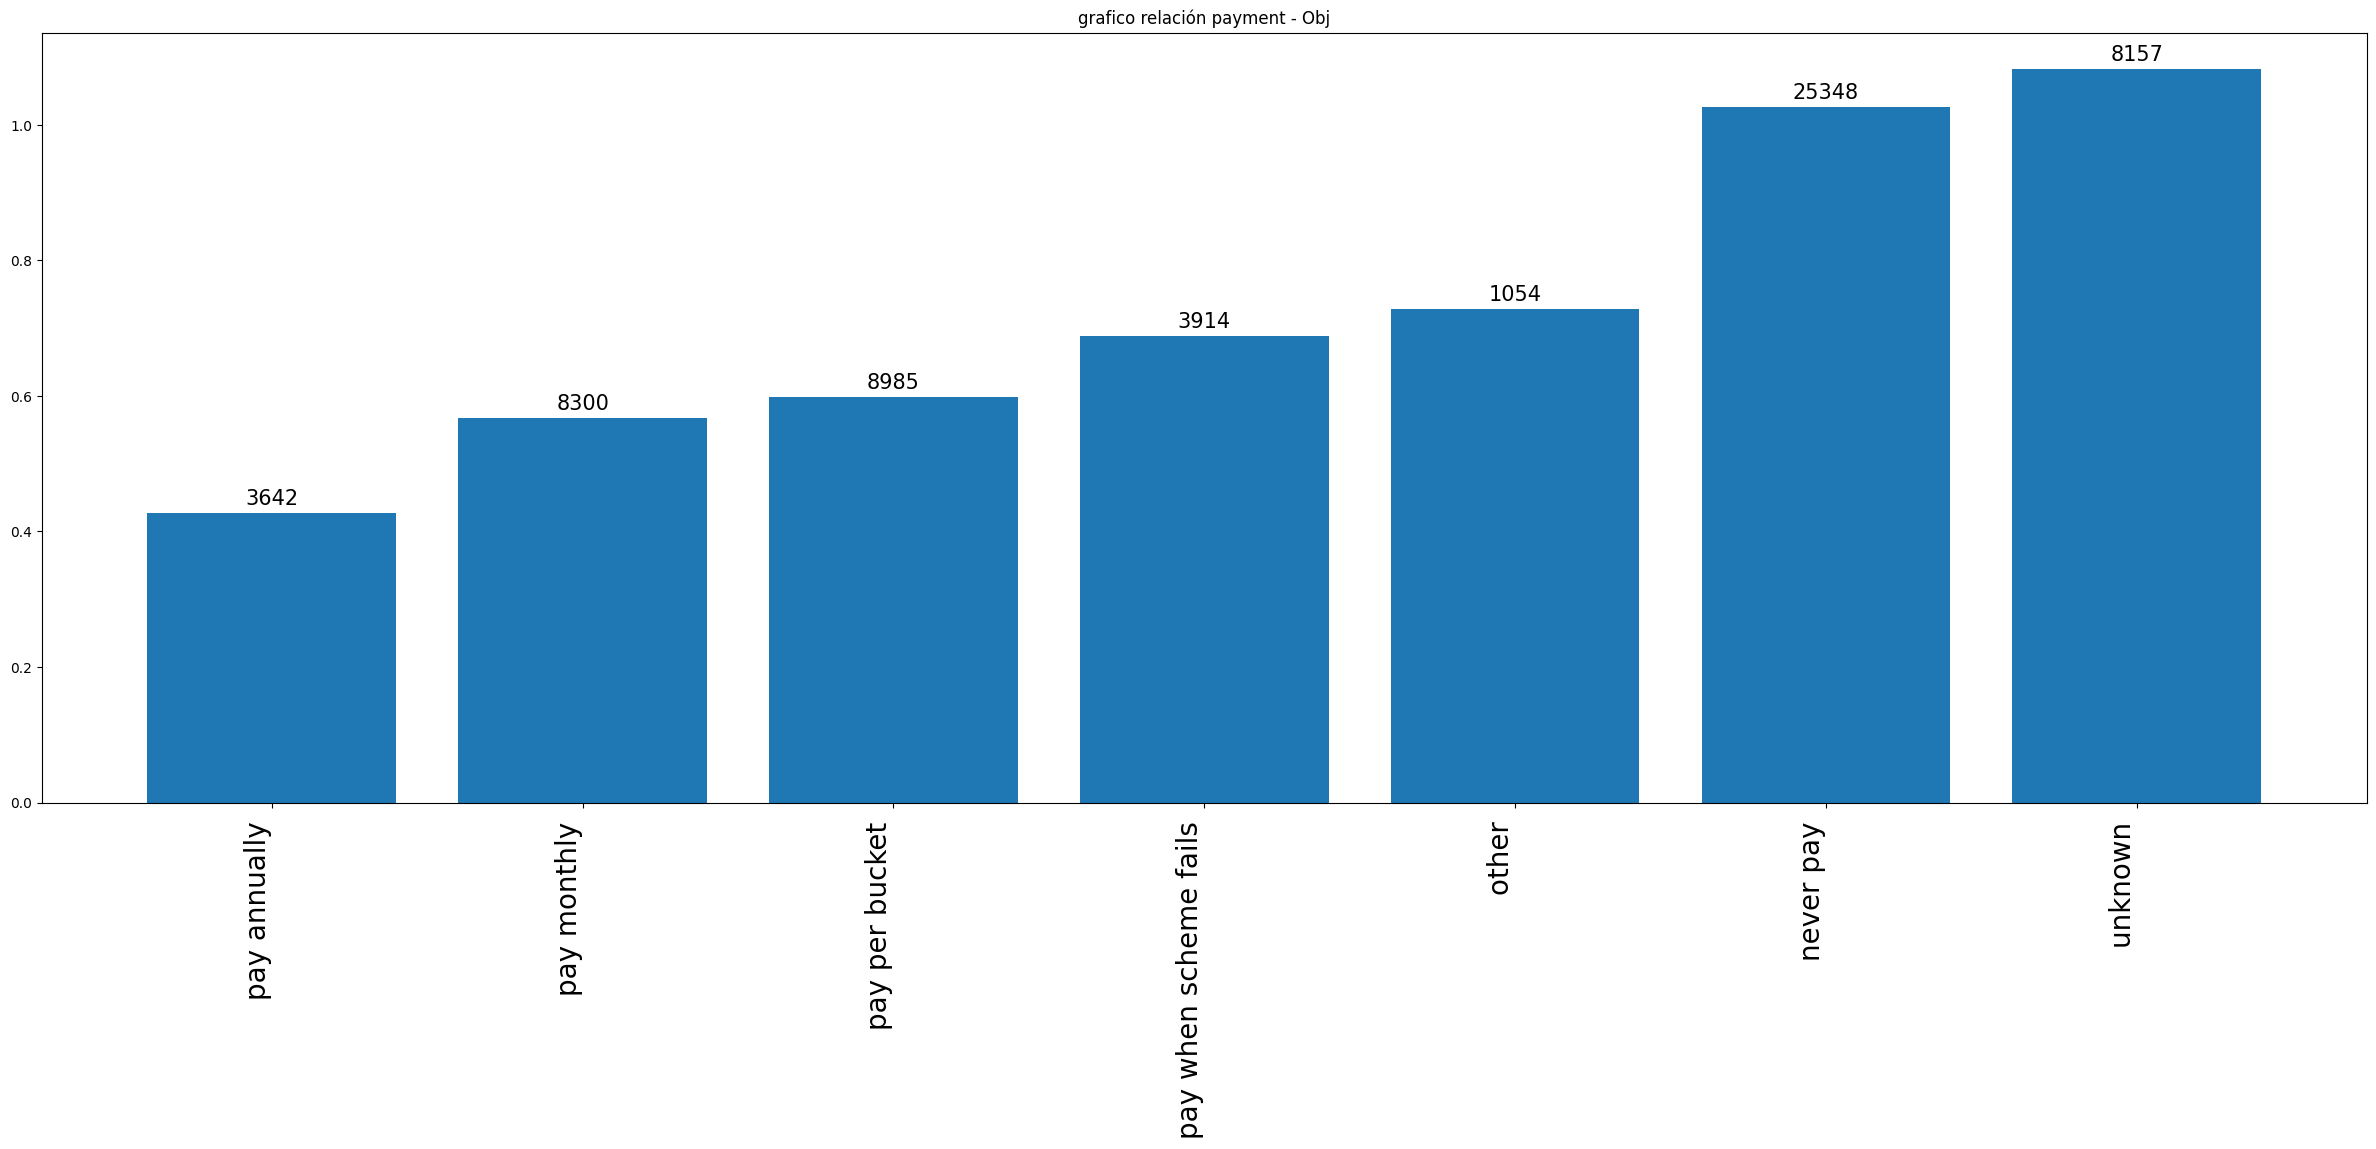

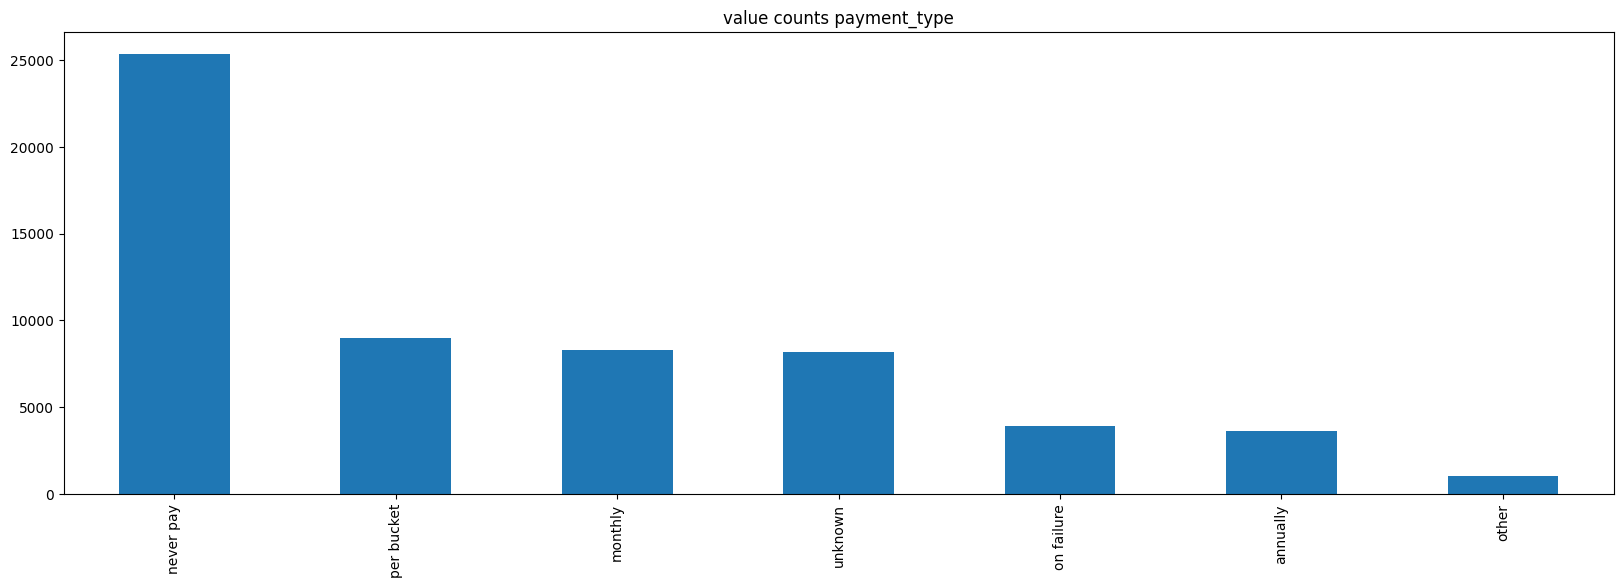

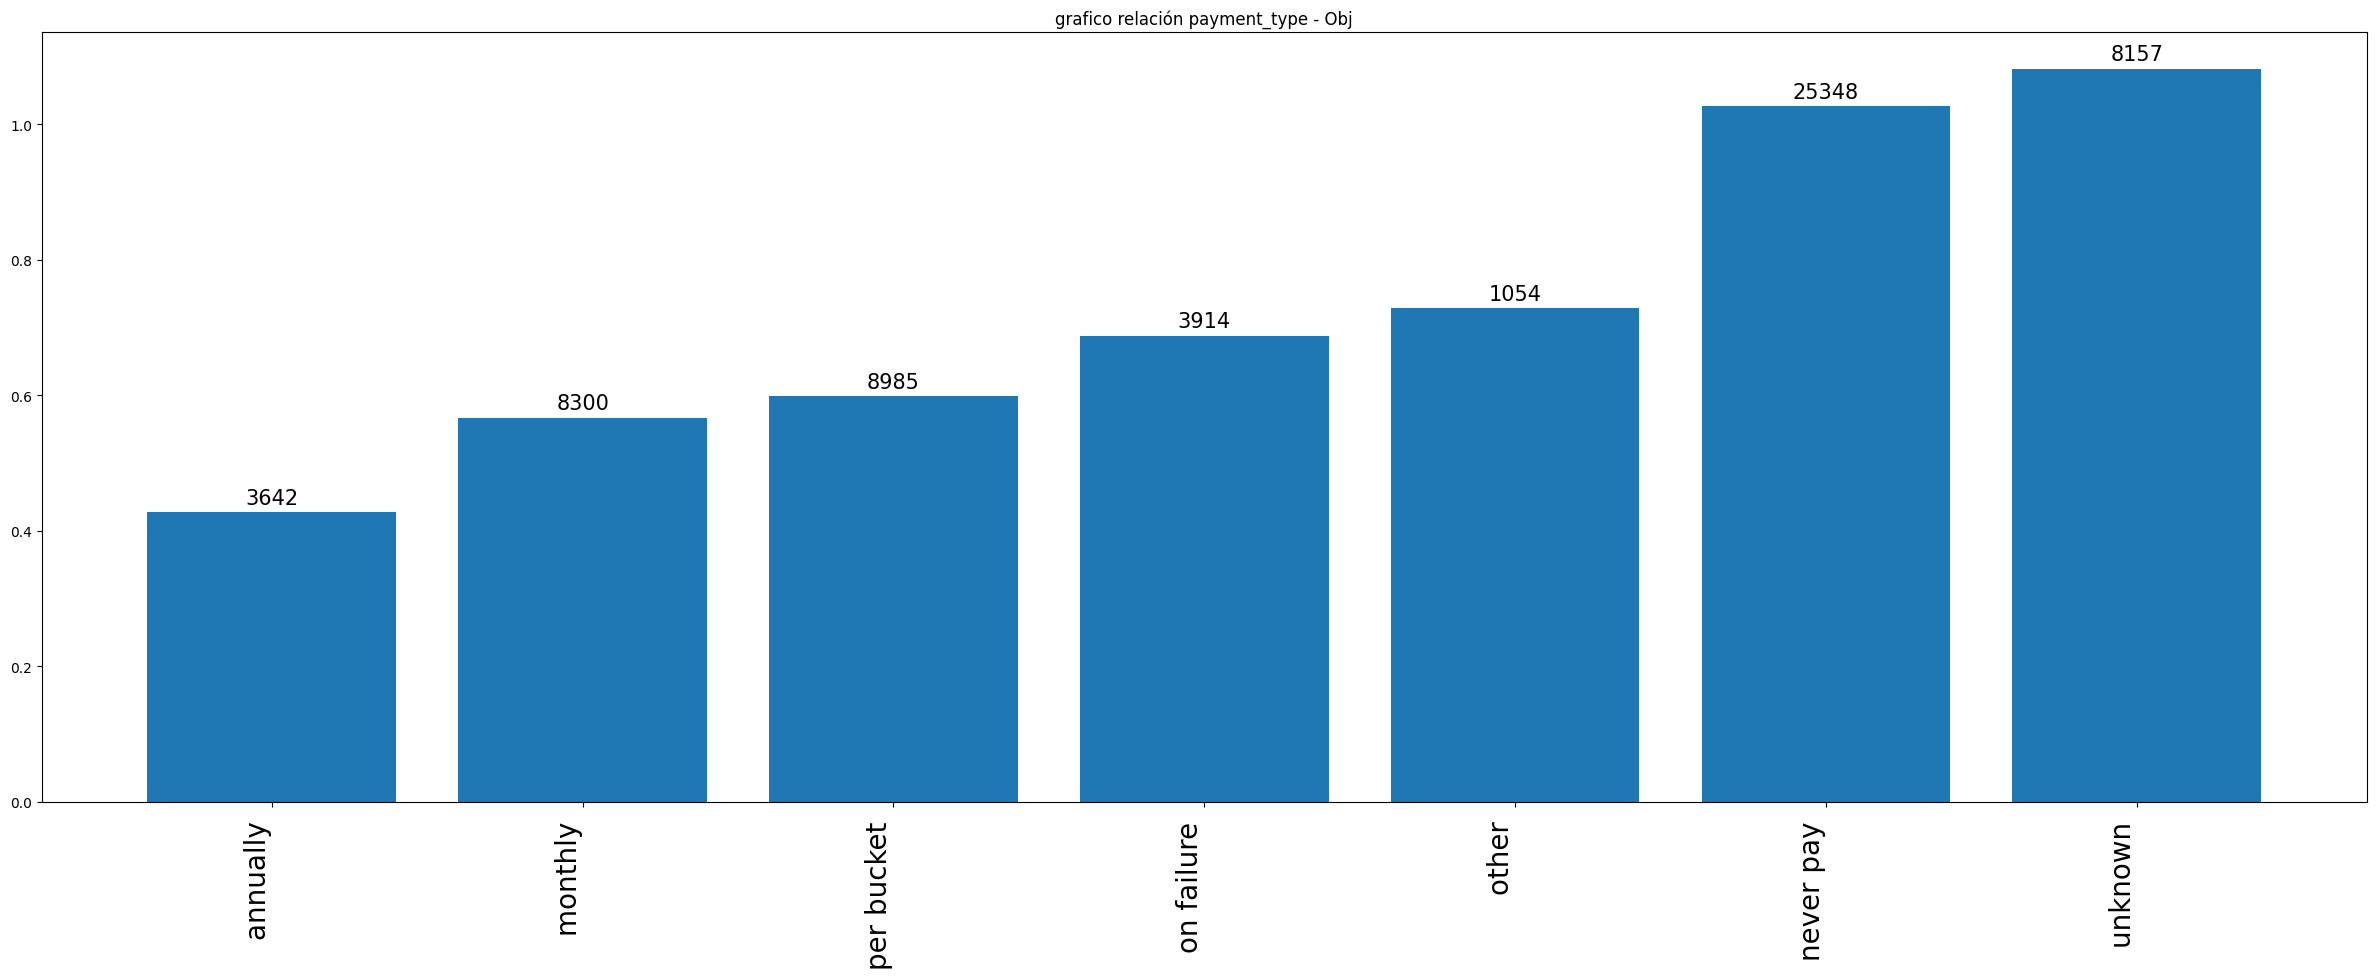

In [240]:
cols = ["payment", "payment_type"]
for i in cols:
    X[i].value_counts().plot(kind="bar") 
    plt.title(f"value counts {i}")
    jd.grafica_relacion_cat_obj(df,f"{i}","status_group",True,titulo=f"grafico relación {i} - Obj")
    plt.show() 

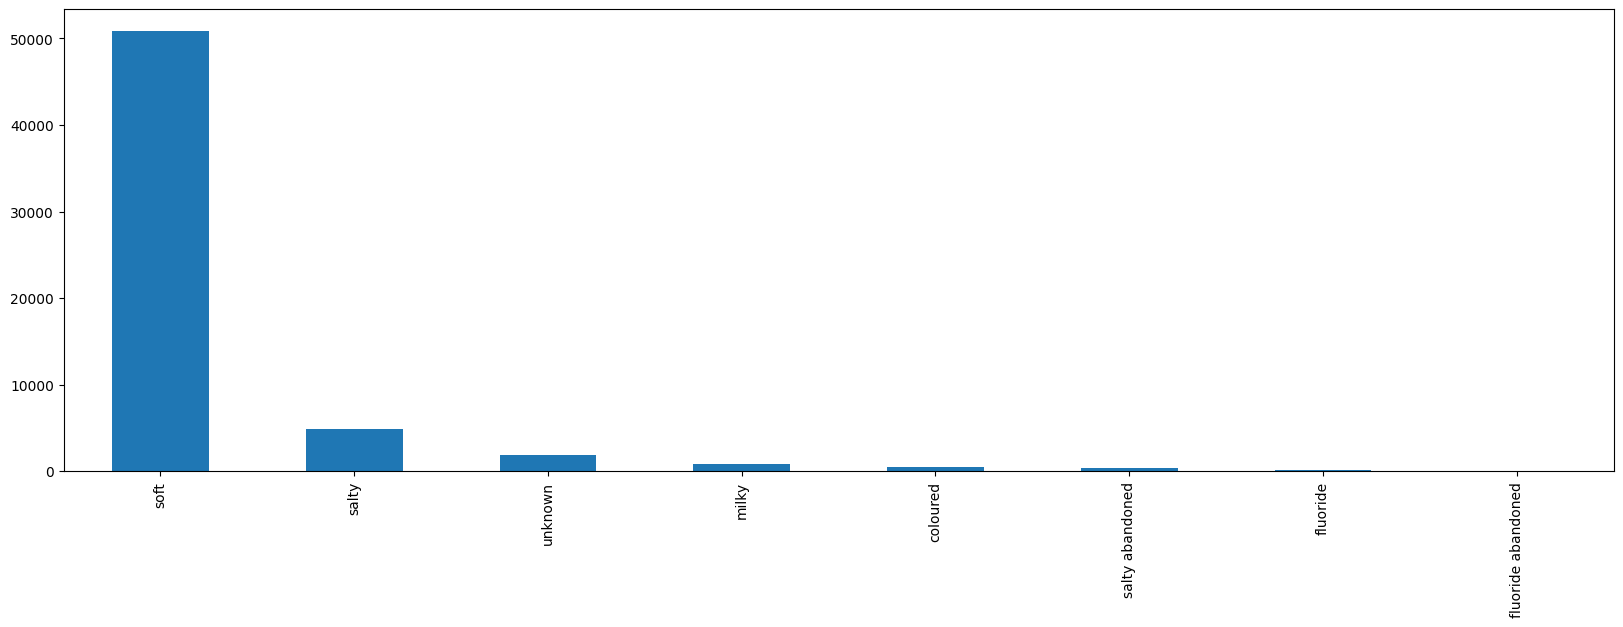

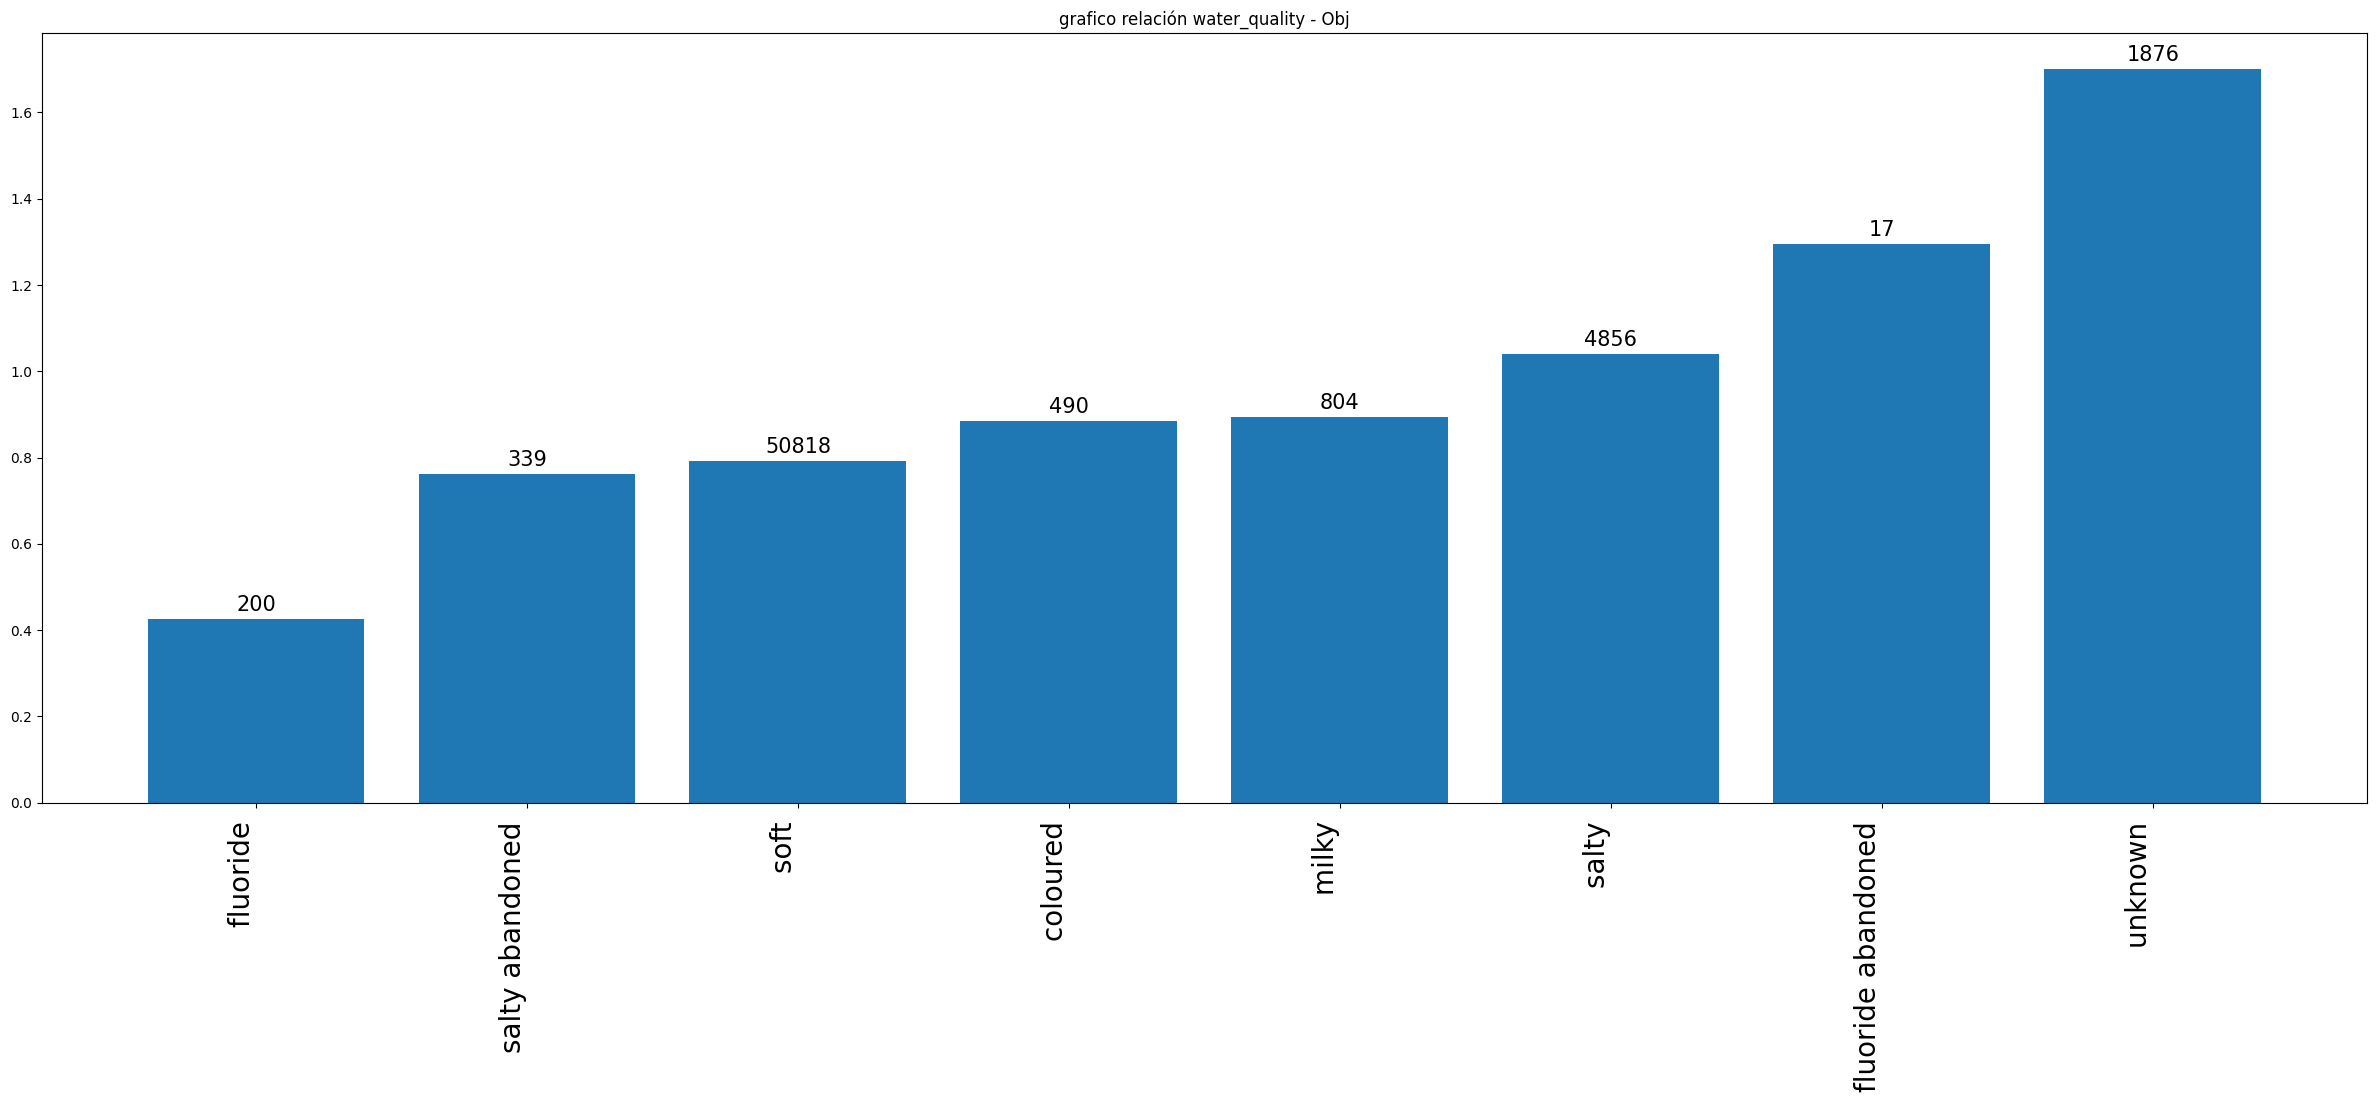

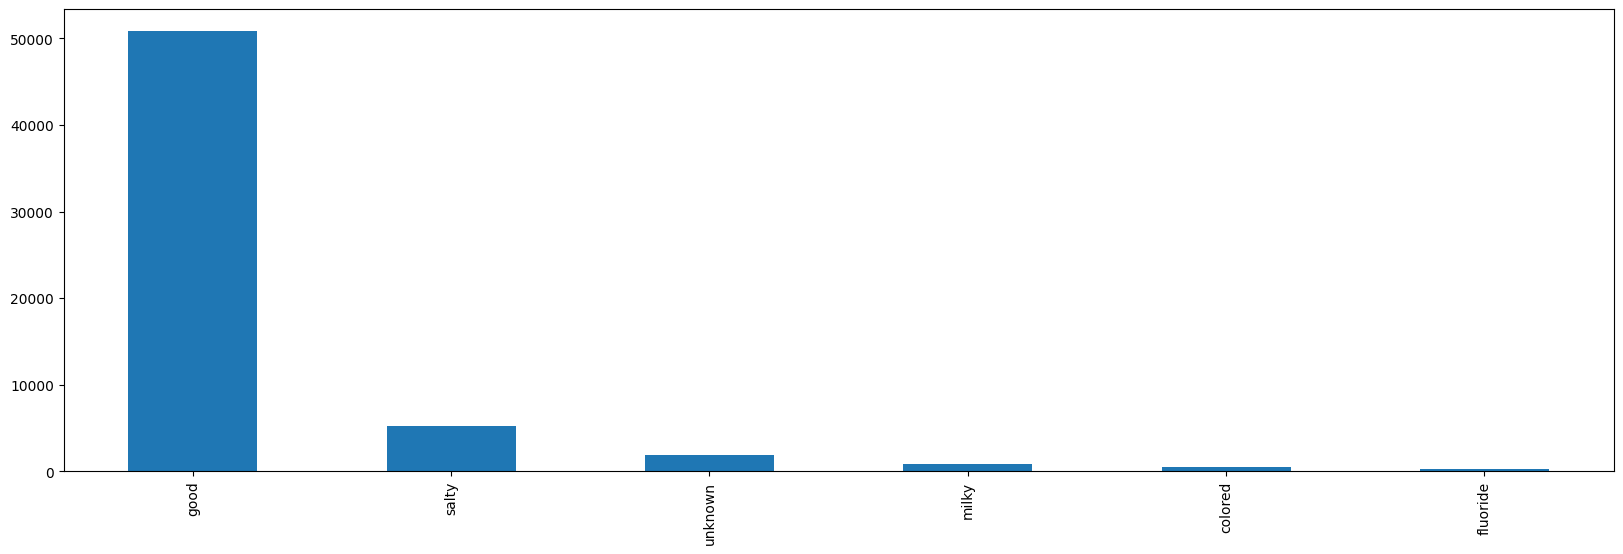

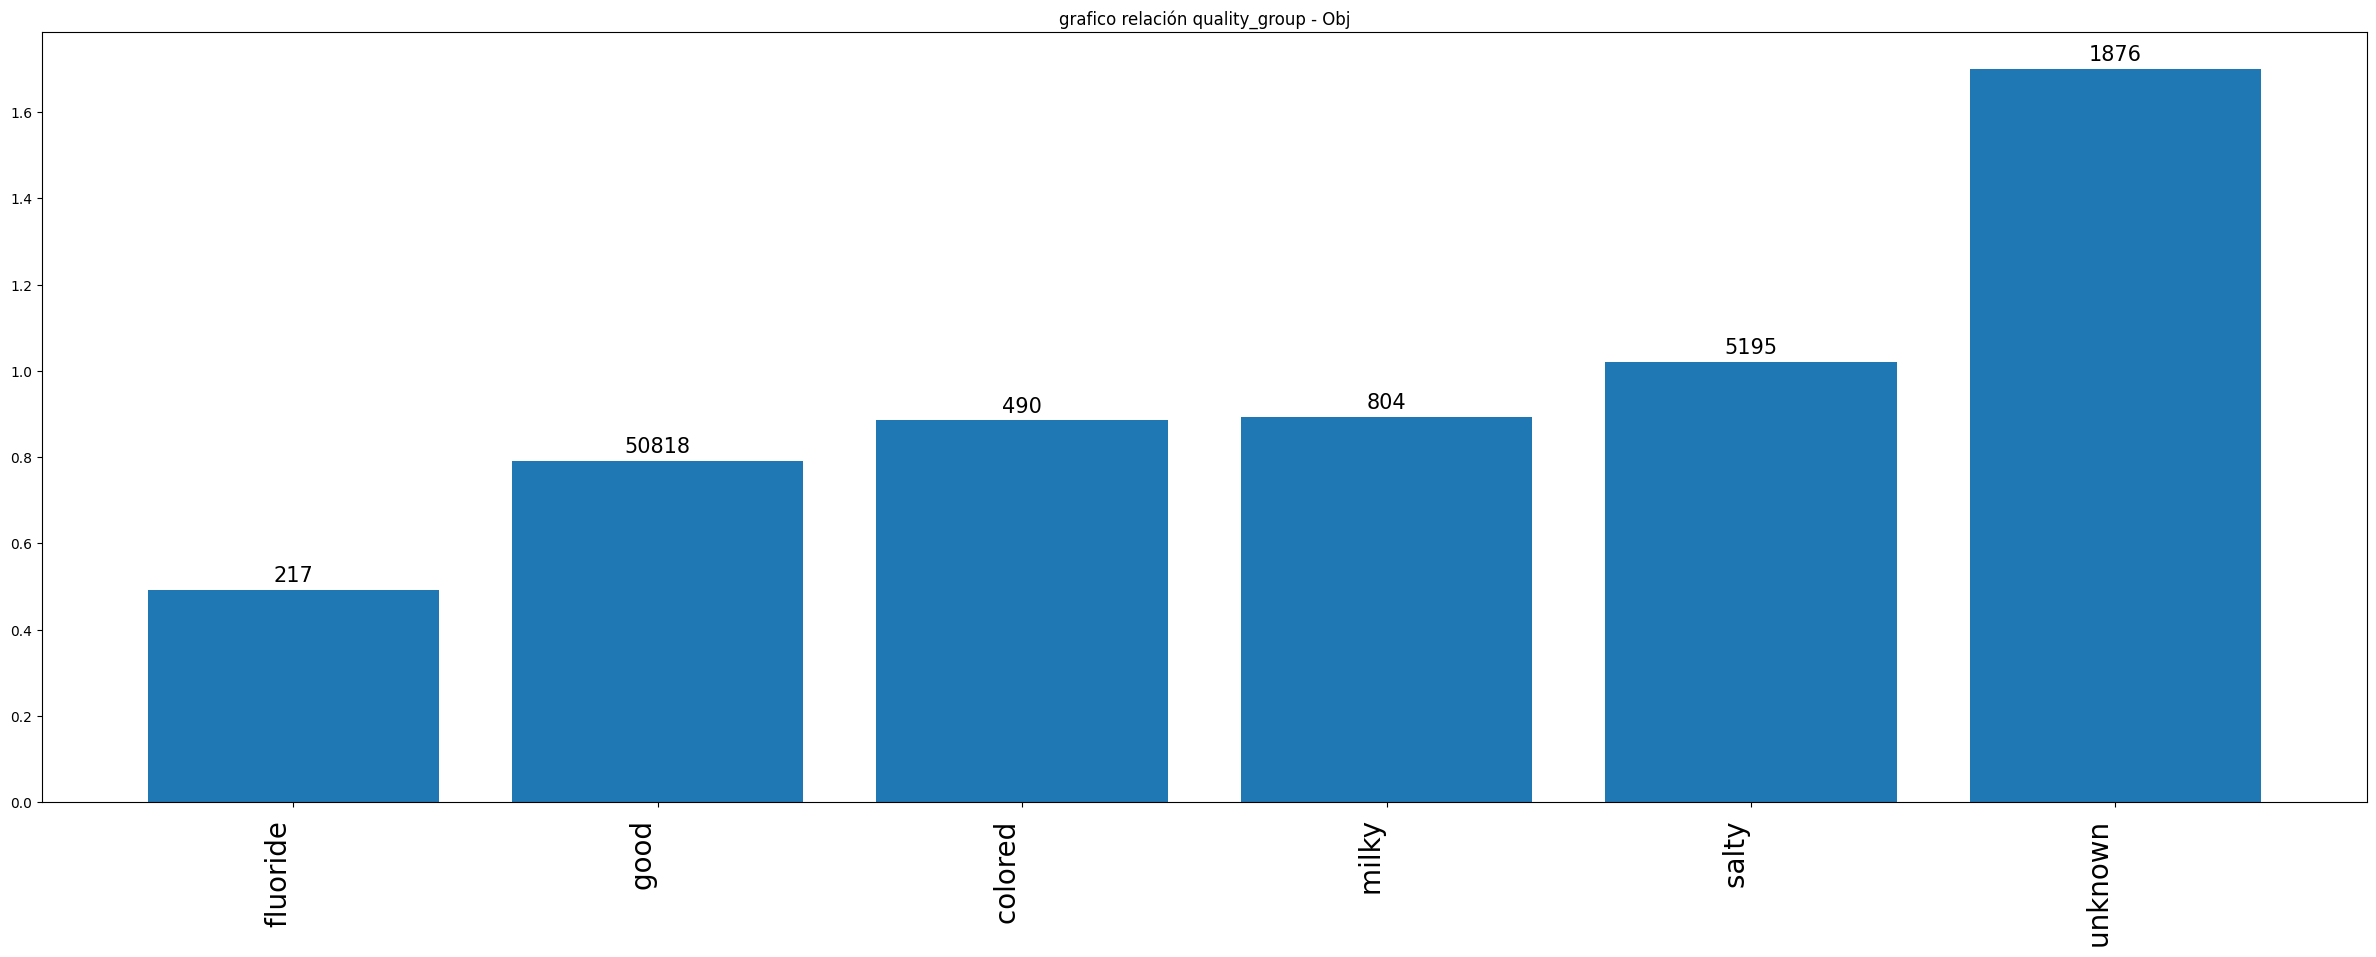

In [241]:
cols = ["water_quality", "quality_group"]
for i in cols:
    X[i].value_counts().plot(kind="bar") 
    jd.grafica_relacion_cat_obj(df,f"{i}","status_group",True,titulo=f"grafico relación {i} - Obj")
    plt.show() 

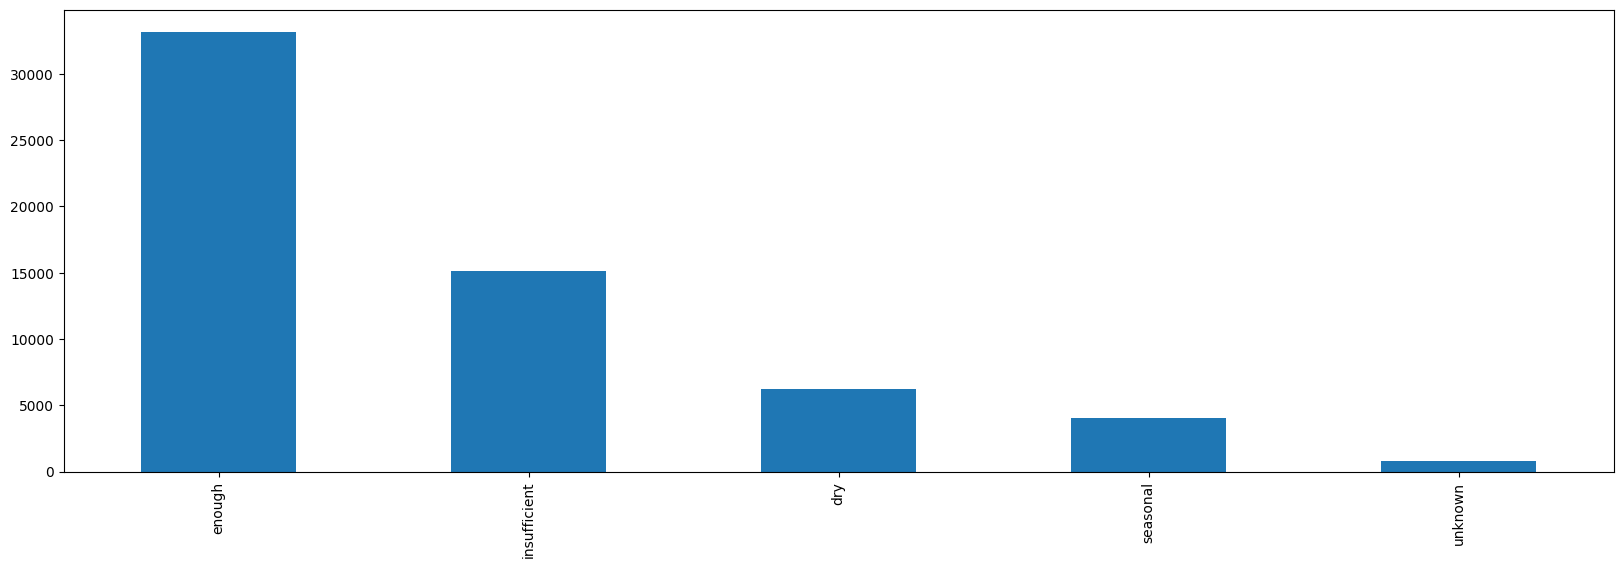

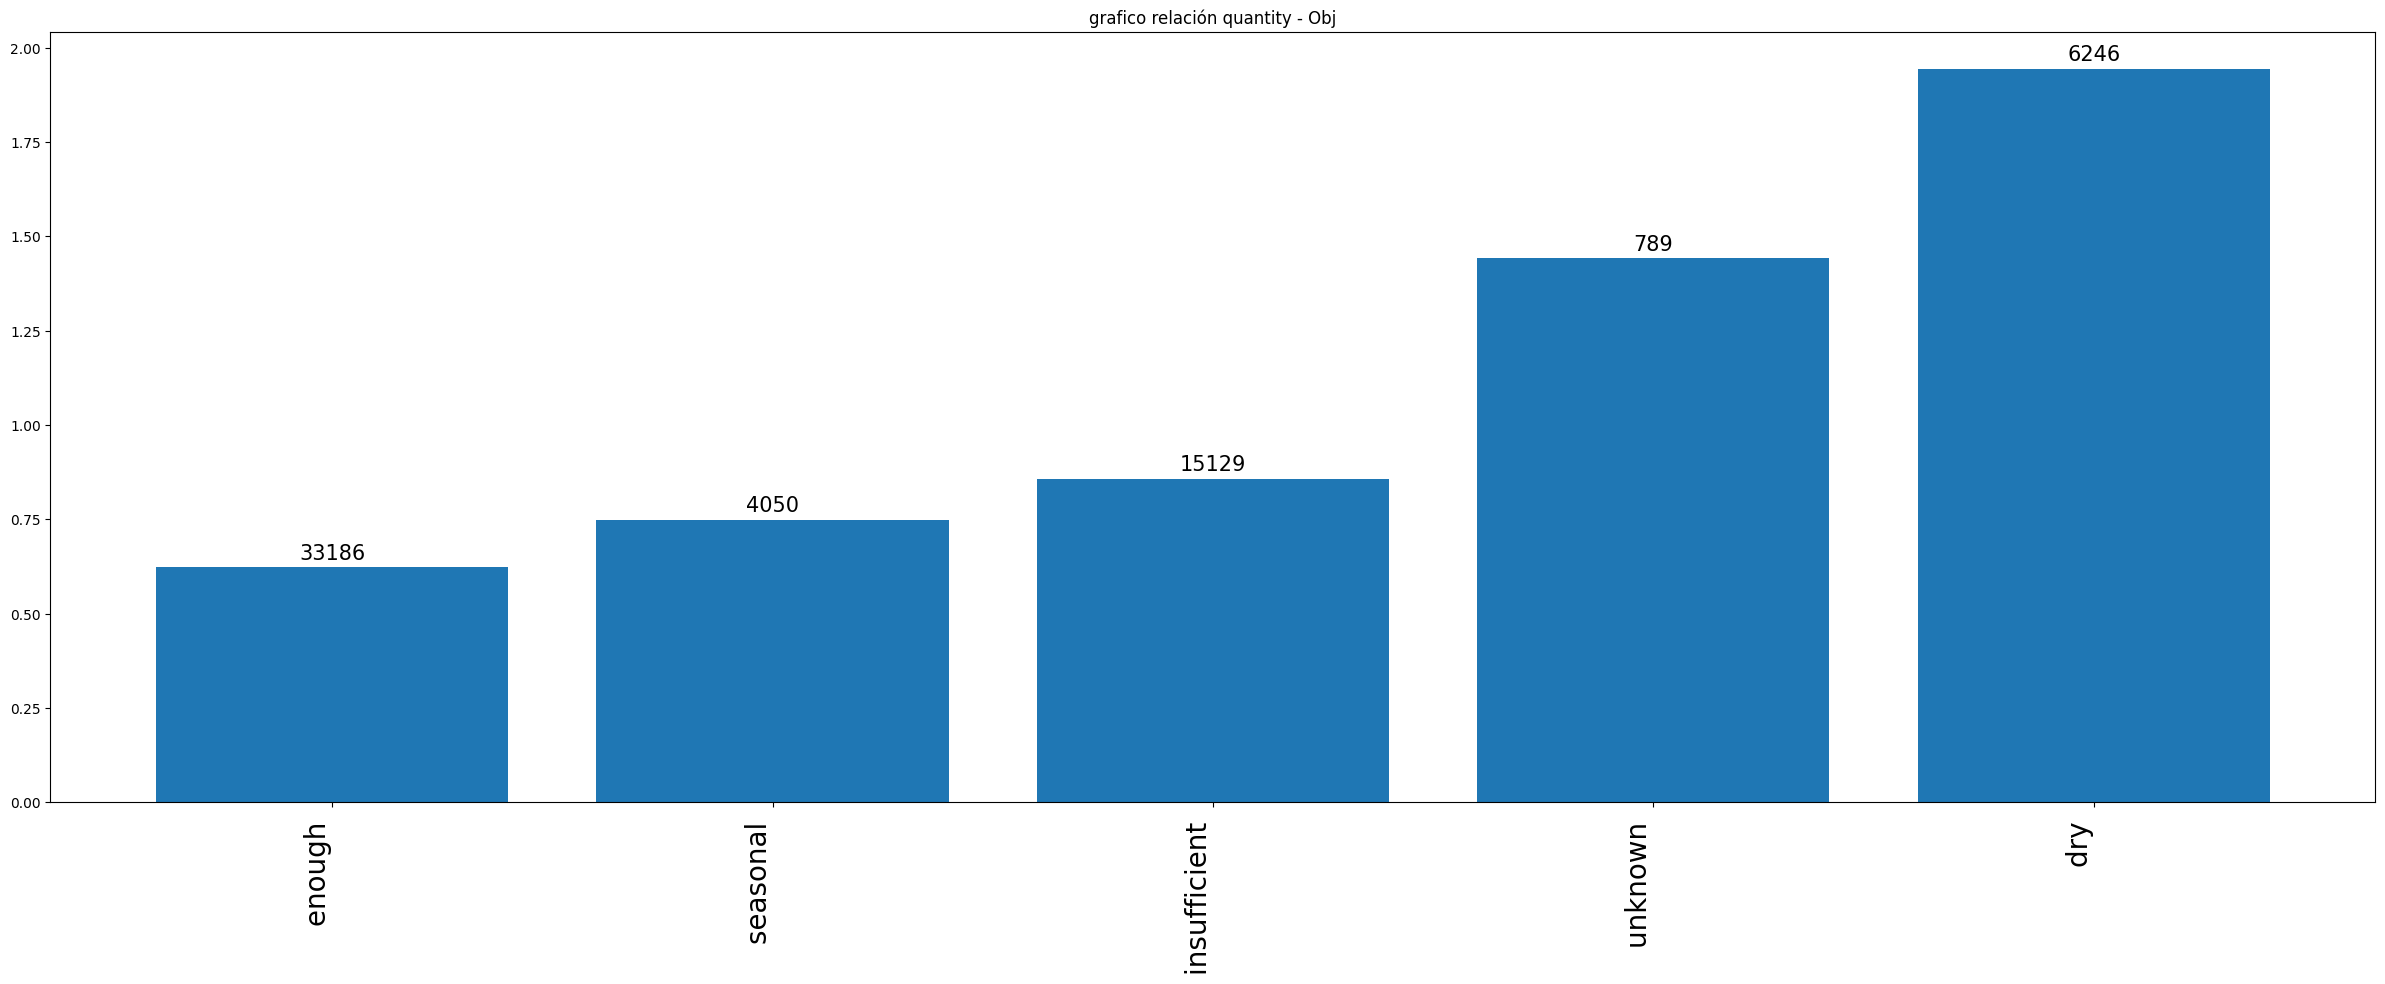

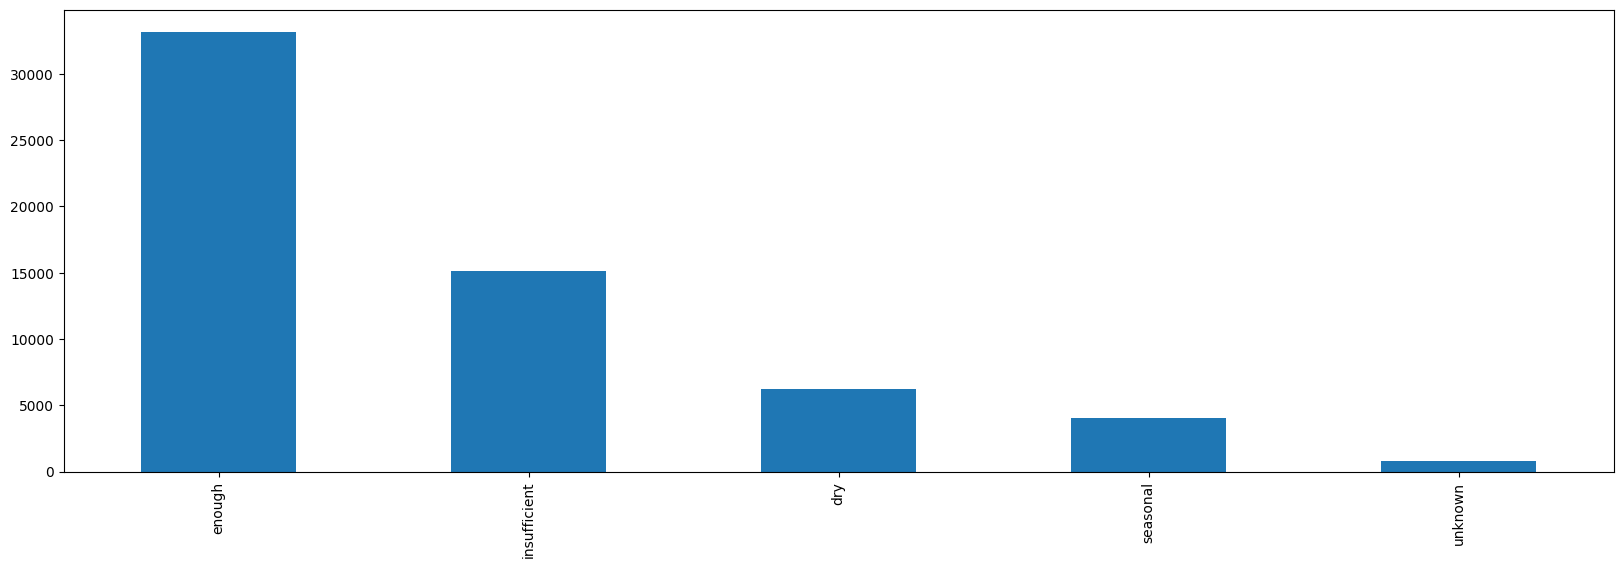

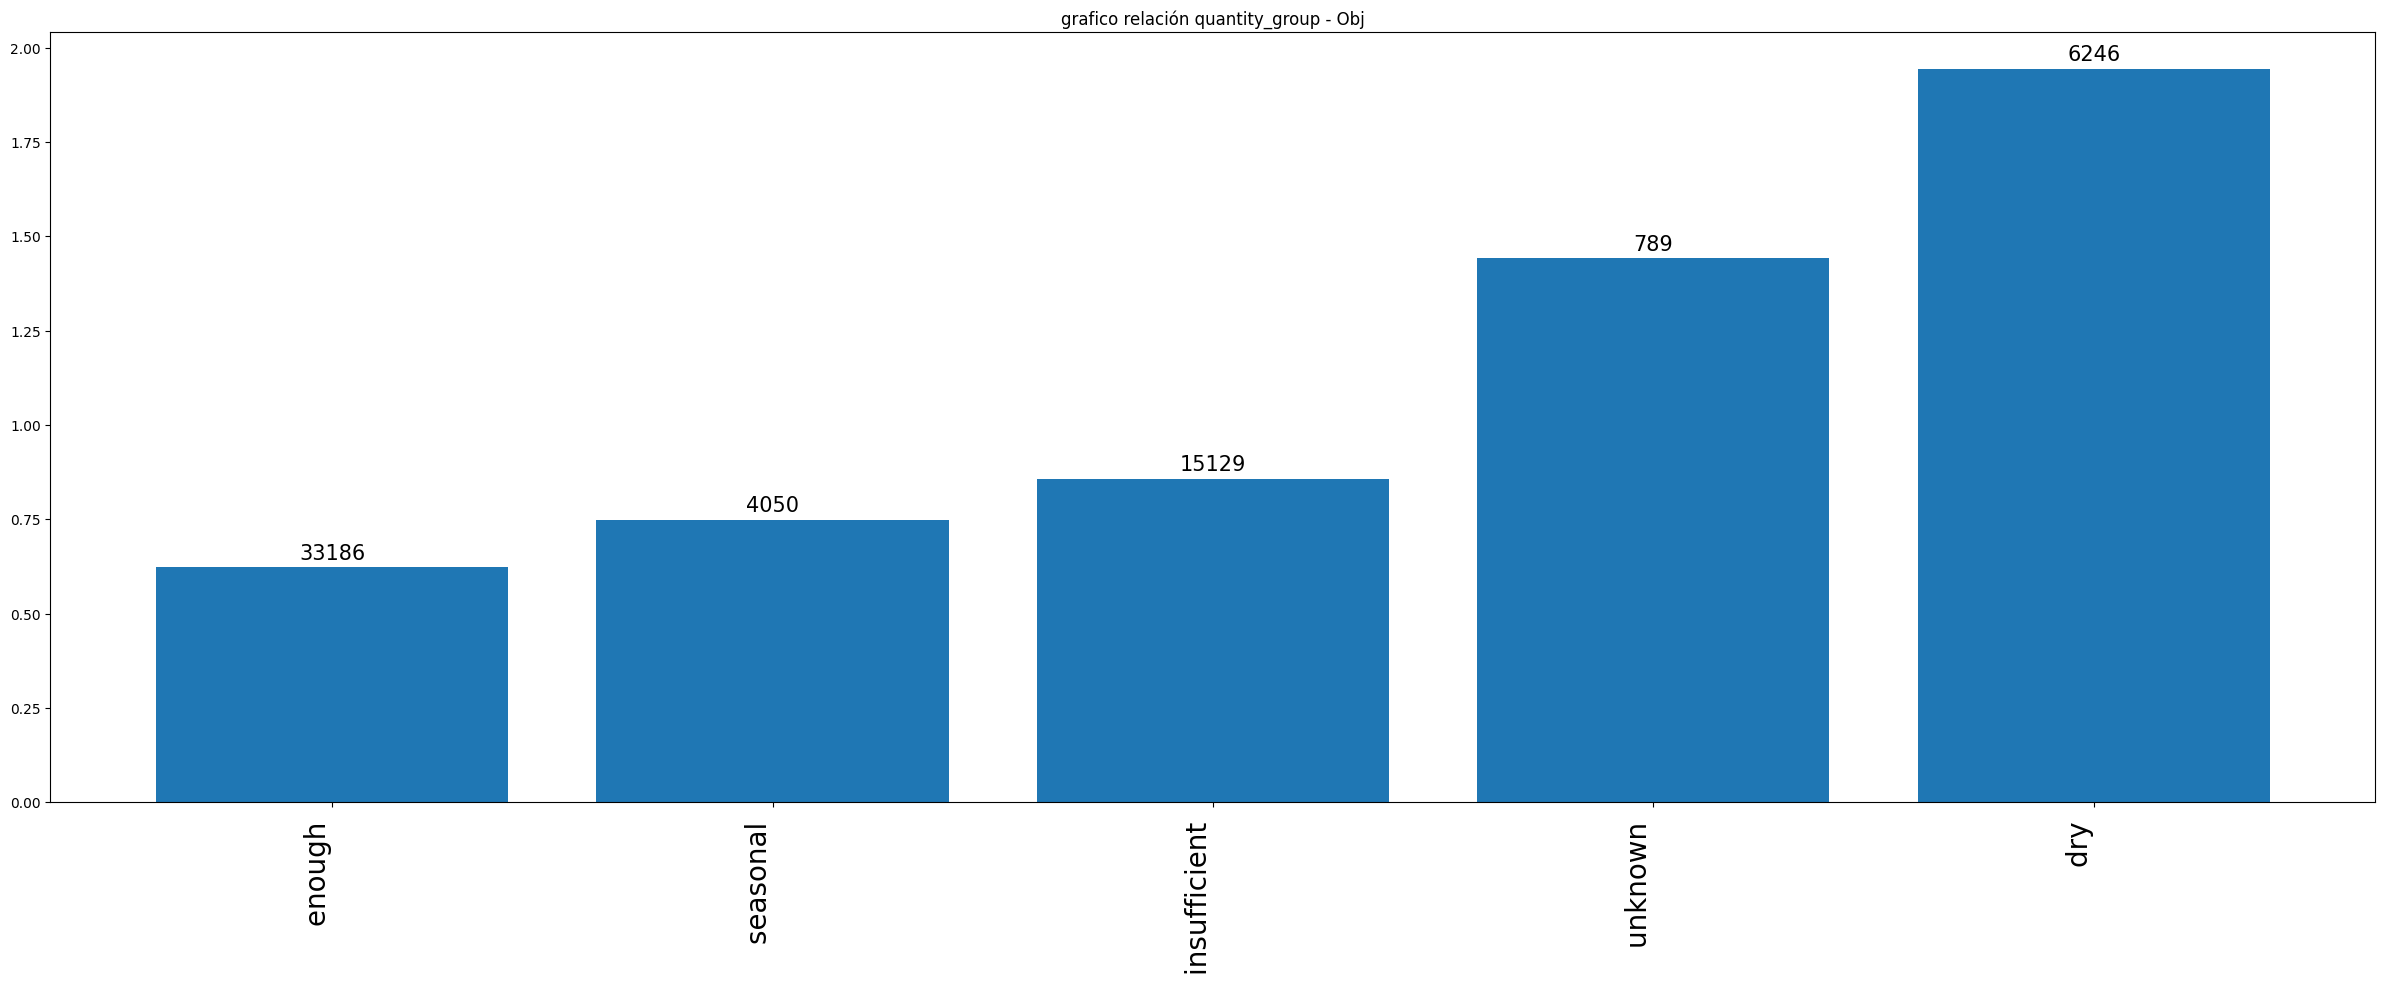

In [242]:
cols = ["quantity", "quantity_group"]
for i in cols:
    X[i].value_counts().plot(kind="bar") 
    df.status_group = LabelEncoder().fit_transform(df.status_group)
    jd.grafica_relacion_cat_obj(df,f"{i}","status_group",True,titulo=f"grafico relación {i} - Obj")
    plt.show() 

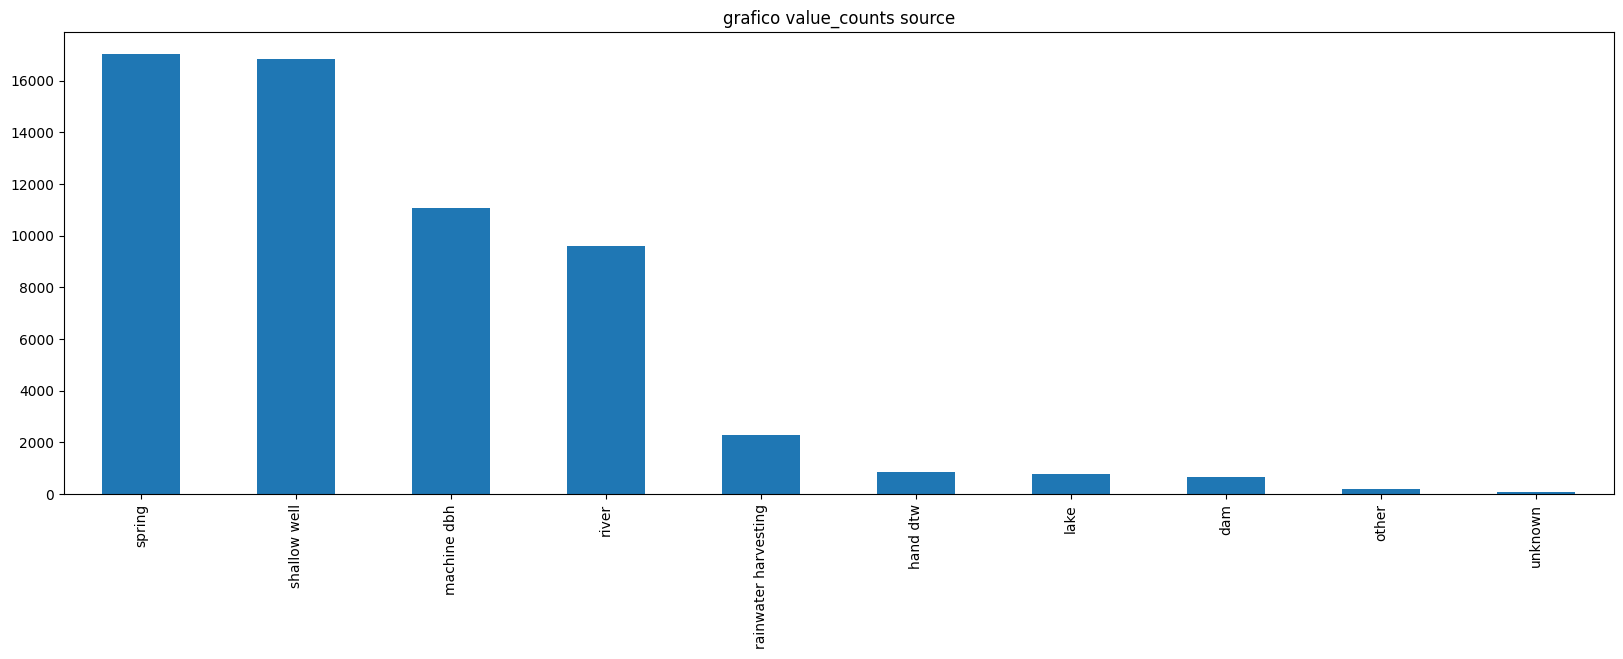

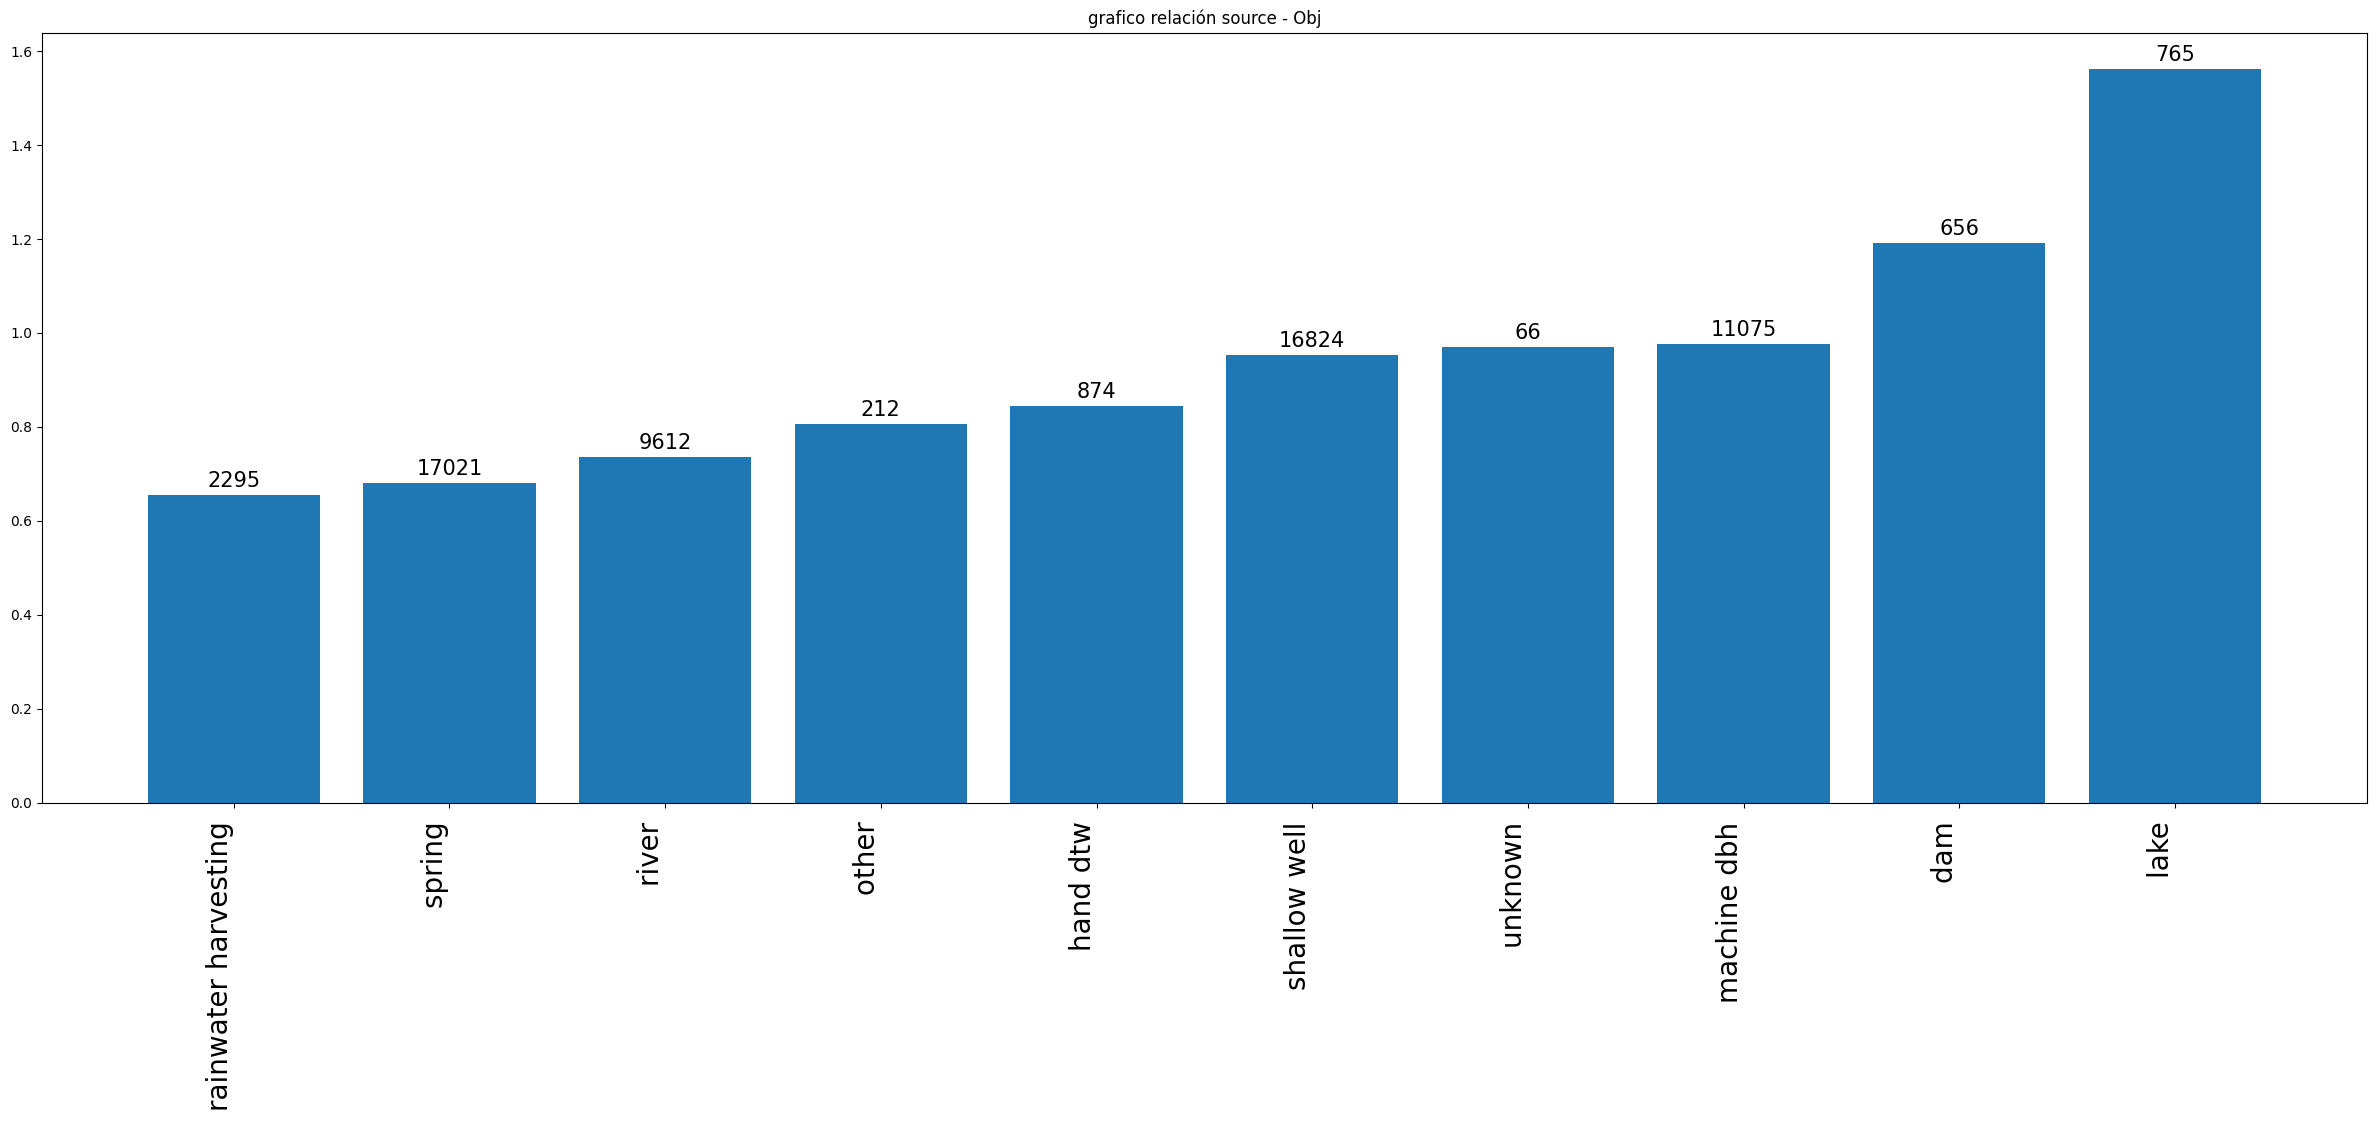

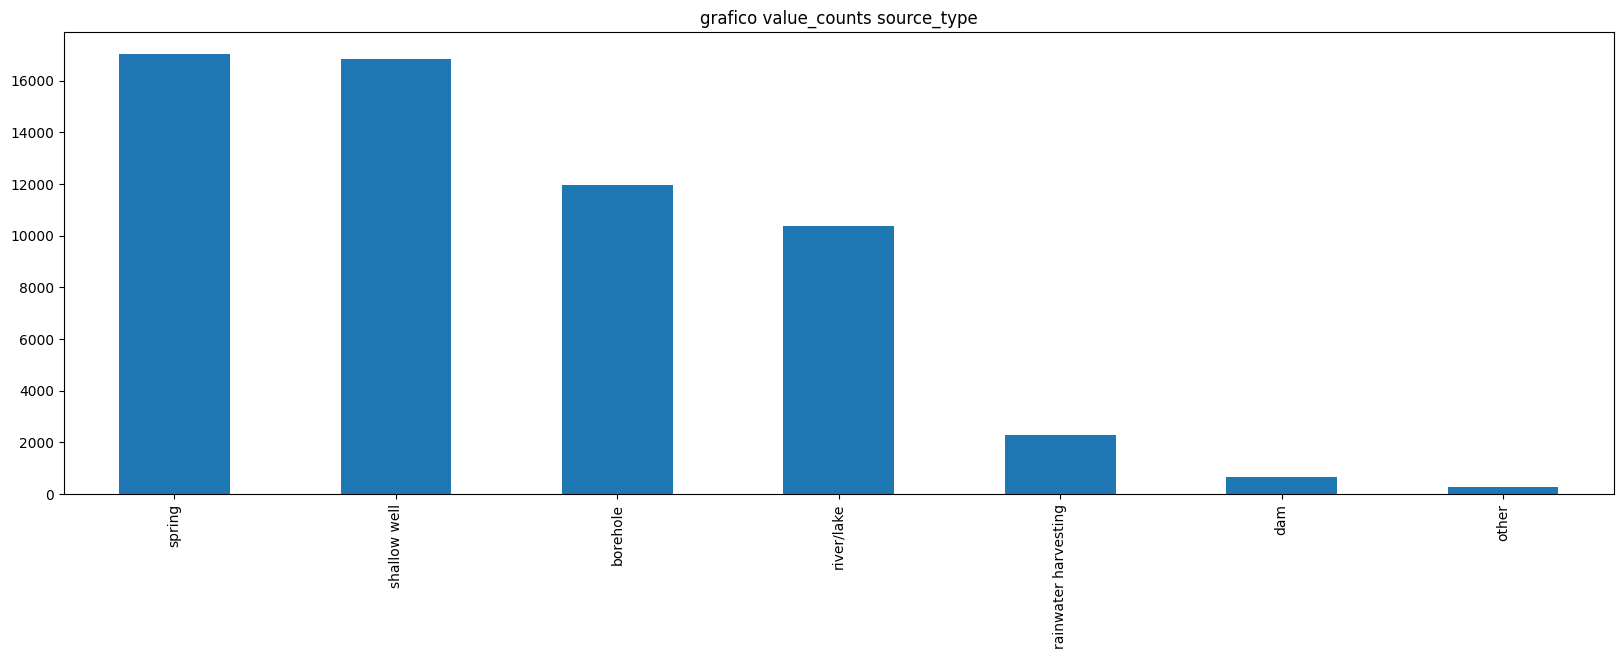

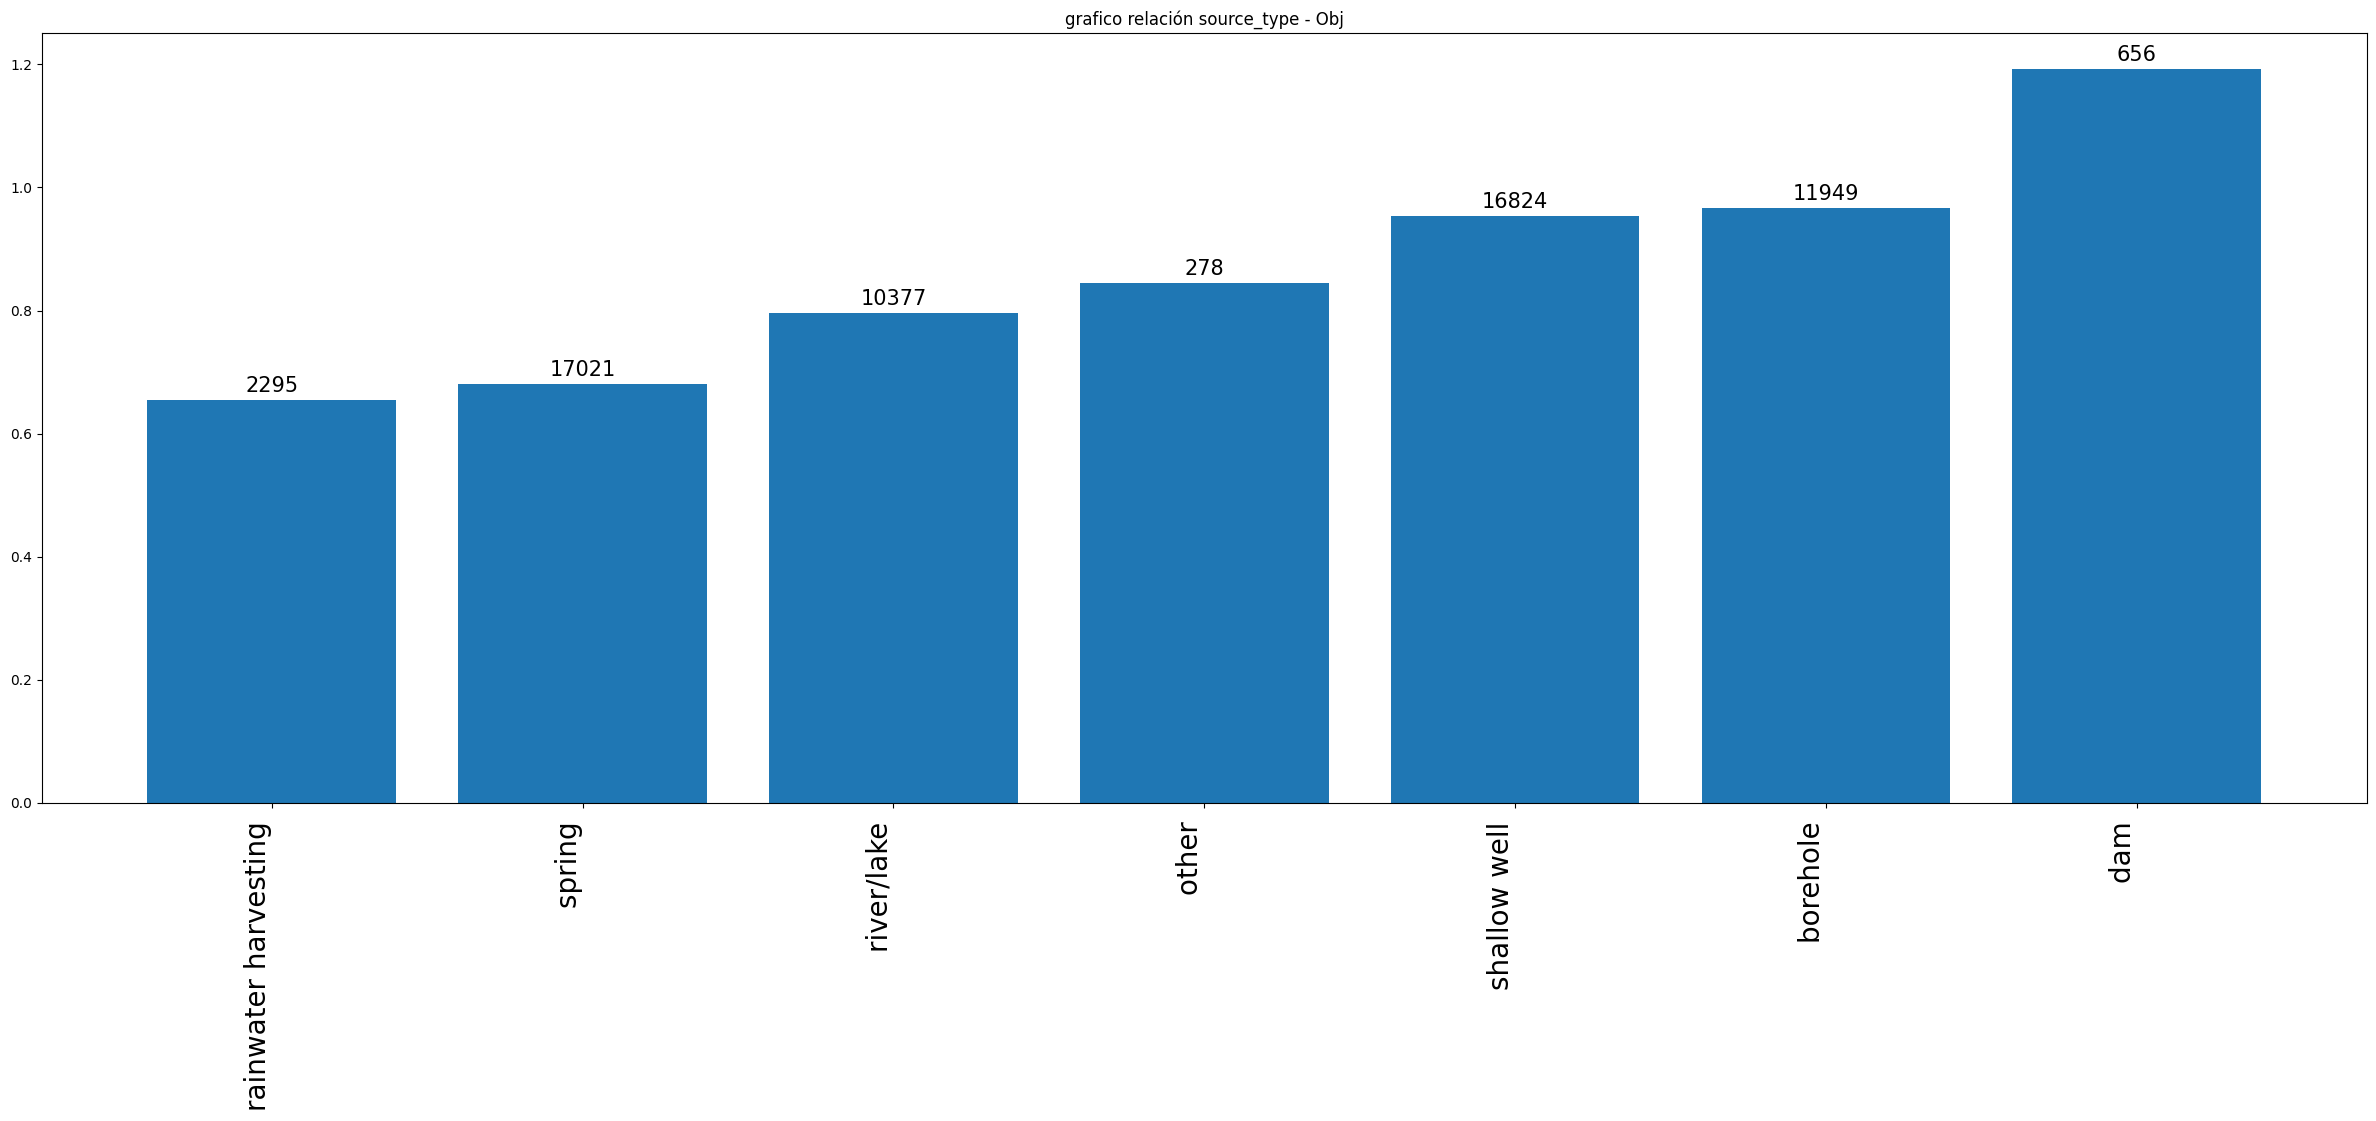

In [243]:
cols = ["source", "source_type"]
for i in cols:
    X[i].value_counts().plot(kind="bar") 
    plt.title(f"grafico value_counts {i}")
    jd.grafica_relacion_cat_obj(df,f"{i}","status_group",True,titulo=f"grafico relación {i} - Obj")
    plt.show() 

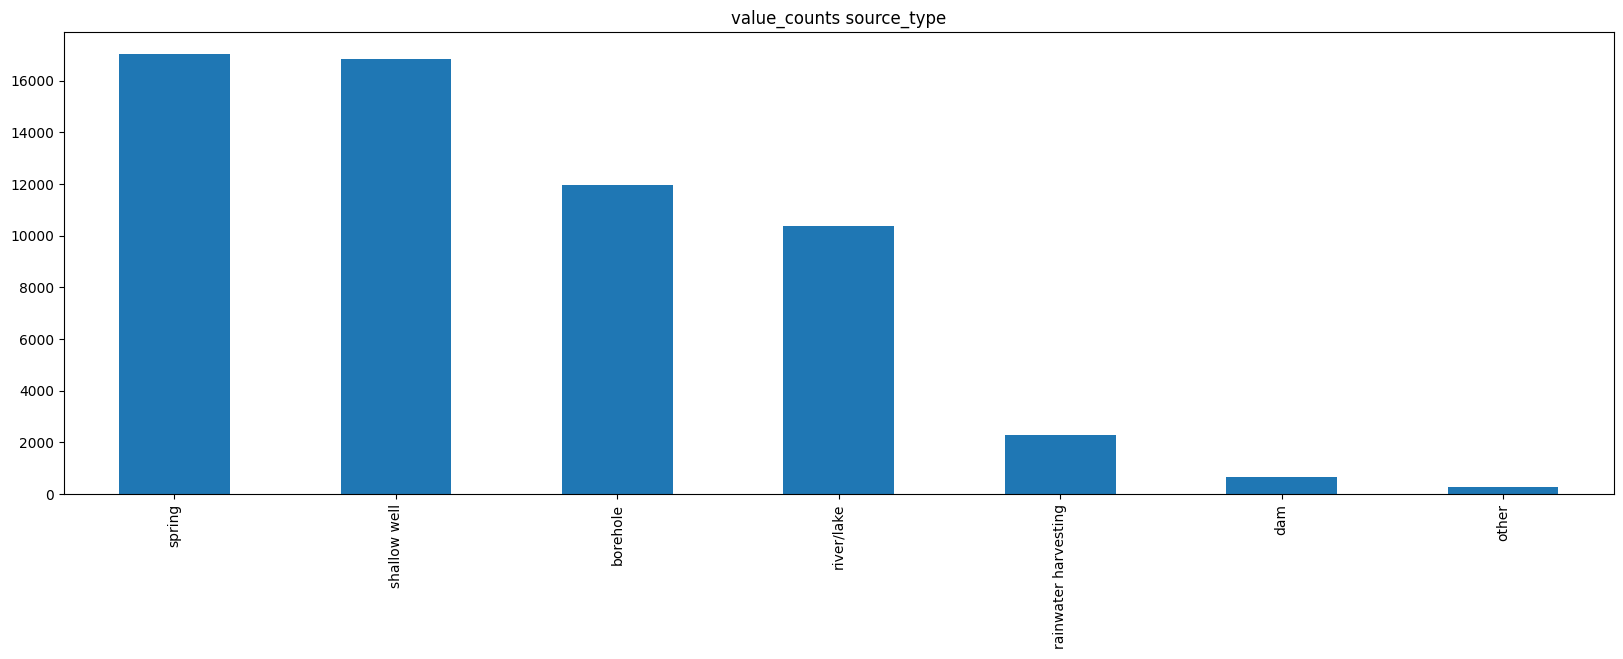

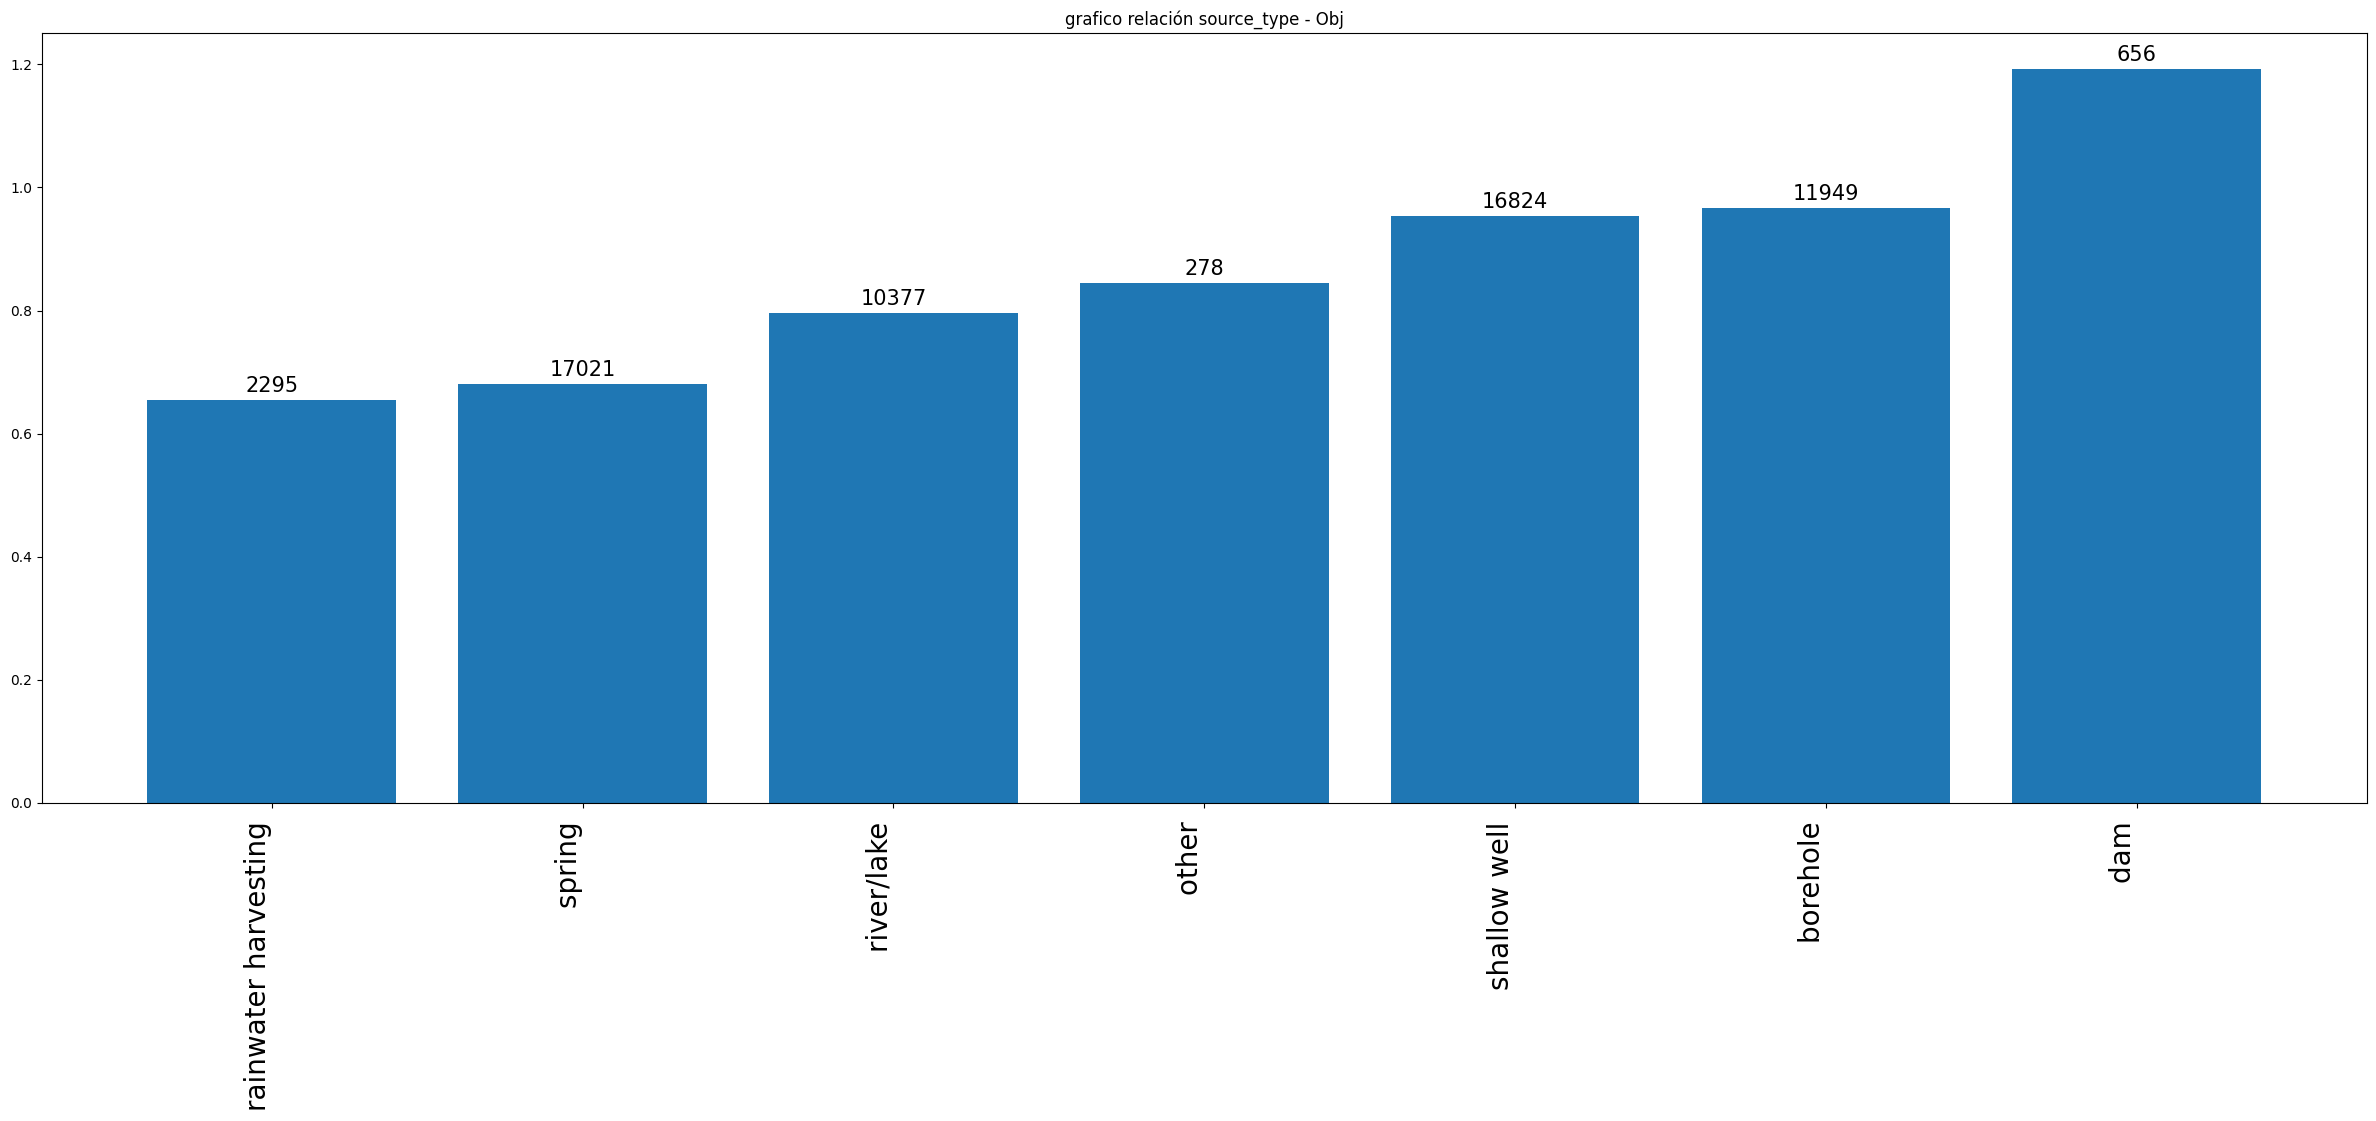

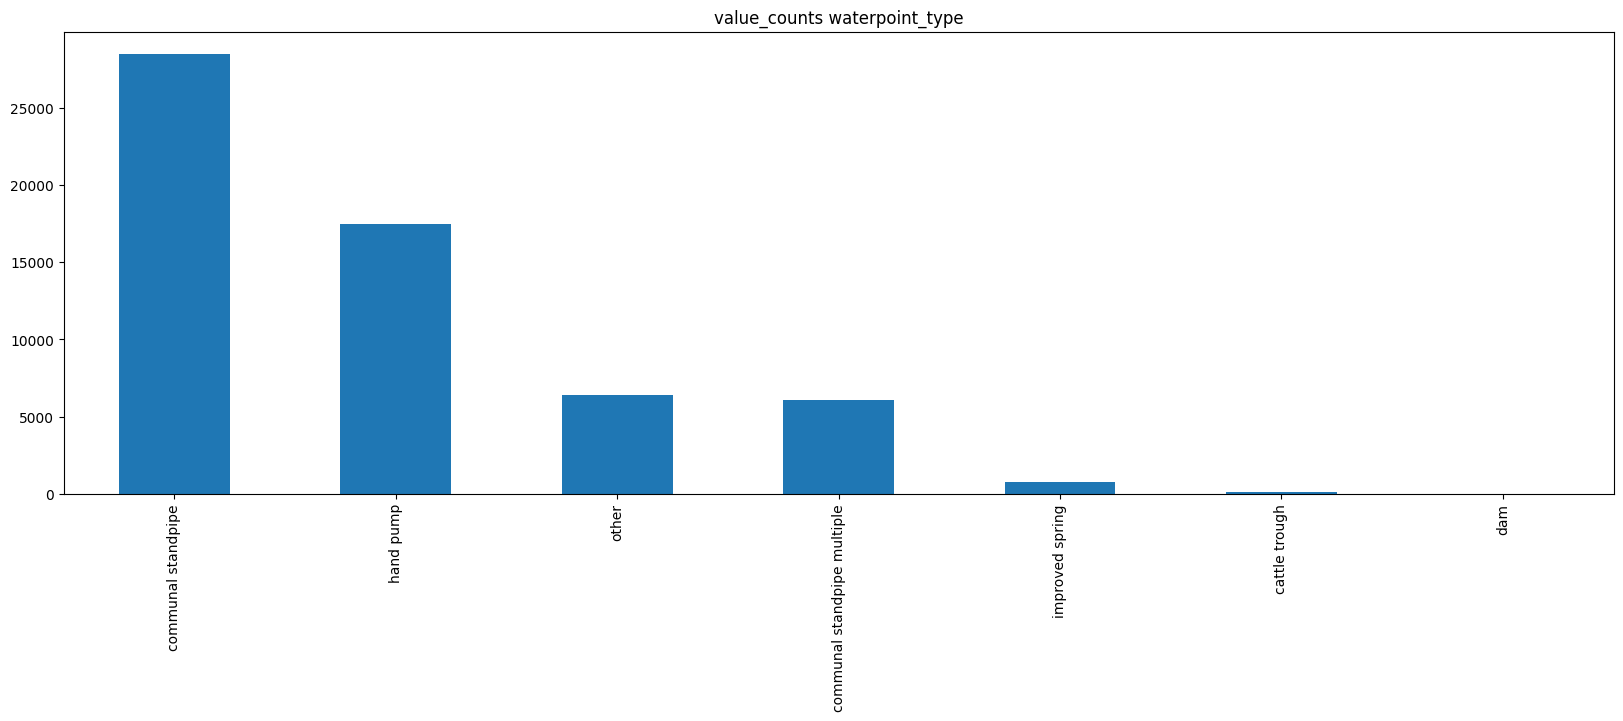

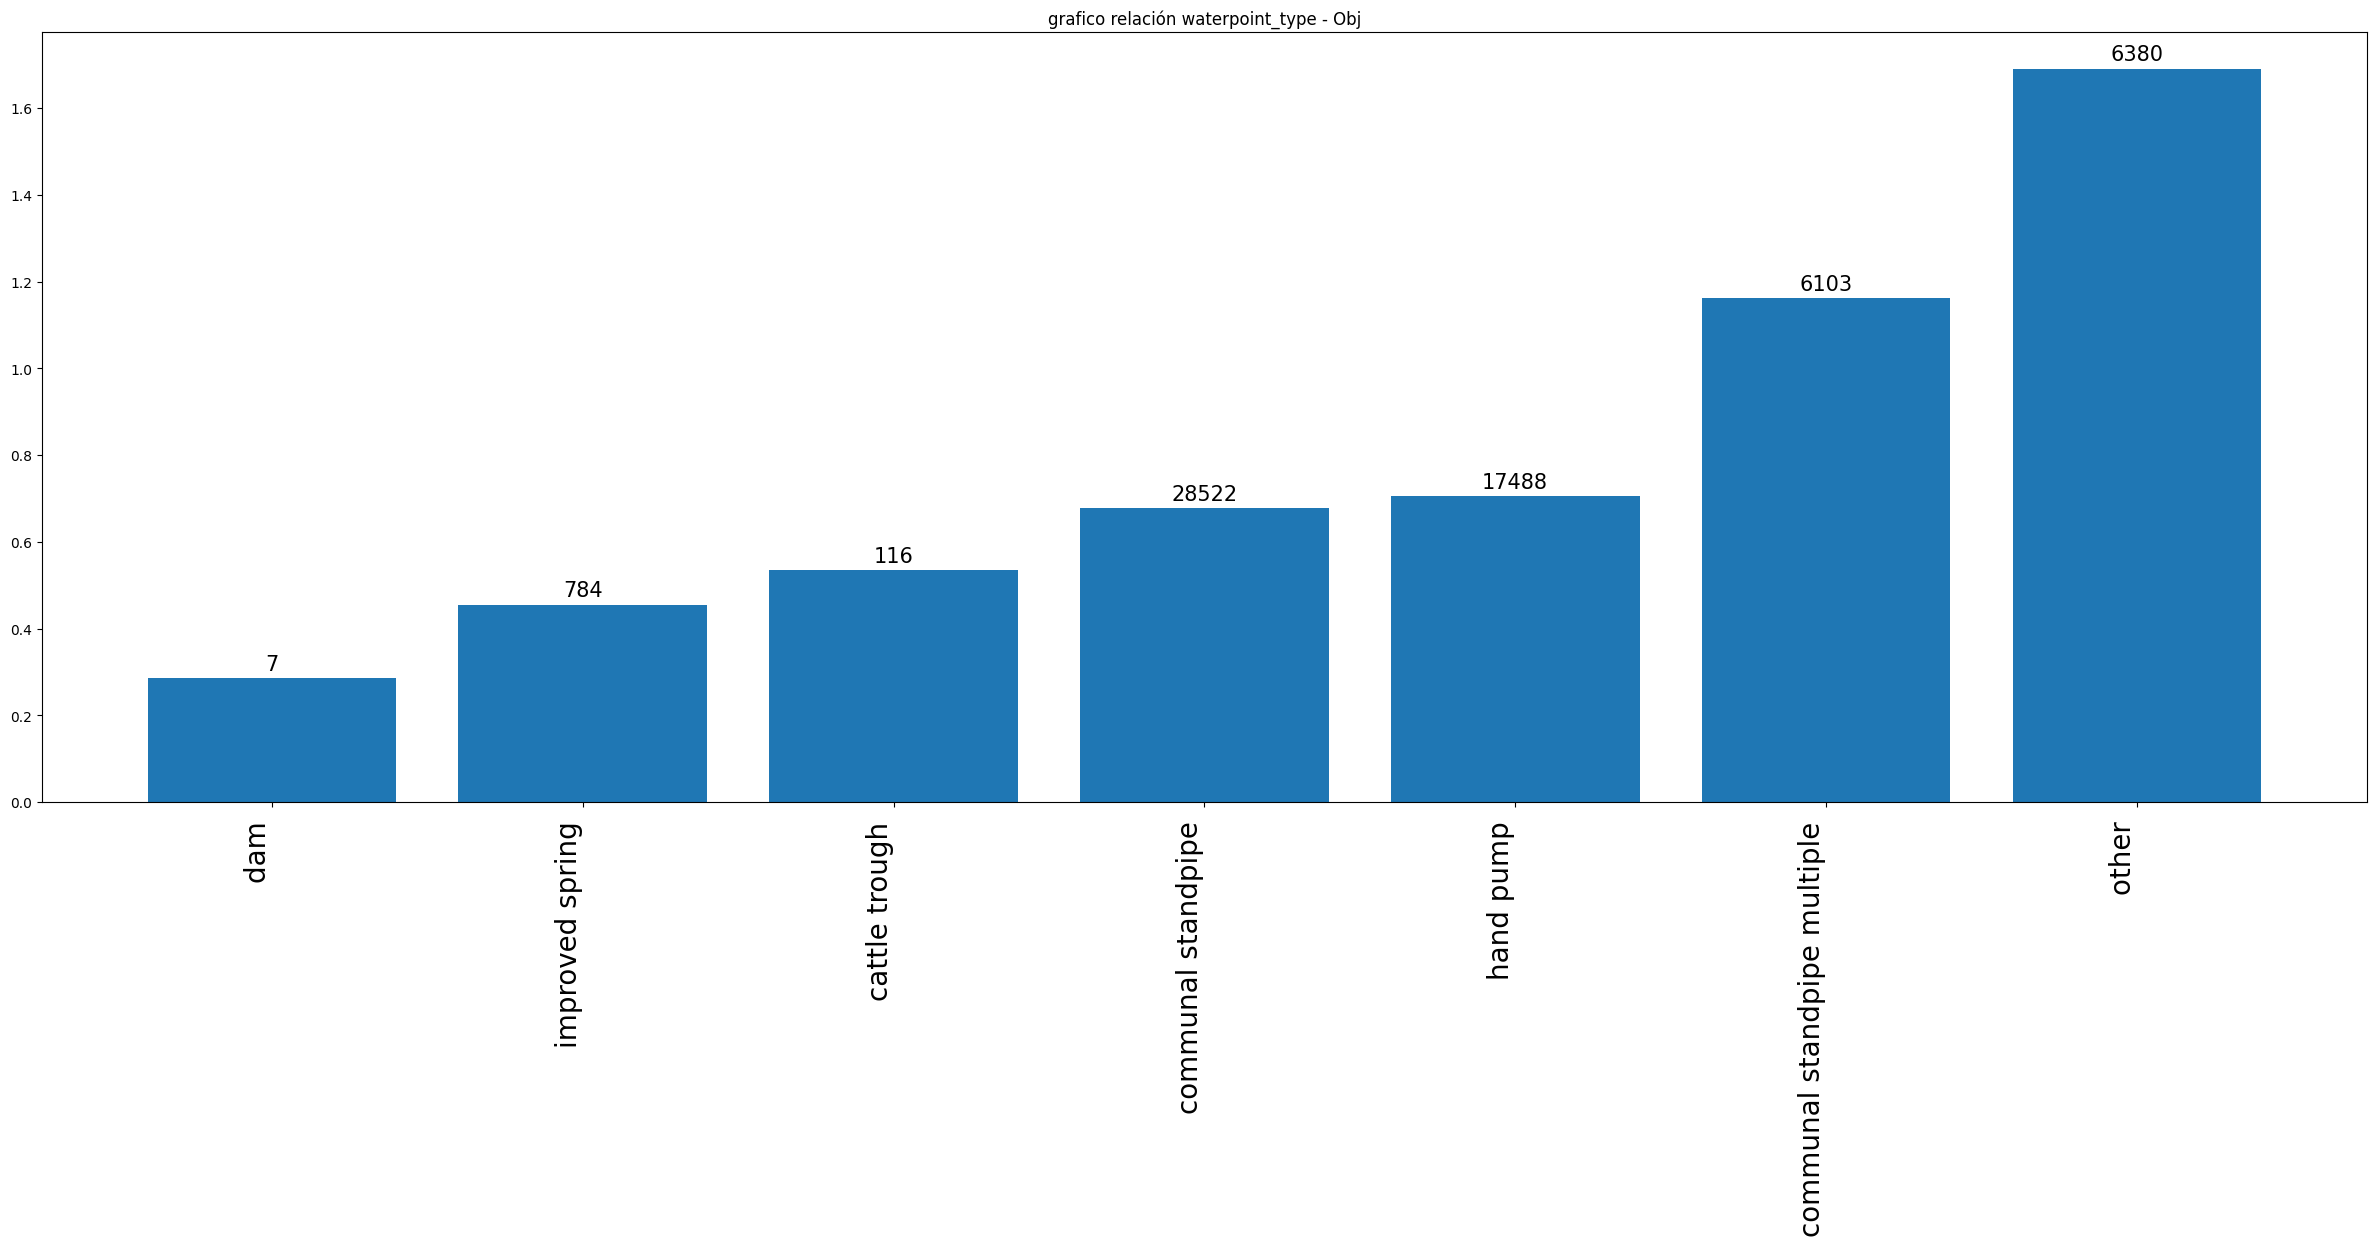

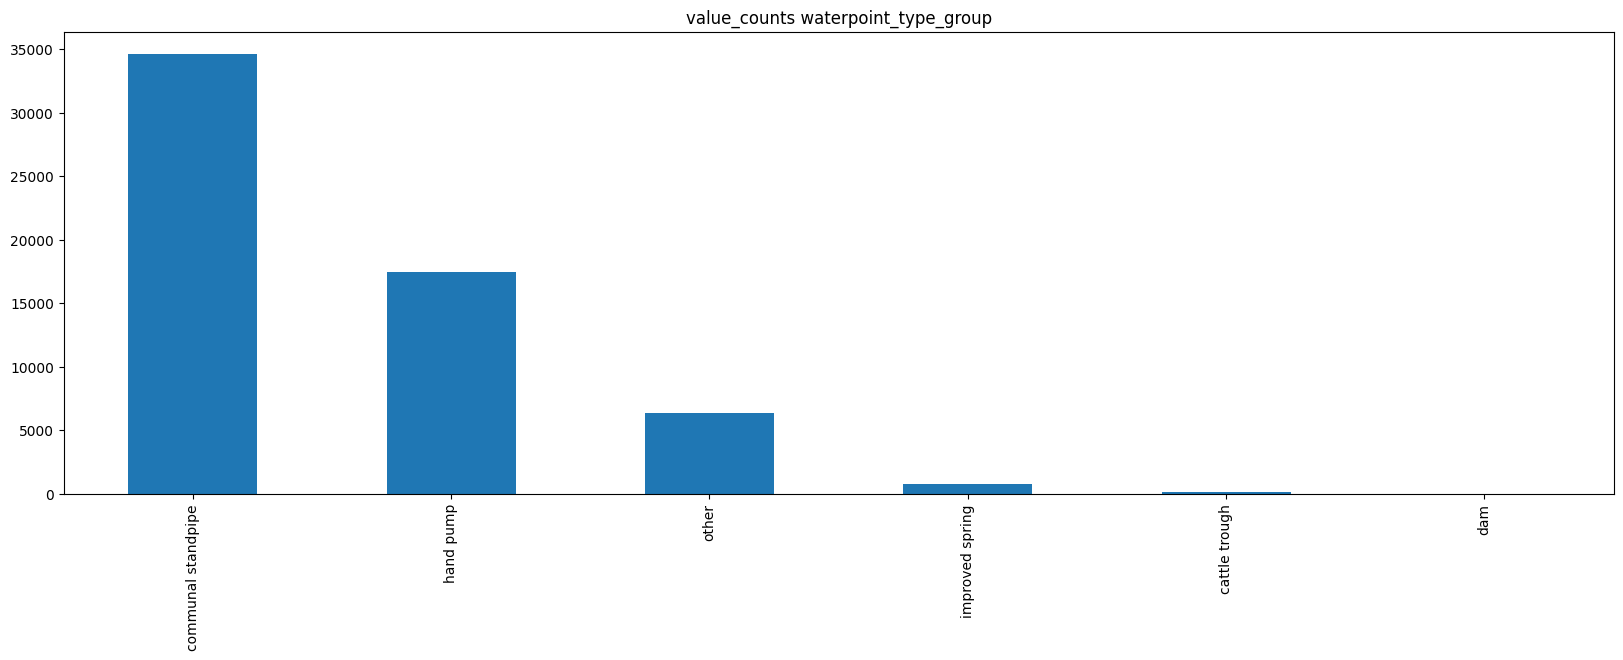

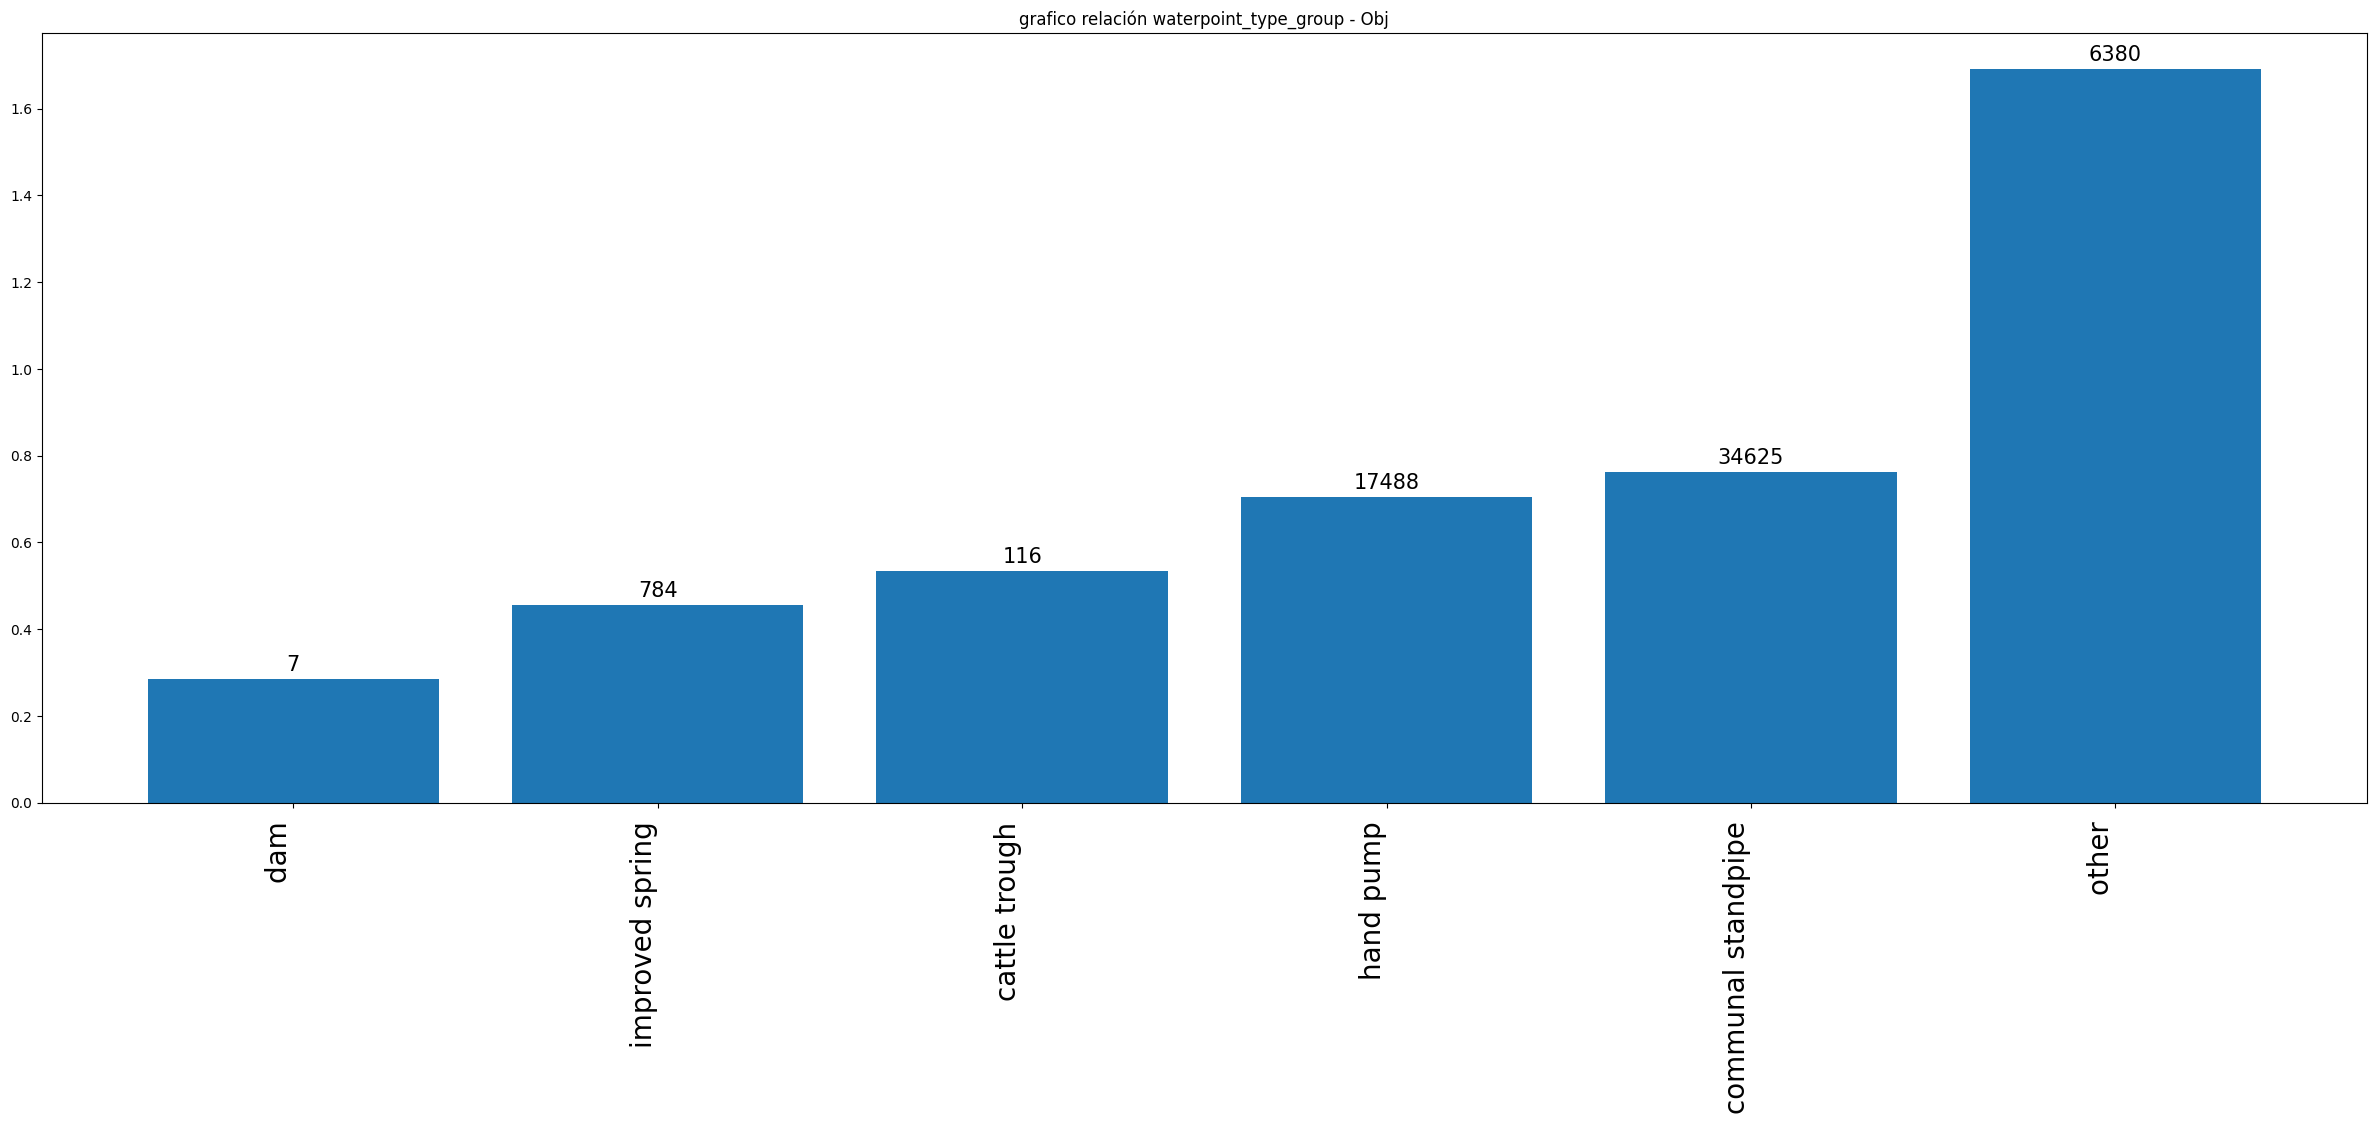

In [244]:
cols = ["source_type", "waterpoint_type","waterpoint_type_group"]
for i in cols:
    X[i].value_counts().plot(kind="bar") 
    plt.title(f"value_counts {i}")
    jd.grafica_relacion_cat_obj(df,f"{i}","status_group",True,titulo=f"grafico relación {i} - Obj")
    plt.show() 

## Resultados:

"extraction_type","extraction_type_group" agrupa others

basin agrupa lakes

management_group unknown a NA

payment, payment type unknown a NA

"water_quality", "quality_group" unknown a NA

"quantity", "quantity_group" unknown a NA

source unknown a NA

#### Puede que se me esté pasando algo, mejor busco en todo el dataframe

In [245]:
unknown_columns = X.columns[X.isin(['unknown']).any()]
unknown_columns
unknown_columns = X.columns[X.isin(['']).any()]
unknown_columns

Index([], dtype='object')

In [246]:
X = pd.read_csv("In/Training_set_values.csv")
y = pd.read_csv("In/Training_set_labels.csv")
X_test = pd.read_csv("In/Test_set_values.csv")
df = pd.merge(X,y,on="id")
for i in df.columns:
    df[i] = df[i].astype("O")
unknown_columns = df.columns[df.apply(lambda col: col.str.startswith('other'),axis=1).any()]
unknown_columns

Index(['extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type', 'source',
       'source_type', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [247]:
"hola que tal".startswith("hola")

True

#### También está "Unknown"

In [248]:
unknown_columns = X.columns[X.isin(['Unknown']).any()]
unknown_columns

Index(['funder', 'installer', 'wpt_name'], dtype='object')

In [249]:
df.replace('unknown', np.nan)

id  amount_tsh date_recorded           funder  gps_height  \
0      69572      6000.0    2011-03-14            Roman        1390   
1       8776         0.0    2013-03-06          Grumeti        1399   
2      34310        25.0    2013-02-25     Lottery Club         686   
3      67743         0.0    2013-01-28           Unicef         263   
4      19728         0.0    2011-07-13      Action In A           0   
...      ...         ...           ...              ...         ...   
59395  60739        10.0    2013-05-03  Germany Republi        1210   
59396  27263      4700.0    2011-05-07      Cefa-njombe        1212   
59397  37057         0.0    2011-04-11              NaN           0   
59398  31282         0.0    2011-03-08            Malec           0   
59399  26348         0.0    2011-03-23       World Bank         191   

          installer  longitude   latitude              wpt_name  num_private  \
0             Roman  34.938093  -9.856322                  none            0   
1           GRUMETI  34.698766  -2.147466              Zahanati            0   
2      World vision  37.460664  -3.821329           Kwa Mahundi            0   
3            UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu            0   
4           Artisan  31.130847  -1.825359               Shuleni            0   
...             ...        ...        ...                   ...          ...   
59395           CES  37.169807  -3.253847   Area Three Namba 27            0   
59396          Cefa  35.249991  -9.070629     Kwa Yahona Kuvala            0   
59397           NaN  34.017087  -8.750434               Mashine            0   
59398          Musa  35.861315  -6.378573                Mshoro            0   
59399         World  38.104048  -6.747464       Kwa Mzee Lugawa            0   

       ... water_quality quality_group      quantity  quantity_group  \
0      ...          soft          good        enough          enough   
1      ...          soft          good  insufficient    insufficient   
2      ...          soft          good        enough          enough   
3      ...          soft          good           dry             dry   
4      ...          soft          good      seasonal        seasonal   
...    ...           ...           ...           ...             ...   
59395  ...          soft          good        enough          enough   
59396  ...          soft          good        enough          enough   
59397  ...      fluoride      fluoride        enough          enough   
59398  ...          soft          good  insufficient    insufficient   
59399  ...         salty         salty        enough          enough   

                     source           source_type source_class  \
0                    spring                spring  groundwater   
1      rainwater harvesting  rainwater harvesting      surface   
2                       dam                   dam      surface   
3               machine dbh              borehole  groundwater   
4      rainwater harvesting  rainwater harvesting      surface   
...                     ...                   ...          ...   
59395                spring                spring  groundwater   
59396                 river            river/lake      surface   
59397           machine dbh              borehole  groundwater   
59398          shallow well          shallow well  groundwater   
59399          shallow well          shallow well  groundwater   

                   waterpoint_type waterpoint_type_group    status_group  
0               communal standpipe    communal standpipe      functional  
1               communal standpipe    communal standpipe      functional  
2      communal standpipe multiple    communal standpipe      functional  
3      communal standpipe multiple    communal standpipe  non functional  
4               communal standpipe    communal standpipe      functional  
...                            ...                   ...             ...  
59395        

### agreguémosle todo esto al preprocess

In [250]:
def preprocess(X):
    """
    #X.basin = X.basin.apply(lambda x: x.split(" ")[0] if x.split(" ")[0] == "Lake" else x)
    for i in ['extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type', 'source',
       'source_type', 'waterpoint_type', 'waterpoint_type_group']:
        X.loc[X[i].str.startswith("other")][i] = "other"
    """
    X.replace('unknown', np.nan)
    X.replace('Unknown', np.nan)
    for i in X.select_dtypes(include = "O").columns:
        X[i] = X[i].astype("category")

    #Fechas------------------------------------------------------------------------ 
    X.date_recorded = X.date_recorded.astype("O")
    X.date_recorded = pd.to_datetime(X.date_recorded)
    X['date_recorded'] = (X.date_recorded.max() - X.date_recorded).dt.days
    X.district_code = X.district_code.astype("category")
    X.region_code = X.region_code.astype("category")
    #Marcar 0 en amount como dijo optbinning------------------------------------------------------------------------   
    X["amount_tsh_binned"] = X["amount_tsh"].copy()
    X.loc[X["amount_tsh_binned"].between(-np.inf,1.5),"amount_tsh_binned"] = 0
    X.loc[X["amount_tsh_binned"].between(1.5,np.inf),"amount_tsh_binned"] = 1
    X["amount_tsh_binned"] = X["amount_tsh_binned"].astype("category")
    #gps_heightoptbinning------------------------------------------------------------------------  
    X.loc[X["gps_height"]<0,"gps_height"] = 0
    X["gps_height_binned"] = X["gps_height"].copy()
    X.loc[X["gps_height"].between(-np.inf,508),"gps_height_binned"] = "bin0"
    X.loc[X["gps_height"].between(508,850.5),"gps_height_binned"] = "bin1"
    X.loc[X["gps_height"].between(850.5,1359.5),"gps_height_binned"] = "bin2"
    X.loc[X["gps_height"].between(1359.5,1567.50),"gps_height_binned"] = "bin3"
    X.loc[X["gps_height"].between(1567.50,1688.50),"gps_height_binned"] = "bin4"
    X.loc[X["gps_height"].between(1688.50,np.inf),"gps_height_binned"] = "bin5"
    X["gps_height_binned"] = X["gps_height_binned"].astype("category")
    #population_binned optbinning------------------------------------------------------------------------ 
    X["population_binned"] = X["population"].copy()
    X.loc[X["population"].between(-np.inf,1.5),"population_binned"] = "bin0"
    X.loc[X["population"].between(1.5,np.inf),"population_binned"] = "bin1"
    X["population_binned"] = X["population_binned"].astype("category")
    #Marcar 0 en amount como dijo optbinning------------------------------------------------------------------------  
    X["date_recorded_binned"] = X["date_recorded"].copy()
    X.loc[X["date_recorded"].between(-np.inf,874.50),"date_recorded_binned"] = "bin0"
    X.loc[X["date_recorded"].between(874.50,981.50),"date_recorded_binned"] = "bin1"
    X.loc[X["date_recorded"].between(981.50,1006.50),"date_recorded_binned"] = "bin2"
    X.loc[X["date_recorded"].between(1006.50,np.inf),"date_recorded_binned"] = "bin3"
    X["date_recorded_binned"] = X["date_recorded_binned"].astype("category")
    #Marcar VALORES sin sentido como nan para ser imputados------------------------------------------------------------------------  
    X["construction_year"] = X.construction_year.max()-X.construction_year
    X.loc[X["construction_year"] ==2013,"construction_year"] = np.nan # si da 2013 la resta fue max - cero
    
    X.loc[X.funder=="0","funder"] = np.nan
    X.loc[X.installer=="0","installer"] = np.nan
    X.loc[X.installer=="-","installer"] = np.nan
    #Drop list ------------------------------------------------------------------------ 
   
    drop_list  = ["management_group","permit","population","amount_tsh","num_private","recorded_by"]

    #el drop list 0.8170 más "construction_year"

    #Clusters de latitud y longitud------------------------------------------------------------------------   
    X.drop(drop_list,axis=1,inplace=True)
    #clustering = KMeans(n_clusters=20)
    #X["location_cluster"] = clustering.fit_predict(X[["latitude","longitude"]].to_numpy())
    columnas_NA = ["funder","installer","subvillage","public_meeting","scheme_management","scheme_name","construction_year"]#permit
    for i in columnas_NA: 
        X[i+"isNA"] = X[i].copy()
        X[i+"isNA"]= X[i+"isNA"].isna().astype(int)
        X[i+"isNA"] = X[i+"isNA"].astype("category")
    return X

In [251]:
df

id amount_tsh date_recorded           funder gps_height  \
0      69572     6000.0    2011-03-14            Roman       1390   
1       8776        0.0    2013-03-06          Grumeti       1399   
2      34310       25.0    2013-02-25     Lottery Club        686   
3      67743        0.0    2013-01-28           Unicef        263   
4      19728        0.0    2011-07-13      Action In A          0   
...      ...        ...           ...              ...        ...   
59395  60739       10.0    2013-05-03  Germany Republi       1210   
59396  27263     4700.0    2011-05-07      Cefa-njombe       1212   
59397  37057        0.0    2011-04-11              NaN          0   
59398  31282        0.0    2011-03-08            Malec          0   
59399  26348        0.0    2011-03-23       World Bank        191   

          installer  longitude   latitude              wpt_name num_private  \
0             Roman  34.938093  -9.856322                  none           0   
1           GRUMETI  34.698766  -2.147466              Zahanati           0   
2      World vision  37.460664  -3.821329           Kwa Mahundi           0   
3            UNICEF  38.486161 -11.155298  Zahanati Ya Nanyumbu           0   
4           Artisan  31.130847  -1.825359               Shuleni           0   
...             ...        ...        ...                   ...         ...   
59395           CES  37.169807  -3.253847   Area Three Namba 27           0   
59396          Cefa  35.249991  -9.070629     Kwa Yahona Kuvala           0   
59397           NaN  34.017087  -8.750434               Mashine           0   
59398          Musa  35.861315  -6.378573                Mshoro           0   
59399         World  38.104048  -6.747464       Kwa Mzee Lugawa           0   

       ... water_quality quality_group      quantity quantity_group  \
0      ...          soft          good        enough         enough   
1      ...          soft          good  insufficient   insufficient   
2      ...          soft          good        enough         enough   
3      ...          soft          good           dry            dry   
4      ...          soft          good      seasonal       seasonal   
...    ...           ...           ...           ...            ...   
59395  ...          soft          good        enough         enough   
59396  ...          soft          good        enough         enough   
59397  ...      fluoride      fluoride        enough         enough   
59398  ...          soft          good  insufficient   insufficient   
59399  ...         salty         salty        enough         enough   

                     source           source_type source_class  \
0                    spring                spring  groundwater   
1      rainwater harvesting  rainwater harvesting      surface   
2                       dam                   dam      surface   
3               machine dbh              borehole  groundwater   
4      rainwater harvesting  rainwater harvesting      surface   
...                     ...                   ...          ...   
59395                spring                spring  groundwater   
59396                 river            river/lake      surface   
59397           machine dbh              borehole  groundwater   
59398          shallow well          shallow well  groundwater   
59399          shallow well          shallow well  groundwater   

                   waterpoint_type waterpoint_type_group    status_group  
0               communal standpipe    communal standpipe      functional  
1               communal standpipe    communal standpipe      functional  
2      communal standpipe multiple    communal standpipe      functional  
3      communal standpipe multiple    communal standpipe  non functional  
4               communal standpipe    communal standpipe      functional  
...                            ...                   ...             ...  
59395           communal standpipe    communal standpipe     

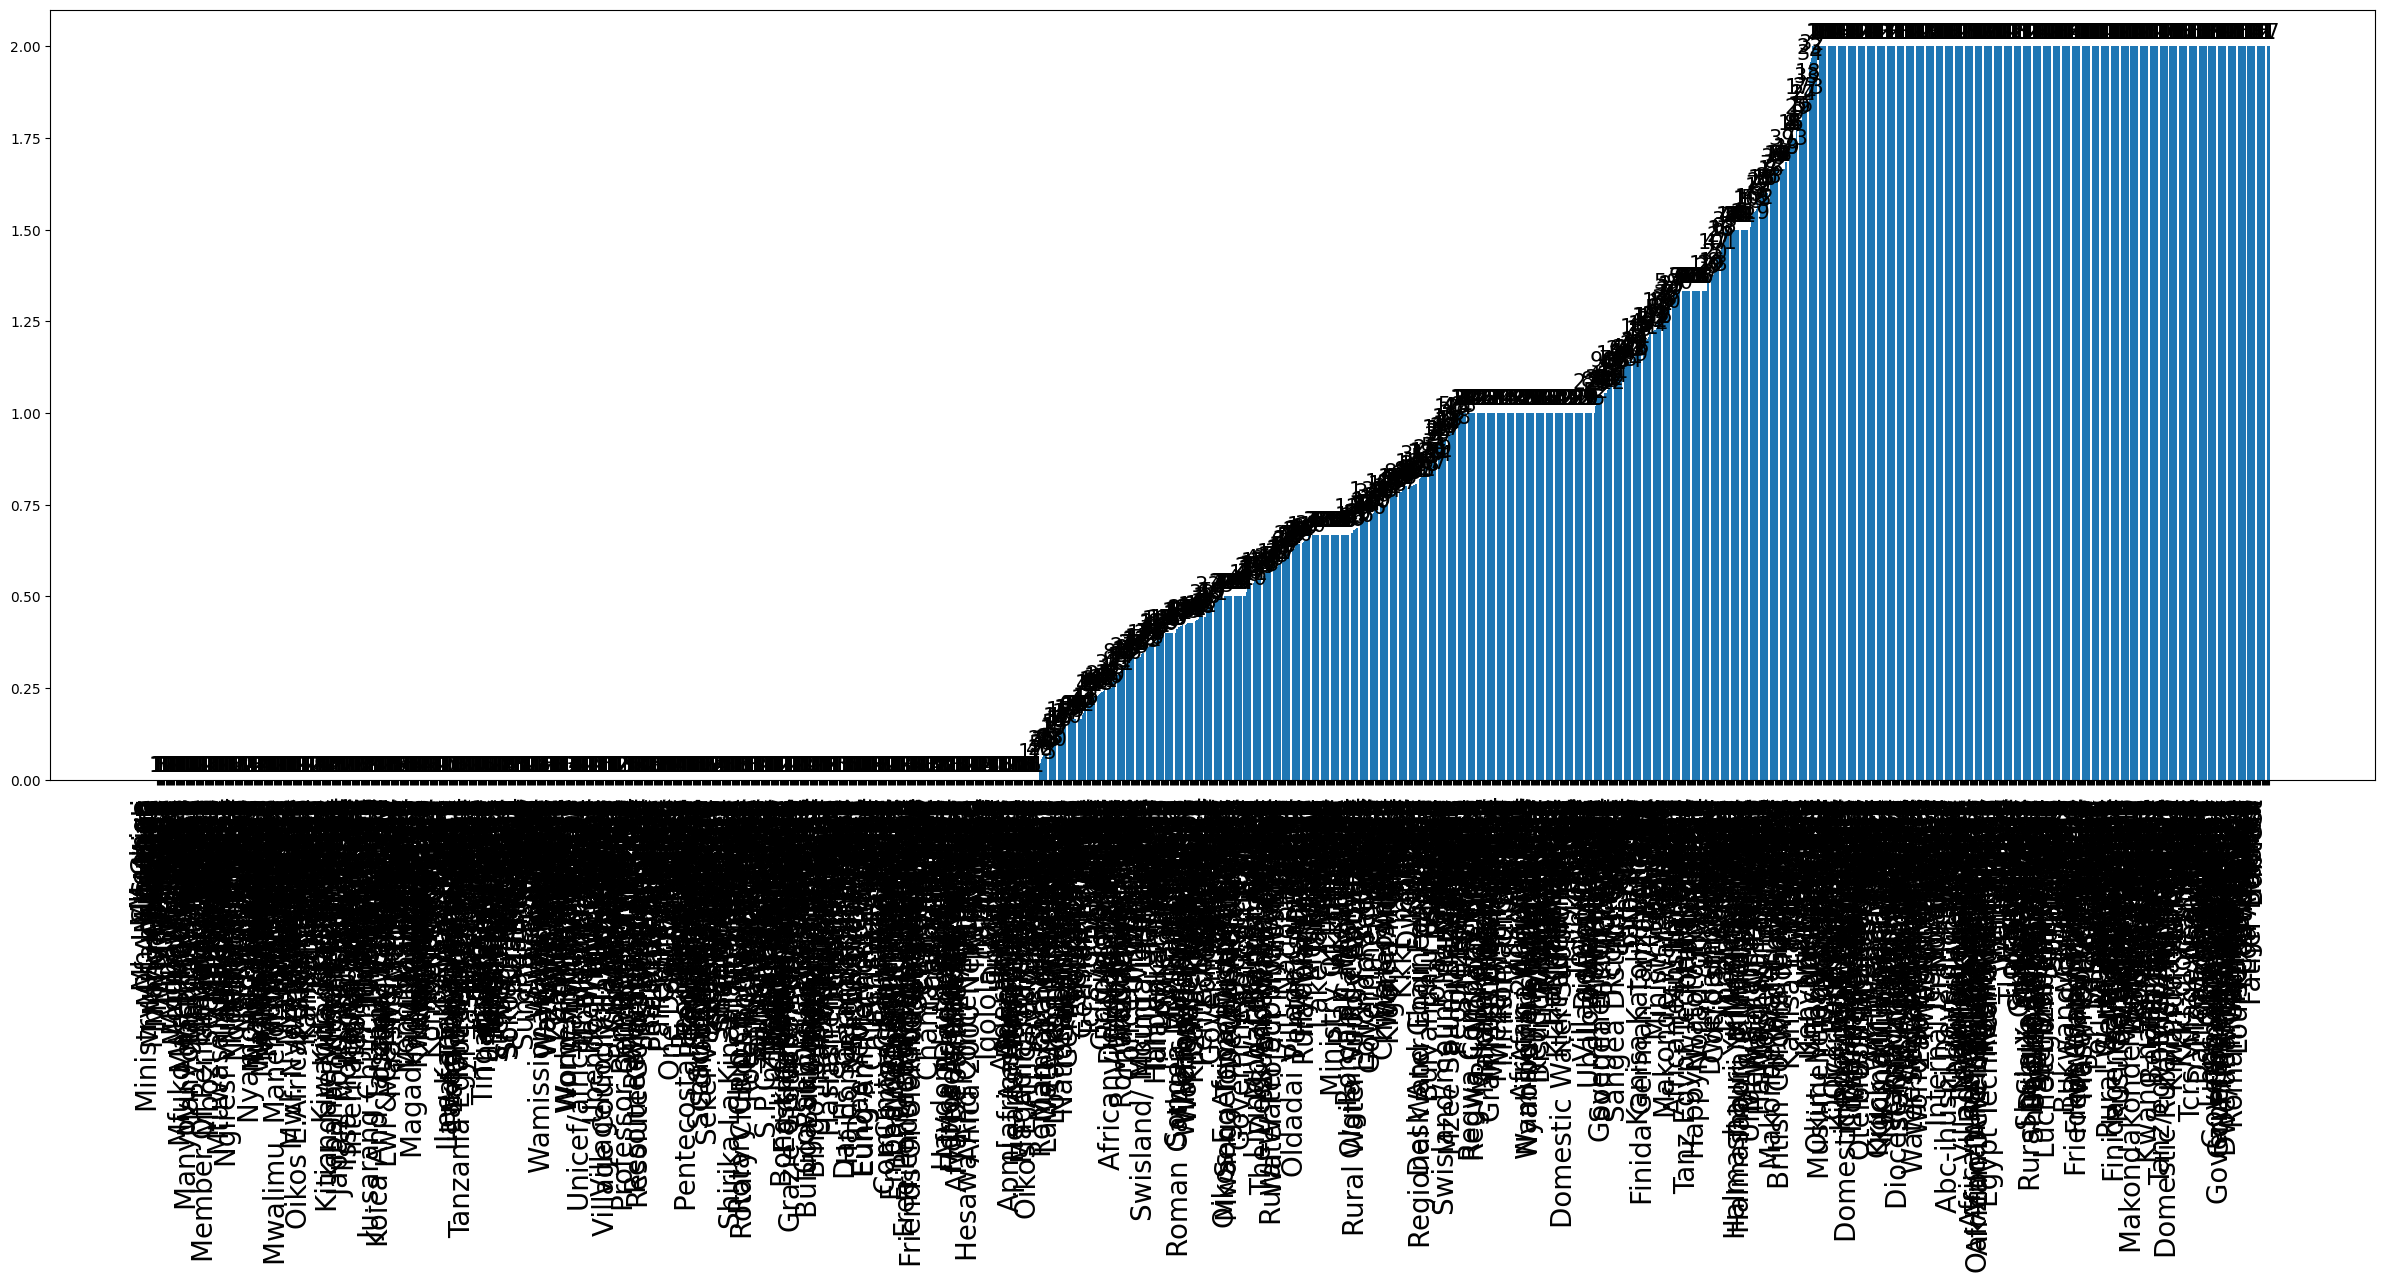

In [252]:
df.status_group = LabelEncoder().fit_transform(df.status_group)
jd.grafica_relacion_cat_obj(df,"funder","status_group",True)

## Notas después de agregar grafico de relación con la objetivo a las variables estudiadas anteriormente:

In [253]:
for col in X.select_dtypes(exclude = np.number).columns.tolist():
   if (X[col].nunique() > 25):
      print(col)


date_recorded
funder
installer
wpt_name
subvillage
lga
ward
scheme_name


# X.installer.apply(lambda x: str(x).lower()).nunique()

["water_quality", "quality_group"] dry???
no muevas dry que es super distinta a todo !!! 

extraction_type_class rope pump == hand pump??

## Asegúrate de tener payments y management_group en la lista de columnas con NA!!
# mejor dicho todas las que tienen unknowm

## Y WATER QUALITY !!

## water point tiene dam, son 7 pero super cerca del cero

X.date_recorded Revisa

# GridsearchCV

['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'so